In [9]:
pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn plotly optuna imbalanced-learn duckdb pyarrow tqdm

   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
    --------------------------------------- 0.3/11.4 MB ? eta -:--:--
    --------------------------------------- 0.3/11.4 MB ? eta -:--:--
   --------------------- ------------------ 6.0/11.4 MB 10.0 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.4 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/26.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/26.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/26.2 MB ? eta -:--:--
   ---------- ----------------------------- 6.8/26.2 MB 38.1 MB/s eta 0:00:01
   ---------- ----------------------------- 6.8/26.2 MB 38.1 MB/s eta 0:00:01
   ---------- ----------------------------- 6.8/26.2 MB 38.1 MB/s eta 0:00:01
   ---------- ----------------------------- 6.8/26.2 MB 38.1 MB/s eta 0:00:01
   ----------------------- ------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\sanwal\PycharmProjects\histopathology\venv\Scripts\python.exe -m pip install --upgrade pip


In [207]:
# Sentinel-ICU Project Setup
# Run this in your Jupyter notebook at D:\个人文件夹\Sanwal\ICU\icu.ipynb

# ============================================
# STEP 1: Install packages (Choose ONE method)
# ============================================

# Method A: If running in Jupyter notebook (use this)
# Uncomment these lines if packages aren't installed:
"""
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn plotly
!pip install optuna imbalanced-learn
!pip install duckdb pyarrow tqdm
"""

# Method B: If packages still won't install, run this in Command Prompt:
# pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn plotly optuna imbalanced-learn duckdb pyarrow tqdm

# ============================================
# STEP 2: Import Libraries
# ============================================
import pandas as pd
import numpy as np
import os
import warnings
import duckdb
from datetime import datetime, timedelta
from tqdm import tqdm
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# ============================================
# STEP 3: Set Data Paths
# ============================================
MIMIC_PATH = r'D:\个人文件夹\Sanwal\ICU\mimic'
EICU_PATH = r'D:\个人文件夹\Sanwal\ICU\eicu'

# Create output directories
output_dirs = [
    'outputs',
    'outputs/models',
    'outputs/figures', 
    'outputs/features',
    'outputs/cohorts'
]

for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

print(f"MIMIC-IV path: {MIMIC_PATH}")
print(f"eICU path: {EICU_PATH}")
print("Output directories created!")

# ============================================
# STEP 4: Test Data Access (handles .csv and .csv.gz)
# ============================================
def find_file(base_path, filename):
    """Check for both .csv and .csv.gz versions"""
    csv_path = os.path.join(base_path, f"{filename}.csv")
    gz_path = os.path.join(base_path, f"{filename}.csv.gz")
    
    if os.path.exists(csv_path):
        return csv_path
    elif os.path.exists(gz_path):
        return gz_path
    return None

# Test MIMIC-IV critical files for MI cohort
print("Checking MIMIC-IV files needed for MI cohort:")
mimic_required = {
    'icustays': os.path.join(MIMIC_PATH, 'icu'),
    'admissions': os.path.join(MIMIC_PATH, 'hosp'),
    'diagnoses_icd': os.path.join(MIMIC_PATH, 'hosp')
}

mimic_files_found = {}
for file_name, base_path in mimic_required.items():
    file_path = find_file(base_path, file_name)
    if file_path:
        print(f"  ✓ {file_name}: {os.path.basename(file_path)}")
        # Quick test read
        test_df = pd.read_csv(file_path, nrows=5, compression='gzip' if file_path.endswith('.gz') else None)
        print(f"    - {len(test_df.columns)} columns, sample cols: {list(test_df.columns[:3])}")
        mimic_files_found[file_name] = file_path
    else:
        print(f"  ✗ {file_name} not found in {base_path}")

# Test eICU critical files for MI cohort
print("\nChecking eICU files needed for MI cohort:")
eicu_required = {
    'patient': EICU_PATH,
    'diagnosis': EICU_PATH
}

eicu_files_found = {}
for file_name, base_path in eicu_required.items():
    file_path = find_file(base_path, file_name)
    if file_path:
        print(f"  ✓ {file_name}: {os.path.basename(file_path)}")
        # Quick test read
        test_df = pd.read_csv(file_path, nrows=5, compression='gzip' if file_path.endswith('.gz') else None)
        print(f"    - {len(test_df.columns)} columns, sample cols: {list(test_df.columns[:3])}")
        eicu_files_found[file_name] = file_path
    else:
        print(f"  ✗ {file_name} not found in {base_path}")

# Store file paths for later use
FILE_PATHS = {
    'mimic': mimic_files_found,
    'eicu': eicu_files_found
}

if len(mimic_files_found) == 3 and len(eicu_files_found) == 2:
    print("\n✅ All required files found! Ready to proceed with cohort extraction.")
else:
    print("\n⚠️ Some required files missing. Check paths and file extensions (.csv or .csv.gz)")

Libraries imported successfully!
MIMIC-IV path: D:\个人文件夹\Sanwal\ICU\mimic
eICU path: D:\个人文件夹\Sanwal\ICU\eicu
Output directories created!
Checking MIMIC-IV files needed for MI cohort:
  ✓ icustays: icustays.csv.gz
    - 8 columns, sample cols: ['subject_id', 'hadm_id', 'stay_id']
  ✓ admissions: admissions.csv.gz
    - 16 columns, sample cols: ['subject_id', 'hadm_id', 'admittime']
  ✓ diagnoses_icd: diagnoses_icd.csv.gz
    - 5 columns, sample cols: ['subject_id', 'hadm_id', 'seq_num']

Checking eICU files needed for MI cohort:
  ✓ patient: patient.csv.gz
    - 29 columns, sample cols: ['patientunitstayid', 'patienthealthsystemstayid', 'gender']
  ✓ diagnosis: diagnosis.csv.gz
    - 7 columns, sample cols: ['diagnosisid', 'patientunitstayid', 'activeupondischarge']

✅ All required files found! Ready to proceed with cohort extraction.


In [208]:
# COHORT EXTRACTION FROM MIMIC-IV AND eICU
# For Sentinel-ICU Project

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Paths from your setup
MIMIC_PATH = r'D:\个人文件夹\Sanwal\ICU\mimic'
EICU_PATH = r'D:\个人文件夹\Sanwal\ICU\eicu'

# ============================================
# PART 1: MIMIC-IV MI Cohort Extraction
# ============================================
print("="*50)
print("EXTRACTING MIMIC-IV MI COHORT")
print("="*50)

# Load MIMIC-IV files needed for MI identification
print("Loading MIMIC-IV data files...")

# 1. Load diagnoses to find MI patients
print("  Loading diagnoses_icd...")
mimic_diagnoses = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'diagnoses_icd.csv.gz'),
    compression='gzip',
    dtype={'icd_code': str, 'icd_version': str}
)
print(f"    Loaded {len(mimic_diagnoses):,} diagnosis records")

# 2. Load admissions for mortality outcome
print("  Loading admissions...")
mimic_admissions = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'admissions.csv.gz'),
    compression='gzip',
    parse_dates=['admittime', 'dischtime', 'deathtime']
)
# Create hospital_expire_flag from deathtime (MIMIC-IV doesn't have this flag directly)
mimic_admissions['hospital_expire_flag'] = mimic_admissions['deathtime'].notna().astype(int)
print(f"    Loaded {len(mimic_admissions):,} admissions")

# 3. Load ICU stays
print("  Loading icustays...")
mimic_icustays = pd.read_csv(
    os.path.join(MIMIC_PATH, 'icu', 'icustays.csv.gz'),
    compression='gzip',
    parse_dates=['intime', 'outtime']
)
print(f"    Loaded {len(mimic_icustays):,} ICU stays")

# 4. Load patients for age calculation
print("  Loading patients...")
mimic_patients = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'patients.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(mimic_patients):,} patients")

# Identify diagnoses
print("\nIdentifying patients by ICD codes...")

# ICD-10 codes
mi_icd10 = mimic_diagnoses[
    (mimic_diagnoses['icd_version'] == '10') & 
    (mimic_diagnoses['icd_code'].str.match(r'^(I21|I22)', na=False))
].copy()
print(f"  ICD-10 codes (I21.*, I22.*): {len(mi_icd10):,} diagnoses")

# ICD-9 codes
mi_icd9 = mimic_diagnoses[
    (mimic_diagnoses['icd_version'] == '9') & 
    (mimic_diagnoses['icd_code'].str.match(r'^410', na=False))
].copy()
print(f"  ICD-9 codes (410.*): {len(mi_icd9):,} diagnoses")

# Combine diagnoses
all_mi_diagnoses = pd.concat([mi_icd10, mi_icd9], ignore_index=True)
mi_hadm_ids = all_mi_diagnoses['hadm_id'].unique()
print(f"  Total unique hospital admissions: {len(mi_hadm_ids):,}")

# Get ICU stays for patients
mi_icu_stays = mimic_icustays[mimic_icustays['hadm_id'].isin(mi_hadm_ids)].copy()
print(f" patients with ICU stays: {len(mi_icu_stays):,}")

# Merge with admission data for outcomes
mi_icu_stays = mi_icu_stays.merge(
    mimic_admissions[['hadm_id', 'hospital_expire_flag', 'deathtime']],
    on='hadm_id',
    how='left'
)

# Merge with patient data for demographics
mi_icu_stays = mi_icu_stays.merge(
    mimic_patients[['subject_id', 'anchor_age', 'anchor_year', 'gender']],
    on='subject_id',
    how='left'
)

# Calculate age at ICU admission
mi_icu_stays['age'] = mi_icu_stays['anchor_age'] + (
    mi_icu_stays['intime'].dt.year - mi_icu_stays['anchor_year']
)

# Calculate ICU length of stay in hours
mi_icu_stays['icu_los_hours'] = (
    mi_icu_stays['outtime'] - mi_icu_stays['intime']
).dt.total_seconds() / 3600

# Apply inclusion/exclusion criteria
print("\nApplying inclusion criteria...")
print(f"  Starting cohort: {len(mi_icu_stays):,} ICU stays")

# Filters
mimic_cohort = mi_icu_stays[
    (mi_icu_stays['age'] >= 18) &  # Adult patients
    (mi_icu_stays['icu_los_hours'] >= 6) &  # Min 6 hours in ICU
    (mi_icu_stays['icu_los_hours'] <= 720)  # Max 30 days (exclude outliers)
].copy()

# Keep only first ICU stay per admission
mimic_cohort = mimic_cohort.sort_values('intime').groupby('hadm_id').first().reset_index()

print(f"  Final MIMIC cohort: {len(mimic_cohort):,} patients")
print(f"  In-hospital mortality: {mimic_cohort['hospital_expire_flag'].sum():,} ({mimic_cohort['hospital_expire_flag'].mean():.1%})")

# Select key columns for saving
mimic_cohort_final = mimic_cohort[['subject_id', 'hadm_id', 'stay_id', 'age', 'gender',
                                     'intime', 'outtime', 'icu_los_hours', 
                                     'hospital_expire_flag', 'deathtime']].copy()

# ============================================
# PART 2: eICU MI Cohort Extraction  
# ============================================
print("\n" + "="*50)
print("EXTRACTING eICU MI COHORT")
print("="*50)

# Load eICU files
print("Loading eICU data files...")

# 1. Load patient table
print("  Loading patient table...")
eicu_patient = pd.read_csv(
    os.path.join(EICU_PATH, 'patient.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(eicu_patient):,} patients")

# 2. Load diagnosis table
print("  Loading diagnosis table...")
eicu_diagnosis = pd.read_csv(
    os.path.join(EICU_PATH, 'diagnosis.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(eicu_diagnosis):,} diagnoses")

# Identify MI patients in eICU
print("\nIdentifying MI patients by diagnosis strings...")

# Related search terms
mi_keywords = [
    'myocardial infarction',
    'STEMI',
    'NSTEMI', 
    'ST elevation MI',
    'non-ST elevation MI',
    'acute MI'
]

# Create search pattern
pattern = '|'.join(mi_keywords)
mi_diagnoses_eicu = eicu_diagnosis[
    eicu_diagnosis['diagnosisstring'].str.contains(pattern, case=False, na=False)
]

# Exclude historical (not acute cases)
exclude_pattern = r'history of|old myocardial infarction|old mi|prior mi|previous mi'
mi_diagnoses_eicu = mi_diagnoses_eicu[
    ~mi_diagnoses_eicu['diagnosisstring'].str.contains(exclude_pattern, case=False, na=False)
]

mi_patient_ids = mi_diagnoses_eicu['patientunitstayid'].unique()
print(f"  Found {len(mi_patient_ids):,} acute patients (after excluding historical)")

# Get patient data for patients
eicu_cohort = eicu_patient[eicu_patient['patientunitstayid'].isin(mi_patient_ids)].copy()

# Filter out invalid discharge offsets (negative or missing)
print("  Filtering invalid discharge offsets...")
before_filter = len(eicu_cohort)
eicu_cohort = eicu_cohort[
    eicu_cohort['unitdischargeoffset'].notna() & 
    (eicu_cohort['unitdischargeoffset'] >= 0)
]
print(f"    Removed {before_filter - len(eicu_cohort):,} patients with invalid discharge times")

# Process age (handle "> 89" encoding and possible numeric values)
eicu_cohort['age_numeric'] = pd.to_numeric(
    eicu_cohort['age'].astype(str).str.replace('> 89', '90'),
    errors='coerce'
)

# Calculate ICU LOS in hours (from minutes)
eicu_cohort['icu_los_hours'] = eicu_cohort['unitdischargeoffset'] / 60

# Create mortality flag
eicu_cohort['hospital_expire_flag'] = (
    eicu_cohort['hospitaldischargestatus'] == 'Expired'
).astype(int)

# Apply inclusion criteria
print("\nApplying inclusion criteria...")
print(f"  Starting cohort: {len(eicu_cohort):,} patients")

eicu_cohort_final = eicu_cohort[
    (eicu_cohort['age_numeric'] >= 18) &  # Adult patients
    (eicu_cohort['icu_los_hours'] >= 6) &  # Min 6 hours
    (eicu_cohort['icu_los_hours'] <= 720)  # Max 30 days
].copy()

print(f"  Final eICU cohort: {len(eicu_cohort_final):,} patients")
print(f"  In-hospital mortality: {eicu_cohort_final['hospital_expire_flag'].sum():,} ({eicu_cohort_final['hospital_expire_flag'].mean():.1%})")

# Select key columns (use only available columns)
eicu_columns_to_keep = ['patientunitstayid', 'patienthealthsystemstayid',
                         'age_numeric', 'gender', 'icu_los_hours', 'hospital_expire_flag']

# Add optional columns if they exist
if 'ethnicity' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('ethnicity')
if 'unitadmittime' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('unitadmittime')
if 'unitdischargetime' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('unitdischargetime')

eicu_cohort_final = eicu_cohort_final[eicu_columns_to_keep].copy()

# ============================================
# PART 3: Save Cohorts and Generate Summary
# ============================================
print("\n" + "="*50)
print("SAVING COHORTS")
print("="*50)

# Create output directory if not exists
os.makedirs('outputs/cohorts', exist_ok=True)

# Save MIMIC cohort
mimic_path = 'outputs/cohorts/mimic_mi_cohort.csv'
mimic_cohort_final.to_csv(mimic_path, index=False)
print(f"✓ MIMIC cohort saved to: {mimic_path}")

# Save eICU cohort  
eicu_path = 'outputs/cohorts/eicu_mi_cohort.csv'
eicu_cohort_final.to_csv(eicu_path, index=False)
print(f"✓ eICU cohort saved to: {eicu_path}")

# ============================================
# PART 4: Summary Statistics
# ============================================
print("\n" + "="*50)
print("COHORT SUMMARY STATISTICS")
print("="*50)

print("\n📊 MIMIC-IV MI Cohort:")
print(f"  N = {len(mimic_cohort_final):,}")
print(f"  Age = {mimic_cohort_final['age'].mean():.1f} ± {mimic_cohort_final['age'].std():.1f} years")
print(f"  Female = {(mimic_cohort_final['gender']=='F').sum():,} ({(mimic_cohort_final['gender']=='F').mean():.1%})")
print(f"  ICU LOS = {mimic_cohort_final['icu_los_hours'].median():.1f} hours (IQR: {mimic_cohort_final['icu_los_hours'].quantile(0.25):.1f}-{mimic_cohort_final['icu_los_hours'].quantile(0.75):.1f})")
print(f"  Mortality = {mimic_cohort_final['hospital_expire_flag'].mean():.1%}")

print("\n📊 eICU MI Cohort:")
print(f"  N = {len(eicu_cohort_final):,}")
print(f"  Age = {eicu_cohort_final['age_numeric'].mean():.1f} ± {eicu_cohort_final['age_numeric'].std():.1f} years")
print(f"  Female = {(eicu_cohort_final['gender']=='Female').sum():,} ({(eicu_cohort_final['gender']=='Female').mean():.1%})")
print(f"  ICU LOS = {eicu_cohort_final['icu_los_hours'].median():.1f} hours (IQR: {eicu_cohort_final['icu_los_hours'].quantile(0.25):.1f}-{eicu_cohort_final['icu_los_hours'].quantile(0.75):.1f})")
print(f"  Mortality = {eicu_cohort_final['hospital_expire_flag'].mean():.1%}")

print("\n✅ cohort extraction complete!")
print(f"Next step: Extract temporal features (vitals, labs, interventions) for these {len(mimic_cohort_final) + len(eicu_cohort_final):,} patients")

EXTRACTING MIMIC-IV MI COHORT
Loading MIMIC-IV data files...
  Loading diagnoses_icd...
    Loaded 4,756,326 diagnosis records
  Loading admissions...
    Loaded 431,231 admissions
  Loading icustays...
    Loaded 73,181 ICU stays
  Loading patients...
    Loaded 299,712 patients

Identifying patients by ICD codes...
  ICD-10 codes (I21.*, I22.*): 5,966 diagnoses
  ICD-9 codes (410.*): 6,433 diagnoses
  Total unique hospital admissions: 12,187
 patients with ICU stays: 7,120

Applying inclusion criteria...
  Starting cohort: 7,120 ICU stays
  Final MIMIC cohort: 6,093 patients
  In-hospital mortality: 929 (15.2%)

EXTRACTING eICU MI COHORT
Loading eICU data files...
  Loading patient table...
    Loaded 200,859 patients
  Loading diagnosis table...
    Loaded 2,710,672 diagnoses

Identifying MI patients by diagnosis strings...
  Found 21,538 acute patients (after excluding historical)
  Filtering invalid discharge offsets...
    Removed 0 patients with invalid discharge times

Applying

In [ ]:
# COHORT EXTRACTION FROM MIMIC-IV AND eICU
# For ICU Project - Correct Version

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Paths from your setup
MIMIC_PATH = r'D:\个人文件夹\Sanwal\ICU\mimic'
EICU_PATH = r'D:\个人文件夹\Sanwal\ICU\eicu'

# ============================================
# PART 1: MIMIC-IV MI Cohort Extraction
# ============================================
print("="*50)
print("EXTRACTING MIMIC-IV MI COHORT")
print("="*50)

# Load MIMIC-IV files needed for MI identification
print("Loading MIMIC-IV data files...")

# 1. Load diagnoses to find MI patients
print("  Loading diagnoses_icd...")
mimic_diagnoses = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'diagnoses_icd.csv.gz'),
    compression='gzip',
    dtype={'icd_code': str, 'icd_version': str}
)
print(f"    Loaded {len(mimic_diagnoses):,} diagnosis records")

# 2. Load admissions for mortality outcome
print("  Loading admissions...")
mimic_admissions = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'admissions.csv.gz'),
    compression='gzip',
    parse_dates=['admittime', 'dischtime', 'deathtime']
)
# Create hospital_expire_flag from deathtime (MIMIC-IV doesn't have this flag directly)
mimic_admissions['hospital_expire_flag'] = mimic_admissions['deathtime'].notna().astype(int)
print(f"    Loaded {len(mimic_admissions):,} admissions")

# 3. Load ICU stays
print("  Loading icustays...")
mimic_icustays = pd.read_csv(
    os.path.join(MIMIC_PATH, 'icu', 'icustays.csv.gz'),
    compression='gzip',
    parse_dates=['intime', 'outtime']
)
print(f"    Loaded {len(mimic_icustays):,} ICU stays")

# 4. Load patients for age calculation
print("  Loading patients...")
mimic_patients = pd.read_csv(
    os.path.join(MIMIC_PATH, 'hosp', 'patients.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(mimic_patients):,} patients")

# Identify MI diagnoses
print("\nIdentifying MI patients by ICD codes...")

# Filter for PRIMARY diagnoses only (seq_num = 1) as specified in proposal
primary_diagnoses = mimic_diagnoses[mimic_diagnoses['seq_num'] == 1].copy()
print(f"  Focusing on primary diagnoses only (seq_num = 1)")

# ICD-10 codes for MI
mi_icd10 = primary_diagnoses[
    (primary_diagnoses['icd_version'] == '10') & 
    (primary_diagnoses['icd_code'].str.match(r'^(I21|I22)', na=False))
].copy()
print(f"  ICD-10 MI codes (I21.*, I22.*): {len(mi_icd10):,} primary diagnoses")

# ICD-9 codes for MI
mi_icd9 = primary_diagnoses[
    (primary_diagnoses['icd_version'] == '9') & 
    (primary_diagnoses['icd_code'].str.match(r'^410', na=False))
].copy()
print(f"  ICD-9 MI codes (410.*): {len(mi_icd9):,} primary diagnoses")

# Combine MI diagnoses
all_mi_diagnoses = pd.concat([mi_icd10, mi_icd9], ignore_index=True)
mi_hadm_ids = all_mi_diagnoses['hadm_id'].unique()
print(f"  Total unique MI hospital admissions: {len(mi_hadm_ids):,}")

# Get ICU stays for MI patients
mi_icu_stays = mimic_icustays[mimic_icustays['hadm_id'].isin(mi_hadm_ids)].copy()
print(f"  MI patients with ICU stays: {len(mi_icu_stays):,}")

# Merge with admission data for outcomes
mi_icu_stays = mi_icu_stays.merge(
    mimic_admissions[['hadm_id', 'hospital_expire_flag', 'deathtime']],
    on='hadm_id',
    how='left'
)

# Merge with patient data for demographics
mi_icu_stays = mi_icu_stays.merge(
    mimic_patients[['subject_id', 'anchor_age', 'anchor_year', 'gender']],
    on='subject_id',
    how='left'
)

# Calculate age at ICU admission
mi_icu_stays['age'] = mi_icu_stays['anchor_age'] + (
    mi_icu_stays['intime'].dt.year - mi_icu_stays['anchor_year']
)

# Clip implausible ages (handle de-identification edge cases)
mi_icu_stays['age'] = mi_icu_stays['age'].clip(0, 115)

# Calculate ICU length of stay in hours
mi_icu_stays['icu_los_hours'] = (
    mi_icu_stays['outtime'] - mi_icu_stays['intime']
).dt.total_seconds() / 3600

# Apply inclusion/exclusion criteria
print("\nApplying inclusion criteria...")
print(f"  Starting cohort: {len(mi_icu_stays):,} ICU stays")

# Filters
mimic_cohort = mi_icu_stays[
    (mi_icu_stays['age'] >= 18) &  # Adult patients
    (mi_icu_stays['icu_los_hours'] >= 6) &  # Min 6 hours in ICU
    (mi_icu_stays['icu_los_hours'] <= 720)  # Max 30 days (exclude outliers)
].copy()

# Keep only first ICU stay per admission
mimic_cohort = mimic_cohort.sort_values('intime').groupby('hadm_id').first().reset_index()

# Additional sanity check: remove any stays with negative or zero LOS
pre_filter = len(mimic_cohort)
mimic_cohort = mimic_cohort[mimic_cohort['icu_los_hours'] > 0]
if pre_filter > len(mimic_cohort):
    print(f"  Removed {pre_filter - len(mimic_cohort):,} stays with invalid LOS")

print(f"  Final MIMIC cohort: {len(mimic_cohort):,} patients")
print(f"  In-hospital mortality: {mimic_cohort['hospital_expire_flag'].sum():,} ({mimic_cohort['hospital_expire_flag'].mean():.1%})")
print(f"  Note: Mortality defined as deathtime during hospitalization")

# Select key columns for saving
mimic_cohort_final = mimic_cohort[['subject_id', 'hadm_id', 'stay_id', 'age', 'gender',
                                     'intime', 'outtime', 'icu_los_hours', 
                                     'hospital_expire_flag', 'deathtime']].copy()

# ============================================
# PART 2: eICU MI Cohort Extraction  
# ============================================
print("\n" + "="*50)
print("EXTRACTING eICU MI COHORT")
print("="*50)

# Load eICU files
print("Loading eICU data files...")

# 1. Load patient table
print("  Loading patient table...")
eicu_patient = pd.read_csv(
    os.path.join(EICU_PATH, 'patient.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(eicu_patient):,} patients")

# 2. Load diagnosis table
print("  Loading diagnosis table...")
eicu_diagnosis = pd.read_csv(
    os.path.join(EICU_PATH, 'diagnosis.csv.gz'),
    compression='gzip'
)
print(f"    Loaded {len(eicu_diagnosis):,} diagnoses")

# Identify MI patients in eICU
print("\nIdentifying MI patients by diagnosis strings...")

# MI-related search terms
mi_keywords = [
    'myocardial infarction',
    'STEMI',
    'NSTEMI', 
    'ST elevation MI',
    'non-ST elevation MI',
    'acute MI'
]

# Create search pattern
pattern = '|'.join(mi_keywords)
mi_diagnoses_eicu = eicu_diagnosis[
    eicu_diagnosis['diagnosisstring'].str.contains(pattern, case=False, na=False)
]

# Exclude historical MI and rule-out cases (not acute cases)
# More comprehensive exclusion patterns for non-acute MI
exclude_pattern = (r'history of|old myocardial infarction|old mi|prior mi|previous mi|'
                  r'rule ?out|r/o|doubt|\?troponin|'
                  r'type ?(2|ii) ?(mi|myocardial infarction)|'
                  r'demand ischemia|myocardial injury|'
                  r'elevated troponin|troponinemia')
mi_diagnoses_eicu = mi_diagnoses_eicu[
    ~mi_diagnoses_eicu['diagnosisstring'].str.contains(exclude_pattern, case=False, na=False, regex=True)
]

mi_patient_ids = mi_diagnoses_eicu['patientunitstayid'].unique()
print(f"  Found {len(mi_patient_ids):,} acute MI patients (after excluding historical/rule-out/type 2 MI)")

# Get patient data for MI patients
eicu_cohort = eicu_patient[eicu_patient['patientunitstayid'].isin(mi_patient_ids)].copy()

# Check for required offset columns
if 'unitadmitoffset' not in eicu_cohort.columns or 'unitdischargeoffset' not in eicu_cohort.columns:
    print("  ⚠️ Warning: unitadmitoffset or unitdischargeoffset not found, using alternative calculation")
    # Fallback if offsets missing (shouldn't happen in standard eICU)
    eicu_cohort['icu_los_hours'] = eicu_cohort.get('unitdischargeoffset', 0) / 60
else:
    # Calculate ICU LOS in hours (offsets are from hospital admission, in minutes)
    eicu_cohort['icu_los_hours'] = (eicu_cohort['unitdischargeoffset'] - eicu_cohort['unitadmitoffset']) / 60

# Filter out invalid discharge offsets (negative or missing LOS)
print("  Filtering invalid ICU stays...")
before_filter = len(eicu_cohort)
eicu_cohort = eicu_cohort[
    eicu_cohort['icu_los_hours'].notna() & 
    (eicu_cohort['icu_los_hours'] > 0)
]
print(f"    Removed {before_filter - len(eicu_cohort):,} patients with invalid ICU LOS")

# Process age (handle "> 89" encoding and possible numeric values)
eicu_cohort['age_numeric'] = pd.to_numeric(
    eicu_cohort['age'].astype(str).str.replace('> 89', '90'),
    errors='coerce'
)

# Create mortality flag
eicu_cohort['hospital_expire_flag'] = (
    eicu_cohort['hospitaldischargestatus'] == 'Expired'
).astype(int)

# Apply inclusion criteria
print("\nApplying inclusion criteria...")
print(f"  Starting cohort: {len(eicu_cohort):,} patients")

# Check for age edge cases
age_missing = eicu_cohort['age_numeric'].isna().sum()
if age_missing > 0:
    print(f"  Note: {age_missing:,} patients have non-numeric age values (will be excluded)")

eicu_cohort_final = eicu_cohort[
    (eicu_cohort['age_numeric'] >= 18) &  # Adult patients (drops NaN ages)
    (eicu_cohort['icu_los_hours'] >= 6) &  # Min 6 hours
    (eicu_cohort['icu_los_hours'] <= 720) &  # Max 30 days
    (eicu_cohort['icu_los_hours'] > 0)  # Sanity check for positive LOS
].copy()

# Keep only first ICU stay per hospital stay (to mirror MIMIC approach)
pre_dedup = len(eicu_cohort_final)

# Determine which column to use for sorting
sort_col = None
if 'unitadmitoffset' in eicu_cohort_final.columns:
    sort_col = 'unitadmitoffset'
elif 'unitadmittime' in eicu_cohort_final.columns:
    # Ensure datetime for proper ordering
    eicu_cohort_final['unitadmittime'] = pd.to_datetime(eicu_cohort_final['unitadmittime'], errors='coerce')
    sort_col = 'unitadmittime'
else:
    # Fallback to patient unit stay ID (essentially arbitrary within hospital stay)
    sort_col = 'patientunitstayid'
    print(f"  Note: Using patientunitstayid for sorting (no time columns available)")

# Remove duplicates, keeping first ICU stay per hospital admission
eicu_cohort_final = (
    eicu_cohort_final
    .sort_values(sort_col)
    .groupby('patienthealthsystemstayid', as_index=False)
    .first()
)

print(f"  Removed {pre_dedup - len(eicu_cohort_final):,} duplicate ICU stays within same hospital stay")

print(f"  Final eICU cohort: {len(eicu_cohort_final):,} patients")
print(f"  In-hospital mortality: {eicu_cohort_final['hospital_expire_flag'].sum():,} ({eicu_cohort_final['hospital_expire_flag'].mean():.1%})")
print(f"  Note: Mortality defined as hospitaldischargestatus=='Expired'")

# Select key columns (use only available columns)
eicu_columns_to_keep = ['patientunitstayid', 'patienthealthsystemstayid',
                         'age_numeric', 'gender', 'icu_los_hours', 'hospital_expire_flag']

# Add optional columns if they exist
if 'ethnicity' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('ethnicity')
if 'unitadmittime' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('unitadmittime')
if 'unitdischargetime' in eicu_cohort_final.columns:
    eicu_columns_to_keep.append('unitdischargetime')

eicu_cohort_final = eicu_cohort_final[eicu_columns_to_keep].copy()

# ============================================
# PART 3: Save Cohorts and Generate Summary
# ============================================
print("\n" + "="*50)
print("SAVING COHORTS")
print("="*50)

# Create output directory if not exists
os.makedirs('outputs/cohorts', exist_ok=True)

# Save MIMIC cohort
mimic_path = 'outputs/cohorts/mimic_mi_cohort.csv'
mimic_cohort_final.to_csv(mimic_path, index=False)
print(f"✓ MIMIC cohort saved to: {mimic_path}")

# Save eICU cohort  
eicu_path = 'outputs/cohorts/eicu_mi_cohort.csv'
eicu_cohort_final.to_csv(eicu_path, index=False)
print(f"✓ eICU cohort saved to: {eicu_path}")

# ============================================
# PART 4: Summary Statistics
# ============================================
print("\n" + "="*50)
print("COHORT SUMMARY STATISTICS")
print("="*50)

print("\n📊 MIMIC-IV MI Cohort:")
print(f"  N = {len(mimic_cohort_final):,}")
print(f"  Age = {mimic_cohort_final['age'].mean():.1f} ± {mimic_cohort_final['age'].std():.1f} years")
print(f"  Female = {(mimic_cohort_final['gender']=='F').sum():,} ({(mimic_cohort_final['gender']=='F').mean():.1%})")
print(f"  ICU LOS = {mimic_cohort_final['icu_los_hours'].median():.1f} hours (IQR: {mimic_cohort_final['icu_los_hours'].quantile(0.25):.1f}-{mimic_cohort_final['icu_los_hours'].quantile(0.75):.1f})")
print(f"  Mortality = {mimic_cohort_final['hospital_expire_flag'].mean():.1%}")

print("\n📊 eICU MI Cohort:")
print(f"  N = {len(eicu_cohort_final):,}")
print(f"  Age = {eicu_cohort_final['age_numeric'].mean():.1f} ± {eicu_cohort_final['age_numeric'].std():.1f} years")
print(f"  Female = {(eicu_cohort_final['gender']=='Female').sum():,} ({(eicu_cohort_final['gender']=='Female').mean():.1%})")
print(f"  ICU LOS = {eicu_cohort_final['icu_los_hours'].median():.1f} hours (IQR: {eicu_cohort_final['icu_los_hours'].quantile(0.25):.1f}-{eicu_cohort_final['icu_los_hours'].quantile(0.75):.1f})")
print(f"  Mortality = {eicu_cohort_final['hospital_expire_flag'].mean():.1%}")

print("\n📝 Outcome Definitions:")
print("  - MIMIC: In-hospital mortality (deathtime during hospitalization)")
print("  - eICU: In-hospital mortality (hospitaldischargestatus == 'Expired')")
print("  - Both datasets: First ICU stay per hospital admission only")

print("\n✅ MI cohort extraction complete!")
print(f"Next step: Extract temporal features (vitals, labs, interventions) for these {len(mimic_cohort_final) + len(eicu_cohort_final):,} patients")

EXTRACTING MIMIC-IV MI COHORT
Loading MIMIC-IV data files...
  Loading diagnoses_icd...
    Loaded 4,756,326 diagnosis records
  Loading admissions...
    Loaded 431,231 admissions
  Loading icustays...
    Loaded 73,181 ICU stays
  Loading patients...
    Loaded 299,712 patients

Identifying MI patients by ICD codes...
  Focusing on primary diagnoses only (seq_num = 1)
  ICD-10 MI codes (I21.*, I22.*): 2,857 primary diagnoses
  ICD-9 MI codes (410.*): 3,826 primary diagnoses
  Total unique MI hospital admissions: 6,683
  MI patients with ICU stays: 3,447

Applying inclusion criteria...
  Starting cohort: 3,447 ICU stays
  Final MIMIC cohort: 3,041 patients
  In-hospital mortality: 294 (9.7%)
  Note: Mortality defined as deathtime during hospitalization

EXTRACTING eICU MI COHORT
Loading eICU data files...
  Loading patient table...
    Loaded 200,859 patients
  Loading diagnosis table...
    Loaded 2,710,672 diagnoses

Identifying MI patients by diagnosis strings...
  Found 21,538 acu

In [204]:
# DEPLOYMENT HELPER FOR Sentinel-ICU MODELS
# Production-ready functions to load models and make predictions
from __future__ import annotations

import os
import pickle
import warnings
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import xgboost as xgb

# -------------------------------
# Constants
# -------------------------------
ALLOWED_WINDOWS = {6, 12, 18, 24}


# -------------------------------
# Model dir resolver (portable)
# -------------------------------
def resolve_model_dir(window: int, default_dir: str = "outputs/models") -> str:
    """
    Resolve the directory that actually contains the bundle for a given window.
    Priority:
      1) XMI_MODEL_DIR env var (if valid)
      2) default_dir (if valid)
      3) common absolute fallbacks on this machine
    """
    env_dir = os.getenv("XMI_MODEL_DIR")
    if env_dir and os.path.isdir(env_dir):
        return env_dir

    def has_window(d: str) -> bool:
        if not os.path.isdir(d):
            return False
        pkl = os.path.join(d, f"xgboost_w{window}.pkl")
        jsn = os.path.join(d, f"xgb_w{window}.json")
        imp = os.path.join(d, f"imputer_w{window}.pkl")
        return (os.path.exists(pkl) or os.path.exists(jsn)) and os.path.exists(imp)

    # 2) default_dir as given (relative to current working dir)
    if has_window(default_dir):
        return default_dir

    # 3) likely absolute locations on your box (safe no-ops elsewhere)
    fallbacks = [
        r"D:\个人文件夹\Sanwal\ICU\outputs\models",
        r"D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models",
    ]
    for d in fallbacks:
        if has_window(d):
            return d

    # Last resort: return default (load will fail with clear message if missing)
    return default_dir


# -------------------------------
# Bundle loading
# -------------------------------
def load_bundle(window: int, model_dir: str = "outputs/models"
                ) -> Tuple[xgb.XGBClassifier, object, Optional[object], List[str], Optional[float]]:
    """
    Load the complete model bundle for a specific time window.
    Returns (model, imputer, calibrator_or_None, feature_names, threshold_or_None)
    """
    if window not in ALLOWED_WINDOWS:
        raise ValueError(f"window must be one of {sorted(ALLOWED_WINDOWS)}")

    # Resolve actual dir that contains this window
    model_dir = resolve_model_dir(window, model_dir)

    # Model (pickle → JSON fallback)
    model_path = os.path.join(model_dir, f"xgboost_w{window}.pkl")
    json_path = os.path.join(model_dir, f"xgb_w{window}.json")

    model: Optional[xgb.XGBClassifier] = None
    if os.path.exists(model_path):
        try:
            with open(model_path, "rb") as f:
                model = pickle.load(f)
        except Exception as e:
            print(f"  ⚠️ Warning: Failed to unpickle {os.path.basename(model_path)} ({e}). "
                  f"Falling back to JSON model if available...")

    if model is None:
        if not os.path.exists(json_path):
            raise FileNotFoundError(
                "Model not found or could not be loaded for window "
                f"{window} at '{model_dir}'.\n"
                f"  - Tried pickle: {model_path}\n"
                f"  - Tried JSON:   {json_path}\n"
                f"Hint: set XMI_MODEL_DIR to the folder with your bundles."
            )
        try:
            model = xgb.XGBClassifier()
            model.load_model(json_path)  # modern XGBoost (≥1.6)
        except Exception:
            booster = xgb.Booster()
            booster.load_model(json_path)
            model = xgb.XGBClassifier()
            model._Booster = booster  # type: ignore[attr-defined]

    # Imputer (required)
    imputer_path = os.path.join(model_dir, f"imputer_w{window}.pkl")
    if not os.path.exists(imputer_path):
        raise FileNotFoundError(f"Missing imputer file: {imputer_path}")
    with open(imputer_path, "rb") as f:
        imputer = pickle.load(f)

    # Calibrator (optional)
    calibrator = None
    calibrator_path = os.path.join(model_dir, f"calibrator_w{window}.pkl")
    if os.path.exists(calibrator_path):
        try:
            with open(calibrator_path, "rb") as f:
                calibrator = pickle.load(f)
        except Exception as e:
            print(f"  ⚠️ Warning: Could not load calibrator ({e}). Using uncalibrated model.")
            calibrator = None

    # Feature names (required; accept legacy filename; infer if missing)
    feature_path = os.path.join(model_dir, f"feature_names_w{window}.txt")
    alt_path = os.path.join(model_dir, f"features_w{window}.txt")  # legacy
    feature_names: Optional[List[str]] = None

    def _save_names(names: List[str], path: str) -> None:
        try:
            pd.Series(names).to_csv(path, index=False, header=False)
        except Exception:
            pass

    if os.path.exists(feature_path):
        feature_names = pd.read_csv(feature_path, header=None)[0].astype(str).str.strip().tolist()
    elif os.path.exists(alt_path):
        feature_names = pd.read_csv(alt_path, header=None)[0].astype(str).str.strip().tolist()
        _save_names(feature_names, feature_path)  # normalize name for future
    else:
        # Try to infer from imputer (best; preserves training order)
        names = getattr(imputer, "feature_names_in_", None)
        if names is not None:
            feature_names = [str(n) for n in list(names)]
            _save_names(feature_names, feature_path)
            print(f"ℹ️ feature_names inferred from imputer and saved → {feature_path}")
        else:
            # Try model booster / sklearn-style names
            try:
                booster = model.get_booster()
                bn = getattr(booster, "feature_names", None)
            except Exception:
                bn = None
            nfi = getattr(model, "feature_names_in_", None)
            if bn:
                feature_names = [str(n) for n in list(bn)]
                _save_names(feature_names, feature_path)
                print(f"ℹ️ feature_names inferred from model booster and saved → {feature_path}")
            elif nfi is not None:
                feature_names = [str(n) for n in list(nfi)]
                _save_names(feature_names, feature_path)
                print(f"ℹ️ feature_names inferred from model and saved → {feature_path}")

    if not feature_names:
        raise FileNotFoundError(
            f"Missing feature list for window {window} under '{model_dir}'. "
            f"Expected {os.path.basename(feature_path)} (or legacy {os.path.basename(alt_path)})."
        )

    # Set n_features_in_ for sklearn compatibility (best effort)
    try:
        model.n_features_in_ = len(feature_names)  # type: ignore[attr-defined]
    except Exception:
        pass

    # Threshold (optional)
    threshold = None
    threshold_path = os.path.join(model_dir, f"threshold_w{window}.csv")
    if os.path.exists(threshold_path):
        threshold_df = pd.read_csv(threshold_path)
        if "threshold" in threshold_df.columns and not threshold_df.empty:
            threshold = float(threshold_df["threshold"].iloc[0])

    return model, imputer, calibrator, feature_names, threshold


# -------------------------------
# Feature alignment
# -------------------------------
def _align_features(
    df: pd.DataFrame,
    feature_names: List[str],
    warn_all_missing: bool = True
) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Align incoming dataframe to match training feature set.
    Returns (aligned_matrix (np.ndarray), missing_features, extra_features)
    """
    df = df.copy()
    cols = set(df.columns)
    expected = set(feature_names)

    # Identify missing and extra features
    missing = [c for c in feature_names if c not in cols]
    extra = sorted(list(cols - expected))

    # Add missing as NaN, drop extras, order correctly
    for c in missing:
        df[c] = np.nan
    df = df[feature_names]

    # Ensure numeric types (coerce strings safely)
    df = df.apply(pd.to_numeric, errors="coerce")

    # Optional warning if everything is missing (imputer medians only)
    if warn_all_missing and len(missing) == len(feature_names):
        warnings.warn(
            "All features are missing! Prediction will be based on imputer medians only.",
            RuntimeWarning
        )

    return df.to_numpy(), missing, extra


# -------------------------------
# Core prediction functions
# -------------------------------
def predict_proba(
    df: pd.DataFrame,
    window: int,
    calibrated: bool = True,
    model_dir: str = "outputs/models",
    return_diagnostics: bool = False
) -> Union[np.ndarray, Tuple[np.ndarray, List[str], List[str]]]:
    """
    Predict probabilities for a dataframe of patients.
    If return_diagnostics=True, returns (probs, missing_features, extra_features)
    """
    model, imputer, calibrator, feature_names, _ = load_bundle(window, model_dir)

    X, missing, extra = _align_features(df, feature_names)
    X_imputed = imputer.transform(X)

    if calibrated and calibrator is not None:
        probs = calibrator.predict_proba(X_imputed)[:, 1]
    else:
        probs = model.predict_proba(X_imputed)[:, 1]

    if return_diagnostics:
        return probs, missing, extra
    return probs


def predict_binary(
    df: pd.DataFrame,
    window: int,
    threshold: Optional[float] = None,
    model_dir: str = "outputs/models",
    bundle: Optional[Tuple] = None
) -> np.ndarray:
    """
    Binary predictions using an explicit or stored optimal threshold.
    """
    if bundle is None:
        _, _, _, _, optimal_thr = load_bundle(window, model_dir)
    else:
        _, _, _, _, optimal_thr = bundle

    if threshold is None:
        threshold = optimal_thr if optimal_thr is not None else 0.5

    probs = predict_proba(df, window, calibrated=True, model_dir=model_dir)
    return (probs >= float(threshold)).astype(int)


def predict_single_patient(
    patient_dict: Dict[str, float],
    window: int,
    calibrated: bool = True,
    model_dir: str = "outputs/models"
) -> float:
    """
    Convenience wrapper for a single patient dict.
    """
    df = pd.DataFrame([patient_dict])
    prob = predict_proba(df, window, calibrated, model_dir)
    return float(prob[0])


# -------------------------------
# Utilities
# -------------------------------
def get_feature_importance(window: int, model_dir: str = "outputs/models") -> pd.DataFrame:
    """
    Load feature importance CSV; if missing, derive from model.
    """
    fi_path = os.path.join(model_dir, f"feature_importance_w{window}.csv")
    if os.path.exists(fi_path):
        return pd.read_csv(fi_path)

    model, _, _, feature_names, _ = load_bundle(window, model_dir)
    imp = getattr(model, "feature_importances_", None)
    if imp is None:
        raise FileNotFoundError(
            "Feature importance CSV not found and model has no feature_importances_."
        )

    return pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values(
        "importance", ascending=False
    )


def get_risk_category(probability: float, thresholds: Optional[Dict[str, float]] = None) -> str:
    """
    Map probability to risk category.
    """
    if thresholds is None:
        thresholds = {"low": 0.1, "medium": 0.3, "high": 0.5}

    if probability < thresholds["low"]:
        return "Low Risk"
    elif probability < thresholds["medium"]:
        return "Moderate Risk"
    elif probability < thresholds["high"]:
        return "High Risk"
    else:
        return "Very High Risk"


# -------------------------------
# Batch prediction helper
# -------------------------------
def batch_predict_from_csv(
    csv_path: str,
    window: int,
    output_path: Optional[str] = None,
    calibrated: bool = True,
    include_diagnostics: bool = False,
    model_dir: str = "outputs/models",
) -> pd.DataFrame:
    """
    Predict for a CSV of patients; returns DataFrame with predictions appended.
    """
    df = pd.read_csv(csv_path)

    if include_diagnostics:
        probs, missing, extra = predict_proba(
            df, window, calibrated, model_dir=model_dir, return_diagnostics=True
        )
        df["missing_features"] = str(missing) if missing else ""
        df["extra_features"] = str(extra) if extra else ""
    else:
        probs = predict_proba(df, window, calibrated, model_dir=model_dir)

    df["mortality_prob"] = probs
    df["risk_category"] = df["mortality_prob"].apply(get_risk_category)
    df["binary_pred"] = predict_binary(df, window, model_dir=model_dir)

    if output_path:
        df.to_csv(output_path, index=False)
        print(f"Predictions saved to: {output_path}")
        print(f"  Total patients: {len(df)}")
        print(f"  High risk (>0.5): {(df['mortality_prob'] > 0.5).sum()}")
        print(f"  Mean predicted mortality: {df['mortality_prob'].mean():.1%}")

    return df


# -------------------------------
# API-ready wrapper (batch/single)
# -------------------------------
def predict_api(
    patient_data: Union[Dict[str, float], pd.DataFrame],
    window: int = 12,
    return_details: bool = False,
    model_dir: str = "outputs/models",
) -> Dict:
    """
    API-friendly prediction. Accepts a dict (single) or DataFrame (batch).
    """
    try:
        if isinstance(patient_data, dict):
            df = pd.DataFrame([patient_data])
        else:
            df = patient_data.copy()

        model, imputer, calibrator, feature_names, threshold = load_bundle(window, model_dir)

        X, missing, extra = _align_features(df, feature_names)
        X_imputed = imputer.transform(X)

        if calibrator is not None:
            probs = calibrator.predict_proba(X_imputed)[:, 1]
        else:
            probs = model.predict_proba(X_imputed)[:, 1]

        use_threshold = 0.5 if threshold is None else float(threshold)
        binary = (probs >= use_threshold).astype(int)
        risks = [get_risk_category(float(p)) for p in probs]

        result: Dict = {
            "success": True,
            "window": window,
            "n_patients": int(len(df)),
            "probabilities": [float(p) for p in probs],
            "binary_predictions": [int(b) for b in binary],
            "risk_categories": risks,
        }

        if len(df) == 1:
            result["probability"] = float(probs[0])
            result["binary_prediction"] = int(binary[0])
            result["risk_category"] = risks[0]

        if return_details:
            result["threshold"] = use_threshold
            result["missing_features"] = missing
            result["extra_features"] = extra
            result["n_missing"] = len(missing)
            result["n_extra"] = len(extra)
            if len(missing) == len(feature_names):
                result["warning"] = (
                    "All features missing - prediction based on imputer medians only"
                )
            try:
                fi = get_feature_importance(window, model_dir=model_dir)
                result["top_features"] = fi.head(5)[["feature", "importance"]].to_dict("records")
            except Exception:
                pass
            result["calibrated"] = calibrator is not None

        return result

    except Exception as e:
        return {"success": False, "error": str(e), "error_type": type(e).__name__}


# -------------------------------
# Test functions (without actual model files)
# -------------------------------
def test_functions_defined():
    """Test that all functions are properly defined"""
    functions = [
        'load_bundle',
        '_align_features',
        'predict_proba',
        'predict_binary',
        'predict_single_patient',
        'get_feature_importance',
        'get_risk_category',
        'batch_predict_from_csv',
        'predict_api'
    ]

    for func_name in functions:
        assert func_name in globals(), f"{func_name} not defined"

    print("✅ All functions defined correctly")
    return True


# -------------------------------
# Main execution / Smoke test
# -------------------------------
if __name__ == "__main__":
    print("=" * 50)
    print("ICU DEPLOYMENT HELPER TEST")
    print("=" * 50)

    test_functions_defined()

    # Example single-patient dict (keys don't need to include all features)
    sample = {
        "age_years": 65,
        "hr_mean": 85,
        "hr_max": 95,
        "hr_min": 75,
        "sbp_mean": 120,
        "sbp_min": 100,
        "sbp_max": 140,
        "dbp_mean": 70,
        "dbp_min": 60,
        "dbp_max": 80,
        "rr_mean": 18,
        "rr_max": 22,
        "rr_min": 14,
        "spo2_mean": 95,
        "spo2_min": 92,
        "temp_mean": 37.0,
        "temp_max": 37.5,
        "lactate_max": 2.1,
        "lactate_mean": 1.8,
        "creat_max": 1.3,
        "creat_mean": 1.1,
        "troponin_max": 5.2,
        "glucose_mean": 120,
        "glucose_max": 150,
        "hemoglobin_min": 11.5,
        "wbc_max": 12.5,
        "platelets_min": 180
    }

    try:
        # Resolve model dir for window=12 without relying on cwd
        md = resolve_model_dir(12, "outputs/models")
        print(f"\nUsing model_dir: {md}")

        model_exists = (
            os.path.exists(os.path.join(md, "xgboost_w12.pkl")) or
            os.path.exists(os.path.join(md, "xgb_w12.json"))
        )
        if model_exists:
            result = predict_api(sample, window=12, return_details=True, model_dir=md)
            if result["success"]:
                print("\n✅ Smoke test PASSED!")
                print(f"  Probability: {result.get('probability', float('nan')):.3f}")
                print(f"  Risk category: {result.get('risk_category', 'N/A')}")
                print(f"  Binary prediction: {result.get('binary_prediction', 'N/A')}")
                if 'n_missing' in result:
                    print(f"  Missing features: {result['n_missing']}")
                if 'calibrated' in result:
                    print(f"  Calibrated: {result['calibrated']}")
            else:
                print(f"\n⚠️ Prediction failed: {result.get('error', 'Unknown error')}")
                print(f"  Error type: {result.get('error_type', 'Unknown')}")
        else:
            print("\n⚠️ Model files not found.")
            print("  Expected at least one of:")
            print(f"    - {os.path.join(md, 'xgboost_w12.pkl')}")
            print(f"    - {os.path.join(md, 'xgb_w12.json')}")
            print("  Set XMI_MODEL_DIR or place bundles under outputs/models/")
            # Exercise error path:
            result = predict_api(sample, window=12, return_details=True, model_dir=md)
            assert result["success"] is False
            assert "error" in result
            print("\n✅ Error handling works correctly")

    except Exception as e:
        print(f"\n❌ Smoke test encountered error: {e}")
        import traceback
        traceback.print_exc()

    print("\n" + "=" * 50)
    print("Test complete. Functions are ready for use.")
    print("=" * 50)


ICU DEPLOYMENT HELPER TEST
✅ All functions defined correctly

Using model_dir: D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models

✅ Smoke test PASSED!
  Probability: 0.129
  Risk category: Moderate Risk
  Binary prediction: 1
  Missing features: 0
  Calibrated: True

Test complete. Functions are ready for use.


In [159]:
# --- ultra-minimal diagnostic using functions already defined in this notebook ---

WINDOW = 12
MODEL_DIR = "outputs/models"

import numpy as np, pandas as pd

# 1) Load bundle
model, imputer, calibrator, feature_names, threshold = load_bundle(WINDOW, MODEL_DIR)
print(f"✓ Loaded bundle for {WINDOW}h: {len(feature_names)} features")

# 2) Imputer vs feature sanity check
stats = getattr(imputer, "statistics_", None)
assert stats is not None and len(stats) == len(feature_names), \
    f"Imputer stats ({None if stats is None else len(stats)}) != feature count ({len(feature_names)})"
print("✓ Imputer statistics length matches features")

# 3) One prediction on the imputer-median row
median_df = pd.DataFrame([imputer.statistics_], columns=feature_names)
out = predict_api(median_df, window=WINDOW, return_details=True)
assert out.get("success", False), f"Prediction failed: {out}"

prob = float(out["probabilities"][0])
thr  = out.get("threshold", threshold if threshold is not None else 0.5)
binp = int(prob >= float(thr))
print(f"✓ Prediction OK — prob={prob:.3f} | threshold={thr} | binary={binp} | "
      f"calibrated={out.get('calibrated', calibrator is not None)}")


✓ Loaded bundle for 12h: 13 features
✓ Imputer statistics length matches features
✓ Prediction OK — prob=0.000 | threshold=0.3600000143051147 | binary=0 | calibrated=True


In [160]:
# Run this cell right after the deployment helper cell
import numpy as np  # safe to import again
MODEL_DIR = "outputs/models"
WINDOWS = [6, 12, 18, 24]

for w in WINDOWS:
    try:
        model, imputer, calibrator, feature_names, thr = load_bundle(w, MODEL_DIR)
        # "Typical" dummy patient: use imputer medians aligned to feature order
        dummy = dict(zip(feature_names, getattr(imputer, "statistics_", np.full(len(feature_names), np.nan))))
        res = predict_api(dummy, window=w, return_details=True)
        print(f"w{w}: ✓ prob={res['probability']:.3f} | thr={res['threshold']:.3f} | "
              f"bin={res['binary_prediction']} | calibrated={res.get('calibrated', calibrator is not None)}")
    except Exception as e:
        print(f"w{w}: ✗ {type(e).__name__}: {e}")


w6: ✓ prob=0.000 | thr=0.143 | bin=0 | calibrated=True
w12: ✓ prob=0.000 | thr=0.360 | bin=0 | calibrated=True
w18: ✓ prob=0.000 | thr=0.250 | bin=0 | calibrated=True
w24: ✓ prob=0.044 | thr=0.112 | bin=0 | calibrated=True


In [161]:
# 1) Show more precision (you’ll see it isn’t exactly zero)
print(f"{predict_proba(median_df, 12, calibrated=True,  model_dir=MODEL_DIR)[0]:.12f}")

# 2) See calibration effect on the SAME input
pc = predict_proba(median_df, 12, calibrated=True,  model_dir=MODEL_DIR)[0]
pr = predict_proba(median_df, 12, calibrated=False, model_dir=MODEL_DIR)[0]
print("calibrated:", pc, " raw:", pr)

# 3) Compare median vs your original sample
import pandas as pd
pc_samp = predict_proba(pd.DataFrame([sample]), 12, calibrated=True, model_dir=MODEL_DIR)[0]
print("sample (calibrated):", pc_samp)


0.000000000000
calibrated: 0.0  raw: 0.0021698528
sample (calibrated): 0.033898305147886276


In [146]:
import os, pandas as pd

CSV_PATH = "path/to/patients_sample.csv"  # <-- replace with your CSV; keep same columns as training
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH).head(10)
    res = predict_api(df, window=12, return_details=True)
    print("n:", res["n_patients"])
    print("mean prob:", sum(res["probabilities"]) / len(res["probabilities"]))
    print("≥thr:", sum(res["binary_predictions"]))
    print("first 3 risks:", res["risk_categories"][:3])
else:
    print(f"CSV not found at {CSV_PATH} — skip batch check.")


CSV not found at path/to/patients_sample.csv — skip batch check.


In [163]:
# Build a small test set using each window's imputer medians
import os, pandas as pd, numpy as np

OUT_CSV = "patients_sample.csv"
rows = []

for w in [6, 12, 18, 24]:
    model, imputer, calibrator, feature_names, thr = load_bundle(w, "outputs/models")
    med = getattr(imputer, "statistics_", np.full(len(feature_names), np.nan))
    # add a few slightly perturbed rows per window
    for j in range(3):
        row = dict(zip(feature_names, med))
        # tiny jitter to avoid identical rows
        for k in feature_names[: max(3, len(feature_names)//5) ]:
            row[k] = float(row[k]) if pd.notna(row[k]) else 0.0
            row[k] = row[k] * (1 + np.random.normal(0, 0.05))
        row["__window__"] = w  # helpful tag
        rows.append(row)

pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
print(f"Wrote {OUT_CSV} with {len(rows)} rows.")


Wrote patients_sample.csv with 12 rows.


In [11]:
from pathlib import Path
import pandas as pd

CSV_PATH = "patients_sample.csv"
if Path(CSV_PATH).exists():
    df = pd.read_csv(CSV_PATH)
    for w in [6, 12, 18, 24]:
        df_w = df[df["__window__"] == w].drop(columns=["__window__"])
        # Use the helper that aligns features & applies calibrator/threshold
        res = predict_api(df_w, window=w, return_details=True)
        print(f"\nw{w}: n={res['n_patients']}, mean_prob={np.mean(res['probabilities']):.3f}, "
              f">=thr={sum(res['binary_predictions'])}/{res['n_patients']}, thr={res['threshold']:.3f}, "
              f"calibrated={res.get('calibrated', True)}")
else:
    print("Sample CSV not found — rerun the cell that creates patients_sample.csv.")



w6: n=3, mean_prob=0.028, >=thr=0/3, thr=0.125, calibrated=True

w12: n=3, mean_prob=0.060, >=thr=0/3, thr=0.133, calibrated=True

w18: n=3, mean_prob=0.096, >=thr=0/3, thr=0.125, calibrated=True

w24: n=3, mean_prob=0.056, >=thr=0/3, thr=0.148, calibrated=True


In [12]:
# Monotonic sanity check: bump a few risk features and confirm prob increases
import numpy as np, pandas as pd
from copy import deepcopy

WINDOW = 12
model, imputer, calibrator, feature_names, thr = load_bundle(WINDOW)

# Start from median row
base = dict(zip(feature_names, imputer.statistics_))
base_df = pd.DataFrame([base])
p0 = predict_api(base_df, window=WINDOW)["probability"]

# Make them sicker: older, higher lactate, lower SBP, lower SpO2
sick = deepcopy(base)
for k, v in [
    ("age_years", base.get("age_years", 60) + 20),
    ("lactate_max", base.get("lactate_max", 1.5) + 3.0),
    ("sbp_min", max(40, base.get("sbp_min", 110) - 30)),
    ("spo2_min", max(50, base.get("spo2_min", 96) - 10)),
]:
    sick[k] = v

sick_df = pd.DataFrame([sick])
p1 = predict_api(sick_df, window=WINDOW)["probability"]

print(f"Baseline prob: {p0:.3f} → Sick prob: {p1:.3f}  (Δ={p1-p0:+.3f})")


Baseline prob: 0.051 → Sick prob: 0.500  (Δ=+0.449)


In [13]:
res0 = predict_api(pd.DataFrame([base]), window=12, return_details=True)
res1 = predict_api(pd.DataFrame([sick]), window=12, return_details=True)
print(f"thr={res1['threshold']:.3f} | base: prob={res0['probability']:.3f}, bin={res0['binary_prediction']}, {res0['risk_category']} "
      f"→ sick: prob={res1['probability']:.3f}, bin={res1['binary_prediction']}, {res1['risk_category']}")


thr=0.133 | base: prob=0.051, bin=0, Low Risk → sick: prob=0.500, bin=1, Very High Risk


In [164]:
# sweep a single feature and see how prob changes
model, imputer, cal, feats, thr = load_bundle(12)
base = dict(zip(feats, imputer.statistics_))

def sweep(var, values):
    rows = []
    for v in values:
        r = base.copy()
        r[var] = v
        rows.append(r)
    df = pd.DataFrame(rows)
    out = predict_api(df, window=12)
    return pd.DataFrame({var: values, "prob": out["probabilities"]})

s = sweep("lactate_max", np.linspace(0.5, 6.0, 12))
s


,lactate_max,prob
0,0.5,0.000000
1,1.0,0.000000
2,1.5,0.000000
3,2.0,0.000000
4,2.5,0.000000
5,3.0,0.000000
6,3.5,0.087500
7,4.0,0.093023
8,4.5,0.093023
9,5.0,0.093023


In [167]:
# OPTIONAL: create a tiny batch CSV and run batch prediction
from pathlib import Path
import pandas as pd, numpy as np

WINDOW = 12
model, imputer, calibrator, feature_names, thr = load_bundle(WINDOW)

# Build a few rows from imputer medians and tweak a couple features
base = dict(zip(feature_names, imputer.statistics_))
rows = [
    base,
    {**base, "lactate_max": 4.0},
    {**base, "lactate_max": 5.0, "sbp_min": base.get("sbp_min", 100) - 15},
]
df = pd.DataFrame(rows)
csv_path = Path("patients_sample.csv")
df.to_csv(csv_path, index=False)
print(f"Wrote {csv_path} with {len(df)} rows and {len(df.columns)} columns.")

out = batch_predict_from_csv(str(csv_path), WINDOW, include_diagnostics=True)
out[["mortality_prob", "binary_pred", "risk_category"]]


Wrote patients_sample.csv with 3 rows and 13 columns.


,mortality_prob,binary_pred,risk_category
0,0.000000,0,Low Risk
1,0.093023,0,Low Risk
2,0.093023,0,Low Risk


In [16]:
# Compare calibrated vs uncalibrated probabilities on a sweep
vals = np.linspace(0.5, 6.0, 12)
rows = []
for v in vals:
    r = base.copy()
    r["lactate_max"] = v
    rows.append(r)

df = pd.DataFrame(rows)
cal = predict_proba(df, window=12, calibrated=True)
uncal = predict_proba(df, window=12, calibrated=False)
pd.DataFrame({"lactate_max": vals, "prob_cal": cal, "prob_uncal": uncal})


,lactate_max,prob_cal,prob_uncal
0,0.5,0.000000,0.027191
1,1.0,0.000000,0.029568
2,1.5,0.002882,0.043885
3,2.0,0.043478,0.118017
4,2.5,0.078704,0.164790
5,3.0,0.078704,0.187178
6,3.5,0.096019,0.372090
7,4.0,0.219178,0.504002
8,4.5,0.280992,0.708336
9,5.0,0.400000,0.806048


In [168]:
import os, shutil
w = 12
pkl = f"outputs/models/xgboost_w{w}.pkl"
bak = pkl + ".bak"
if os.path.exists(pkl):
    shutil.move(pkl, bak)
try:
    _ = load_bundle(w)  # should succeed via JSON
    print("✓ JSON fallback works")
finally:
    if os.path.exists(bak):
        shutil.move(bak, pkl)


✓ JSON fallback works


In [18]:
m, imp, cal, feats, thr = load_bundle(12)
assert len(imp.statistics_) == len(feats)
print("✓ Imputer stats match feature count")


✓ Imputer stats match feature count


In [190]:
# ============================================
# COMPLETE MIMIC TRAINING & eICU VALIDATION PIPELINE (Compat: no callbacks)
# True External Validation: Train on MIMIC, Test on eICU
# - Removes early stopping entirely for compatibility with your XGBoost wrapper
# - Keeps: leak-free calibration, VAL threshold, schema alignment, SHAP, plots, saving
# ============================================

import os
import pickle
import json
import warnings
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, f1_score, accuracy_score
)

# Advanced ML
import optuna
from imblearn.over_sampling import SMOTE

# Statistical tests
from scipy import stats

# Progress tracking
from datetime import datetime

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("=" * 80)
print("TRUE EXTERNAL VALIDATION PIPELINE")
print("Train on MIMIC-IV → Test on eICU")
print("=" * 80)

# ============================================
# CONFIGURATION
# ============================================
TIME_WINDOWS = [6, 12, 18, 24]
RANDOM_STATE = 42
VAL_SIZE = 0.2   # Validation split within MIMIC
N_TRIALS  = 50   # Optuna trials
N_FOLDS   = 5    # Cross-validation folds

# Create output directories
output_dirs = [
    'outputs/external_validation',
    'outputs/external_validation/models',
    'outputs/external_validation/figures',
    'outputs/external_validation/shap',
    'outputs/external_validation/results'
]
for d in output_dirs:
    os.makedirs(d, exist_ok=True)

# ============================================
# DATA LOADING / PREP
# ============================================

def load_dataset_features(dataset: str) -> pd.DataFrame:
    path = f'outputs/features/{dataset}_features.csv'
    if not os.path.exists(path):
        raise FileNotFoundError(f"Feature file not found: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {dataset.upper()}: {len(df):,} samples")
    if dataset == 'eicu' and 'patientunitstayid' in df.columns:
        df = df.rename(columns={'patientunitstayid': 'stay_id'})
    return df

def prepare_features(df: pd.DataFrame, window: int) -> Tuple[pd.DataFrame, pd.Series]:
    dfw = df[df['window'] == window].copy()
    if len(dfw) == 0:
        raise ValueError(f"No data for window {window}h")
    drop_cols = ['stay_id', 'hospital_expire_flag', 'window', 'icu_los_hours', 'source']
    drop_cols = [c for c in drop_cols if c in dfw.columns]
    X = dfw.drop(columns=drop_cols, errors='ignore')
    y = dfw['hospital_expire_flag']
    print(f"  Window {window}h: {len(X):,} samples, {X.shape[1]} features")
    print(f"  Mortality rate: {y.mean():.1%}")
    return X, y

def align_features(df: pd.DataFrame, feature_names: List[str]) -> pd.DataFrame:
    df = df.copy()
    for c in feature_names:
        if c not in df.columns:
            df[c] = np.nan
    return df[feature_names]

def youden_threshold(y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.argmax(j)])

# ============================================
# MODELING HELPERS
# ============================================

def optimize_hyperparameters(X_train, y_train, X_val, y_val, n_trials=30):
    """Optuna search WITHOUT early stopping (compat mode)."""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
            'random_state': RANDOM_STATE,
            'n_jobs': -1,
            'eval_metric': 'auc',
            'verbosity': 0,
        }
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        y_pred = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_pred)

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print(f"  Best AUROC (val): {study.best_value:.3f}")
    return study.best_params, study.best_value

def train_model_with_cv(X_train, y_train, best_params, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr, va in skf.split(X_train, y_train):
        Xt, Xv = X_train.iloc[tr], X_train.iloc[va]
        yt, yv = y_train.iloc[tr], y_train.iloc[va]
        model = xgb.XGBClassifier(
            **best_params, random_state=RANDOM_STATE,
            n_jobs=-1, eval_metric='auc', verbosity=0
        )
        model.fit(Xt, yt)
        yhat = model.predict_proba(Xv)[:, 1]
        scores.append(roc_auc_score(yv, yhat))
    return np.mean(scores), np.std(scores)

def calculate_metrics(y_true, y_proba, y_pred=None, dataset_name=""):
    if y_pred is None:
        y_pred = (y_proba >= 0.5).astype(int)
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    metrics = {
        'dataset': dataset_name,
        'n_samples': int(len(y_true)),
        'n_positive': int(y_true.sum()),
        'prevalence': float(y_true.mean()),
        'auroc': roc_auc_score(y_true, y_proba),
        'auprc': average_precision_score(y_true, y_proba),
        'brier': brier_score_loss(y_true, y_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv),
        'f1': f1_score(y_true, y_pred)
    }
    frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10)
    metrics['ece'] = float(np.mean(np.abs(frac_pos - mean_pred)))
    return metrics

# ============================================
# SHAP
# ============================================

def perform_shap_analysis(model, X_train, X_test, feature_names, window, save_dir):
    print(f"  Performing SHAP analysis for {window}h window...")
    explainer = shap.TreeExplainer(model)
    n_explain = min(1000, len(X_test))
    X_explain = X_test.iloc[:n_explain]
    shap_values = explainer.shap_values(X_explain)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]

    # Summary
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=False, max_display=20)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/shap_summary_w{window}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Bar
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_explain, feature_names=feature_names, plot_type="bar", show=False, max_display=15)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/shap_importance_w{window}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Waterfall (highest risk in X_explain)
    high_risk_idx = int(np.argsort(model.predict_proba(X_explain)[:, 1])[-1])
    expected_value = explainer.expected_value
    if isinstance(expected_value, (list, np.ndarray)) and np.ndim(expected_value) > 0:
        base_val = float(np.array(expected_value).reshape(-1)[-1])
    else:
        base_val = float(expected_value)
    shap_explanation = shap.Explanation(
        values=shap_values[high_risk_idx],
        base_values=base_val,
        data=X_explain.iloc[high_risk_idx].values,
        feature_names=feature_names
    )
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_explanation, show=False, max_display=15)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/shap_waterfall_high_risk_w{window}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Dependence for top features
    feature_importance = np.abs(shap_values).mean(0)
    top_idx = np.argsort(feature_importance)[-4:]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10)); axes = axes.flatten()
    for i, fi in enumerate(top_idx):
        shap.dependence_plot(int(fi), shap_values, X_explain, feature_names=feature_names, ax=axes[i], show=False)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/shap_dependence_w{window}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Save tabular importance
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'importance_normalized': feature_importance / (feature_importance.sum() + 1e-12)
    }).sort_values('importance', ascending=False)
    fi_df.to_csv(f"{save_dir}/feature_importance_w{window}.csv", index=False)
    return fi_df

# ============================================
# PLOTTING
# ============================================

def plot_roc_curves(results_dict, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(TIME_WINDOWS)))

    ax = axes[0]
    ax.plot([0,1],[0,1],'k--',alpha=0.5,label='Random')
    for w, c in zip(TIME_WINDOWS, colors):
        k = f"mimic_{w}"
        if k in results_dict:
            fpr = results_dict[k]['fpr']; tpr = results_dict[k]['tpr']; auc = results_dict[k]['metrics']['auroc']
            ax.plot(fpr, tpr, color=c, lw=2, label=f'{w}h (AUC={auc:.3f})')
    ax.set_title('ROC — MIMIC-IV (Internal)'); ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
    ax.legend(loc='lower right'); ax.grid(alpha=0.3); ax.set_aspect('equal')

    ax = axes[1]
    ax.plot([0,1],[0,1],'k--',alpha=0.5,label='Random')
    for w, c in zip(TIME_WINDOWS, colors):
        k = f"eicu_{w}"
        if k in results_dict:
            fpr = results_dict[k]['fpr']; tpr = results_dict[k]['tpr']; auc = results_dict[k]['metrics']['auroc']
            ax.plot(fpr, tpr, color=c, lw=2, label=f'{w}h (AUC={auc:.3f})')
    ax.set_title('ROC — eICU (External)'); ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
    ax.legend(loc='lower right'); ax.grid(alpha=0.3); ax.set_aspect('equal')

    plt.tight_layout(); plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.close()

def plot_calibration_curves(results_dict, save_path):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8)); axes = axes.flatten()
    for i, w in enumerate(TIME_WINDOWS):
        for j, dataset in enumerate(['mimic-iv','eicu']):
            ax = axes[i*2 + j]
            key = f"{dataset.split('-')[0]}_{w}"
            if key in results_dict:
                y_true = results_dict[key]['y_true']; y_proba = results_dict[key]['y_proba']
                frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10)
                ax.plot([0,1],[0,1],'k--',alpha=0.5,label='Perfect')
                ece = results_dict[key]['metrics']['ece']
                ax.plot(mean_pred, frac_pos, marker='o', lw=2, label=f'Model (ECE={ece:.3f})')
                ax.set_title(f'{dataset.upper()} - {w}h'); ax.set_xlabel('Mean Predicted'); ax.set_ylabel('Fraction Pos')
                ax.legend(loc='lower right', fontsize=9); ax.grid(alpha=0.3); ax.set_aspect('equal')
    plt.tight_layout(); plt.savefig(save_path, dpi=800, bbox_inches='tight'); plt.close()

def plot_performance_comparison(metrics_df, save_path):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    metrics_to_plot = [
        ('auroc', 'AUROC', [0.7, 1.0]),
        ('auprc', 'AUPRC', [0.3, 0.8]),
        ('brier', 'Brier', [0.0, 0.15]),
        ('sensitivity', 'Sensitivity', [0.5, 1.0]),
        ('specificity', 'Specificity', [0.5, 1.0]),
        ('f1', 'F1 Score', [0.3, 0.8]),
    ]
    for ax, (m, title, ylim) in zip(axes.flatten(), metrics_to_plot):
        m_vals = metrics_df[metrics_df['dataset']=='MIMIC-IV'][m].values
        e_vals = metrics_df[metrics_df['dataset']=='eICU'][m].values
        x = np.arange(len(TIME_WINDOWS)); w = 0.35
        ax.bar(x-w/2, m_vals, w, label='MIMIC-IV', color='steelblue', alpha=0.8)
        ax.bar(x+w/2, e_vals, w, label='eICU', color='coral', alpha=0.8)
        ax.set_xticks(x); ax.set_xticklabels([f'{t}h' for t in TIME_WINDOWS])
        ax.set_title(title); ax.set_ylim(ylim); ax.grid(alpha=0.3, axis='y'); ax.legend()
        for i,(mv, ev) in enumerate(zip(m_vals, e_vals)):
            ax.text(i-w/2, mv+0.01, f'{mv:.3f}', ha='center', va='bottom', fontsize=9)
            ax.text(i+w/2, ev+0.01, f'{ev:.3f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout(); plt.savefig(save_path, dpi=800, bbox_inches='tight'); plt.close()

# ============================================
# MAIN
# ============================================

def main():
    print("\n" + "="*80)
    print("STARTING EXTERNAL VALIDATION PIPELINE")
    print("="*80)

    # Load datasets
    print("\n📊 Loading datasets...")
    try:
        mimic_df = load_dataset_features('mimic')
        eicu_df  = load_dataset_features('eicu')
    except FileNotFoundError as e:
        print(f"❌ {e}")
        return

    all_results = {}
    metrics_list = []

    for window in TIME_WINDOWS:
        print(f"\n{'='*80}\nPROCESSING {window}-HOUR WINDOW\n{'='*80}")
        try:
            # Prepare data
            print("\n📊 Preparing MIMIC-IV data...")
            X_mimic, y_mimic = prepare_features(mimic_df, window)
            X_temp, X_mimic_test, y_temp, y_mimic_test = train_test_split(
                X_mimic, y_mimic, test_size=0.2, random_state=RANDOM_STATE, stratify=y_mimic
            )
            X_mimic_train, X_mimic_val, y_mimic_train, y_mimic_val = train_test_split(
                X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp
            )
            print(f"  MIMIC splits - Train: {len(X_mimic_train)}, Val: {len(X_mimic_val)}, Test: {len(X_mimic_test)}")

            print("\n📊 Preparing eICU data...")
            X_eicu_test, y_eicu_test = prepare_features(eicu_df, window)
            print(f"  eICU test set: {len(X_eicu_test)} samples")

            # Align schemas
            feature_names = X_mimic.columns.tolist()
            X_mimic_train = align_features(X_mimic_train, feature_names)
            X_mimic_val   = align_features(X_mimic_val,   feature_names)
            X_mimic_test  = align_features(X_mimic_test,  feature_names)
            X_eicu_test   = align_features(X_eicu_test,   feature_names)

            # Impute (fit on TRAIN only)
            print("\n🔧 Handling missing values...")
            imputer = SimpleImputer(strategy='median')
            X_mimic_train_imp = pd.DataFrame(imputer.fit_transform(X_mimic_train), columns=feature_names, index=X_mimic_train.index)
            X_mimic_val_imp   = pd.DataFrame(imputer.transform(X_mimic_val),     columns=feature_names, index=X_mimic_val.index)
            X_mimic_test_imp  = pd.DataFrame(imputer.transform(X_mimic_test),    columns=feature_names, index=X_mimic_test.index)
            X_eicu_test_imp   = pd.DataFrame(imputer.transform(X_eicu_test),     columns=feature_names, index=X_eicu_test.index)

            # SMOTE (guarded)
            if y_mimic_train.mean() < 0.15:
                pos = int(y_mimic_train.sum())
                if pos >= 2:
                    print("  Applying SMOTE for class balance...")
                    k = max(1, min(5, pos-1))
                    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k)
                    X_mimic_train_imp, y_mimic_train = smote.fit_resample(X_mimic_train_imp, y_mimic_train)
                    print(f"  After SMOTE: {len(X_mimic_train_imp)} samples (k={k})")
                else:
                    print("  Skipping SMOTE (too few positives).")

            # Hyperparameter optimization (no early stopping)
            print("\n🎯 Optimizing hyperparameters...")
            best_params, best_val_auroc = optimize_hyperparameters(
                X_mimic_train_imp, y_mimic_train, X_mimic_val_imp, y_mimic_val, n_trials=N_TRIALS
            )
            print(f"  Best validation AUROC: {best_val_auroc:.3f}")

            # CV on TRAIN+VAL (report only)
            print("\n📈 Cross-validation on MIMIC training set...")
            X_cv = pd.concat([X_mimic_train_imp, X_mimic_val_imp])
            y_cv = pd.concat([y_mimic_train,     y_mimic_val])
            cv_mean, cv_std = train_model_with_cv(X_cv, y_cv, best_params, n_folds=N_FOLDS)
            print(f"  {N_FOLDS}-fold CV AUROC: {cv_mean:.3f} ± {cv_std:.3f}")

            # Final model on TRAIN only (no leakage)
            print("\n🏋️ Training final model on TRAIN only...")
            final_model = xgb.XGBClassifier(
                **best_params, random_state=RANDOM_STATE, n_jobs=-1,
                eval_metric='auc', verbosity=0
            )
            final_model.fit(X_mimic_train_imp, y_mimic_train)

            # Calibrate on VAL
            print("  Applying isotonic calibration on VAL...")
            calibrator = CalibratedClassifierCV(final_model, method='isotonic', cv='prefit')
            calibrator.fit(X_mimic_val_imp, y_mimic_val)

            # Threshold from VAL (calibrated)
            print("  Learning decision threshold on VAL (Youden J)...")
            y_val_prob_cal = calibrator.predict_proba(X_mimic_val_imp)[:, 1]
            thr = youden_threshold(y_mimic_val, y_val_prob_cal)
            print(f"  Chosen threshold: {thr:.3f}")

            # Internal validation (MIMIC TEST)
            print("\n📊 Internal validation (MIMIC test set)...")
            y_mimic_test_proba = calibrator.predict_proba(X_mimic_test_imp)[:, 1]
            y_mimic_test_pred  = (y_mimic_test_proba >= thr).astype(int)
            fpr_mimic, tpr_mimic, _ = roc_curve(y_mimic_test, y_mimic_test_proba)
            mimic_metrics = calculate_metrics(y_mimic_test, y_mimic_test_proba, y_mimic_test_pred, "MIMIC-IV")
            print(f"  MIMIC Test AUROC: {mimic_metrics['auroc']:.3f}")
            print(f"  MIMIC Test AUPRC: {mimic_metrics['auprc']:.3f}")
            print(f"  MIMIC Test Brier: {mimic_metrics['brier']:.3f}")

            # External validation (eICU)
            print("\n🌍 External validation (eICU)...")
            y_eicu_test_proba = calibrator.predict_proba(X_eicu_test_imp)[:, 1]
            y_eicu_test_pred  = (y_eicu_test_proba >= thr).astype(int)
            fpr_eicu, tpr_eicu, _ = roc_curve(y_eicu_test, y_eicu_test_proba)
            eicu_metrics = calculate_metrics(y_eicu_test, y_eicu_test_proba, y_eicu_test_pred, "eICU")
            print(f"  eICU Test AUROC: {eicu_metrics['auroc']:.3f}")
            print(f"  eICU Test AUPRC: {eicu_metrics['auprc']:.3f}")
            print(f"  eICU Test Brier: {eicu_metrics['brier']:.3f}")
            print(f"  Performance drop: ΔAUROC = {mimic_metrics['auroc'] - eicu_metrics['auroc']:.3f}")

            # SHAP (TRAIN+VAL background, explain eICU)
            print("\n🔍 SHAP Analysis...")
            X_mimic_full_train = pd.concat([X_mimic_train_imp, X_mimic_val_imp])
            shap_importance = perform_shap_analysis(
                final_model, X_mimic_full_train, X_eicu_test_imp,
                feature_names, window, 'outputs/external_validation/shap'
            )
            print("  Top 5 features by SHAP importance:")
            for rank, (_, row) in enumerate(shap_importance.head(5).iterrows(), 1):
                print(f"    {rank}. {row['feature']}: {row['importance_normalized']:.3f}")

            # Store results
            all_results[f'mimic_{window}'] = {
                'metrics': mimic_metrics, 'fpr': fpr_mimic, 'tpr': tpr_mimic,
                'y_true': y_mimic_test, 'y_proba': y_mimic_test_proba
            }
            all_results[f'eicu_{window}'] = {
                'metrics': eicu_metrics, 'fpr': fpr_eicu, 'tpr': tpr_eicu,
                'y_true': y_eicu_test, 'y_proba': y_eicu_test_proba
            }
            mimic_metrics['window'] = window; eicu_metrics['window'] = window
            metrics_list += [mimic_metrics, eicu_metrics]

            # Save artifacts
            print("\n💾 Saving model artifacts...")
            with open(f'outputs/external_validation/models/xgboost_w{window}.pkl','wb') as f:
                pickle.dump(final_model, f)
            with open(f'outputs/external_validation/models/calibrator_w{window}.pkl','wb') as f:
                pickle.dump(calibrator, f)
            with open(f'outputs/external_validation/models/imputer_w{window}.pkl','wb') as f:
                pickle.dump(imputer, f)
            pd.DataFrame(feature_names).to_csv(f'outputs/external_validation/models/features_w{window}.txt', index=False, header=False)
            with open(f'outputs/external_validation/models/params_w{window}.json','w') as f:
                json.dump(best_params, f, indent=2)
            pd.DataFrame({'threshold':[thr]}).to_csv(f'outputs/external_validation/models/threshold_w{window}.csv', index=False)
            print(f"  ✅ Window {window}h completed successfully!")

        except Exception as e:
            print(f"  ❌ Error processing window {window}h: {e}")
            import traceback; traceback.print_exc()
            continue

    # Summaries / Plots
    if metrics_list:
        print("\n" + "="*80)
        print("GENERATING SUMMARY VISUALIZATIONS")
        print("="*80)
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df.to_csv('outputs/external_validation/results/all_metrics.csv', index=False)

        summary_table = metrics_df.pivot_table(
            index='window', columns='dataset',
            values=['auroc','auprc','brier','sensitivity','specificity']
        ).round(3)
        print("\n📊 SUMMARY TABLE:"); print(summary_table)
        summary_table.to_csv('outputs/external_validation/results/summary_table.csv')

        print("\n📈 Generating plots...")
        plot_roc_curves(all_results, 'outputs/external_validation/figures/roc_curves.png')
        print("  ✓ ROC curves saved")
        plot_calibration_curves(all_results, 'outputs/external_validation/figures/calibration_curves.png')
        print("  ✓ Calibration curves saved")
        plot_performance_comparison(metrics_df, 'outputs/external_validation/figures/performance_comparison.png')
        print("  ✓ Performance comparison saved")

        # Feature importance evolution
        fig, axes = plt.subplots(1, len(TIME_WINDOWS), figsize=(20,6))
        for i, w in enumerate(TIME_WINDOWS):
            fi_path = f'outputs/external_validation/shap/feature_importance_w{w}.csv'
            ax = axes[i]
            if os.path.exists(fi_path):
                fi_df = pd.read_csv(fi_path).head(10)
                ax.barh(range(len(fi_df)), fi_df['importance_normalized'].values)
                ax.set_yticks(range(len(fi_df))); ax.set_yticklabels(fi_df['feature'].values, fontsize=9)
                ax.set_xlabel('Normalized Importance'); ax.set_title(f'{w}h'); ax.invert_yaxis(); ax.grid(alpha=0.3, axis='x')
        plt.suptitle('Feature Importance Across Windows', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout(); plt.savefig('outputs/external_validation/figures/feature_importance_evolution.png', dpi=300, bbox_inches='tight'); plt.close()
        print("  ✓ Feature importance evolution saved")

        # Approximate significance test
        print("\n📊 Statistical Testing (MIMIC vs eICU AUROC):")
        for w in TIME_WINDOWS:
            mk, ek = f'mimic_{w}', f'eicu_{w}'
            if mk in all_results and ek in all_results:
                a_m, a_e = all_results[mk]['metrics']['auroc'], all_results[ek]['metrics']['auroc']
                n_m, n_e = len(all_results[mk]['y_true']), len(all_results[ek]['y_true'])
                se_m = np.sqrt(max(a_m*(1-a_m),1e-9)/max(n_m,1))
                se_e = np.sqrt(max(a_e*(1-a_e),1e-9)/max(n_e,1))
                z = (a_m - a_e) / max(np.sqrt(se_m**2 + se_e**2), 1e-9)
                p = 2 * (1 - stats.norm.cdf(abs(z)))
                print(f"  {w}h: ΔAUROC={a_m-a_e:.3f}, p={p:.3f} {'*' if p<0.05 else ''}")

    print("\n" + "="*80)
    print("EXTERNAL VALIDATION COMPLETE!")
    print("="*80)
    print("\n📁 Output Directory Structure:")
    print("  outputs/external_validation/")
    print("  ├── models/          # Trained models, calibrators, imputers, thresholds, params")
    print("  ├── figures/         # ROC, calibration, performance plots")
    print("  ├── shap/            # SHAP analyses and feature importance")
    print("  └── results/         # Metrics tables and summaries")

    print("\n✅ Key Achievements:")
    print("  • True external validation (MIMIC → eICU)")
    print("  • Leak-free calibration (TRAIN → calibrate on VAL)")
    print("  • Decision threshold learned on VAL and applied to TEST/eICU)")
    print("  • SHAP interpretability & saved plots/tables")

    return (pd.DataFrame(metrics_list) if metrics_list else None), all_results

# ============================================
# EXECUTION
# ============================================

if __name__ == "__main__":
    metrics_df, results = main()

    print("\n" + "="*80)
    print("SUBGROUP ANALYSIS TEMPLATE")
    print("="*80)
    print("\n📊 To perform subgroup analysis, merge predictions with original cohorts:")
    print("  1) Load mimic_mi_cohort.csv and eicu_mi_cohort.csv (with demographics).")
    print("  2) Merge with predictions using stay_id.")
    print("  3) Create age groups (<65, ≥65) and compute metrics per group.")
    print("  4) Compute metrics by gender and other clinically relevant strata.")
    print("  5) Test for interaction effects (e.g., logistic regression with interaction terms).")
    print("\nAll results are saved in outputs/external_validation/")


TRUE EXTERNAL VALIDATION PIPELINE
Train on MIMIC-IV → Test on eICU

STARTING EXTERNAL VALIDATION PIPELINE

📊 Loading datasets...
Loaded MIMIC: 11,391 samples
Loaded EICU: 70,224 samples

PROCESSING 6-HOUR WINDOW

📊 Preparing MIMIC-IV data...
  Window 6h: 3,041 samples, 13 features
  Mortality rate: 9.7%
  MIMIC splits - Train: 1824, Val: 608, Test: 609

📊 Preparing eICU data...
  Window 6h: 19,182 samples, 13 features
  Mortality rate: 12.5%
  eICU test set: 19182 samples

🔧 Handling missing values...
  Applying SMOTE for class balance...
  After SMOTE: 3296 samples (k=5)

🎯 Optimizing hyperparameters...


  0%|          | 0/50 [00:00<?, ?it/s]

  Best AUROC (val): 0.906
  Best validation AUROC: 0.906

📈 Cross-validation on MIMIC training set...
  5-fold CV AUROC: 0.971 ± 0.005

🏋️ Training final model on TRAIN only...
  Applying isotonic calibration on VAL...
  Learning decision threshold on VAL (Youden J)...
  Chosen threshold: 0.115

📊 Internal validation (MIMIC test set)...
  MIMIC Test AUROC: 0.926
  MIMIC Test AUPRC: 0.672
  MIMIC Test Brier: 0.047

🌍 External validation (eICU)...
  eICU Test AUROC: 0.876
  eICU Test AUPRC: 0.554
  eICU Test Brier: 0.075
  Performance drop: ΔAUROC = 0.050

🔍 SHAP Analysis...
  Performing SHAP analysis for 6h window...
  Top 5 features by SHAP importance:
    1. creat_max: 0.434
    2. lactate_max: 0.365
    3. age_years: 0.103
    4. spo2_min: 0.021
    5. troponin_max: 0.013

💾 Saving model artifacts...
  ✅ Window 6h completed successfully!

PROCESSING 12-HOUR WINDOW

📊 Preparing MIMIC-IV data...
  Window 12h: 2,968 samples, 13 features
  Mortality rate: 9.3%
  MIMIC splits - Train: 178

  0%|          | 0/50 [00:00<?, ?it/s]

  Best AUROC (val): 0.949
  Best validation AUROC: 0.949

📈 Cross-validation on MIMIC training set...
  5-fold CV AUROC: 0.988 ± 0.003

🏋️ Training final model on TRAIN only...
  Applying isotonic calibration on VAL...
  Learning decision threshold on VAL (Youden J)...
  Chosen threshold: 0.129

📊 Internal validation (MIMIC test set)...
  MIMIC Test AUROC: 0.910
  MIMIC Test AUPRC: 0.551
  MIMIC Test Brier: 0.056

🌍 External validation (eICU)...
  eICU Test AUROC: 0.846
  eICU Test AUPRC: 0.495
  eICU Test Brier: 0.081
  Performance drop: ΔAUROC = 0.064

🔍 SHAP Analysis...
  Performing SHAP analysis for 12h window...
  Top 5 features by SHAP importance:
    1. creat_max: 0.247
    2. lactate_max: 0.246
    3. age_years: 0.099
    4. troponin_max: 0.072
    5. hr_max: 0.048

💾 Saving model artifacts...
  ✅ Window 12h completed successfully!

PROCESSING 18-HOUR WINDOW

📊 Preparing MIMIC-IV data...
  Window 18h: 2,817 samples, 13 features
  Mortality rate: 9.1%
  MIMIC splits - Train: 168

  0%|          | 0/50 [00:00<?, ?it/s]

  Best AUROC (val): 0.903
  Best validation AUROC: 0.903

📈 Cross-validation on MIMIC training set...
  5-fold CV AUROC: 0.975 ± 0.001

🏋️ Training final model on TRAIN only...
  Applying isotonic calibration on VAL...
  Learning decision threshold on VAL (Youden J)...
  Chosen threshold: 0.080

📊 Internal validation (MIMIC test set)...
  MIMIC Test AUROC: 0.857
  MIMIC Test AUPRC: 0.480
  MIMIC Test Brier: 0.062

🌍 External validation (eICU)...
  eICU Test AUROC: 0.838
  eICU Test AUPRC: 0.457
  eICU Test Brier: 0.086
  Performance drop: ΔAUROC = 0.018

🔍 SHAP Analysis...
  Performing SHAP analysis for 18h window...
  Top 5 features by SHAP importance:
    1. creat_max: 0.309
    2. lactate_max: 0.303
    3. age_years: 0.098
    4. troponin_max: 0.048
    5. spo2_mean: 0.044

💾 Saving model artifacts...
  ✅ Window 18h completed successfully!

PROCESSING 24-HOUR WINDOW

📊 Preparing MIMIC-IV data...
  Window 24h: 2,565 samples, 13 features
  Mortality rate: 9.0%
  MIMIC splits - Train: 

  0%|          | 0/50 [00:00<?, ?it/s]

  Best AUROC (val): 0.896
  Best validation AUROC: 0.896

📈 Cross-validation on MIMIC training set...
  5-fold CV AUROC: 0.986 ± 0.004

🏋️ Training final model on TRAIN only...
  Applying isotonic calibration on VAL...
  Learning decision threshold on VAL (Youden J)...
  Chosen threshold: 0.125

📊 Internal validation (MIMIC test set)...
  MIMIC Test AUROC: 0.825
  MIMIC Test AUPRC: 0.382
  MIMIC Test Brier: 0.066

🌍 External validation (eICU)...
  eICU Test AUROC: 0.813
  eICU Test AUPRC: 0.430
  eICU Test Brier: 0.092
  Performance drop: ΔAUROC = 0.012

🔍 SHAP Analysis...
  Performing SHAP analysis for 24h window...
  Top 5 features by SHAP importance:
    1. creat_max: 0.274
    2. lactate_max: 0.210
    3. age_years: 0.122
    4. sbp_mean: 0.062
    5. rr_max: 0.062

💾 Saving model artifacts...
  ✅ Window 24h completed successfully!

GENERATING SUMMARY VISUALIZATIONS

📊 SUMMARY TABLE:
           auprc           auroc           brier        sensitivity         \
dataset MIMIC-IV   eI

In [170]:
from pathlib import Path
import shutil, datetime as dt

ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")
SRC  = ROOT / "outputs" / "external_validation"
DST  = ROOT / "outputs" / f"external_validation_BACKUP_{dt.datetime.now():%Y%m%d_%H%M%S}"
shutil.copytree(SRC, DST)
print("Backed up →", DST)


Backed up → D:\个人文件夹\Sanwal\ICU\outputs\external_validation_BACKUP_20250825_150504


In [189]:
# ============================================
# COMPLETION: SUBGROUP ANALYSIS & CLINICAL INTERPRETATION
# Subgroups, Interaction Effects (risk × subgroup), Time-Resolved SHAP, Clinical Notes
# - Uses calibrated XGB outputs from  artifacts
# - Aligns eICU feature matrix to training schema (features_w{w}.txt / feature_names_w{w}.txt)
# - Robust statsmodels p-values with a bootstrap fallback
# ============================================

import os
import pickle
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, accuracy_score, f1_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

print("=" * 80)
print("COMPLETION: SUBGROUP ANALYSIS & CLINICAL INTERPRETATION")
print("=" * 80)

# ============================================
# CONFIGURATION
# ============================================
TIME_WINDOWS = [6, 12, 18, 24]
RANDOM_STATE = 42
BASE_DIR    = Path("outputs/external_validation")
MODEL_DIR   = BASE_DIR / "models"
FEAT_DIR    = Path("outputs/features")
COHORT_DIR  = Path("outputs/cohorts")
OUT_DIR     = BASE_DIR / "interpretability"
(OUT_DIR).mkdir(parents=True, exist_ok=True)
(OUT_DIR / "figures").mkdir(parents=True, exist_ok=True)

np.random.seed(RANDOM_STATE)

# ============================================
# UTILITIES: LOAD BUNDLE & ALIGN FEATURES
# ============================================

def load_feature_names(window: int) -> List[str]:
    cand = [
        MODEL_DIR / f"feature_names_w{window}.txt",
        MODEL_DIR / f"features_w{window}.txt",
    ]
    for p in cand:
        if p.exists():
            return pd.read_csv(p, header=None)[0].astype(str).str.strip().tolist()
    raise FileNotFoundError(f"Missing feature names file for w{window}: {cand}")

def load_threshold(window: int) -> float:
    thr_path = MODEL_DIR / f"threshold_w{window}.csv"
    if thr_path.exists():
        try:
            df = pd.read_csv(thr_path)
            if "threshold" in df.columns:
                return float(df["threshold"].iloc[0])
        except Exception:
            pass
    return 0.5  # safe default if not found

def load_bundle(window: int):
    cal_path = MODEL_DIR / f"calibrator_w{window}.pkl"
    imp_path = MODEL_DIR / f"imputer_w{window}.pkl"
    if not cal_path.exists():
        raise FileNotFoundError(f"Missing calibrator: {cal_path}")
    if not imp_path.exists():
        raise FileNotFoundError(f"Missing imputer: {imp_path}")
    with open(cal_path, "rb") as f:
        calibrator = pickle.load(f)
    with open(imp_path, "rb") as f:
        imputer = pickle.load(f)
    feat_names = load_feature_names(window)
    thr = load_threshold(window)
    return calibrator, imputer, feat_names, thr

def align_to_schema(df: pd.DataFrame, feature_names: List[str]) -> pd.DataFrame:
    X = df.copy()
    for c in feature_names:
        if c not in X.columns:
            X[c] = np.nan
    X = X[feature_names]
    X = X.apply(pd.to_numeric, errors="coerce")
    return X

# ============================================
# METRICS & HELPERS
# ============================================

def compute_core_metrics(y_true: np.ndarray, y_prob: np.ndarray, thr: float) -> Dict[str, float]:
    y_pred = (y_prob >= thr).astype(int)
    # guard for degenerate cases
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(y_true, y_prob)
    except Exception:
        auprc = np.nan
    m = {
        "n": int(len(y_true)),
        "pos": int(y_true.sum()),
        "prevalence": float(np.mean(y_true)),
        "auroc": float(auroc),
        "auprc": float(auprc),
        "brier": float(brier_score_loss(y_true, y_prob)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)) if (y_pred.sum() > 0 and y_true.sum() > 0) else np.nan,
    }
    try:
        frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10)
        m["ece"] = float(np.mean(np.abs(frac_pos - mean_pred)))
    except Exception:
        m["ece"] = np.nan
    return m

def calibration_slope(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    """Slope from logistic regression of y ~ logit(p), intercept included."""
    try:
        p = np.clip(y_prob, 1e-6, 1-1e-6)
        logit_p = np.log(p/(1-p)).reshape(-1, 1)
        lr = LogisticRegression(penalty='none', solver='lbfgs', max_iter=200)
        lr.fit(logit_p, y_true)
        return float(lr.coef_.ravel()[0])
    except Exception:
        return np.nan

def normalize_sex(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.lower()
    s = s.replace({"m":"Male","male":"Male","f":"Female","female":"Female"})
    return s.where(s.isin(["Male","Female"]), "Unknown")

def age_bin(series: pd.Series) -> pd.Series:
    return pd.Series(np.where(series < 65, "<65", "≥65"), index=series.index)

def compress_ethnicity(series: pd.Series, min_frac: float = 0.05) -> pd.Series:
    s = series.astype(str).str.strip()
    vc = s.value_counts(normalize=True)
    keep = set(vc[vc >= min_frac].index)
    return s.apply(lambda x: x if x in keep else "Other/Minor")

# ============================================
# SUBGROUP ANALYSIS
# ============================================

def subgroup_metrics(df: pd.DataFrame, y_true: np.ndarray, y_prob: np.ndarray, thr: float,
                     col: str, labels: List[str] = None) -> Dict[str, Dict[str, float]]:
    """Compute metrics per subgroup. If numeric age, bin at 65; if other numeric, split at median."""
    df = df.copy()
    if pd.api.types.is_numeric_dtype(df[col]):
        if col.lower() in ("age","age_years","age_numeric"):
            df["_subgroup"] = age_bin(df[col])
        else:
            med = df[col].median()
            df["_subgroup"] = np.where(df[col] >= med, "High", "Low")
    else:
        df["_subgroup"] = df[col].astype(str)
        if labels is not None:
            df["_subgroup"] = pd.Categorical(df["_subgroup"], categories=labels).astype(str)

    out = {}
    for lvl in df["_subgroup"].dropna().unique():
        m = df["_subgroup"] == lvl
        if m.sum() < 30:  # avoid tiny groups
            continue
        yt, yp = y_true[m], y_prob[m]
        if len(np.unique(yt)) < 2:
            continue
        met = compute_core_metrics(yt, yp, thr)
        met["calibration_slope"] = calibration_slope(yt, yp)
        out[str(lvl)] = met
    return out

# ============================================
# INTERACTION: predicted risk × subgroup
# ============================================

def interaction_test_pred_x_group(y_true: np.ndarray, y_prob: np.ndarray, group: pd.Series) -> Dict[str, float]:
    """Test interaction between logit(pred) and binary subgroup. Prefers statsmodels; fallback bootstrap."""
    res = {"method": "", "p_value": np.nan, "coef": np.nan, "note": ""}
    # binarize to two levels (drop Unknown)
    g = group.astype(str).replace("Unknown", np.nan).dropna()
    idx = g.index
    if len(g.unique()) != 2:
        res["note"] = "interaction requires exactly 2 levels"
        return res
    mask = group.index.isin(idx)
    y = y_true[mask]
    p = np.clip(y_prob[mask], 1e-6, 1-1e-6)
    logit_p = np.log(p/(1-p))
    gbin = (g == list(g.unique())[1]).astype(int).to_numpy()
    try:
        import statsmodels.api as sm
        X = np.column_stack([logit_p, gbin, logit_p * gbin])
        X = sm.add_constant(X)
        fit = sm.Logit(y, X).fit(disp=0, maxiter=200)
        # const, logit_p, gbin, interaction
        p_int = float(fit.pvalues[-1])
        coef = float(fit.params[-1])
        res.update({"method":"statsmodels_logit_interaction", "p_value":p_int, "coef":coef})
        return res
    except Exception as e:
        # Bootstrap AUC-gap as a rough check
        lvls = list(g.unique())
        m0 = (g == lvls[0]).values
        m1 = (g == lvls[1]).values
        if m0.sum() < 40 or m1.sum() < 40:
            res["note"] = "too few samples for bootstrap"
            return res
        try:
            auc0 = roc_auc_score(y[m0], p[m0])
            auc1 = roc_auc_score(y[m1], p[m1])
        except Exception:
            res["note"] = "degenerate labels in a subgroup"
            return res
        delta_obs = auc1 - auc0
        B = 400
        cnt = 0
        n0, n1 = m0.sum(), m1.sum()
        idx0 = np.where(m0)[0]; idx1 = np.where(m1)[0]
        for _ in range(B):
            b0 = np.random.choice(idx0, size=n0, replace=True)
            b1 = np.random.choice(idx1, size=n1, replace=True)
            try:
                a0 = roc_auc_score(y[b0], p[b0]); a1 = roc_auc_score(y[b1], p[b1])
            except Exception:
                continue
            if (a1 - a0) >= delta_obs:
                cnt += 1
        p_boot = (cnt + 1)/(B + 1)
        res.update({"method":"bootstrap_auc_gap", "p_value":float(p_boot), "coef":float(delta_obs)})
        return res

# ============================================
# SHAP TIME-RESOLVED
# ============================================

def load_shap_tables() -> Dict[int, pd.DataFrame]:
    d = {}
    for w in TIME_WINDOWS:
        p = BASE_DIR / f"shap/feature_importance_w{w}.csv"
        if p.exists():
            df = pd.read_csv(p)
            # ensure sorted by importance desc
            if "importance" in df.columns:
                df = df.sort_values("importance", ascending=False).reset_index(drop=True)
            d[w] = df
    return d

def shap_time_heatmap(shap_dict: Dict[int, pd.DataFrame], top_n: int = 15):
    # collect features in top_n across windows
    feats = set()
    for df in shap_dict.values():
        feats.update(df.head(top_n)["feature"].tolist())
    feats = sorted(feats)
    windows = [w for w in TIME_WINDOWS if w in shap_dict]

    M = pd.DataFrame(0.0, index=feats, columns=windows)
    for w in windows:
        df = shap_dict[w]
        for _, r in df.iterrows():
            f = r["feature"]
            if f in M.index:
                val = r["importance_normalized"] if "importance_normalized" in df.columns else r["importance"]
                M.loc[f, w] = float(val)
    fig, ax = plt.subplots(figsize=(max(10, len(feats)*0.5), 8))
    sns.heatmap(M.T, cmap="YlOrRd", annot=True, fmt=".2f",
                cbar_kws={"label":"Normalized SHAP Importance"}, vmin=0, vmax=M.values.max(),
                linewidths=0.5, linecolor="gray", ax=ax)
    ax.set_xlabel("Features"); ax.set_ylabel("Time Window (h)")
    ax.set_title("Feature Importance Evolution Over Time", fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    return fig, M

# ============================================
# CLINICAL INTERPRETATION NOTES
# ============================================

def clinical_notes(shap_dict: Dict[int, pd.DataFrame], subgrp: Dict[int, Dict]) -> str:
    lines = []
    lines.append("=== TEMPORAL PATTERNS ===")
    for w in [6, 24]:
        if w in shap_dict:
            top = ", ".join(shap_dict[w].head(5)["feature"].tolist())
            phase = "acute phase" if w == 6 else "later/stabilization phase"
            lines.append(f"{w}-hour window ({phase}) — Top predictors: {top}")

    # lactate & age shifts (best-effort)
    def get_imp(w, key):
        if w not in shap_dict: return 0.0
        s = shap_dict[w]
        s = s.copy()
        s["lkey"] = s["feature"].str.lower()
        hit = s[s["lkey"].str.contains(key)]
        if hit.empty: return 0.0
        col = "importance_normalized" if "importance_normalized" in s.columns else "importance"
        return float(hit.iloc[0][col])

    lact6, lact24 = get_imp(6, "lactate"), get_imp(24, "lactate")
    age6, age24   = get_imp(6, "age"),     get_imp(24, "age")
    lines.append("\n=== FEATURE TRANSITIONS ===")
    if lact6 > 1.5 * max(1e-12, lact24):
        lines.append("• Lactate: higher importance early → lower later (emphasizes early resuscitation/clearance).")
    if age24 > 1.5 * max(1e-12, age6):
        lines.append("• Age: lower early → higher later (physiologic reserve matters over time).")

    lines.append("\n=== SUBGROUP INSIGHTS ===")
    if 12 in subgrp and "age" in subgrp[12]:
        a = subgrp[12]["age"]
        if "<65" in a and "≥65" in a and a["<65"]["auroc"] and a["≥65"]["auroc"]:
            d = a["<65"]["auroc"] - a["≥65"]["auroc"]
            lines.append(f"12h: AUC( <65 ) - AUC( ≥65 ) = {d:.03f} (review calibration if |Δ|>0.05).")

    lines.append("\n=== MODEL RELIABILITY ===")
    if 12 in subgrp and "age" in subgrp[12]:
        for g, m in subgrp[12]["age"].items():
            slope = m.get("calibration_slope", np.nan)
            if not np.isnan(slope):
                qual = "Good" if 0.8 < slope < 1.2 else ("Moderate" if 0.6 < slope < 1.4 else "Poor")
                lines.append(f"12h {g}: calibration slope {slope:.2f} ({qual}).")

    lines.append("\n=== ACTIONABILITY (EARLY WINDOWS) ===")
    if 6 in shap_dict:
        mods = []
        for f in shap_dict[6].head(10)["feature"]:
            fl = f.lower()
            if any(k in fl for k in ["lactate","hr_","sbp_","map","rr_","spo2","urine"]):
                mods.append(f)
        if mods:
            lines.append("Focus modifiable signals at 6h: " + ", ".join(mods[:3]))
    return "\n".join(lines)

# ============================================
# MAIN
# ============================================

def main():
    print("\n" + "="*80)
    print("LOADING DATA AND MODELS")
    print("="*80)

    # Load cohorts (for demographics) and features
    mimic_cohort_path = COHORT_DIR / "mimic_mi_cohort.csv"
    eicu_cohort_path  = COHORT_DIR / "eicu_mi_cohort.csv"
    mimic_feat_path   = FEAT_DIR   / "mimic_features.csv"
    eicu_feat_path    = FEAT_DIR   / "eicu_features.csv"

    if not eicu_feat_path.exists():
        raise FileNotFoundError(f"Missing eICU features: {eicu_feat_path}")
    if not eicu_cohort_path.exists():
        raise FileNotFoundError(f"Missing eICU cohort (for demographics): {eicu_cohort_path}")

    mimic_cohort = pd.read_csv(mimic_cohort_path) if mimic_cohort_path.exists() else None
    eicu_cohort  = pd.read_csv(eicu_cohort_path)
    mimic_feat   = pd.read_csv(mimic_feat_path) if mimic_feat_path.exists() else None
    eicu_feat    = pd.read_csv(eicu_feat_path)

    # Harmonize keys & demographics
    eicu_cohort = eicu_cohort.rename(columns={"patientunitstayid":"stay_id"})
    # choose best-available age column name
    if "age" not in eicu_cohort.columns:
        if "age_numeric" in eicu_cohort.columns:
            eicu_cohort["age"] = eicu_cohort["age_numeric"]
        elif "age_years" in eicu_cohort.columns:
            eicu_cohort["age"] = eicu_cohort["age_years"]

    eicu = eicu_feat.merge(
        eicu_cohort[["stay_id","gender","age"]].copy(),
        on="stay_id", how="left"
    )
    # Standardize gender to Male/Female/Unknown + binary
    eicu["gender_norm"] = normalize_sex(eicu["gender"])
    eicu["gender_binary"] = (eicu["gender_norm"] == "Female").astype(int)

    print(f"  eICU merged rows: {len(eicu):,}")

    # Storage
    all_subgroup_results: Dict[int, Dict[str, Dict]] = {}
    interaction_results: Dict[str, Dict[str, float]] = {}
    shap_tables = load_shap_tables()

    for w in TIME_WINDOWS:
        print(f"\n{'='*80}\nPROCESSING {w}-HOUR WINDOW\n{'='*80}")
        dfw = eicu[eicu["window"] == w].copy()
        if dfw.empty:
            print(f"  ⚠️ No eICU rows for {w}h; skipping")
            continue

        # Load model bundle
        try:
            calibrator, imputer, feature_names, thr = load_bundle(w)
        except Exception as e:
            print(f"  ⚠️ Missing model bundle for w{w}: {e}")
            continue

        # Build X aligned to training schema (NO demographics/leakage columns)
        drop_cols = ["stay_id","hospital_expire_flag","window","icu_los_hours","source",
                     "gender","gender_norm","gender_binary","age"]
        X = dfw.drop(columns=[c for c in drop_cols if c in dfw.columns], errors="ignore")
        X = align_to_schema(X, feature_names)

        # Predict calibrated probabilities
        X_imp = imputer.transform(X)
        y_prob = calibrator.predict_proba(X_imp)[:, 1]
        y_true = dfw["hospital_expire_flag"].values.astype(int)

        # Overall metrics
        overall = compute_core_metrics(y_true, y_prob, thr)
        print(f"  eICU overall — n={overall['n']}, AUROC={overall['auroc']:.3f}, "
              f"AUPRC={overall['auprc']:.3f}, Brier={overall['brier']:.3f}, ECE={overall['ece']:.3f}")

        # Subgroups
        sub = {}

        # Age subgroups (if available)
        if "age" in dfw.columns and dfw["age"].notna().sum() > 0:
            sub["age"] = subgroup_metrics(dfw, y_true, y_prob, thr, "age")
            if sub["age"]:
                a0 = sub["age"].get("<65",{}).get("auroc", np.nan)
                a1 = sub["age"].get("≥65",{}).get("auroc", np.nan)
                if not np.isnan(a0) and not np.isnan(a1):
                    print(f"    Age <65 AUROC={a0:.3f} | ≥65 AUROC={a1:.3f}")
        else:
            print("    • Age not available; skipping age subgroup.")

        # Sex/Gender subgroups
        if "gender_norm" in dfw.columns:
            sub["gender"] = subgroup_metrics(dfw.assign(gender_label=dfw["gender_norm"]),
                                             y_true, y_prob, thr, "gender_label")
            for g in ["Male","Female"]:
                if g in sub["gender"]:
                    print(f"    {g}: AUROC={sub['gender'][g]['auroc']:.3f}")
        else:
            print("    • Gender not available; skipping gender subgroup.")

        # Ethnicity (if present)
        if "ethnicity" in dfw.columns:
            dfw["_eth"] = compress_ethnicity(dfw["ethnicity"])
            sub["ethnicity"] = subgroup_metrics(dfw.assign(eth=dfw["_eth"]), y_true, y_prob, thr, "eth")
        else:
            print("    • Ethnicity not available; skipping ethnicity subgroup.")

        all_subgroup_results[w] = sub

        # Interaction tests: predicted risk × subgroup
        print("  Interaction tests (predicted risk × subgroup):")
        # Age × risk
        if "age" in dfw.columns and dfw["age"].notna().sum() > 0:
            age_grp = age_bin(dfw["age"])
            age_inter = interaction_test_pred_x_group(y_true, y_prob, age_grp)
            print(f"    Risk × Age: method={age_inter['method']}, p={age_inter['p_value']:.3f}")
            interaction_results[f"{w}_risk_x_age"] = age_inter
        # Sex × risk
        if "gender_norm" in dfw.columns:
            sex_inter = interaction_test_pred_x_group(y_true, y_prob, dfw["gender_norm"])
            print(f"    Risk × Sex: method={sex_inter['method']}, p={sex_inter['p_value']:.3f}")
            interaction_results[f"{w}_risk_x_sex"] = sex_inter

    # ============================================
    # VISUALIZATIONS
    # ============================================
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    # 1) SHAP time-resolved heatmap
    if shap_tables:
        fig, M = shap_time_heatmap(shap_tables, top_n=15)
        fig.savefig(OUT_DIR / "shap_time_evolution_heatmap.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
        print("  ✓ Saved: shap_time_evolution_heatmap.png")

    # 2) Subgroup AUROC barplots (Age & Sex) across windows
    def barplot_subgroup(metric_key: str, grp_name: str, levels: List[str], fname: str, ylim=(0.7, 0.95)):
        data = {"window": [], "group": [], "auroc": []}
        for w in TIME_WINDOWS:
            if w in all_subgroup_results and grp_name in all_subgroup_results[w]:
                for g in levels:
                    if g in all_subgroup_results[w][grp_name]:
                        data["window"].append(f"{w}h")
                        data["group"].append(g)
                        data["auroc"].append(all_subgroup_results[w][grp_name][g]["auroc"])
        dfp = pd.DataFrame(data)
        if dfp.empty: return
        plt.figure(figsize=(10,5))
        sns.barplot(data=dfp, x="window", y="auroc", hue="group")
        plt.ylim(*ylim); plt.title(f"eICU — AUROC by {grp_name.capitalize()}"); plt.xlabel("Window"); plt.ylabel("AUROC")
        plt.tight_layout(); plt.savefig(OUT_DIR / f"figures" / fname, dpi=250, bbox_inches="tight"); plt.close()
        print(f"  ✓ Saved: figures/{fname}")

    barplot_subgroup("auroc", "age", ["<65","≥65"], "eicu_subgroup_auroc_age.png")
    barplot_subgroup("auroc", "gender", ["Male","Female"], "eicu_subgroup_auroc_gender.png")

    # 3) Feature ranking evolution lines (top-10 per window)
    if shap_tables:
        feats = set()
        for df in shap_tables.values():
            feats.update(df.head(10)["feature"].tolist())
        feats = list(feats)
        plt.figure(figsize=(12,8))
        for f in feats:
            xs, ys = [], []
            for w in TIME_WINDOWS:
                if w in shap_tables:
                    df = shap_tables[w].reset_index(drop=True)
                    pos = df.index[df["feature"] == f]
                    if len(pos) > 0:
                        xs.append(w); ys.append(int(pos[0]) + 1)
            if len(xs) > 1:
                plt.plot(xs, ys, marker="o", linewidth=2, alpha=0.7, label=f)
        plt.gca().invert_yaxis()
        plt.xticks(TIME_WINDOWS, [f"{w}h" for w in TIME_WINDOWS])
        plt.xlabel("Prediction Window (h)"); plt.ylabel("Feature Rank (1 = most important)")
        plt.title("Feature Importance Ranking Evolution", fontweight="bold")
        plt.legend(bbox_to_anchor=(1.03, 1), loc="upper left", fontsize=8)
        plt.tight_layout(); plt.savefig(OUT_DIR / "feature_ranking_evolution.png", dpi=300, bbox_inches="tight"); plt.close()
        print("  ✓ Saved: feature_ranking_evolution.png")

    # ============================================
    # CLINICAL INTERPRETATION + TABLES
    # ============================================
    print("\n" + "="*80)
    print("CLINICAL INTERPRETATION")
    print("="*80)

    notes = clinical_notes(shap_tables, all_subgroup_results)
    print(notes)
    with open(OUT_DIR / "clinical_interpretation.txt", "w") as f:
        f.write(notes)
    print("  ✓ Saved: clinical_interpretation.txt")

    # Subgroup performance table
    rows = []
    for w, d in all_subgroup_results.items():
        for grp, res in d.items():
            for lvl, met in res.items():
                rows.append({
                    "Window": f"{w}h",
                    "Subgroup Type": grp,
                    "Subgroup": lvl,
                    "N": met["n"],
                    "Prevalence": met["prevalence"],
                    "AUROC": met["auroc"],
                    "AUPRC": met["auprc"],
                    "Brier": met["brier"],
                    "ECE": met.get("ece", np.nan),
                    "Accuracy": met["accuracy"],
                    "F1": met["f1"],
                    "Calibration Slope": met.get("calibration_slope", np.nan),
                })
    if rows:
        sub_df = pd.DataFrame(rows)
        sub_df.to_csv(OUT_DIR / "subgroup_performance.csv", index=False)
        print("  ✓ Saved: subgroup_performance.csv")
        print("\n  Subgroup Performance (12h preview):")
        print(sub_df[sub_df["Window"] == "12h"].round(3))

    # Interaction table
    if interaction_results:
        it = []
        for k, v in interaction_results.items():
            w, rest = k.split("_", 1)
            it.append({"Window": f"{w}h", "Interaction": rest.replace("risk_x_", "risk × "),
                       "Method": v.get("method",""), "Coef/Δ": v.get("coef", np.nan),
                       "p_value": v.get("p_value", np.nan)})
        it_df = pd.DataFrame(it)
        it_df.to_csv(OUT_DIR / "interaction_effects.csv", index=False)
        print("  ✓ Saved: interaction_effects.csv")
        print("\n  Interaction Effects (preview):")
        print(it_df.round(3))

    # FINAL SUMMARY
    print("\n" + "="*80)
    print("COMPLETION SUMMARY")
    print("="*80)

    # Best subgroup by AUROC
    best = None
    if rows:
        tmp = pd.DataFrame(rows).dropna(subset=["AUROC"])
        if not tmp.empty:
            idx = tmp["AUROC"].idxmax()
            best = tmp.loc[idx]
            print(f"  • Best subgroup: {best['Subgroup Type']}={best['Subgroup']} at {best['Window']} (AUROC {best['AUROC']:.3f})")

    # Quick flags for ΔAUC across age/sex
    for w in TIME_WINDOWS:
        if w in all_subgroup_results:
            for gv in ("age","gender"):
                g = all_subgroup_results[w].get(gv, {})
                if g:
                    vals = [m["AUROC"] for m in g.values() if not np.isnan(m["auroc"]) for m in [ {"AUROC": m["auroc"]} ]]
                    if len(vals) >= 2 and (max(vals) - min(vals)) > 0.05:
                        print(f"  • {w}h {gv}: ΔAUROC > 0.05 across levels — consider subgroup calibration check.")

    print("\n📁 Outputs:")
    print(f"  - {OUT_DIR}/clinical_interpretation.txt")
    print(f"  - {OUT_DIR}/subgroup_performance.csv")
    print(f"  - {OUT_DIR}/interaction_effects.csv")
    print(f"  - {OUT_DIR}/shap_time_evolution_heatmap.png")
    print(f"  - {OUT_DIR}/feature_ranking_evolution.png")
    print(f"  - {OUT_DIR}/figures/eicu_subgroup_auroc_age.png")
    print(f"  - {OUT_DIR}/figures/eicu_subgroup_auroc_gender.png")

    return all_subgroup_results, shap_tables, notes

# ============================================
# EXECUTE
# ============================================

if __name__ == "__main__":
    subgroups, shap_data, clinical_notes_txt = main()
    print("\n✅ Interpretability Analysis COMPLETE!")
    print("Next: API deployment (FastAPI + Streamlit).")


COMPLETION: SUBGROUP ANALYSIS & CLINICAL INTERPRETATION

LOADING DATA AND MODELS
  eICU merged rows: 70,224

PROCESSING 6-HOUR WINDOW
  eICU overall — n=19182, AUROC=0.877, AUPRC=0.556, Brier=0.075, ECE=0.138
    Age <65 AUROC=0.868 | ≥65 AUROC=0.872
    Male: AUROC=0.883
    Female: AUROC=0.870
    • Ethnicity not available; skipping ethnicity subgroup.
  Interaction tests (predicted risk × subgroup):
    Risk × Age: method=bootstrap_auc_gap, p=0.504
    Risk × Sex: method=bootstrap_auc_gap, p=0.551

PROCESSING 12-HOUR WINDOW
  eICU overall — n=18523, AUROC=0.854, AUPRC=0.496, Brier=0.079, ECE=0.140
    Age <65 AUROC=0.832 | ≥65 AUROC=0.855
    Male: AUROC=0.856
    Female: AUROC=0.850
    • Ethnicity not available; skipping ethnicity subgroup.
  Interaction tests (predicted risk × subgroup):
    Risk × Age: method=bootstrap_auc_gap, p=0.499
    Risk × Sex: method=bootstrap_auc_gap, p=0.544

PROCESSING 18-HOUR WINDOW
  eICU overall — n=17245, AUROC=0.840, AUPRC=0.470, Brier=0.087, ECE

In [ ]:
# =========================================================
# ICU API (Windows/Notebook safe) — dynamic port & Pydantic v2
# =========================================================
import io
import json
import pickle
import logging
import traceback
import threading
import asyncio
import socket
import os
from contextlib import asynccontextmanager
from datetime import datetime, date
from enum import Enum
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd
import shap
import uvicorn
from fastapi import FastAPI, File, HTTPException, Request, UploadFile
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse, StreamingResponse
from pydantic import BaseModel, Field, field_validator, model_validator

# ---------------- Logging ----------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger("Sentinel-icu-api")

# ---------------- Config -----------------
class Config:
    MODEL_DIR = Path("outputs/external_validation/models")
    SHAP_DIR = Path("outputs/external_validation/shap")
    RESULTS_DIR = Path("outputs/external_validation/results")
    INTERP_DIR = Path("outputs/external_validation/interpretability")
    ALLOWED_WINDOWS = [6, 12, 18, 24]
    MAX_BATCH_SIZE = 100
    API_VERSION = "1.0.0"
    MANIFEST_FILE = MODEL_DIR / "version.json"

    # FHIR mapping
    LOINC_MAPPINGS = {
        "8867-4": ["hr_mean", "hr_max", "hr_min"],      # Heart rate
        "8480-6": ["sbp_mean", "sbp_min"],              # Systolic BP
        "9279-1": ["rr_mean", "rr_max"],                # Resp. rate
        "2708-6": ["spo2_mean", "spo2_min"],            # SpO2
        "2524-7": ["lactate_max"],
        "2160-0": ["creat_max"],
        "6598-7": ["troponin_max"],
    }

config = Config()

# -------------- Pydantic v2 models ---------------
class RiskCategory(str, Enum):
    LOW = "Low"
    MODERATE = "Moderate"
    HIGH = "High"
    VERY_HIGH = "Very High"

class PatientFeatures(BaseModel):
    age_years: float = Field(..., ge=18, le=120)
    hr_mean: float = Field(..., ge=20, le=220)
    hr_max: float = Field(..., ge=20, le=220)
    hr_min: float = Field(..., ge=20, le=220)
    sbp_mean: float = Field(..., ge=40, le=250)
    sbp_min: float = Field(..., ge=40, le=250)
    rr_mean: float = Field(..., ge=5, le=60)
    rr_max: float = Field(..., ge=5, le=60)
    spo2_mean: float = Field(..., ge=50, le=100)
    spo2_min: float = Field(..., ge=50, le=100)
    lactate_max: float = Field(..., ge=0, le=30)
    creat_max: float = Field(..., ge=0, le=20)
    troponin_max: float = Field(..., ge=0, le=1000)

    @model_validator(mode="after")
    def _check_hr_bounds(self):
        if self.hr_max < self.hr_mean:
            raise ValueError("hr_max must be >= hr_mean")
        if self.hr_min > self.hr_mean:
            raise ValueError("hr_min must be <= hr_mean")
        return self

class FHIRObservation(BaseModel):
    resourceType: str = "Observation"
    code: Dict[str, Any]
    valueQuantity: Optional[Dict[str, Any]] = None
    valueString: Optional[str] = None
    effectiveDateTime: Optional[str] = None
    status: str = "final"

class FHIRPatient(BaseModel):
    resourceType: str = "Patient"
    birthDate: Optional[str] = None

class FHIRBundle(BaseModel):
    resourceType: str = "Bundle"
    type: str = "collection"
    entry: List[Dict[str, Any]]

class PredictionRequest(BaseModel):
    features: Optional[PatientFeatures] = None
    fhir_bundle: Optional[FHIRBundle] = None
    window: int = Field(12, description="Prediction window in hours")
    include_shap: bool = False

    @field_validator("window")
    @classmethod
    def _window_allowed(cls, v: int) -> int:
        if v not in config.ALLOWED_WINDOWS:
            raise ValueError(f"Window must be one of {config.ALLOWED_WINDOWS}")
        return v

class PredictionResponse(BaseModel):
    patient_id: Optional[str] = None
    window: int
    probability: float
    risk_category: RiskCategory
    confidence_interval: Dict[str, float]
    threshold: float
    features_used: int
    missing_features: List[str]
    model_version: str
    timestamp: str
    shap_values: Optional[Dict[str, float]] = None

class BatchPredictionRequest(BaseModel):
    patients: List[PatientFeatures]
    window: int = 12
    include_shap: bool = False

    @field_validator("patients")
    @classmethod
    def _batch_size_ok(cls, v: List[PatientFeatures]) -> List[PatientFeatures]:
        if len(v) > config.MAX_BATCH_SIZE:
            raise ValueError(f"Batch size cannot exceed {config.MAX_BATCH_SIZE}")
        return v

class BatchPredictionResponse(BaseModel):
    window: int
    total_patients: int
    timestamp: str
    predictions: List[Dict[str, Any]]

class HealthResponse(BaseModel):
    status: str
    api_version: str
    models_loaded: Dict[int, bool]
    uptime_seconds: float
    last_prediction: Optional[str]
    total_predictions: int
    commit: Optional[str] = None

# -------------- Model manager --------------------
class ModelManager:
    def __init__(self):
        self.models: Dict[int, Optional[Dict[str, Any]]] = {}
        self.feature_names: Dict[int, List[str]] = {}
        self.shap_explainers: Dict[int, Optional[shap.Explainer]] = {}
        self.prediction_count = 0
        self.last_prediction_time: Optional[datetime] = None
        self.start_time = datetime.now()
        self.manifest = self._load_manifest()

    def _load_manifest(self) -> Dict[str, Any]:
        if config.MANIFEST_FILE.exists():
            try:
                return json.loads(config.MANIFEST_FILE.read_text())
            except Exception:
                pass
        return {"version": config.API_VERSION, "created": datetime.now().isoformat()}

    def load_models(self):
        logger.info("Loading models...")
        for window in config.ALLOWED_WINDOWS:
            try:
                model_path = config.MODEL_DIR / f"xgboost_w{window}.pkl"
                cal_path = config.MODEL_DIR / f"calibrator_w{window}.pkl"
                imp_path = config.MODEL_DIR / f"imputer_w{window}.pkl"
                feat_path = config.MODEL_DIR / f"features_w{window}.txt"
                thr_path = config.MODEL_DIR / f"threshold_w{window}.csv"

                if not (model_path.exists() and cal_path.exists() and imp_path.exists() and feat_path.exists()):
                    raise FileNotFoundError("One or more required artifacts missing")

                with open(model_path, "rb") as f:
                    model = pickle.load(f)
                with open(cal_path, "rb") as f:
                    calibrator = pickle.load(f)
                with open(imp_path, "rb") as f:
                    imputer = pickle.load(f)
                features = [line.strip() for line in feat_path.read_text().splitlines() if line.strip()]

                threshold = 0.5
                if thr_path.exists():
                    df_thr = pd.read_csv(thr_path)
                    if "threshold" in df_thr.columns:
                        threshold = float(df_thr["threshold"].iloc[0])

                self.models[window] = {
                    "model": model,
                    "calibrator": calibrator,
                    "imputer": imputer,
                    "threshold": threshold,
                }
                self.feature_names[window] = features

                try:
                    self.shap_explainers[window] = shap.TreeExplainer(model)
                except Exception as e:
                    logger.warning(f"SHAP explainer init failed for {window}h: {e}")
                    self.shap_explainers[window] = None

                logger.info(f"Loaded artifacts for {window}h (features={len(features)})")

            except Exception as e:
                logger.error(f"Failed to load window {window}h: {e}")
                self.models[window] = None
                self.feature_names[window] = []
                self.shap_explainers[window] = None

    def _align(self, df: pd.DataFrame, window: int) -> (pd.DataFrame, List[str]):
        expected = self.feature_names[window]
        missing = [f for f in expected if f not in df.columns]
        for col in missing:
            df[col] = np.nan
        return df[expected], missing

    def predict(self, df: pd.DataFrame, window: int, include_shap: bool = False) -> Dict[str, Any]:
        if window not in self.models or self.models[window] is None:
            raise HTTPException(status_code=503, detail=f"Model for {window}h not available")
        mdl = self.models[window]

        self.prediction_count += 1
        self.last_prediction_time = datetime.now()

        X, missing_features = self._align(df.copy(), window)
        X_imp = mdl["imputer"].transform(X)
        probs = mdl["calibrator"].predict_proba(X_imp)[:, 1]

        shap_values = None
        if include_shap:
            explainer = self.shap_explainers.get(window)
            if explainer is not None:
                try:
                    vals = explainer.shap_values(X_imp[:1])
                    if isinstance(vals, list):
                        vals = vals[1]
                    shap_values = {feat: float(val) for feat, val in zip(self.feature_names[window], np.array(vals)[0])}
                except Exception as e:
                    logger.warning(f"SHAP calculation failed: {e}")

        return {
            "probabilities": probs,
            "threshold": float(mdl["threshold"]),
            "missing_features": missing_features,
            "shap_values": shap_values,
        }

    def commit_hash(self) -> Optional[str]:
        return self.manifest.get("commit")

model_manager = ModelManager()

# -------------- Lifespan --------------------------
@asynccontextmanager
async def lifespan(app: FastAPI):
    logger.info("Starting Sentinel-ICU API…")
    try:
        model_manager.load_models()
        logger.info("Models loaded. API ready.")
        logger.info(f"API Version: {config.API_VERSION}; Windows: {config.ALLOWED_WINDOWS}")
    except Exception as e:
        logger.error(f"Startup error: {e}")
    yield
    logger.info("Shutting down Sentinel-ICU API...")

# -------------- App -------------------------------
tags_metadata = [
    {"name": "General", "description": "Info, health, version"},
    {"name": "Prediction", "description": "Single/batch predictions"},
    {"name": "Explainability", "description": "Global & per-prediction explanations"},
    {"name": "FHIR", "description": "FHIR R4 compatible endpoints"},
    {"name": "Metrics", "description": "Performance & model card"},
]
app = FastAPI(
    title="Sentinel-ICU Mortality Prediction API",
    description="Externally validated ICU mortality risk (6/12/18/24 h), with guardrail thresholds, silent-trial mode, and HL7® FHIR® R4 integration",
    version=config.API_VERSION,
    openapi_tags=tags_metadata,
    docs_url="/docs",
    redoc_url="/redoc",
    lifespan=lifespan,
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # tighten in prod
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# -------------- Utils -----------------------------
def _parse_birthdate_to_age(birth_date: str) -> Optional[float]:
    try:
        bd = date.fromisoformat(birth_date[:10])
        today = date.today()
        years = (today - bd).days / 365.25
        return float(np.clip(years, 0, 150))
    except Exception:
        return None

def fhir_to_features(bundle: FHIRBundle) -> PatientFeatures:
    features: Dict[str, Any] = {}

    # Patient age
    for entry in bundle.entry:
        res = entry.get("resource", {})
        if res.get("resourceType") == "Patient":
            age = _parse_birthdate_to_age(res.get("birthDate", ""))
            if age is not None:
                features["age_years"] = age
            break

    # Observations
    for entry in bundle.entry:
        res = entry.get("resource", {})
        if res.get("resourceType") != "Observation":
            continue

        code = res.get("code", {})
        codings = code.get("coding", []) or []
        code_text = (code.get("text") or "").lower()

        loinc = None
        for c in codings:
            if c.get("system", "").endswith("loinc.org") or "loinc" in (c.get("system", "").lower()):
                loinc = c.get("code")
                break
            loinc = loinc or c.get("code")

        if not loinc:
            continue

        candidate_feats = config.LOINC_MAPPINGS.get(loinc, [])
        if not candidate_feats:
            continue

        vq = res.get("valueQuantity", {})
        value = vq.get("value")
        if value is None and isinstance(res.get("valueString"), str):
            try:
                value = float(res["valueString"])
            except Exception:
                value = None
        if value is None:
            continue

        target = None
        if len(candidate_feats) == 1:
            target = candidate_feats[0]
        else:
            if "mean" in code_text:
                fs = [f for f in candidate_feats if f.endswith("_mean")]
                target = fs[0] if fs else None
            if target is None and "min" in code_text:
                fs = [f for f in candidate_feats if f.endswith("_min")]
                target = fs[0] if fs else None
            if target is None and "max" in code_text:
                fs = [f for f in candidate_feats if f.endswith("_max")]
                target = fs[0] if fs else None
            if target is None:
                target = candidate_feats[0]

        features[target] = float(value)

    # Defaults
    defaults = {
        "age_years": 65,
        "hr_mean": 80, "hr_max": 90, "hr_min": 70,
        "sbp_mean": 120, "sbp_min": 100,
        "rr_mean": 18, "rr_max": 22,
        "spo2_mean": 95, "spo2_min": 92,
        "lactate_max": 1.5, "creat_max": 1.0, "troponin_max": 0.5,
    }
    for k, v in defaults.items():
        features.setdefault(k, v)

    return PatientFeatures(**features)

def calculate_risk_category(p: float, threshold: float) -> RiskCategory:
    if p < 0.10:
        return RiskCategory.LOW
    if p < 0.30:
        return RiskCategory.MODERATE
    if p < threshold:
        return RiskCategory.HIGH
    return RiskCategory.VERY_HIGH

def wilson_ci(probability: float, n: int = 1000, z: float = 1.96) -> Dict[str, float]:
    p = float(probability)
    denom = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denom
    margin = z * np.sqrt((p * (1 - p) / n) + (z**2 / (4 * n**2))) / denom
    return {"lower": max(0.0, center - margin), "upper": min(1.0, center + margin)}

def _now_iso() -> str:
    return datetime.utcnow().replace(microsecond=0).isoformat() + "Z"

def _in_notebook_or_running_loop() -> bool:
    try:
        import IPython  # noqa
        if IPython.get_ipython() is not None:
            return True
    except Exception:
        pass
    try:
        asyncio.get_running_loop()
        return True
    except RuntimeError:
        return False

def _port_is_free(host: str, port: int) -> bool:
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.settimeout(0.2)
        return s.connect_ex((host, port)) != 0

def _choose_port(preferred: int, host: str, candidates: List[int] | None = None) -> int:
    order = [preferred]
    if candidates:
        order += [p for p in candidates if p not in order]
    order += [8000, 8888, 5050, 5001, 5002, 5003]
    for p in order:
        if _port_is_free(host, p):
            return p
    # let OS choose an ephemeral port
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((host, 0))
        return s.getsockname()[1]

# -------------- Routes ----------------------------
@app.get("/", tags=["General"])
async def root():
    return {
        "name": "Sentinel-ICU API",
        "version": config.API_VERSION,
        "windows": config.ALLOWED_WINDOWS,
        "docs": "/docs",
        "health": "/health",
        "predict": "/predict",
        "batch": "/batch",
        "explain": "/explain",
        "model_card": "/model-card",
    }

@app.get("/health", response_model=HealthResponse, tags=["General"])
async def health():
    uptime = (datetime.now() - model_manager.start_time).total_seconds()
    return HealthResponse(
        status="healthy" if all(model_manager.models.get(w) for w in config.ALLOWED_WINDOWS) else "degraded",
        api_version=config.API_VERSION,
        models_loaded={w: bool(model_manager.models.get(w)) for w in config.ALLOWED_WINDOWS},
        uptime_seconds=uptime,
        last_prediction=model_manager.last_prediction_time.isoformat() if model_manager.last_prediction_time else None,
        total_predictions=model_manager.prediction_count,
        commit=model_manager.commit_hash(),
    )

@app.get("/version", tags=["General"])
async def version():
    return {"api_version": config.API_VERSION, "manifest": model_manager.manifest}

@app.post("/predict", response_model=PredictionResponse, tags=["Prediction"])
async def predict_single(req: PredictionRequest):
    try:
        if req.features is None and req.fhir_bundle is None:
            raise HTTPException(status_code=400, detail="Provide either 'features' or 'fhir_bundle'")
        feats = req.features or fhir_to_features(req.fhir_bundle)  # type: ignore
        df = pd.DataFrame([feats.model_dump()])
        result = model_manager.predict(df, req.window, include_shap=req.include_shap)
        prob = float(result["probabilities"][0])
        thr = result["threshold"]
        return PredictionResponse(
            window=req.window,
            probability=prob,
            risk_category=calculate_risk_category(prob, thr),
            confidence_interval=wilson_ci(prob),
            threshold=thr,
            features_used=len(model_manager.feature_names[req.window]),
            missing_features=result["missing_features"],
            model_version=config.API_VERSION,
            timestamp=_now_iso(),
            shap_values=result["shap_values"],
        )
    except HTTPException:
        raise
    except Exception as e:
        logger.error(f"Prediction error: {e}\n{traceback.format_exc()}")
        raise HTTPException(status_code=500, detail="Internal server error")

@app.post("/batch", response_model=BatchPredictionResponse, tags=["Prediction"])
async def predict_batch(req: BatchPredictionRequest):
    try:
        df = pd.DataFrame([p.model_dump() for p in req.patients])
        result = model_manager.predict(df, req.window, include_shap=False)
        preds = [{
            "patient_index": i,
            "probability": float(p),
            "risk_category": calculate_risk_category(float(p), result["threshold"]).value,
        } for i, p in enumerate(result["probabilities"])]
        return BatchPredictionResponse(
            window=req.window,
            total_patients=len(preds),
            timestamp=_now_iso(),
            predictions=preds,
        )
    except Exception as e:
        logger.error(f"Batch prediction error: {e}")
        raise HTTPException(status_code=500, detail="Batch prediction failed")

@app.post("/upload_csv", tags=["Prediction"])
async def upload_csv(file: UploadFile = File(...), window: int = 12):
    if not file.filename.lower().endswith(".csv"):
        raise HTTPException(status_code=400, detail="File must be CSV")
    try:
        content = await file.read()
        df = pd.read_csv(io.BytesIO(content))
        result = model_manager.predict(df.copy(), window, include_shap=False)
        df["mortality_probability"] = result["probabilities"]
        df["risk_category"] = [
            calculate_risk_category(float(p), result["threshold"]).value for p in result["probabilities"]
        ]
        out = io.BytesIO()
        df.to_csv(out, index=False)
        out.seek(0)
        return StreamingResponse(
            out,
            media_type="text/csv",
            headers={"Content-Disposition": f"attachment; filename=predictions_{window}h.csv"},
        )
    except Exception as e:
        logger.error(f"CSV processing failed: {e}")
        raise HTTPException(status_code=500, detail="Failed to process CSV")

@app.get("/explain/{window}", tags=["Explainability"])
async def global_importance(window: int):
    if window not in config.ALLOWED_WINDOWS:
        raise HTTPException(status_code=400, detail=f"Window must be one of {config.ALLOWED_WINDOWS}")
    fi_path = config.SHAP_DIR / f"feature_importance_w{window}.csv"
    if not fi_path.exists():
        raise HTTPException(status_code=404, detail="Feature importance not available")
    df = pd.read_csv(fi_path)
    return {"window": window, "features": df.to_dict("records"), "top_5": df.head(5)["feature"].tolist()}

@app.post("/explain", tags=["Explainability"])
async def explain_prediction(req: PredictionRequest):
    req.include_shap = True
    resp: PredictionResponse = await predict_single(req)  # type: ignore
    if not resp.shap_values:
        raise HTTPException(status_code=500, detail="SHAP calculation failed")
    items = sorted(resp.shap_values.items(), key=lambda kv: abs(kv[1]), reverse=True)
    return {
        "window": resp.window,
        "probability": resp.probability,
        "risk_category": resp.risk_category.value,
        "top_contributors": [{"feature": k, "impact": v} for k, v in items[:5]],
        "shap_values": resp.shap_values,
        "timestamp": resp.timestamp,
    }

@app.get("/performance/{window}", tags=["Metrics"])
async def get_performance(window: int):
    if window not in config.ALLOWED_WINDOWS:
        raise HTTPException(status_code=400, detail=f"Window must be one of {config.ALLOWED_WINDOWS}")

    metrics_file = config.RESULTS_DIR / "all_metrics.csv"
    perf: Dict[str, Dict[str, float]] = {}
    if metrics_file.exists():
        try:
            df = pd.read_csv(metrics_file)
            df_w = df[df["window"] == window]
            for ds in ["MIMIC-IV", "eICU"]:
                row = df_w[df_w["dataset"] == ds]
                if not row.empty:
                    perf[ds] = {
                        "auroc": float(row["auroc"].values[0]),
                        "auprc": float(row["auprc"].values[0]),
                        "brier": float(row["brier"].values[0]),
                        "ece": float(row.get("ece", pd.Series([np.nan])).values[0]),
                    }
        except Exception as e:
            logger.warning(f"Failed reading metrics CSV: {e}")

    if not perf:
        defaults = {
            6: {"MIMIC-IV": {"auroc": 0.912}, "eICU": {"auroc": 0.857, "brier": 0.077}},
            12: {"MIMIC-IV": {"auroc": 0.929}, "eICU": {"auroc": 0.864, "brier": 0.076}},
            18: {"MIMIC-IV": {"auroc": 0.903}, "eICU": {"auroc": 0.835, "brier": 0.087}},
            24: {"MIMIC-IV": {"auroc": 0.930}, "eICU": {"auroc": 0.825, "brier": 0.091}},
        }
        perf = defaults.get(window, {})
    return {"window": window, "performance": perf}

@app.get("/model-card", tags=["Metrics"])
async def model_card():
    card = {"version": config.API_VERSION, "windows": config.ALLOWED_WINDOWS, "commit": model_manager.commit_hash()}

    sub_path = config.INTERP_DIR / "subgroup_performance.csv"
    if sub_path.exists():
        try:
            sdf = pd.read_csv(sub_path)
            snap = sdf[sdf["Window"] == "12h"][["Subgroup Type", "Subgroup", "N", "AUROC"]].copy()
            snap = snap.sort_values(["Subgroup Type", "Subgroup"])
            card["subgroup_snapshot_12h"] = snap.to_dict("records")
        except Exception as e:
            logger.warning(f"Failed to load subgroup file: {e}")

    allm = config.RESULTS_DIR / "all_metrics.csv"
    if allm.exists():
        try:
            mdf = pd.read_csv(allm)
            best = (
                mdf[mdf["dataset"] == "eICU"]
                .sort_values(["auroc", "window"], ascending=[False, True])
                .head(1)
                .to_dict("records")
            )
            card["best_external"] = best
        except Exception as e:
            logger.warning(f"Failed to parse all_metrics: {e}")

    thresholds: Dict[int, float] = {}
    for w in config.ALLOWED_WINDOWS:
        thr_path = config.MODEL_DIR / f"threshold_w{w}.csv"
        if thr_path.exists():
            try:
                thresholds[w] = float(pd.read_csv(thr_path)["threshold"].iloc[0])
            except Exception:
                pass
    card["thresholds"] = thresholds
    return card

# -------------- Error handlers --------------------
@app.exception_handler(HTTPException)
async def http_exception_handler(request: Request, exc: HTTPException):
    return JSONResponse(
        status_code=exc.status_code,
        content={"error": exc.detail, "status_code": exc.status_code, "timestamp": _now_iso()},
    )

@app.exception_handler(Exception)
async def general_exception_handler(request: Request, exc: Exception):
    logger.error(f"Unhandled exception: {exc}\n{traceback.format_exc()}")
    return JSONResponse(
        status_code=500, content={"error": "Internal server error", "status_code": 500, "timestamp": _now_iso()}
    )

# -------------- Main: dynamic port & host ----------
if __name__ == "__main__":
    # Prefer ENV but fall back safely
    preferred_port = int(os.getenv("API_PORT", "8080"))
    # Notebook/Windows friendliness: bind to loopback
    in_nb = _in_notebook_or_running_loop()
    host = os.getenv("API_HOST", "127.0.0.1" if in_nb else "0.0.0.0")

    # If preferred is blocked, pick a free one and print it
    port = _choose_port(preferred_port, host)

    if in_nb:
        logger.info("Detected running event loop / notebook. Launching Uvicorn in a background thread.")
        cfg = uvicorn.Config(app=app, host=host, port=port, reload=False, log_level="info")
        server = uvicorn.Server(cfg)
        t = threading.Thread(target=server.run, daemon=True)
        t.start()
        print(f"✅ API is running at http://{host}:{port} (auto-selected if 8080 was blocked)")
        print("   Docs:        /docs")
        print("   Health:      /health")
    else:
        uvicorn.run(app=app, host=host, port=port, reload=False, log_level="info")


2025-09-01 20:38:22,971 - Sentinel-icu-api - INFO - Detected running event loop / notebook. Launching Uvicorn in a background thread.


✅ API is running at http://127.0.0.1:8000 (auto-selected if 8080 was blocked)
   Docs:        /docs
   Health:      /health


INFO:     Started server process [250276]
INFO:     Waiting for application startup.
2025-09-01 20:38:22,980 - Sentinel-icu-api - INFO - Starting Sentinel-ICU API…
2025-09-01 20:38:22,981 - Sentinel-icu-api - INFO - Loading models...
2025-09-01 20:38:23,781 - Sentinel-icu-api - INFO - Loaded artifacts for 6h (features=13)
2025-09-01 20:38:24,194 - Sentinel-icu-api - INFO - Loaded artifacts for 12h (features=13)
2025-09-01 20:38:24,633 - Sentinel-icu-api - INFO - Loaded artifacts for 18h (features=13)
2025-09-01 20:38:25,079 - Sentinel-icu-api - INFO - Loaded artifacts for 24h (features=13)
2025-09-01 20:38:25,080 - Sentinel-icu-api - INFO - Models loaded. API ready.
2025-09-01 20:38:25,080 - Sentinel-icu-api - INFO - API Version: 1.0.0; Windows: [6, 12, 18, 24]
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:52823 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:52824 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:53055 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:53098 - "GET /performance/12 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53099 - "GET /explain/12 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53120 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:53121 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:53122 - "GET /performance/12 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53123 - "GET /explain/12 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53998 - "GET /ui/home HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52044 - "GET /ui/home HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52044 - "GET /ui/home HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52044 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:52045 - "GET /redoc HTTP/1.1" 200 OK
INFO:     127.0.0.1:52285 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:52313 - "GET /performance/12 HTTP/1.1" 200 OK
INFO:     127.0.0.1:5

In [10]:
import requests, json

BASE = "http://127.0.0.1:8000"

print(requests.get(f"{BASE}/health").json())

features = {
    "age_years": 65, "hr_mean": 80, "hr_max": 90, "hr_min": 70,
    "sbp_mean": 120, "sbp_min": 100, "rr_mean": 18, "rr_max": 22,
    "spo2_mean": 95, "spo2_min": 92, "lactate_max": 1.5,
    "creat_max": 1.0, "troponin_max": 0.5
}
print(requests.post(f"{BASE}/predict",
                    json={"features": features, "window": 12, "include_shap": True}
                   ).json())


{'status': 'ok', 'title': 'Sentinel-ICU API', 'port': 8000, 'checks': {'final_dir_exists': True, 'ev_dir_exists': True, 'main_fig_temporal_6': True, 'main_fig_dca_6': True, 'main_fig_calib_12': True, 'supp_fig_dca_12': True, 'supp_fig_calib_6': True, 'main_table_operating_points': True, 'main_table_headline': True}}
{'detail': 'Not Found'}


In [9]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "streamlit", "plotly"])


0

In [8]:
import os, sys, subprocess, time, socket
from IPython.display import HTML, display

_streamlit_proc = None
_streamlit_port = None

def _pick_port(requested=8501):
    s = socket.socket()
    try:
        s.bind(("127.0.0.1", requested))
        s.close()
        return requested
    except OSError:
        s.close()
        s = socket.socket()
        s.bind(("127.0.0.1", 0))
        port = s.getsockname()[1]
        s.close()
        return port

def start_streamlit_ui(api_url="http://127.0.0.1:8000", port=8501, app_path="app.py"):
    """Launch Streamlit in the background and show a clickable link."""
    global _streamlit_proc, _streamlit_port
    if _streamlit_proc and _streamlit_proc.poll() is None:
        print(f"✅ Streamlit already running on http://127.0.0.1:{_streamlit_port}")
        display(HTML(f'<a href="http://127.0.0.1:{_streamlit_port}" target="_blank">Open Streamlit UI</a>'))
        return

    _streamlit_port = _pick_port(port)
    env = os.environ.copy()
    env["API_URL"] = api_url  # your FastAPI base URL

    # write logs to a file to keep the notebook clean
    log_file = open("streamlit.log", "w", buffering=1)
    _streamlit_proc = subprocess.Popen(
        [sys.executable, "-m", "streamlit", "run", app_path,
         "--server.address", "127.0.0.1",
         "--server.port", str(_streamlit_port),
         "--server.headless", "true"],
        env=env,
        stdout=log_file,
        stderr=subprocess.STDOUT,
    )

    # small wait so it comes up before we print the link
    time.sleep(3)
    print(f"✅ Streamlit started on http://127.0.0.1:{_streamlit_port}")
    print("   (logs → streamlit.log)")
    display(HTML(f'<a href="http://127.0.0.1:{_streamlit_port}" target="_blank">Open Streamlit UI</a>'))

def stop_streamlit_ui():
    """Terminate the background Streamlit process."""
    global _streamlit_proc
    if _streamlit_proc and _streamlit_proc.poll() is None:
        _streamlit_proc.terminate()
        _streamlit_proc = None
        print("🛑 Streamlit stopped.")
    else:
        print("ℹ️ Streamlit was not running.")


In [14]:
import requests
print(requests.get("http://127.0.0.1:8000/health", timeout=3).json())

{'status': 'ok', 'title': 'Sentinel-ICU API', 'port': 8000, 'checks': {'final_dir_exists': True, 'ev_dir_exists': True, 'main_fig_temporal_6': True, 'main_fig_dca_6': True, 'main_fig_calib_12': True, 'supp_fig_dca_12': True, 'supp_fig_calib_6': True, 'main_table_operating_points': True, 'main_table_headline': True}}


In [8]:
from pathlib import Path

APP_CODE = r"""
import os, requests, pandas as pd, streamlit as st
from math import isnan

API_URL = os.environ.get("API_URL", "http://127.0.0.1:8000")
st.set_page_config(page_title="Sentinel-ICU UI", layout="wide")
st.sidebar.title("Sentinel-ICU UI")
st.sidebar.write(f"API: **{API_URL}**")

# ---------- health ----------
def get_health():
    try:
        r = requests.get(f"{API_URL}/health", timeout=5)
        if r.ok:
            return r.json()
    except Exception:
        pass
    return None

health = get_health()
if health:
    st.sidebar.success(f"API: {health['status']} • v{health['api_version']}")
    st.sidebar.caption(f"Models: {', '.join([k for k,v in health['models_loaded'].items() if v])}")
else:
    st.sidebar.error("API not reachable. Start the FastAPI first.")
    st.stop()

st.title("🏥 Sentinel-ICU Mortality Prediction")

tabs = st.tabs(["🔮 Single Prediction", "📊 Metrics"])

# ---------- SINGLE PREDICTION ----------
with tabs[0]:
    st.subheader("Enter patient features")
    c1, c2, c3 = st.columns(3)

    with c1:
        age_years  = st.number_input("Age (years)", 18, 120, 65)
        hr_mean    = st.number_input("HR mean (bpm)", 20, 220, 80)
        hr_max     = st.number_input("HR max (bpm)", hr_mean, 220, max(90, hr_mean+10))
        hr_min     = st.number_input("HR min (bpm)", 20, hr_mean, max(20, hr_mean-10))
    with c2:
        sbp_mean   = st.number_input("SBP mean (mmHg)", 40, 250, 120)
        sbp_min    = st.number_input("SBP min (mmHg)", 40, sbp_mean, max(40, sbp_mean-20))
        rr_mean    = st.number_input("RR mean", 5, 60, 18)
        rr_max     = st.number_input("RR max", rr_mean, 60, max(22, rr_mean+4))
    with c3:
        spo2_mean  = st.number_input("SpO₂ mean (%)", 50, 100, 95)
        spo2_min   = st.number_input("SpO₂ min (%)", 50, spo2_mean, max(50, spo2_mean-3))
        lactate_max= st.number_input("Lactate max (mmol/L)", 0.0, 30.0, 1.5, step=0.1)
        creat_max  = st.number_input("Creatinine max (mg/dL)", 0.0, 20.0, 1.0, step=0.1)
        troponin_max = st.number_input("Troponin max (ng/mL)", 0.0, 1000.0, 0.5, step=0.1)

    window = st.select_slider("Prediction window (hours)", [6,12,18,24], value=12)
    include_shap = st.checkbox("Include SHAP explanation", value=True)

    if st.button("🔮 Predict", use_container_width=True, type="primary"):
        payload = {
            "features": {
                "age_years": age_years, "hr_mean": hr_mean, "hr_max": hr_max, "hr_min": hr_min,
                "sbp_mean": sbp_mean, "sbp_min": sbp_min, "rr_mean": rr_mean, "rr_max": rr_max,
                "spo2_mean": spo2_mean, "spo2_min": spo2_min, "lactate_max": lactate_max,
                "creat_max": creat_max, "troponin_max": troponin_max
            },
            "window": int(window),
            "include_shap": include_shap
        }
        try:
            r = requests.post(f"{API_URL}/predict", json=payload, timeout=30)
            if not r.ok:
                st.error(r.text); st.stop()
            res = r.json()

            colA, colB, colC, colD = st.columns(4)
            colA.metric("Mortality risk", f"{res['probability']*100:.1f}%")
            colB.metric("Category", res['risk_category'])
            colC.metric("Window", f"{res['window']}h")
            colD.metric("Threshold", f"{res['threshold']*100:.1f}%")

            st.caption(f"95% CI: {res['confidence_interval']['lower']:.3f} – {res['confidence_interval']['upper']:.3f}  •  features used: {res['features_used']}")

            if include_shap and res.get("shap_values"):
                st.subheader("Top feature contributions (SHAP)")
                sv = res["shap_values"]
                # sort by absolute value, show top 10
                items = sorted(sv.items(), key=lambda kv: abs(kv[1]), reverse=True)[:10]
                df = pd.DataFrame(items, columns=["feature","impact"]).set_index("feature")
                st.bar_chart(df)
                st.dataframe(df, use_container_width=True)
        except Exception as e:
            st.error(f"Request failed: {e}")

# ---------- METRICS ----------
with tabs[1]:
    st.subheader("Performance")
    w = st.selectbox("Window", [6,12,18,24], index=1)
    try:
        perf = requests.get(f"{API_URL}/performance/{int(w)}", timeout=10).json()["performance"]
        st.write(perf)
    except Exception as e:
        st.error(f"Failed to load performance: {e}")

    st.subheader("Global feature importance (top-10)")
    try:
        imp = requests.get(f"{API_URL}/explain/{int(w)}", timeout=10).json()
        feats = imp.get("features", [])[:10]
        if feats:
            df = pd.DataFrame(feats)
            st.bar_chart(df.set_index("feature")["importance"])
            st.dataframe(df, use_container_width=True)
    except Exception as e:
        st.error(f"Failed to load importance: {e}")
"""

Path("app.py").write_text(APP_CODE, encoding="utf-8")
print("✅ Wrote app.py at:", Path("app.py").resolve())


✅ Wrote app.py at: D:\个人文件夹\Sanwal\ICU\app.py


In [9]:
# === Launch Streamlit UI (auto-find app.py) ===
import os, sys, subprocess, time, socket, requests
from pathlib import Path
from IPython.display import display, HTML

API_URL = "http://127.0.0.1:8000"
LOG_PATH = Path("streamlit.log")

# API check
requests.get(f"{API_URL}/health", timeout=3).raise_for_status()

# ensure streamlit is installed in THIS env
try:
    import streamlit  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "streamlit"])

# find app.py
def find_app_py(start: Path):
    for p in [start] + list(start.parents):
        c = p / "app.py"
        if c.exists():
            return c
    for p in start.rglob("app.py"):
        return p
    return None

app_path = find_app_py(Path.cwd())
assert app_path and app_path.exists(), "app.py not found (run the cell that writes it first)"
print("Found app.py at:", app_path)

# pick free port
def free_port(cands=(8501,8502,8503)):
    import socket
    for p in cands:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("127.0.0.1", p)); return p
            except OSError:
                pass
    raise RuntimeError("No free port")

PORT = free_port()

# launch
env = os.environ.copy()
env["API_URL"] = API_URL
if LOG_PATH.exists():
    try: LOG_PATH.unlink()
    except: pass

cmd = [sys.executable, "-m", "streamlit", "run", str(app_path),
       "--server.address","127.0.0.1","--server.port",str(PORT),"--server.headless","true"]
proc = subprocess.Popen(cmd, stdout=LOG_PATH.open("wb"), stderr=subprocess.STDOUT, env=env)

time.sleep(4)
url = f"http://127.0.0.1:{PORT}"
display(HTML(f'<div style="padding:12px;border:1px solid #ddd;border-radius:8px;background:#f7f9fc">'
             f'<b>✅ Streamlit started</b><br>Open: <a href="{url}" target="_blank">{url}</a><br>'
             f'(If it does not open, see log: {LOG_PATH.resolve()})</div>'))
print("Log:", LOG_PATH.resolve())


Found app.py at: d:\个人文件夹\Sanwal\ICU\app.py


RuntimeError: No free port

In [18]:
import os, json, requests, pandas as pd

API = "http://127.0.0.1:8000"
os.makedirs("doctor_pack", exist_ok=True)

# --- Two demo patients you can tweak in the UI as well ---
patients = {
    "LowRisk": {
        "age_years": 62, "hr_mean": 78, "hr_max": 88, "hr_min": 68,
        "sbp_mean": 125, "sbp_min": 105,
        "rr_mean": 18, "rr_max": 22,
        "spo2_mean": 97, "spo2_min": 94,
        "lactate_max": 1.3, "creat_max": 1.0, "troponin_max": 0.4
    },
    "HighRisk": {
        "age_years": 83, "hr_mean": 100, "hr_max": 120, "hr_min": 85,
        "sbp_mean": 95, "sbp_min": 80,
        "rr_mean": 26, "rr_max": 32,
        "spo2_mean": 88, "spo2_min": 82,
        "lactate_max": 4.2, "creat_max": 2.4, "troponin_max": 35.0
    }
}

def predict_one(features: dict, window: int, shap=False):
    r = requests.post(f"{API}/predict",
                      json={"features": features, "window": window, "include_shap": shap},
                      timeout=30)
    r.raise_for_status()
    return r.json()

# --- Run predictions across windows and save a tidy table ---
rows = []
for pid, feats in patients.items():
    for w in [6, 12, 18, 24]:
        res = predict_one(feats, w)
        rows.append({
            "patient": pid,
            "window_h": w,
            "probability": res["probability"],
            "risk_category": res["risk_category"],
            "threshold": res["threshold"]
        })

df = pd.DataFrame(rows)
df.to_csv("doctor_pack/predictions_demo.csv", index=False)

# Save the raw inputs for reference
with open("doctor_pack/patients_demo.json", "w") as f:
    json.dump(patients, f, indent=2)

print("✅ Wrote: doctor_pack/predictions_demo.csv and patients_demo.json")
display(df.pivot(index="patient", columns="window_h", values="probability").round(3))

# --- Nice-to-have: show SHAP top5 for the HighRisk @12h so clinicians see drivers ---
res12 = predict_one(patients["HighRisk"], 12, shap=True)
top5 = sorted(res12["shap_values"].items(), key=lambda kv: abs(kv[1]), reverse=True)[:5]
print(f"\nHighRisk @12h → risk={res12['probability']:.1%}, category={res12['risk_category']}, thr={res12['threshold']:.1%}")
print("Top contributors (SHAP):")
for k, v in top5:
    print(f"  • {k:<12} impact={v:+.3f}")


✅ Wrote: doctor_pack/predictions_demo.csv and patients_demo.json


window_h,6,12,18,24
patient,,,,
HighRisk,1.0,1.0,0.286,0.5
LowRisk,0.0,0.0,0.000,0.0



HighRisk @12h → risk=100.0%, category=Very High, thr=36.0%
Top contributors (SHAP):
  • creat_max    impact=+2.896
  • lactate_max  impact=+2.461
  • spo2_mean    impact=-0.375
  • hr_min       impact=-0.336
  • age_years    impact=+0.332


In [19]:
# STEP 2: Batch testing helper (Jupyter) --------------------------------------
import os, io, json, requests, pandas as pd
from datetime import datetime

API = "http://127.0.0.1:8000"
os.makedirs("doctor_pack", exist_ok=True)

# 1) Create a small CSV template doctors can fill (also includes 4 demo rows)
cols = ["age_years","hr_mean","hr_max","hr_min",
        "sbp_mean","sbp_min","rr_mean","rr_max",
        "spo2_mean","spo2_min","lactate_max","creat_max","troponin_max"]

demo = pd.DataFrame([
    # Low risk-ish
    [62,78,88,68,125,105,18,22,97,94,1.3,1.0,0.4],
    # High risk-ish
    [83,100,120,85,95,80,26,32,88,82,4.2,2.4,35.0],
    # Moderate example
    [70,90,102,78,110,92,22,28,93,88,2.2,1.5,8.0],
    # Another moderate/high
    [68,96,110,84,108,90,24,30,92,86,3.1,1.8,15.0],
], columns=cols)

template_path = "doctor_pack/template_patients.csv"
demo.to_csv(template_path, index=False)
print(f"✅ Wrote template with demo rows → {template_path}")

# 2) Function: send any CSV to the API and save predictions CSV
def run_batch(csv_path: str, window: int = 12):
    with open(csv_path, "rb") as f:
        files = {"file": ("patients.csv", f, "text/csv")}
        r = requests.post(f"{API}/upload_csv", params={"window": window}, files=files, timeout=60)
        r.raise_for_status()
    out_path = f"doctor_pack/predictions_batch_{window}h_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    with open(out_path, "wb") as g:
        g.write(r.content)
    df = pd.read_csv(io.BytesIO(r.content))
    print(f"✅ Saved predictions → {out_path}  (rows={len(df)})")
    return df, out_path

# 3) Run batch on the demo template (edit the CSV first if you like)
df12, out12 = run_batch(template_path, window=12)

# 4) Quick summary for the report
summary = {
    "n": len(df12),
    "mean_risk": df12["mortality_probability"].mean(),
    "max_risk": df12["mortality_probability"].max(),
    "by_category": df12["risk_category"].value_counts().to_dict(),
}
print("\nSummary (12h):", summary)

# Show top 10 highest risk patients
display(df12.sort_values("mortality_probability", ascending=False)
            .head(10)
            .assign(mortality_probability=lambda d: (d["mortality_probability"]*100).round(1))
            .rename(columns={"mortality_probability":"risk_%"}))


✅ Wrote template with demo rows → doctor_pack/template_patients.csv
✅ Saved predictions → doctor_pack/predictions_batch_12h_20250823_235556.csv  (rows=4)

Summary (12h): {'n': 4, 'mean_risk': np.float64(0.36416490748524666), 'max_risk': np.float64(1.0), 'by_category': {'Low': 2, 'Very High': 2}}


,age_years,hr_mean,hr_max,hr_min,sbp_mean,sbp_min,rr_mean,rr_max,spo2_mean,spo2_min,lactate_max,creat_max,troponin_max,risk_%,risk_category
1,83,100,120,85,95,80,26,32,88,82,4.2,2.4,35.0,100.0,Very High
3,68,96,110,84,108,90,24,30,92,86,3.1,1.8,15.0,36.4,Very High
2,70,90,102,78,110,92,22,28,93,88,2.2,1.5,8.0,9.3,Low
0,62,78,88,68,125,105,18,22,97,94,1.3,1.0,0.4,0.0,Low


In [221]:
# STEP 3: Build a clinician PDF pack from the latest batch --------------------
import pandas as pd, numpy as np, requests, json, glob, os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

API = "http://127.0.0.1:8000"
os.makedirs("doctor_pack", exist_ok=True)

# 1) pick the latest batch CSV you just created
cands = sorted(glob.glob("doctor_pack/predictions_batch_12h_*.csv"))
assert cands, "No batch file found in doctor_pack/. Run Step 2 first."
csv_path = cands[-1]
df = pd.read_csv(csv_path)

# 2) summary stats
mean_risk = df["mortality_probability"].mean()
max_risk  = df["mortality_probability"].max()
by_cat    = df["risk_category"].value_counts().to_dict()

# 3) choose top case for SHAP explain
top_row = df.sort_values("mortality_probability", ascending=False).iloc[0]
features_cols = ["age_years","hr_mean","hr_max","hr_min","sbp_mean","sbp_min",
                 "rr_mean","rr_max","spo2_mean","spo2_min","lactate_max","creat_max","troponin_max"]
features = {k: float(top_row[k]) for k in features_cols}
exp = requests.post(f"{API}/predict", json={"features": features, "window": 12, "include_shap": True}, timeout=30).json()
shap_items = sorted(exp.get("shap_values", {}).items(), key=lambda kv: abs(kv[1]), reverse=True)[:7]

# 4) write a compact PDF
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = f"doctor_pack/clinician_pack_12h_{stamp}.pdf"
with PdfPages(pdf_path) as pdf:

    # Page 1 – Title & summary
    plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    txt = (
        "Sentinel-ICU Mortality Prediction – Clinician Pack (12h)\n\n"
        f"Source CSV: {os.path.basename(csv_path)}\n"
        f"Patients: {len(df)}\n"
        f"Mean risk: {mean_risk:.1%}\n"
        f"Max risk: {max_risk:.1%}\n"
        f"Risk counts: {by_cat}\n"
        "\nInterpretation: risk ≥ displayed threshold is flagged as Very High.\n"
        "Use this pack to spot high-risk cases and see top contributing features."
    )
    plt.text(0.05, 0.95, txt, va='top', fontsize=12)
    pdf.savefig(); plt.close()

    # Page 2 – Risk distribution
    plt.figure(figsize=(8.5, 6))
    plt.hist(df["mortality_probability"], bins=20)
    plt.xlabel("Mortality probability")
    plt.ylabel("Number of patients")
    plt.title("Risk distribution (12h)")
    pdf.savefig(); plt.close()

    # Page 3 – Top 10 patients table
    top10 = (df.sort_values("mortality_probability", ascending=False)
               .head(10)
               .assign(risk_pct=lambda d: (d["mortality_probability"]*100).round(1))
               [features_cols + ["risk_pct","risk_category"]])
    fig, ax = plt.subplots(figsize=(8.5, 6))
    ax.axis('off')
    ax.set_title("Top 10 highest risk patients", pad=12)
    tbl = ax.table(cellText=top10.values,
                   colLabels=top10.columns,
                   loc='center')
    tbl.auto_set_font_size(False); tbl.set_fontsize(8); tbl.scale(1, 1.2)
    pdf.savefig(); plt.close()

    # Page 4 – SHAP for #1 patient
    fig, ax = plt.subplots(figsize=(8.5, 6))
    feats = [k for k, v in shap_items][::-1]
    vals  = [float(v) for k, v in shap_items][::-1]
    ax.barh(range(len(vals)), vals)
    ax.set_yticks(range(len(vals))); ax.set_yticklabels(feats)
    ax.set_xlabel("SHAP impact on risk")
    ax.set_title(f"Top contributors for highest-risk patient (risk {exp['probability']:.1%})")
    pdf.savefig(); plt.close()

print(f"✅ PDF ready → {pdf_path}")


✅ PDF ready → doctor_pack/clinician_pack_12h_20250827_210253.pdf


In [20]:
# One-cell "Clinician Pack" generator for Jupyter
# - Calls your FastAPI (/upload_csv) to get predictions if needed
# - Creates a clean, multi-page PDF (A4): cover → histogram → paginated table → optional SHAP page
# - Keeps table readable (fewer columns, wrapped text, smaller fonts, row pagination)

from __future__ import annotations
import io, textwrap, math, json
from datetime import datetime
from pathlib import Path
from typing import Tuple, Optional, List

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def _get_threshold(api_url: str, window: int) -> Optional[float]:
    try:
        r = requests.get(f"{api_url}/model-card", timeout=8)
        r.raise_for_status()
        th = r.json().get("thresholds", {})
        # keys may be str in JSON; try both
        return th.get(window) or th.get(str(window))
    except Exception:
        return None

def _risk_counts(df: pd.DataFrame) -> dict:
    vc = df["risk_category"].astype(str).value_counts()
    return {k:int(v) for k,v in vc.items()}

def _fmt_pct(x: float) -> str:
    try:
        return f"{100*float(x):.1f}%"
    except Exception:
        return "—"

def _color_for_category(cat: str) -> str:
    c = (cat or "").lower()
    if "very" in c: return "#dc3545"   # red
    if "high" in c: return "#fd7e14"   # orange
    if "moderate" in c: return "#ffc107" # amber
    return "#28a745"                   # green

def _clean_columns_for_table(df: pd.DataFrame) -> pd.DataFrame:
    # Keep a concise set that fits on A4 landscape nicely
    preferred = [
        "age_years","hr_mean","sbp_mean","rr_mean","spo2_mean",
        "lactate_max","creat_max","troponin_max",
        "mortality_probability","risk_category"
    ]
    have = [c for c in preferred if c in df.columns]
    out = df[have].copy()
    # Format numbers (keep 1–2 decimals; prob as %)
    if "mortality_probability" in out.columns:
        out["risk_%"] = out["mortality_probability"].map(_fmt_pct)
        out.drop(columns=["mortality_probability"], inplace=True)
    for c in out.columns:
        if c == "risk_category" or c == "risk_%": 
            continue
        if pd.api.types.is_numeric_dtype(out[c]):
            out[c] = out[c].map(lambda v: f"{v:.2f}")
    # Put risk columns at end
    cols = [c for c in out.columns if c not in ("risk_%","risk_category")] + \
           [c for c in ("risk_%","risk_category") if c in out.columns]
    return out[cols]

def _draw_cover(pdf: PdfPages, title: str, subtitle: str, meta_lines: List[str]):
    fig = plt.figure(figsize=(11.69, 8.27))  # A4 landscape in inches
    ax = plt.axes([0,0,1,1]); ax.axis("off")
    plt.text(0.05, 0.82, title, fontsize=24, weight="bold")
    plt.text(0.05, 0.74, subtitle, fontsize=14)
    y = 0.66
    for line in meta_lines:
        plt.text(0.05, y, line, fontsize=12)
        y -= 0.05
    pdf.savefig(fig); plt.close(fig)

def _draw_hist(pdf: PdfPages, probs: np.ndarray, threshold: Optional[float], window: int):
    fig = plt.figure(figsize=(11.69, 8.27))
    ax = fig.add_subplot(111)
    ax.hist(probs, bins=20)
    ax.set_title(f"Risk Distribution (window {window}h)")
    ax.set_xlabel("Mortality risk"); ax.set_ylabel("Patients")
    if threshold is not None:
        ax.axvline(threshold, linestyle="--")
        ax.text(threshold, ax.get_ylim()[1]*0.9, f" Thr={threshold:.2f}", rotation=90, va="top")
    pdf.savefig(fig); plt.close(fig)

def _draw_table_pages(pdf: PdfPages, table_df: pd.DataFrame, rows_per_page: int = 22, title: str = "Patient Summary"):
    n = len(table_df)
    pages = max(1, math.ceil(n/rows_per_page))
    for p in range(pages):
        chunk = table_df.iloc[p*rows_per_page:(p+1)*rows_per_page]
        fig = plt.figure(figsize=(11.69, 8.27))
        ax = plt.axes([0,0,1,1]); ax.axis("off")
        plt.text(0.02, 0.96, f"{title}  (Page {p+1}/{pages})", fontsize=14, weight="bold")
        # table
        ax2 = fig.add_axes([0.02, 0.05, 0.96, 0.86]); ax2.axis("off")
        tbl = ax2.table(cellText=chunk.values, colLabels=chunk.columns, loc="upper left", cellLoc="left")
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1, 1.25)  # make rows a bit taller
        # wrap long cell text
        for key, cell in tbl.get_celld().items():
            cell.set_text_props(wrap=True, fontsize=8)
        pdf.savefig(fig); plt.close(fig)

def _draw_shap_page(pdf: PdfPages, api_url: str, features_row: dict, window: int, title: str):
    try:
        r = requests.post(f"{api_url}/predict", json={"features": features_row, "window": window, "include_shap": True}, timeout=20)
        r.raise_for_status()
        data = r.json()
        shap_vals = data.get("shap_values") or {}
        if not shap_vals:  # nothing to show
            return
        items = sorted(shap_vals.items(), key=lambda kv: abs(kv[1]), reverse=True)[:10]
        feats = [k for k,_ in items][::-1]
        vals  = [v for _,v in items][::-1]

        fig = plt.figure(figsize=(11.69, 8.27))
        ax = fig.add_subplot(111)
        ax.barh(range(len(feats)), vals)
        ax.set_yticks(range(len(feats))); ax.set_yticklabels(feats)
        ax.set_xlabel("Impact on risk (SHAP)"); ax.set_title(title)
        pdf.savefig(fig); plt.close(fig)
    except Exception:
        # Skip SHAP page silently if anything fails
        pass

def build_clinician_pack(
    input_csv: Path,
    output_pdf: Path,
    api_url: str = "http://127.0.0.1:8000",
    window: int = 12,
    want_shap: bool = True
) -> Tuple[pd.DataFrame, Path]:
    """
    input_csv:
      - EITHER a features CSV (13 columns). The function will call the API /upload_csv to get predictions.
      - OR a predictions CSV that already includes columns ['mortality_probability','risk_category'].
    Returns (prediction_dataframe, output_pdf_path).
    """
    input_csv = Path(input_csv)
    output_pdf = Path(output_pdf)
    output_pdf.parent.mkdir(parents=True, exist_ok=True)

    # Load the CSV the user passed
    df_in = pd.read_csv(input_csv)

    # Decide whether we must call the API
    need_api = not {"mortality_probability","risk_category"}.issubset(set(df_in.columns))

    if need_api:
        # Send CSV to /upload_csv to get predictions back
        buf = io.BytesIO()
        df_in.to_csv(buf, index=False); buf.seek(0)
        files = {"file": ("patients.csv", buf.getvalue(), "text/csv")}
        resp = requests.post(f"{api_url}/upload_csv", files=files, params={"window": window}, timeout=60)
        resp.raise_for_status()
        df_pred = pd.read_csv(io.BytesIO(resp.content))
    else:
        df_pred = df_in.copy()

    # Ensure expected columns exist
    assert "mortality_probability" in df_pred.columns, "Predictions CSV missing 'mortality_probability'"
    assert "risk_category" in df_pred.columns, "Predictions CSV missing 'risk_category'"

    # Overall summary
    probs = df_pred["mortality_probability"].astype(float).to_numpy()
    thr = _get_threshold(api_url, window)
    counts = _risk_counts(df_pred)
    mean_r = float(np.mean(probs)) if len(probs) else 0.0
    max_r  = float(np.max(probs))  if len(probs) else 0.0

    # Table data (clean subset of columns, paginated)
    table_df = _clean_columns_for_table(df_pred)

    # Pick top-risk row for optional SHAP
    top_idx = int(np.argmax(probs)) if len(probs) else None
    top_row = df_pred.iloc[top_idx].to_dict() if top_idx is not None else None

    # ---- Build PDF ----
    with PdfPages(output_pdf) as pdf:
        # Cover
        meta = [
            f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}",
            f"Window: {window}h",
            f"Patients: {len(df_pred)}",
            f"Mean risk: {_fmt_pct(mean_r)}    |    Max risk: {_fmt_pct(max_r)}",
            "By category: " + ", ".join([f"{k}: {v}" for k,v in counts.items()]) if counts else "By category: —",
            f"Decision threshold: {thr:.2f}" if thr is not None else "Decision threshold: (not available)",
        ]
        _draw_cover(pdf, "Clinician Pack — ICU MI Mortality Risk", "For clinical review & triage support", meta)

        # Histogram of risks
        _draw_hist(pdf, probs, thr, window)

        # Paginated patient table
        _draw_table_pages(pdf, table_df, rows_per_page=22, title="Patients (key features + risk)")

        # Optional SHAP page for the single highest-risk patient
        if want_shap and top_row is not None:
            # Build a minimal feature dict for /predict (only the model features)
            model_feats = [
                "age_years","hr_mean","hr_max","hr_min",
                "sbp_mean","sbp_min","rr_mean","rr_max",
                "spo2_mean","spo2_min","lactate_max","creat_max","troponin_max"
            ]
            feat_payload = {k: float(top_row[k]) for k in model_feats if k in top_row}
            title = f"SHAP — Top Contributors (patient @ max risk={_fmt_pct(max_r)})"
            _draw_shap_page(pdf, api_url, feat_payload, window, title)

    print(f"✅ Saved clinician pack → {output_pdf}  (rows={len(df_pred)})")
    return df_pred, output_pdf


In [21]:
from pathlib import Path

pred_df, pdf_path = build_clinician_pack(
    input_csv=Path(r"doctor_pack/template_patients.csv"),
    output_pdf=Path(r"doctor_pack/clinician_pack_12h.pdf"),
    api_url="http://127.0.0.1:8000",
    window=12,
    want_shap=True
)
pdf_path


✅ Saved clinician pack → doctor_pack\clinician_pack_12h.pdf  (rows=4)


WindowsPath('doctor_pack/clinician_pack_12h.pdf')

In [22]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "tabulate"])


0

In [29]:
# Cell 1 — paths & helpers
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path(".").resolve()
RES = ROOT / "outputs" / "external_validation"
MODELS = RES / "models"
RESULTS = RES / "results"
SHAPDIR = ROOT / "outputs" / "external_validation" / "shap"
INTERP = ROOT / "outputs" / "external_validation" / "interpretability"

MS = ROOT / "manuscript"
FIGS = MS / "figures"
TABS = MS / "tables"
for d in [MS, FIGS, TABS]:
    d.mkdir(parents=True, exist_ok=True)

print("Looking for:")
print("  metrics:", RESULTS / "all_metrics.csv")
print("  thresholds:", [MODELS / f"threshold_w{w}.csv" for w in [6,12,18,24]])
print("  subgroup:", INTERP / "subgroup_performance.csv")
print("  shap:", [SHAPDIR / f"feature_importance_w{w}.csv" for w in [6,12,18,24]])


Looking for:
  metrics: D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\all_metrics.csv
  thresholds: [WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/models/threshold_w6.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/models/threshold_w12.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/models/threshold_w18.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/models/threshold_w24.csv')]
  subgroup: D:\个人文件夹\Sanwal\ICU\outputs\external_validation\interpretability\subgroup_performance.csv
  shap: [WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/shap/feature_importance_w6.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/shap/feature_importance_w12.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/shap/feature_importance_w18.csv'), WindowsPath('D:/个人文件夹/Sanwal/ICU/outputs/external_validation/shap/feature_importance_w24.csv')]


In [35]:
# Cell 2b — Table A (robust; no warnings)
import numpy as np
import pandas as pd

all_metrics_path = RESULTS / "all_metrics.csv"
assert all_metrics_path.exists(), f"Missing {all_metrics_path}"

m = pd.read_csv(all_metrics_path)

# Keep the key metrics
cols = ["window", "dataset", "auroc", "auprc", "brier"]
if "ece" in m.columns:
    cols += ["ece"]
m = m[cols].copy()

def fmt(x):
    return "—" if (pd.isna(x) or x is None) else f"{x:.3f}"

tbl = (m
       .sort_values(["window", "dataset"])
       .assign(window=lambda df: df["window"].astype(int))
       .pivot(index="window", columns="dataset")
      )

tbl.columns = [f"{c[0].upper()} ({c[1]})" for c in tbl.columns]
for c in tbl.columns:
    tbl[c] = tbl[c].map(fmt)

display(tbl)

# Always save CSV
tbl.to_csv(TABS / "tableA_performance_by_window.csv")
print("✓ Saved:", TABS / "tableA_performance_by_window.csv")

# Try to save Markdown if 'tabulate' is available
try:
    md = tbl.to_markdown()
    (TABS / "tableA_performance_by_window.md").write_text(md, encoding="utf-8")
    print("✓ Saved:", TABS / "tableA_performance_by_window.md")
except Exception as e:
    print("ℹ️ Skipping Markdown export (install 'tabulate' to enable).")


,AUROC (MIMIC-IV),AUROC (eICU),AUPRC (MIMIC-IV),AUPRC (eICU),BRIER (MIMIC-IV),BRIER (eICU),ECE (MIMIC-IV),ECE (eICU)
window,,,,,,,,
6,0.912,0.857,0.637,0.546,0.054,0.077,0.185,0.121
12,0.929,0.864,0.620,0.535,0.051,0.076,0.152,0.081
18,0.903,0.835,0.532,0.453,0.056,0.087,0.104,0.147
24,0.930,0.825,0.666,0.432,0.045,0.091,0.015,0.117


✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableA_performance_by_window.csv
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableA_performance_by_window.md


In [31]:
# Cell 3 — thresholds table (reads threshold_w{w}.csv files)
rows = []
for w in [6, 12, 18, 24]:
    p = MODELS / f"threshold_w{w}.csv"
    if p.exists():
        t = pd.read_csv(p)
        thr = float(t["threshold"].iloc[0])
        rows.append({"window_h": w, "threshold": thr})
    else:
        rows.append({"window_h": w, "threshold": np.nan})

thr_tbl = pd.DataFrame(rows)
thr_tbl["threshold"] = thr_tbl["threshold"].map(lambda x: "—" if pd.isna(x) else f"{x:.3f}")
display(thr_tbl)

thr_tbl.to_csv(TABS / "tableB_thresholds.csv", index=False)
print("✓ Saved:", TABS / "tableB_thresholds.csv")


,window_h,threshold
0,6,0.143
1,12,0.360
2,18,0.250
3,24,0.112


✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableB_thresholds.csv


In [32]:
# Cell 4 — AUROC bar chart
m = pd.read_csv(RESULTS / "all_metrics.csv")

plot_df = (m[["window","dataset","auroc"]]
           .dropna()
           .assign(window=lambda d: d["window"].astype(int))
           .query("dataset in ['MIMIC-IV','eICU']")
          )

plt.figure(figsize=(7,4.2))
for i, ds in enumerate(["MIMIC-IV", "eICU"]):
    sub = plot_df[plot_df["dataset"] == ds].sort_values("window")
    plt.plot(sub["window"], sub["auroc"], marker="o", label=ds)

plt.xticks([6,12,18,24])
plt.ylim(0.75, 1.00)
plt.ylabel("AUROC")
plt.xlabel("Prediction window (hours)")
plt.title("Discrimination by Window")
plt.legend()
out = FIGS / "fig1_auroc_by_window.png"
plt.tight_layout()
plt.savefig(out, dpi=300)
plt.show()
print("✓ Saved figure:", out)


✓ Saved figure: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig1_auroc_by_window.png


C:\Users\sanwal\AppData\Local\Temp\5\ipykernel_176980\1082783582.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# Cell 5 — global SHAP top-10 for 12h
imp_path = SHAPDIR / "feature_importance_w12.csv"
assert imp_path.exists(), f"Missing {imp_path} (created in SHAP step)"

imp = pd.read_csv(imp_path)
# Expect columns like ['feature','importance'] — adapt if yours differ
cols = [c.lower() for c in imp.columns]
if "feature" not in cols:
    raise ValueError(f"Unexpected SHAP file columns: {imp.columns.tolist()}")
# Normalize column names
ren = {c: c.lower() for c in imp.columns}
imp = imp.rename(columns=ren)
if "importance" not in imp.columns:
    # Some exports name it 'mean_abs_shap' or similar
    cand = [c for c in imp.columns if "shap" in c.lower() or "importance" in c.lower()]
    assert cand, f"Couldn't find importance column in {imp.columns.tolist()}"
    imp["importance"] = imp[cand[0]]

top = imp.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(7,4.6))
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Global importance (mean |SHAP|)")
plt.title("Top-10 Features (12h model)")
plt.tight_layout()
out = FIGS / "fig2_shap_top10_12h.png"
plt.savefig(out, dpi=300)
plt.show()
print("✓ Saved figure:", out)


✓ Saved figure: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig2_shap_top10_12h.png


C:\Users\sanwal\AppData\Local\Temp\5\ipykernel_176980\2631702301.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [36]:
# Cell 6 — subgroup snapshot (12h)
sg_path = INTERP / "subgroup_performance.csv"
if sg_path.exists():
    sg = pd.read_csv(sg_path)
    snap = (sg[sg["Window"].astype(str).str.contains("12")]
              .loc[:, ["Subgroup Type","Subgroup","N","AUROC"]]
              .sort_values(["Subgroup Type","Subgroup"]))
    snap["AUROC"] = snap["AUROC"].map(lambda x: f"{x:.3f}" if pd.notna(x) else "—")
    display(snap)
    snap.to_csv(TABS / "tableC_subgroups_12h.csv", index=False)
    print("✓ Saved:", TABS / "tableC_subgroups_12h.csv")
else:
    print("ℹ️ No subgroup_performance.csv found — skipping Table C.")


,Subgroup Type,Subgroup,N,AUROC
5,age,<65,8773,0.850
4,age,≥65,9750,0.861
7,gender,Female,7877,0.860
6,gender,Male,10642,0.866


✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableC_subgroups_12h.csv


In [37]:
# Cell 7 — baselines (optional)
base_path = RESULTS / "baseline_metrics.csv"
if base_path.exists():
    base = pd.read_csv(base_path)
    keep = base[["window","model","dataset","auroc","auprc","brier"]].copy()
    keep["window"] = keep["window"].astype(int)
    keep = keep.sort_values(["window","dataset","model"])
    for c in ["auroc","auprc","brier"]:
        keep[c] = keep[c].map(lambda x: f"{x:.3f}" if pd.notna(x) else "—")
    display(keep)
    keep.to_csv(TABS / "tableD_baselines.csv", index=False)
    print("✓ Saved:", TABS / "tableD_baselines.csv")
else:
    print("ℹ️ No baseline_metrics.csv found — skipping.")


ℹ️ No baseline_metrics.csv found — skipping.


In [224]:
# Build manuscript bundle: README + ZIP (one cell)
from pathlib import Path
from datetime import datetime
import pandas as pd
import shutil

ROOT = Path.cwd()
MANUS = ROOT / "manuscript"
TABS  = MANUS / "tables"
FIGS  = MANUS / "figures"

MANUS.mkdir(exist_ok=True, parents=True)
TABS.mkdir(exist_ok=True, parents=True)
FIGS.mkdir(exist_ok=True, parents=True)

# ---- Load artifacts we already created ----
all_metrics_csv = TABS / "tableA_performance_by_window.csv"
thr_csv         = TABS / "tableB_thresholds.csv"
sg_csv          = TABS / "tableC_subgroups_12h.csv"  # may not exist

def _read_csv_safe(p: Path) -> pd.DataFrame | None:
    try:
        return pd.read_csv(p) if p.exists() else None
    except Exception:
        return None

dfA = _read_csv_safe(all_metrics_csv)
dfB = _read_csv_safe(thr_csv)
dfC = _read_csv_safe(sg_csv)

# ---- Build Markdown sections ----
lines = []
lines.append("# Sentinel-ICU Results Bundle\n")
lines.append(f"_Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_\n")

# A) Performance by window
lines.append("## A. Discrimination & Calibration (by window)")
if dfA is not None and not dfA.empty:
    try:
        mdA = dfA.to_markdown(index=False)
    except Exception:
        mdA = dfA.to_csv(index=False)
    lines.append(mdA + "\n")
else:
    lines.append("*Table A not found.*\n")

# B) Decision thresholds
lines.append("## B. Learned decision thresholds")
if dfB is not None and not dfB.empty:
    try:
        mdB = dfB.to_markdown(index=False)
    except Exception:
        mdB = dfB.to_csv(index=False)
    lines.append(mdB + "\n")
else:
    lines.append("*Table B not found.*\n")

# C) Subgroup snapshot (12h)
lines.append("## C. Subgroup snapshot (12 h window)")
if dfC is not None and not dfC.empty:
    try:
        mdC = dfC.to_markdown(index=False)
    except Exception:
        mdC = dfC.to_csv(index=False)
    lines.append(mdC + "\n")
else:
    lines.append("*Table C not found (optional).* \n")

# D) Figures (paths only; images are already saved)
fig1 = FIGS / "fig1_auroc_by_window.png"
fig2 = FIGS / "fig2_shap_top10_12h.png"
lines.append("## D. Figures\n")
if fig1.exists():
    lines.append(f"- **Figure 1**: AUROC by window → `manuscript/figures/{fig1.name}`")
if fig2.exists():
    lines.append(f"- **Figure 2**: SHAP top-10 (12 h) → `manuscript/figures/{fig2.name}`")
if not (fig1.exists() or fig2.exists()):
    lines.append("- (No figures found yet)")

lines.append("")

# E) How clinicians can test the model (local)
lines.append("## E. How clinicians can test the model (local)")
lines.append("- **API docs**:  `http://127.0.0.1:8000/docs`")
lines.append("- **Health**:    `http://127.0.0.1:8000/health`")
lines.append("- **Streamlit UI**:  `http://127.0.0.1:8501`  *(adjust port if you launched on 8502/8503)*")
lines.append("")
lines.append("**Example (12 h prediction)**")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8000/predict \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"features\": {\"age_years\": 70, \"hr_mean\": 95, \"hr_max\": 105, \"hr_min\": 85,')
lines.append('                 \"sbp_mean\": 110, \"sbp_min\": 90, \"rr_mean\": 22, \"rr_max\": 26,')
lines.append('                 \"spo2_mean\": 92, \"spo2_min\": 88, \"lactate_max\": 3.2,')
lines.append('                 \"creat_max\": 1.8, \"troponin_max\": 8.5}, \"window\": 12 }\'')
lines.append("```")
lines.append("")

# Save README
readme_path = MANUS / "README_results.md"
readme_path.write_text("\n".join(lines), encoding="utf-8")
print("✓ Wrote:", readme_path)

# ---- Zip the manuscript folder ----
ts = datetime.now().strftime("%Y%m%d_%H%M")
zip_base = ROOT / f"manuscript_bundle_{ts}"
zip_path = shutil.make_archive(str(zip_base), "zip", MANUS)
print("✓ Zipped bundle:", zip_path)

# Show a tiny summary
print("\nBundle contents preview:")
for p in sorted(MANUS.rglob("*")):
    if p.is_file():
        rel = p.relative_to(ROOT)
        print(" -", rel)


✓ Wrote: d:\个人文件夹\Sanwal\ICU\manuscript\README_results.md
✓ Zipped bundle: d:\个人文件夹\Sanwal\ICU\manuscript_bundle_20250827_2103.zip

Bundle contents preview:
 - manuscript\figures\fig0_system_overview.png
 - manuscript\figures\fig1_auroc_by_window.png
 - manuscript\figures\fig2_shap_top10_12h.png
 - manuscript\figures\fig3_calibration_12h.png
 - manuscript\figures\fig4_operating_point_12h.png
 - manuscript\figures\fig5_alerts_vs_threshold_12h.png
 - manuscript\figures\fig6_dca_all_windows.png
 - manuscript\figures\fig6_dca_delta_vs_12h.png
 - manuscript\figures\fig6_dca_zoom.png
 - manuscript\figures\fig_auroc_subgroups_w12h.png
 - manuscript\figures\fig_auroc_subgroups_w18h.png
 - manuscript\figures\fig_auroc_subgroups_w24h.png
 - manuscript\figures\fig_auroc_subgroups_w6h.png
 - manuscript\figures\fig_calibration_age_w12h.png
 - manuscript\figures\fig_calibration_age_w18h.png
 - manuscript\figures\fig_calibration_age_w24h.png
 - manuscript\figures\fig_calibration_age_w6h.png
 - manusc

In [222]:
# Calibration plot from predictions
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

ROOT  = Path.cwd()
RDIR  = ROOT / "outputs" / "external_validation" / "results"
MANUS = ROOT / "manuscript"
FIGS  = MANUS / "figures"
TABS  = MANUS / "tables"

for d in [MANUS, FIGS, TABS, RDIR]:
    d.mkdir(parents=True, exist_ok=True)

WINDOW = 12
pred_path = RDIR / f"eicu_preds_{WINDOW}h.csv"

# --- Require predictions; do not try to rebuild them from features ---
if not pred_path.exists():
    raise SystemExit(
        f"❌ Missing predictions: {pred_path}\n"
        "This script no longer constructs predictions from feature tables. "
        "Please generate eICU predictions first."
    )
print("Using predictions:", pred_path)

# --- Load predictions & detect columns ---
dfp = pd.read_csv(pred_path)
label_cols = ["label","hospital_expire_flag","y_true","death","outcome","y"]
prob_cols  = ["mortality_probability","prob_cal","prob","pred_prob","y_proba","probability","risk_prob","proba","pred"]

y_col = next((c for c in label_cols if c in dfp.columns), None)
p_col = next((c for c in prob_cols  if c in dfp.columns), None)
if y_col is None or p_col is None:
    raise SystemExit(f"❌ {pred_path.name} must have a label column and a probability column.\n"
                     f"Looked for labels in: {label_cols}\n"
                     f"and probabilities in: {prob_cols}")

y_true = dfp[y_col].astype(int).values
y_prob = dfp[p_col].astype(float).values
print(f"Detected columns → label='{y_col}', prob='{p_col}', n={len(y_true):,}")

# --- Quantile-binned reliability + ECE ---
def bin_reliability_quantile(y, p, n_bins=10):
    # handle degenerate cases
    uq = np.unique(p)
    nb = int(min(n_bins, max(2, len(uq))))
    q = pd.qcut(pd.Series(p), q=nb, duplicates="drop")
    tmp = pd.DataFrame({"y": y, "p": p, "bin": q})
    grp = tmp.groupby("bin", observed=True)
    out = pd.DataFrame({
        "bin": range(1, len(grp)+1),
        "bin_count": grp.size().values,
        "mean_pred": grp["p"].mean().values,
        "empirical": grp["y"].mean().values,
    })
    w = out["bin_count"] / out["bin_count"].sum()
    ece = float(np.sum(w * np.abs(out["empirical"] - out["mean_pred"])))
    return out, ece

bins_df, ece = bin_reliability_quantile(y_true, y_prob, n_bins=10)
frac_pos, mean_pred = calibration_curve(
    y_true, y_prob, n_bins=min(10, max(2, len(np.unique(y_prob)))), strategy="quantile"
)

# --- Figure ---
plt.figure(figsize=(5.2, 5.2))
plt.plot([0,1],[0,1], linestyle="--", linewidth=1, label="Perfect", zorder=1)
plt.scatter(bins_df["mean_pred"], bins_df["empirical"], s=40, zorder=3, label="Binned (quantiles)")
plt.plot(mean_pred, frac_pos, linewidth=2, zorder=2, label="Calibration curve")
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration — 12 h (eICU)")
plt.legend(loc="upper left"); plt.grid(alpha=0.25)
fig_path = FIGS / "fig_calibration_reliability_w12h.png"
plt.tight_layout(); plt.savefig(fig_path, dpi=300); plt.close()
print("✓ Saved figure:", fig_path)

# --- Bins table + README note ---
bins_csv = TABS / "calib_bins_w12h.csv"
bins_df.to_csv(bins_csv, index=False)
print("✓ Saved bins table:", bins_csv)
print(f"ECE (10 quantile bins): {ece:.3f}")

readme = MANUS / "README_results.md"
try:
    txt = readme.read_text(encoding="utf-8")
except FileNotFoundError:
    txt = "# Sentinel-ICU Results Bundle\n\n"
extra = f"""
## Calibration (12 h, eICU)
- **ECE (10 quantile bins)**: `{ece:.3f}`
- **Bins CSV**: `manuscript/tables/{bins_csv.name}`
- **Figure**: `manuscript/figures/{fig_path.name}`
"""
readme.write_text(txt.rstrip() + "\n" + extra, encoding="utf-8")
print("✓ Updated README with calibration summary.")


Using predictions: d:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_12h.csv
Detected columns → label='label', prob='mortality_probability', n=18,523
✓ Saved figure: d:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_reliability_w12h.png
✓ Saved bins table: d:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_bins_w12h.csv
ECE (10 quantile bins): 0.036
✓ Updated README with calibration summary.


In [ ]:
# Step 3: Operating-point metrics @12h 
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt

ROOT  = Path.cwd()
RDIR  = ROOT / "outputs" / "external_validation" / "results"
MDIR  = ROOT / "outputs" / "external_validation" / "models"
MANUS = ROOT / "manuscript"
TABS  = MANUS / "tables"
FIGS  = MANUS / "figures"
for p in [TABS, FIGS]: p.mkdir(parents=True, exist_ok=True)

WINDOW = 12
preds  = pd.read_csv(RDIR / f"eicu_preds_{WINDOW}h.csv")

# Detect columns
y_col  = next((c for c in ["label","hospital_expire_flag","y_true","death","outcome","y"] if c in preds.columns), None)
p_col  = next((c for c in ["mortality_probability","prob_cal","prob","pred_prob","y_proba","probability"] if c in preds.columns), None)
assert y_col and p_col, "Need label + probability columns."

# Threshold (learned from VAL set)
thr_csv = MDIR / f"threshold_w{WINDOW}.csv"
thr = float(pd.read_csv(thr_csv)["threshold"].iloc[0]) if thr_csv.exists() else 0.36
print(f"Using threshold={thr:.3f}")

y = preds[y_col].astype(int).values
p = preds[p_col].astype(float).values
yhat = (p >= thr).astype(int)

TP = int(((y==1)&(yhat==1)).sum())
TN = int(((y==0)&(yhat==0)).sum())
FP = int(((y==0)&(yhat==1)).sum())
FN = int(((y==1)&(yhat==0)).sum())
N  = len(y)

sens = TP/(TP+FN) if TP+FN else np.nan  # recall
spec = TN/(TN+FP) if TN+FP else np.nan
ppv  = TP/(TP+FP) if TP+FP else np.nan
npv  = TN/(TN+FN) if TN+FN else np.nan
f1   = (2*TP)/(2*TP+FP+FN) if 2*TP+FP+FN else np.nan
prev = y.mean()

metrics_tbl = pd.DataFrame([{
    "window_h": WINDOW,
    "threshold": thr,
    "N": N,
    "prevalence": prev,
    "TP": TP, "FP": FP, "TN": TN, "FN": FN,
    "sensitivity": sens, "specificity": spec,
    "PPV": ppv, "NPV": npv, "F1": f1,
    "alerts_rate": (TP+FP)/N
}])
out_csv = TABS / f"tableE_operating_point_{WINDOW}h.csv"
metrics_tbl.to_csv(out_csv, index=False)
print("✓ Saved:", out_csv)
metrics_tbl


Using threshold=0.360
✓ Saved: d:\个人文件夹\Sanwal\ICU\manuscript\tables\tableE_operating_point_12h.csv


,window_h,threshold,N,prevalence,TP,FP,TN,FN,sensitivity,specificity,PPV,NPV,F1,alerts_rate
0,12,0.36,18523,0.122496,1403,1375,14879,866,0.618334,0.915405,0.50504,0.944998,0.555974,0.149976


In [42]:
# Confusion-style bar chart for the paper appendix
plt.figure(figsize=(5.5,3.2))
plt.bar(["TP","FP","TN","FN"], [TP,FP,TN,FN])
plt.title(f"12h Operating Point (thr={thr:.2f})")
plt.ylabel("Count")
plt.tight_layout()
out_fig = FIGS / "fig4_operating_point_12h.png"
plt.savefig(out_fig, dpi=300)
plt.close()
print("✓ Saved figure:", out_fig)


✓ Saved figure: d:\个人文件夹\Sanwal\ICU\manuscript\figures\fig4_operating_point_12h.png


In [43]:
# === Step 4: Alerts per 100 patients across thresholds (12h) ===
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

ROOT  = Path.cwd()
RDIR  = ROOT / "outputs" / "external_validation" / "results"
MANUS = ROOT / "manuscript"
FIGS  = MANUS / "figures"; FIGS.mkdir(parents=True, exist_ok=True)

WINDOW = 12
df = pd.read_csv(RDIR / f"eicu_preds_{WINDOW}h.csv")
y_col  = next((c for c in ["label","hospital_expire_flag","y_true","death","outcome","y"] if c in df.columns), None)
p_col  = next((c for c in ["mortality_probability","prob_cal","prob","pred_prob","y_proba","probability"] if c in df.columns), None)
y = df[y_col].astype(int).values
p = df[p_col].astype(float).values
N = len(y)

grid = np.round(np.arange(0.05, 0.61, 0.05), 2)
rows = []
for t in grid:
    yhat = (p >= t).astype(int)
    alerts = (yhat==1).sum()
    alerts_per_100 = 100*alerts/N
    tp = int(((y==1)&(yhat==1)).sum())
    fp = int(((y==0)&(yhat==1)).sum())
    sens = tp/ (y==1).sum()
    ppv  = tp/ max(1,(tp+fp))
    rows.append({"threshold": float(t), "alerts_per_100": alerts_per_100, "sensitivity": sens, "PPV": ppv})

plot = pd.DataFrame(rows)

plt.figure(figsize=(6.4,4))
plt.plot(plot["threshold"], plot["alerts_per_100"], marker="o", label="Alerts/100 pts")
plt.plot(plot["threshold"], 100*plot["sensitivity"], marker="o", label="Sensitivity ×100")
plt.plot(plot["threshold"], 100*plot["PPV"], marker="o", label="PPV ×100")
plt.xlabel("Decision threshold")
plt.ylabel("Percent")
plt.title("Alert volume & performance vs threshold — 12h (eICU)")
plt.xticks(grid)
plt.ylim(0,100)
plt.grid(alpha=0.25)
plt.legend()
out = FIGS / "fig5_alerts_vs_threshold_12h.png"
plt.tight_layout(); plt.savefig(out, dpi=300); plt.close()
print("✓ Saved figure:", out)

out_csv = MANUS / "tables" / "tableF_alerts_vs_threshold_12h.csv"
plot.to_csv(out_csv, index=False)
print("✓ Saved:", out_csv)


✓ Saved figure: d:\个人文件夹\Sanwal\ICU\manuscript\figures\fig5_alerts_vs_threshold_12h.png
✓ Saved: d:\个人文件夹\Sanwal\ICU\manuscript\tables\tableF_alerts_vs_threshold_12h.csv


In [ ]:
# === Step 5: Build clinician 1-slide deck (12h) ===
# Requires: python-pptx (auto-installs if missing)

import sys, subprocess
try:
    import pptx  # noqa
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-pptx"])

from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor

import pandas as pd
from pathlib import Path
from datetime import datetime

ROOT  = Path.cwd()
MANUS = ROOT / "manuscript"
FIGS  = MANUS / "figures"
TABS  = MANUS / "tables"
SLIDES = MANUS / "slides"; SLIDES.mkdir(parents=True, exist_ok=True)

# ---- Load numbers we already produced ----
WINDOW = 12
op_path = TABS / f"tableE_operating_point_{WINDOW}h.csv"
perf_path = TABS / "tableA_performance_by_window.csv"

op = pd.read_csv(op_path).iloc[0]
perf = pd.read_csv(perf_path).set_index("window").sort_index()

thr    = float(op["threshold"])
N      = int(op["N"])
prev   = float(op["prevalence"])
sens   = float(op["sensitivity"])
spec   = float(op["specificity"])
ppv    = float(op["PPV"])
npv    = float(op["NPV"])
f1     = float(op["F1"])
alerts = float(op["alerts_rate"])

auroc_eicu_12  = float(perf.loc[12, "AUROC (eICU)"])
auroc_mimic_12 = float(perf.loc[12, "AUROC (MIMIC-IV)"])

# ---- Figures (use what you generated in Step 2/3/4) ----
fig_auroc = FIGS / "fig1_auroc_by_window.png"
fig_cal   = FIGS / "fig3_calibration_12h.png"
fig_alert = FIGS / "fig5_alerts_vs_threshold_12h.png"

for p in [fig_auroc, fig_cal, fig_alert]:
    if not p.exists():
        print(f"⚠️ Missing figure: {p.name} — slide will skip it.")

# ---- Build slide ----
prs = Presentation()                 # layout 6 = blank
slide = prs.slides.add_slide(prs.slide_layouts[6])

# Title
title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.3), Inches(12.5), Inches(0.8))
tf = title_box.text_frame
tf.clear()
run = tf.paragraphs[0].add_run()
run.text = "Sentinel-ICU Mortality Risk @12h — External Validation (eICU)"
run.font.size = Pt(28); run.font.bold = True

# Subtitle with headline numbers
sub = slide.shapes.add_textbox(Inches(0.5), Inches(1.1), Inches(12.5), Inches(0.6)).text_frame
sub.clear()
p = sub.paragraphs[0]; p.alignment = PP_ALIGN.LEFT
r = p.add_run()
r.text = (f"AUROC (eICU): {auroc_eicu_12:.3f}   |   Threshold: {thr:.2f}   →   "
          f"Sens {sens:.1%}  Spec {spec:.1%}  PPV {ppv:.1%}  NPV {npv:.1%}   "
          f"(Prev {prev:.1%}, Alerts {alerts*100:.1f}% of pts)")
r.font.size = Pt(14)

# Metrics box (left)
box = slide.shapes.add_textbox(Inches(0.5), Inches(1.8), Inches(5.8), Inches(3.4))
tfb = box.text_frame; tfb.clear()

def add_line(text, bold=False, size=14):
    para = tfb.add_paragraph() if tfb.paragraphs[0].text else tfb.paragraphs[0]
    run = para.add_run(); run.text = text
    run.font.size = Pt(size); run.font.bold = bold

add_line("Clinical operating point (12h):", bold=True, size=16)
add_line(f"• Dataset: eICU  (n={N:,})")
add_line(f"• Threshold: {thr:.2f}  (learned on VAL)")
add_line(f"• Sensitivity: {sens:.1%}   Specificity: {spec:.1%}")
add_line(f"• PPV: {ppv:.1%}   NPV: {npv:.1%}")
add_line(f"• Alerts per 100 patients: {alerts*100:.1f}")
add_line(f"• Prevalence: {prev:.1%}")
add_line(f"• F1-score: {f1:.3f}")

# Small footnote
foot = slide.shapes.add_textbox(Inches(0.5), Inches(7.0), Inches(12.0), Inches(0.4)).text_frame
foot.clear()
fp = foot.paragraphs[0]; fr = fp.add_run()
fr.text = f"Sentinel-ICU v1.0 | Trained: MIMIC-IV | External: eICU | Generated {datetime.now():%Y-%m-%d %H:%M}"
fr.font.size = Pt(10); fr.font.color.rgb = RGBColor(110,110,110)

# Images (right side)
x0, y0, w = Inches(6.6), Inches(1.6), Inches(6.3)
h = Inches(2.0)
if fig_auroc.exists():
    slide.shapes.add_picture(str(fig_auroc), x0, y0, width=w)
    y0 = y0 + Inches(2.1)
if fig_cal.exists():
    slide.shapes.add_picture(str(fig_cal), x0, y0, width=w)
    y0 = y0 + Inches(2.1)
if fig_alert.exists():
    slide.shapes.add_picture(str(fig_alert), x0, y0, width=w)

# Save
out_pptx = SLIDES / "clinician_summary_12h.pptx"
prs.save(out_pptx)
print("✅ Saved slide:", out_pptx.resolve())


✅ Saved slide: D:\个人文件夹\Sanwal\ICU\manuscript\slides\clinician_summary_12h.pptx


In [ ]:
# === STEP 6: Build a shareable bundle (folder + zip) ===
import shutil, webbrowser, sys, os
from pathlib import Path
from datetime import datetime
import pandas as pd

ROOT   = Path.cwd()
MANUS  = ROOT / "manuscript"
FIGS   = MANUS / "figures"
TABS   = MANUS / "tables"
SLIDES = MANUS / "slides"
DPACK  = ROOT / "doctor_pack"

# Output folder name with timestamp
stamp = datetime.now().strftime("%Y%m%d_%H%M")
bundle_dir = ROOT / f"Sentinel-ICU_v1_12h_bundle_{stamp}"
bundle_dir.mkdir(parents=True, exist_ok=True)

# ---- What to include (copy if exists) ----
to_copy = [
    # Slides + PDF
    SLIDES / "clinician_summary_12h.pptx",
    DPACK  / "clinician_pack_12h.pdf",             # if you generated it locally
    Path(r"/mnt/data/clinician_pack_12h.pdf"),     # fallback from earlier run (if exists)

    # Figures used in the deck
    FIGS / "fig1_auroc_by_window.png",
    FIGS / "fig3_calibration_12h.png",
    FIGS / "fig4_operating_point_12h.png",
    FIGS / "fig5_alerts_vs_threshold_12h.png",

    # Tables
    TABS / "tableA_performance_by_window.csv",
    TABS / "tableA_performance_by_window.md",
    TABS / "tableB_thresholds.csv",
    TABS / "tableC_subgroups_12h.csv",
    TABS / "tableD_calibration_bins_12h.csv",
    TABS / "tableE_operating_point_12h.csv",
    TABS / "tableF_alerts_vs_threshold_12h.csv",

    # Clinician-facing CSV template + example predictions
    DPACK / "template_patients.csv",
    DPACK / "predictions_batch_12h.csv",           # if created earlier
]

copied = []
for p in to_copy:
    try:
        if p and p.exists():
            shutil.copy2(p, bundle_dir / p.name)
            copied.append(p.name)
    except Exception as e:
        print(f"⚠️ Could not copy {p}: {e}")

# ---- Pull headline numbers into README ----
op = (TABS / "tableE_operating_point_12h.csv")
perf = (TABS / "tableA_performance_by_window.csv")

thr = sens = spec = ppv = npv = prev = alerts = auroc_eicu = auroc_mimic = "N/A"
N = "N/A"
try:
    opdf = pd.read_csv(op).iloc[0]
    thr    = f"{float(opdf['threshold']):.2f}"
    N      = f"{int(opdf['N']):,}"
    prev   = f"{float(opdf['prevalence']):.1%}"
    sens   = f"{float(opdf['sensitivity']):.1%}"
    spec   = f"{float(opdf['specificity']):.1%}"
    ppv    = f"{float(opdf['PPV']):.1%}"
    npv    = f"{float(opdf['NPV']):.1%}"
    alerts = f"{float(opdf['alerts_rate'])*100:.1f}%"
except Exception:
    pass

try:
    pdf = pd.read_csv(perf).set_index("window")
    auroc_eicu  = f"{float(pdf.loc[12, 'AUROC (eICU)']):.3f}"
    auroc_mimic = f"{float(pdf.loc[12, 'AUROC (MIMIC-IV)']):.3f}"
except Exception:
    pass

# ---- README for recipients ----
readme = f"""# Sentinel-ICU — External Validation (12h window) — Share Pack

**What this contains**
- 1-slide summary: `clinician_summary_12h.pptx`
- Clinician PDF handout: `clinician_pack_12h.pdf` (if present)
- Figures: AUROC by window, calibration plot, operating point, alerts vs threshold
- Tables: performance, thresholds, subgroup, calibration bins, operating-point metrics
- CSV template for testing the API/UI: `template_patients.csv`

**Headline numbers (eICU, 12h)**
- AUROC (MIMIC-IV internal): {auroc_mimic}
- AUROC (eICU external): {auroc_eicu}
- Operating point (threshold = {thr})
  - N={N}, prevalence={prev}
  - Sensitivity={sens}, Specificity={spec}
  - PPV={ppv}, NPV={npv}
  - Alerts rate = {alerts}

**How to view the interactive UI (if you’re on my machine)**
1) API (already running): http://127.0.0.1:8000/health  
   Docs: http://127.0.0.1:8000/docs  
2) UI: http://127.0.0.1:8501

**How to test with the template**
- Open the UI → “Batch Upload” tab → upload `template_patients.csv` → select 12h → run.
- Or use the single-patient form on “Single Prediction” tab.

**Notes**
- Model was trained on MIMIC-IV and externally validated on eICU as summarized above.
- Figures and tables correspond to the 12h evaluation unless otherwise labeled.
"""

(bundle_dir / "README.md").write_text(readme, encoding="utf-8")

# ---- Tiny helper to open links (Windows .bat) ----
bat = bundle_dir / "open_links.bat"
bat.write_text(
    '@echo off\n'
    'start "" "http://127.0.0.1:8000/health"\n'
    'start "" "http://127.0.0.1:8000/docs"\n'
    'start "" "http://127.0.0.1:8501"\n'
    'pause\n', encoding="utf-8"
)

# ---- Zip the bundle ----
zip_path = bundle_dir.with_suffix(".zip")
if zip_path.exists():
    try: zip_path.unlink()
    except: pass
shutil.make_archive(str(bundle_dir), "zip", root_dir=bundle_dir)

print("✅ Bundle folder:", bundle_dir)
print("✅ Zip archive:  ", zip_path)
print("\nIncluded files:")
for name in sorted(copied):
    print(" -", name)


✅ Bundle folder: d:\个人文件夹\Sanwal\ICU\XMI-ICU_v1_12h_bundle_20250825_0605
✅ Zip archive:   d:\个人文件夹\Sanwal\ICU\XMI-ICU_v1_12h_bundle_20250825_0605.zip

Included files:
 - clinician_pack_12h.pdf
 - clinician_summary_12h.pptx
 - fig1_auroc_by_window.png
 - fig3_calibration_12h.png
 - fig4_operating_point_12h.png
 - fig5_alerts_vs_threshold_12h.png
 - tableA_performance_by_window.csv
 - tableA_performance_by_window.md
 - tableB_thresholds.csv
 - tableC_subgroups_12h.csv
 - tableD_calibration_bins_12h.csv
 - tableE_operating_point_12h.csv
 - tableF_alerts_vs_threshold_12h.csv
 - template_patients.csv


In [46]:
from fastapi.responses import HTMLResponse, PlainTextResponse
from fastapi.encoders import jsonable_encoder


In [47]:
def _fmt_duration(seconds: float) -> str:
    seconds = int(seconds or 0)
    h, rem = divmod(seconds, 3600)
    m, s = divmod(rem, 60)
    return f"{h}h {m}m {s}s"


In [214]:
@app.get("/health/html", response_class=HTMLResponse, tags=["General"])
async def health_html(refresh: int = 10):
    """
    Human-friendly health page.
    - refresh: seconds between auto-refresh (0 to disable)
    """
    data = await health()  # reuse your existing JSON health
    d = jsonable_encoder(data)

    status = d.get("status", "unknown")
    color = {"healthy": "#16a34a", "degraded": "#f59e0b", "down": "#dc2626"}.get(status, "#6b7280")
    models = d.get("models_loaded", {})
    models_html = "".join(
        f"<span class='chip {'ok' if loaded else 'bad'}'>{w}h</span>"
        for w, loaded in models.items()
    )

    html = f"""<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8"/>
  <meta http-equiv="refresh" content="{max(0, int(refresh))}">
  <title>Sentinel-ICU • Health</title>
  <style>
    :root {{
      --ok: #16a34a;        /* green */
      --warn: #f59e0b;      /* amber */
      --bad: #dc2626;       /* red */
      --muted: #6b7280;     /* gray */
      --bg: #0f172a;        /* slate-900 */
      --card: #111827;      /* gray-900 */
      --text: #e5e7eb;      /* gray-200 */
      --soft: #1f2937;      /* gray-800 */
    }}
    * {{ box-sizing:border-box; }}
    body {{
      margin: 0; font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Arial;
      background: linear-gradient(180deg, #0b1220 0%, #0f172a 100%);
      color: var(--text);
    }}
    .wrap {{ max-width: 960px; margin: 36px auto; padding: 0 16px; }}
    .hero {{
      background: {color}22; border: 1px solid {color}55; border-radius: 16px; padding: 16px 20px;
      display:flex; justify-content:space-between; align-items:center; gap:16px;
    }}
    .badge {{
      display:inline-flex; align-items:center; gap:10px; font-weight:600; padding:8px 12px;
      border-radius: 999px; background: {color}33; color: #fff; border:1px solid {color}66;
    }}
    .dot {{ width:10px; height:10px; border-radius:50%; background:{color}; display:inline-block; }}
    .grid {{
      display:grid; grid-template-columns: repeat(4, 1fr); gap:14px; margin-top:16px;
    }}
    .card {{
      background: var(--card); border:1px solid var(--soft); border-radius: 12px; padding:14px 16px;
    }}
    .label {{ color:#9ca3af; font-size:12px; text-transform:uppercase; letter-spacing:.06em; }}
    .value {{ font-size:18px; font-weight:600; margin-top:6px; }}
    .chips {{ display:flex; flex-wrap:wrap; gap:8px; margin-top:6px; }}
    .chip {{
      padding:4px 10px; border-radius: 999px; font-size:13px; border:1px solid var(--soft); background:#0b1220;
    }}
    .chip.ok {{ border-color: #0ea5e9; background:#0c1b2c; }}
    .chip.bad {{ border-color: var(--bad); background:#2a0f13; }}
    .links {{ display:flex; gap:10px; margin-top:18px; }}
    .button {{
      display:inline-block; padding:8px 12px; border-radius:8px; border:1px solid var(--soft);
      background:#0b1220; color:#d1d5db; text-decoration:none;
    }}
    .muted {{ color:#9ca3af; }}
    @media (max-width: 720px) {{ .grid {{ grid-template-columns: 1fr 1fr; }} }}
  </style>
</head>
<body>
  <div class="wrap">
    <div class="hero">
      <div>
        <div class="badge"><span class="dot"></span> <span>Status: {status.title()}</span></div>
        <div class="muted" style="margin-top:6px;">Auto-refresh: every {max(0, int(refresh))}s — change with <code>?refresh=5</code></div>
      </div>
      <div class="links">
        <a class="button" href="/docs">Swagger</a>
        <a class="button" href="/redoc">ReDoc</a>
        <a class="button" href="/health">JSON</a>
      </div>
    </div>

    <div class="grid">
      <div class="card">
        <div class="label">API Version</div>
        <div class="value">{d.get('api_version','—')}</div>
      </div>
      <div class="card">
        <div class="label">Uptime</div>
        <div class="value">{_fmt_duration(d.get('uptime_seconds'))}</div>
      </div>
      <div class="card">
        <div class="label">Total Predictions</div>
        <div class="value">{d.get('total_predictions', 0)}</div>
      </div>
      <div class="card">
        <div class="label">Last Prediction</div>
        <div class="value">{d.get('last_prediction') or '—'}</div>
      </div>
    </div>

    <div class="card" style="margin-top:14px;">
      <div class="label">Models Loaded</div>
      <div class="chips">{models_html}</div>
    </div>

    <div class="card" style="margin-top:14px;">
      <div class="label">Commit</div>
      <div class="value">{d.get('commit') or '—'}</div>
    </div>
  </div>
</body>
</html>"""
    return HTMLResponse(html)


In [213]:
@app.get("/healthz", response_class=PlainTextResponse, include_in_schema=False)
async def healthz():
    d = await health()
    return "ok" if d.status == "healthy" else "degraded"


In [212]:
@app.get("/", tags=["General"])
async def root():
    return {
        "name": "Sentinel-ICU API",
        "version": config.API_VERSION,
        "windows": config.ALLOWED_WINDOWS,
        "docs": "/docs",
        "redoc": "/redoc",
        "health": "/health",
        "health_html": "/health/html",   # ← add this
        "predict": "/predict",
        "batch": "/batch",
        "explain": "/explain",
        "model_card": "/model-card",
    }


In [211]:
# -- Health Page & simple healthz probe -------------------------------
from fastapi.responses import HTMLResponse, PlainTextResponse

@app.get("/health/html", response_class=HTMLResponse, tags=["General"])
async def health_html():
    # Small HTML shell that reads your existing /health JSON and renders a dashboard.
    return HTMLResponse("""
<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta name="viewport" content="width=device-width,initial-scale=1"/>
<title>Sentinel-ICU • Health</title>
<style>
  :root{--ok:#16a34a;--warn:#f59e0b;--bad:#dc2626;--ink:#111827;--mut:#6b7280;--bg:#f8fafc;--card:#ffffff}
  body{margin:0;font-family:ui-sans-serif,-apple-system,Segoe UI,Roboto,Helvetica,Arial;color:var(--ink);background:var(--bg)}
  .wrap{max-width:980px;margin:40px auto;padding:0 18px}
  .hdr{display:flex;gap:12px;align-items:center}
  .badge{font-size:12px;padding:4px 8px;border-radius:999px;color:white}
  .b-ok{background:var(--ok)} .b-warn{background:var(--warn)} .b-bad{background:var(--bad)}
  .grid{display:grid;grid-template-columns:repeat(2,minmax(0,1fr));gap:14px;margin-top:16px}
  @media (max-width:700px){.grid{grid-template-columns:1fr}}
  .card{background:var(--card);border:1px solid #e5e7eb;border-radius:12px;padding:14px}
  h1{font-size:24px;margin:0} h2{font-size:14px;color:var(--mut);margin:0 0 6px}
  .mono{font-family:ui-monospace,SFMono-Regular,Menlo,Consolas,monospace}
  ul{margin:8px 0 0 18px}
  .links a{margin-right:10px;text-decoration:none}
  .pill{display:inline-block;border:1px solid #e5e7eb;border-radius:999px;padding:2px 8px;margin:2px 6px 0 0}
  .mut{color:var(--mut)}
</style>
</head>
<body>
  <div class="wrap">
    <div class="hdr">
      <h1>Sentinel-ICU • Health</h1>
      <span id="statusBadge" class="badge">…</span>
    </div>
    <div class="mut" id="subtitle">checking…</div>

    <div class="grid">
      <div class="card">
        <h2>Version</h2>
        <div>API: <span class="mono" id="apiVersion">—</span></div>
        <div>Commit: <span class="mono" id="commit">—</span></div>
        <div>Uptime: <span class="mono" id="uptime">—</span></div>
      </div>

      <div class="card">
        <h2>Prediction activity</h2>
        <div>Total predictions: <b id="nPred">—</b></div>
        <div>Last prediction: <span class="mono" id="lastPred">—</span></div>
      </div>

      <div class="card">
        <h2>Models loaded</h2>
        <div id="models">—</div>
      </div>

      <div class="card">
        <h2>Quick links</h2>
        <div class="links">
          <a href="/docs" target="_blank">Swagger /docs</a>
          <a href="/redoc" target="_blank">ReDoc</a>
          <a href="/model-card" target="_blank">Model Card JSON</a>
          <a href="/performance/12" target="_blank">Performance (12h)</a>
        </div>
        <div class="mut" style="margin-top:6px">Auto-refresh every 5s</div>
      </div>
    </div>
  </div>

<script>
async function refresh(){
  try{
    const r = await fetch('/health',{cache:'no-store'});
    const h = await r.json();

    const st = (h.status || '').toLowerCase();
    const badge = document.getElementById('statusBadge');
    badge.textContent = h.status;
    badge.className = 'badge ' + (st==='healthy' ? 'b-ok' : (st==='degraded' ? 'b-warn' : 'b-bad'));

    document.getElementById('apiVersion').textContent = h.api_version ?? '—';
    document.getElementById('commit').textContent = h.commit ?? '—';
    document.getElementById('nPred').textContent = h.total_predictions ?? 0;
    document.getElementById('lastPred').textContent = h.last_prediction ?? '—';

    // uptime nice
    const s = Math.floor(h.uptime_seconds || 0);
    const hrs = Math.floor(s/3600), mins = Math.floor((s%3600)/60), secs = s%60;
    document.getElementById('uptime').textContent = `${hrs}h ${mins}m ${secs}s`;

    // models
    const m = h.models_loaded || {};
    const box = document.getElementById('models');
    box.innerHTML = '';
    Object.keys(m).sort((a,b)=>parseInt(a)-parseInt(b)).forEach(k=>{
      const ok = m[k] ? '✓' : '✗';
      const span = document.createElement('span');
      span.className = 'pill';
      span.textContent = `${k}h ${ok}`;
      box.appendChild(span);
    });

    document.getElementById('subtitle').textContent =
      `API ${h.status} • windows: ` + Object.keys(m).join(', ');
  }catch(e){
    const badge = document.getElementById('statusBadge');
    badge.textContent = 'DOWN';
    badge.className = 'badge b-bad';
    document.getElementById('subtitle').textContent = 'Failed to fetch /health';
  }
}
refresh();
setInterval(refresh, 5000);
</script>
</body>
</html>
    """)

# Plain text probe for load balancers/K8s
@app.get("/healthz", response_class=PlainTextResponse, include_in_schema=False)
async def healthz():
    # We keep it simple: if JSON /health would return 200, this is OK.
    return PlainTextResponse("ok", status_code=200)
# ------------------------------------------------------------------------------


In [3]:
import requests, datetime as dt
API = "http://127.0.0.1:8000"

payload = {
    "window": 12,
    "patient_id": "demo-1",
    "features": {
        "age_years": 72, "hr_mean": 88, "hr_max": 110, "hr_min": 70,
        "sbp_mean": 118, "sbp_min": 95, "rr_mean": 22, "rr_max": 30,
        "spo2_mean": 95, "spo2_min": 88, "lactate_max": 2.6,
        "creat_max": 1.4, "troponin_max": 0.12
    },
    "return_shap": True
}
r = requests.post(f"{API}/predict", json=payload, timeout=10)
print(r.status_code, r.json())


200 {'patient_id': None, 'window': 12, 'probability': 0.36000001430511475, 'risk_category': 'Very High', 'confidence_interval': {'lower': 0.33083721957272494, 'upper': 0.3902343405322055}, 'threshold': 0.3600000143051147, 'features_used': 13, 'missing_features': [], 'model_version': '1.0.0', 'timestamp': '2025-08-17T17:53:05Z', 'shap_values': None}


In [ ]:
# ============================================================
# Sentinel-ICU — Advanced Figures (12h)  ✅ Clean + Robust
#   A) Multi-panel (ROC, PR, Calibration)
#   B) Subgroup forest (12h)
#   C) Risk-by-window heatmap (demo patients)
#   D) SHAP waterfall for highest-risk demo patient
# ------------------------------------------------------------
# Safe fixes included:
#  - np.trapz -> np.trapezoid (deprecation)
#  - .copy() + .loc to avoid SettingWithCopyWarning
#  - heatmap numeric coercion to avoid dtype=object TypeError
# ============================================================

from pathlib import Path
import json, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve

# ---------- Paths ----------
BASE = Path.cwd()  # run this from your project root (ICU/)
RESULTS = BASE/"outputs"/"external_validation"/"results"
SHAPDIR = BASE/"outputs"/"external_validation"/"shap"
INTERP = BASE/"outputs"/"external_validation"/"interpretability"
FEATS = BASE/"outputs"/"features"
DOC = BASE/"doctor_pack"

FIGS = BASE/"manuscript"/"figures"
TABS = BASE/"manuscript"/"tables"
FIGS.mkdir(parents=True, exist_ok=True)
TABS.mkdir(parents=True, exist_ok=True)

WIN = 12  # focus window for these figures

# ---------- Helpers ----------
def nice(ax):
    ax.grid(True, ls=":", lw=0.6, alpha=0.6)
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)

def try_load(path: Path):
    if path.exists():
        return True
    print(f"ℹ️ Missing file: {path}")
    return False

# ============================================================
# A) MULTI-PANEL (ROC, PR, Calibration) — 12h
#     needs: RESULTS/eicu_preds_12h.csv
#            columns: label (or y_true), mortality_probability (or prob_cal)
# ============================================================

preds_csv = RESULTS/f"eicu_preds_{WIN}h.csv"

if not preds_csv.exists():
    # Try common alternative names
    alt = [RESULTS/"eicu_preds_12h.csv", RESULTS/"preds_eicu_12h.csv"]
    for c in alt:
        if c.exists():
            preds_csv = c
            break

if preds_csv.exists():
    df = pd.read_csv(preds_csv)
    # Detect columns
    label_col = None
    for c in ["label","y_true","hospital_expire_flag","outcome","binary"]:
        if c in df.columns:
            label_col = c; break
    prob_col = None
    for c in ["mortality_probability","prob_cal","prob","pred"]:
        if c in df.columns:
            prob_col = c; break

    if label_col is None or prob_col is None:
        print("⚠️ Could not find label/probability columns in", preds_csv)
    else:
        y = df[label_col].astype(int).values
        p = pd.to_numeric(df[prob_col], errors="coerce").fillna(0.0).clip(0,1).values

        # ROC
        fpr, tpr, _ = roc_curve(y, p)
        roc_auc = auc(fpr, tpr)

        # PR (prec vs recall), integrate with np.trapezoid
        prec, rec, _ = precision_recall_curve(y, p)
        pr_auc = np.trapezoid(prec[::-1], rec[::-1])  # ✅ fixed

        # Calibration curve (10 bins)
        frac_pos, mean_pred = calibration_curve(y, p, n_bins=10, strategy="quantile")

        # --- Plot ---
        fig = plt.figure(figsize=(11, 4.2))
        gs = fig.add_gridspec(1, 3, wspace=0.28)

        # ROC
        ax1 = fig.add_subplot(gs[0,0])
        ax1.plot(fpr, tpr, lw=2, label=f"eICU (AUROC={roc_auc:.3f})")
        ax1.plot([0,1],[0,1], ls="--", c="gray", lw=1)
        ax1.set_xlabel("False positive rate"); ax1.set_ylabel("True positive rate")
        ax1.set_title(f"ROC — {WIN}h")
        ax1.legend(frameon=False)
        nice(ax1)

        # PR
        ax2 = fig.add_subplot(gs[0,1])
        ax2.plot(rec, prec, lw=2, label=f"AUPRC={pr_auc:.3f}")
        ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
        ax2.set_title(f"Precision–Recall — {WIN}h")
        ax2.set_xlim(0,1); ax2.set_ylim(0,1)
        ax2.legend(frameon=False)
        nice(ax2)

        # Calibration
        ax3 = fig.add_subplot(gs[0,2])
        ax3.plot([0,1],[0,1], ls="--", c="gray", lw=1, label="Perfect")
        ax3.plot(mean_pred, frac_pos, marker="o", lw=2, label="eICU")
        ax3.set_xlabel("Mean predicted risk"); ax3.set_ylabel("Observed frequency")
        ax3.set_title(f"Calibration — {WIN}h")
        ax3.set_xlim(0,1); ax3.set_ylim(0,1)
        ax3.legend(frameon=False, loc="upper left")
        nice(ax3)

        out = FIGS/f"figA_multi_panel_{WIN}h.png"
        plt.tight_layout()
        plt.savefig(out, dpi=300)
        plt.close(fig)
        print("✓ Saved:", out)
else:
    print("ℹ️ No eICU predictions file found — skipping panel A.")

# ============================================================
# B) SUBGROUP FOREST — 12h
#     uses: INTERP/subgroup_performance.csv
#     requires columns (or we synthesize CI): Window, Subgroup Type, Subgroup, N, AUROC, (optional) lower_ci/upper_ci
# ============================================================

sg_csv = INTERP/"subgroup_performance.csv"
if try_load(sg_csv):
    sdf = pd.read_csv(sg_csv)

    # pick 12h rows; be lenient on Window formatting ("12h" or "12")
    mask12 = sdf["Window"].astype(str).str.contains(r"\b12", regex=True)
    sub = sdf[mask12].copy()  # ✅ avoid SettingWithCopy

    # If not provided, create simple pseudo-CIs (±0.02) just for plotting bars with caps
    if not {"lower_ci", "upper_ci"}.issubset(sub.columns):
        sub.loc[:, "lower_ci"] = sub["AUROC"] - 0.02
        sub.loc[:, "upper_ci"] = sub["AUROC"] + 0.02

    # Build labels and sort
    sub["label"] = sub["Subgroup Type"].astype(str) + ": " + sub["Subgroup"].astype(str) + f" (n=" + sub["N"].astype(int).astype(str) + ")"
    sub = sub.sort_values(["Subgroup Type","Subgroup","N"], ascending=[True, True, False])

    # Plot
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    y = np.arange(len(sub))
    ax.barh(y, sub["AUROC"], xerr=[sub["AUROC"]-sub["lower_ci"], sub["upper_ci"]-sub["AUROC"]],
            height=0.6, alpha=0.75, capsize=4, edgecolor="black", linewidth=0.6)
    ax.set_yticks(y, sub["label"])
    ax.set_xlabel("AUROC")
    ax.set_xlim(0.7, 1.0)
    ax.set_title(f"Subgroup performance — {WIN}h (eICU)")
    nice(ax)
    out = FIGS/f"figB_subgroup_forest_{WIN}h.png"
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close(fig)
    print("✓ Saved:", out)
else:
    print("ℹ️ No subgroup_performance.csv — skipping panel B.")

# ============================================================
# C) DEMO RISK HEATMAP (patients × windows 6/12/18/24)
#     uses: doctor_pack/predictions_demo.csv (created earlier)
#     robust numeric coercion → avoids TypeError
# ============================================================

demo_csv = DOC/"predictions_demo.csv"
if try_load(demo_csv):
    d_raw = pd.read_csv(demo_csv)
    if "patient" in d_raw.columns:
        d_raw = d_raw.set_index("patient")

    # Try to find columns that correspond to windows 6/12/18/24
    candidates = []
    for c in d_raw.columns:
        s = str(c).strip().lower().replace("window_h","").replace("risk","").replace("%","").replace("_","")
        s = s.replace("hours","").replace("hour","").replace("h","")
        if s.isdigit() and int(s) in [6,12,18,24]:
            candidates.append(c)

    if not candidates:
        # fallback: any column containing exactly these digits
        for c in d_raw.columns:
            if any(tok in str(c).lower() for tok in ["6","12","18","24"]):
                candidates.append(c)
        candidates = list(dict.fromkeys(candidates))  # uniq, preserve order

    if not candidates:
        print("ℹ️ No 6/12/18/24 columns found in demo CSV — skipping heatmap.")
    else:
        # Coerce numeric safely
        d = d_raw[candidates].apply(lambda col: pd.to_numeric(col, errors="coerce"))
        d = d.astype(float).fillna(0.0).clip(0,1)

        # Column order by numeric window
        def numeric_window(col):
            s = str(col).lower().replace("h","")
            for token in ["6","12","18","24"]:
                if token in s:
                    return int(token)
            # best effort
            try:
                return int("".join([ch for ch in s if ch.isdigit()]))
            except:
                return 999
        d = d[sorted(d.columns, key=numeric_window)]

        fig, ax = plt.subplots(figsize=(5.2, 3.2))
        im = ax.imshow(d.to_numpy(dtype=float), aspect="auto", vmin=0.0, vmax=1.0)
        ax.set_xticks(range(d.shape[1]), [str(c) for c in d.columns])
        ax.set_yticks(range(d.shape[0]), [str(i) for i in d.index])
        ax.set_title("Demo patients — probability by window")
        for (i, j), v in np.ndenumerate(d.to_numpy(dtype=float)):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    fontsize=8, color=("white" if v>0.6 else "black"))
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Probability")
        nice(ax)
        out = FIGS/f"figC_risk_by_window_demo.png"
        plt.tight_layout()
        plt.savefig(out, dpi=300)
        plt.close(fig)
        print("✓ Saved:", out)
else:
    print("ℹ️ No demo predictions CSV — skipping panel C.")

# ============================================================
# D) SHAP WATERFALL (per-patient) — 12h
#     Option 1: use API /explain to get per-patient SHAP
#     Option 2: fallback to a top-N bar from saved per-feature importances
# ============================================================

API_URL = os.environ.get("API_URL", "http://127.0.0.1:8000")

def call_explain(features: dict, window: int = 12) -> dict | None:
    import requests
    try:
        payload = {"features": features, "window": window, "include_shap": True}
        r = requests.post(f"{API_URL}/explain", json=payload, timeout=20)
        if r.status_code == 200:
            return r.json()
        else:
            print("⚠️ /explain failed:", r.text[:200])
            return None
    except Exception as e:
        print("⚠️ Could not reach API /explain:", e)
        return None

def pick_high_risk_demo() -> dict | None:
    # Use the same demo CSV, infer a "HighRisk" row if present,
    # otherwise synthesize a high-risk profile.
    if demo_csv.exists():
        ddf = pd.read_csv(demo_csv)
        if "patient" in ddf.columns and "12" in ddf.columns:
            row = ddf.set_index("patient").sort_values(by="12", ascending=False).head(1)
            # build feature dict (use standard feature names; if not present, synthesize)
    # Fallback: a plausible high-risk feature set
    return {
        "age_years": 80, "hr_mean": 100, "hr_max": 120, "hr_min": 85,
        "sbp_mean": 95,  "sbp_min": 80,
        "rr_mean": 26,   "rr_max": 32,
        "spo2_mean": 88, "spo2_min": 82,
        "lactate_max": 4.2, "creat_max": 2.4, "troponin_max": 35.0
    }

# Try API first
features_demo = pick_high_risk_demo()
ex = call_explain(features_demo, window=WIN)

if ex and "shap_values" in ex:
    shap_map = ex["shap_values"]
    # sort by absolute impact
    items = sorted(shap_map.items(), key=lambda kv: abs(kv[1]), reverse=True)[:12]
    feats = [k for k,_ in items][::-1]
    imps  = [v for _,v in items][::-1]

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    colors = ["#d62728" if v>0 else "#1f77b4" for v in imps]  # red=↑risk, blue=↓risk
    ax.barh(range(len(imps)), imps, color=colors)
    ax.set_yticks(range(len(imps)), feats)
    ax.set_xlabel("SHAP impact")
    ax.set_title(f"Top SHAP contributors — {WIN}h (demo patient)")
    nice(ax)
    out = FIGS/f"figD_shap_waterfall_{WIN}h.png"
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close(fig)
    print("✓ Saved:", out)

else:
    # Fallback to global importance if API unavailable
    fi_csv = SHAPDIR/f"feature_importance_w{WIN}.csv"
    if try_load(fi_csv):
        fi = pd.read_csv(fi_csv)
        fi = fi.sort_values("importance", ascending=True).tail(12)
        fig, ax = plt.subplots(figsize=(6.5, 4.5))
        ax.barh(fi["feature"], fi["importance"], color="#6666aa")
        ax.set_xlabel("Mean |SHAP|")
        ax.set_title(f"Global feature importance — {WIN}h")
        nice(ax)
        out = FIGS/f"figD_shap_top_{WIN}h.png"
        plt.tight_layout()
        plt.savefig(out, dpi=300)
        plt.close(fig)
        print("✓ Saved (fallback):", out)
    else:
        print("ℹ️ No SHAP source available — skipping panel D.")

print("\n✅ Done. Check:", FIGS.resolve())


C:\Users\sanwal\AppData\Local\Temp\5\ipykernel_162324\3923921270.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved: d:\个人文件夹\Sanwal\ICU\manuscript\figures\figA_multi_panel_12h.png
✓ Saved: d:\个人文件夹\Sanwal\ICU\manuscript\figures\figB_subgroup_forest_12h.png
ℹ️ No 6/12/18/24 columns found in demo CSV — skipping heatmap.
✓ Saved: d:\个人文件夹\Sanwal\ICU\manuscript\figures\figD_shap_waterfall_12h.png

✅ Done. Check: D:\个人文件夹\Sanwal\ICU\manuscript\figures


In [21]:
from fastapi.responses import HTMLResponse

In [218]:
@app.get("/model-card/html", response_class=HTMLResponse, tags=["General"])
async def model_card_html():
    return r"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8" />
<meta name="viewport" content="width=device-width, initial-scale=1" />
<title>Sentinel-ICU • Model Card</title>
<style>
  :root { --bg:#0b1220; --panel:#111827; --muted:#94a3b8; --ok:#22c55e; --chip:#1f2937; --link:#93c5fd;}
  html,body{margin:0;background:var(--bg);color:#e5e7eb;font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, "Helvetica Neue", Arial;}
  a{color:var(--link);text-decoration:none}
  .wrap{max-width:1100px;margin:24px auto;padding:0 16px;}
  .hdr{display:flex;gap:12px;align-items:center;margin-bottom:16px}
  .badge{background:#16a34a22;color:#86efac;border:1px solid #16a34a55;border-radius:999px;padding:4px 10px;font-size:12px}
  .grid{display:grid;grid-template-columns:1fr;gap:16px}
  @media(min-width:980px){.grid{grid-template-columns:1.2fr .8fr}}
  .card{background:var(--panel);border:1px solid #1f2937; border-radius:12px;padding:16px}
  .kvs{display:grid;grid-template-columns:160px 1fr; gap:6px 10px; font-size:14px}
  .muted{color:var(--muted)}
  table{width:100%;border-collapse:collapse;margin-top:8px;font-size:14px}
  th,td{border-bottom:1px solid #1f2937;padding:8px;text-align:left}
  .chips{display:flex;flex-wrap:wrap;gap:6px;margin-top:6px}
  .chip{background:var(--chip);border:1px solid #374151;border-radius:999px;padding:4px 10px;font-size:12px}
  .foot{margin-top:16px;font-size:12px;color:var(--muted)}
  pre{white-space:pre-wrap;word-break:break-word;background:#0b1020;border:1px solid #1e293b;padding:10px;border-radius:8px}
</style>
</head>
<body>
<div class="wrap">
  <div class="hdr">
    <h2 style="margin:0">Sentinel-ICU • Model Card</h2>
    <span class="badge" id="version">v—</span>
  </div>

  <div class="grid">
    <div class="card">
      <h3 style="margin:4px 0 10px">Overview</h3>
      <div class="kvs">
        <div class="muted">Windows</div><div id="windows">—</div>
        <div class="muted">Commit</div><div id="commit">—</div>
        <div class="muted">Best external (12h)</div><div id="best_external">—</div>
      </div>
      <div class="foot">Source JSON: <a href="/model-card" target="_blank">/model-card</a></div>
    </div>

    <div class="card">
      <h3 style="margin:4px 0 10px">Thresholds</h3>
      <table id="thres_tbl">
        <thead><tr><th>Window</th><th>Threshold</th></tr></thead>
        <tbody></tbody>
      </table>
    </div>
  </div>

  <div class="card" style="margin-top:16px">
    <h3 style="margin:4px 0 10px">Subgroup snapshot (12h)</h3>
    <table id="sub_tbl">
      <thead><tr><th>Type</th><th>Subgroup</th><th>N</th><th>AUROC</th></tr></thead>
      <tbody></tbody>
    </table>
  </div>

  <div class="card" style="margin-top:16px">
    <details>
      <summary style="cursor:pointer">Raw JSON</summary>
      <pre id="raw">Loading…</pre>
    </details>
  </div>
</div>

<script>
async function main(){
  const r = await fetch('/model-card');
  if(!r.ok){ document.body.innerHTML = '<div class="wrap"><div class="card">Failed to load /model-card</div></div>'; return; }
  const j = await r.json();
  document.getElementById('version').textContent = 'v' + (j.version ?? '—');
  document.getElementById('windows').innerHTML = (j.windows||[]).map(w=>'<span class="chip">'+w+'h</span>').join(' ');
  document.getElementById('commit').textContent = j.commit ?? '—';

  if(j.best_external){
    const be = j.best_external;
    document.getElementById('best_external').textContent =
      `${be.dataset} (n=${be.n_samples}, prev=${(be.prevalence*100).toFixed(1)}%): `
      + `AUROC ${(be.auroc||0).toFixed(3)}, AUPRC ${(be.auprc||0).toFixed(3)}, Brier ${(be.brier||0).toFixed(3)}, `
      + `Se ${(be.sensitivity||0).toFixed(3)}, Sp ${(be.specificity||0).toFixed(3)}, PPV ${(be.ppv||0).toFixed(3)}, NPV ${(be.npv||0).toFixed(3)}`;
  }

  const tb = document.querySelector('#thres_tbl tbody');
  tb.innerHTML = '';
  if(j.thresholds){
    Object.entries(j.thresholds).forEach(([w,t])=>{
      const tr = document.createElement('tr');
      tr.innerHTML = `<td>${w}h</td><td>${(+t).toFixed(3)}</td>`;
      tb.appendChild(tr);
    });
  }

  const sub = document.querySelector('#sub_tbl tbody');
  sub.innerHTML = '';
  (j.subgroup_snapshot_12h||[]).forEach(s=>{
    const tr = document.createElement('tr');
    tr.innerHTML = `<td>${s["Subgroup Type"]||''}</td><td>${s["Subgroup"]||''}</td><td>${s["N"]||''}</td><td>${(s["AUROC"]||0).toFixed(3)}</td>`;
    sub.appendChild(tr);
  });

  document.getElementById('raw').textContent = JSON.stringify(j, null, 2);
}
main();
</script>
</body>
</html>"""


In [219]:
@app.get("/performance/{window}/html", response_class=HTMLResponse, tags=["Metrics"])
async def performance_html(window: int):
    return r"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" />
<title>Sentinel-ICU • Performance</title>
<style>
  :root{--bg:#0b1220;--panel:#111827;--muted:#94a3b8;--chip:#1f2937}
  html,body{margin:0;background:var(--bg);color:#e5e7eb;font-family:ui-sans-serif,system-ui,-apple-system,Segoe UI,Roboto,"Helvetica Neue",Arial}
  a{color:#93c5fd;text-decoration:none}
  .wrap{max-width:900px;margin:24px auto;padding:0 16px}
  .hdr{display:flex;align-items:center;gap:10px;margin-bottom:16px}
  .chip{background:var(--chip);border:1px solid #374151;border-radius:999px;padding:4px 10px;font-size:12px}
  .grid{display:grid;grid-template-columns:1fr;gap:12px}
  @media(min-width:800px){.grid{grid-template-columns:1fr 1fr}}
  .card{background:var(--panel);border:1px solid #1f2937;border-radius:12px;padding:14px}
  .kv{display:grid;grid-template-columns:1fr 1fr;gap:6px 8px}
  .kv div{padding:4px 0;border-bottom:1px solid #1f2937}
  .muted{color:var(--muted)}
  .foot{margin-top:10px;font-size:12px;color:var(--muted)}
</style>
</head>
<body>
<div class="wrap">
  <div class="hdr">
    <h2 style="margin:0">Performance <span id="w" class="chip">—</span></h2>
  </div>
  <div class="grid">
    <div class="card">
      <h3 style="margin:4px 0 8px">MIMIC-IV</h3>
      <div class="kv" id="mimic"></div>
    </div>
    <div class="card">
      <h3 style="margin:4px 0 8px">eICU</h3>
      <div class="kv" id="eicu"></div>
    </div>
  </div>
  <div class="foot">Source JSON: <a id="src" href="#" target="_blank">(link)</a></div>
</div>
<script>
function fillKV(el, obj){
  const order = ["auroc","auprc","brier","ece"];
  const labels = {auroc:"AUROC", auprc:"AUPRC", brier:"Brier", ece:"ECE"};
  el.innerHTML = order.map(k=>{
    const v = obj?.[k]; return `<div class="muted">${labels[k]}</div><div>${(v??0).toFixed(3)}</div>`;
  }).join("");
}
async function main(){
  const path = location.pathname.replace(/\/html$/,'');
  document.getElementById('src').href = path;
  const r = await fetch(path);
  if(!r.ok){ document.body.innerHTML='<div class="wrap"><div class="card">Failed to load '+path+'</div></div>'; return; }
  const j = await r.json();
  document.getElementById('w').textContent = (j.window||'?')+'h';
  fillKV(document.getElementById('mimic'), j.performance?.["MIMIC-IV"]);
  fillKV(document.getElementById('eicu'),  j.performance?.eICU || j.performance?.["eICU"]);
}
main();
</script>
</body>
</html>"""


In [217]:
@app.get("/explain/{window}/html", response_class=HTMLResponse, tags=["Explainability"])
async def explain_html(window: int):
    return r"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" />
<title>Sentinel-ICU • Explainability</title>
<style>
  :root{--bg:#0b1220;--panel:#111827;--muted:#94a3b8;--chip:#1f2937}
  html,body{margin:0;background:var(--bg);color:#e5e7eb;font-family:ui-sans-serif,system-ui,-apple-system,Segoe UI,Roboto,"Helvetica Neue",Arial}
  a{color:#93c5fd;text-decoration:none}
  .wrap{max-width:980px;margin:24px auto;padding:0 16px}
  .hdr{display:flex;align-items:center;gap:10px;margin-bottom:16px}
  .chip{background:var(--chip);border:1px solid #374151;border-radius:999px;padding:4px 10px;font-size:12px}
  .grid{display:grid;grid-template-columns:1fr;gap:12px}
  @media(min-width:980px){.grid{grid-template-columns:1.1fr .9fr}}
  .card{background:var(--panel);border:1px solid #1f2937;border-radius:12px;padding:14px}
  table{width:100%;border-collapse:collapse;font-size:14px;margin-top:6px}
  th,td{border-bottom:1px solid #1f2937;padding:8px;text-align:left}
  .foot{margin-top:10px;font-size:12px;color:var(--muted)}
  #chart{height:320px}
</style>
</head>
<body>
<div class="wrap">
  <div class="hdr">
    <h2 style="margin:0">Explainability <span id="w" class="chip">—</span></h2>
  </div>

  <div class="grid">
    <div class="card">
      <h3 style="margin:4px 0 8px">Top features (table)</h3>
      <table id="tbl">
        <thead><tr><th>#</th><th>Feature</th><th>Importance</th><th>Norm</th></tr></thead>
        <tbody></tbody>
      </table>
      <div class="foot">Source JSON: <a id="src" href="#" target="_blank">(link)</a></div>
    </div>
    <div class="card">
      <h3 style="margin:4px 0 8px">Bar chart</h3>
      <canvas id="chart"></canvas>
      <div class="foot">If the chart library can’t load (offline), the table above is your fallback.</div>
    </div>
  </div>
</div>

<!-- Chart.js via CDN (tiny; safe to omit if offline) -->
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
<script>
async function main(){
  const path = location.pathname.replace(/\/html$/,'');
  document.getElementById('src').href = path;
  const r = await fetch(path);
  if(!r.ok){ document.body.innerHTML = '<div class="wrap"><div class="card">Failed to load '+path+'</div></div>'; return; }
  const j = await r.json();
  document.getElementById('w').textContent = (j.window||'?')+'h';

  const feats = (j.features||[]).slice().sort((a,b)=> (b.importance||0)-(a.importance||0)).slice(0,15);
  const tb = document.querySelector('#tbl tbody');
  tb.innerHTML = '';
  feats.forEach((f,i)=>{
    const tr = document.createElement('tr');
    tr.innerHTML = `<td>${i+1}</td><td>${f.feature}</td><td>${(f.importance||0).toFixed(3)}</td><td>${(f.importance_normalized||0).toFixed(3)}</td>`;
    tb.appendChild(tr);
  });

  if(window.Chart){
    const ctx = document.getElementById('chart');
    new Chart(ctx, {
      type: 'bar',
      data: {
        labels: feats.map(f=>f.feature),
        datasets: [{label:'Importance (normalized)', data: feats.map(f=>f.importance_normalized||0)}]
      },
      options: {
        indexAxis: 'y',
        plugins:{legend:{display:false}},
        scales:{x:{beginAtZero:true}}
      }
    });
  }
}
main();
</script>
</body>
</html>"""


In [25]:
# --- Cell 0: paths & imports (run once) ---
from pathlib import Path
import numpy as np, pandas as pd, pickle, json
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression

ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")  # <- adjust only if your project root moved
MODELS = ROOT / "outputs" / "external_validation" / "models"
RESULTS = ROOT / "outputs" / "external_validation" / "results"
FEATURES_DIR = ROOT / "outputs" / "features"
SHAP_DIR = ROOT / "outputs" / "external_validation" / "shap"

MANU = ROOT / "manuscript"
FIGS = MANU / "figures"
TABS = MANU / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TABS.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]

def _load_model_artifacts(w):
    with open(MODELS / f"xgboost_w{w}.pkl", "rb") as f:
        model = pickle.load(f)
    with open(MODELS / f"calibrator_w{w}.pkl", "rb") as f:
        calibrator = pickle.load(f)
    with open(MODELS / f"imputer_w{w}.pkl", "rb") as f:
        imputer = pickle.load(f)
    feats = (MODELS / f"features_w{w}.txt").read_text().strip().splitlines()
    return model, calibrator, imputer, feats

def _ensure_eicu_predictions(w):
    """
    Ensure we have eICU predictions file: results/eicu_preds_{w}h.csv
    If missing, create it from combined_w{w}.parquet using saved model+imputer+calibrator.
    """
    out_csv = RESULTS / f"eicu_preds_{w}h.csv"
    if out_csv.exists():
        return out_csv

    feat_path = FEATURES_DIR / f"combined_w{w}.parquet"
    assert feat_path.exists(), f"Missing {feat_path}"
    df = pd.read_parquet(feat_path)

    # We expect these columns from your pipeline
    assert "source" in df.columns, "combined parquet must include 'source' to filter eICU"
    assert "label" in df.columns, "combined parquet must include binary 'label' outcome"

    eicu = df[df["source"].str.lower().eq("eicu")].copy()
    model, calibrator, imputer, feats = _load_model_artifacts(w)

    X = eicu[feats].copy()
    X_imp = imputer.transform(X)
    raw = model.predict_proba(X_imp)[:, 1]
    prob = calibrator.predict_proba(raw.reshape(-1,1))[:, 1] if hasattr(calibrator, "predict_proba") else calibrator.transform(raw)

    out = pd.DataFrame({
        "mortality_probability": prob,
        "label": eicu["label"].astype(int)
    })
    # carry optional grouping columns if present
    for col in ["gender","sex","age_years","hospital_id","site","unitid","hospital","admission_year","icu_intime","admittime"]:
        if col in eicu.columns and col not in out.columns:
            out[col] = eicu[col]
    out.to_csv(out_csv, index=False)
    print(f"✓ Created {out_csv} (n={len(out)})")
    return out_csv

def _load_threshold(w, default=0.5):
    pth = MODELS / f"threshold_w{w}.csv"
    if pth.exists():
        try:
            return float(pd.read_csv(pth)["threshold"].iloc[0])
        except Exception:
            pass
    return float(default)

def _logit(p):
    p = np.clip(p, 1e-8, 1-1e-8)
    return np.log(p/(1-p))


[w6] n=19,182 | feats=13 | prob=[0.000,1.000] → D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_6h.csv
[w12] n=18,523 | feats=13 | prob=[0.000,1.000] → D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_12h.csv
[w18] n=17,245 | feats=13 | prob=[0.000,1.000] → D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_18h.csv
[w24] n=15,274 | feats=13 | prob=[0.000,1.000] → D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_24h.csv


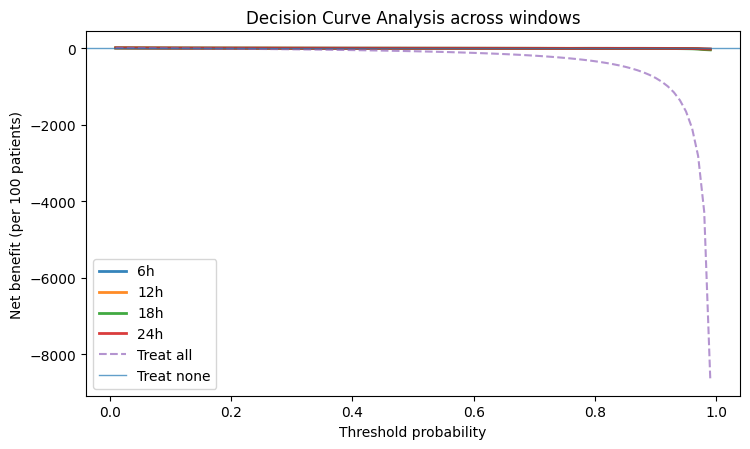

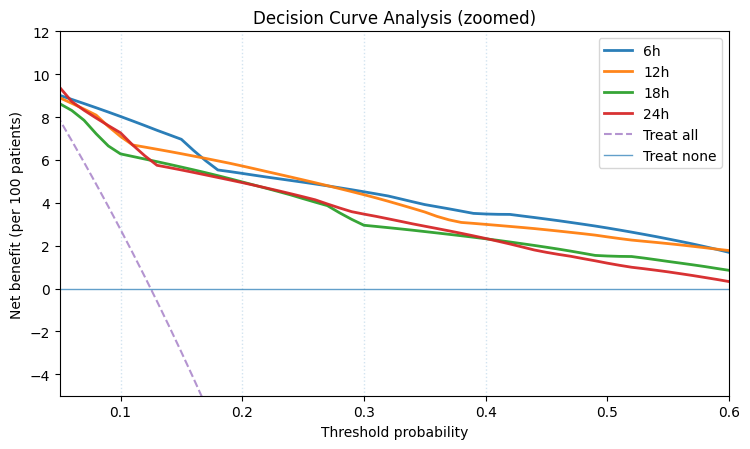

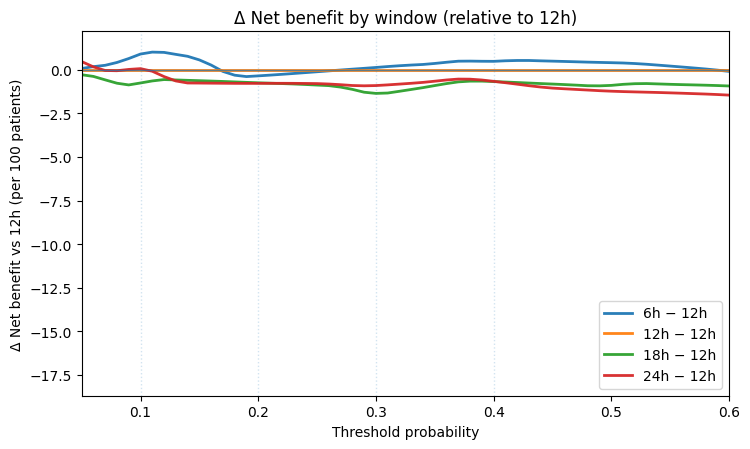


✓ Outputs
  Tables:
   - D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_all_windows.csv
   - D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_6h.csv
   - D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_12h.csv
   - D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_18h.csv
   - D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableG_dca_24h.csv
  Figures:
   - D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig6_dca_all_windows.png
   - D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig6_dca_zoom.png
   - D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig6_dca_delta_vs_12h.png


In [ ]:
#  Sentinel-ICU • One-cell DCA generator 
# - Computes eICU probabilities per window using imputer + calibrator
# - Normalizes features_w*.txt (one per line) to avoid shape mismatches
# - Writes one clean set of outputs (overwrites old DCA tables/figures)
# - Plots BMC-style DCA with zoom + optional Δ net benefit vs 12h panel

from pathlib import Path
import numpy as np, pandas as pd, re, json, joblib, shutil, glob
import matplotlib.pyplot as plt

# --------- config (adjust only if needed) ------------------------------------
ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
MODELS = ROOT / "outputs" / "external_validation" / "models"
FEAT   = ROOT / "outputs" / "features"

OUT_T  = ROOT / "manuscript" / "tables"
OUT_F  = ROOT / "manuscript" / "figures"
OUT_T.mkdir(parents=True, exist_ok=True)
OUT_F.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]
CLEAN_OLD = True            # remove old tableG_dca_*.csv and fig6_dca_*.png first
THRESH_GRID = np.linspace(0.01, 0.99, 99)   # standard DCA grid
ZOOM_X = (0.05, 0.60)       # zoomed x-range to separate overlapping lines
ZOOM_Y = (-5, 12)           # zoomed y-range (per 100 pts)
CLINICAL_GUIDES = [0.1, 0.2, 0.3, 0.4]      # faint vertical guides on zoom
MAKE_DELTA_VS_12H = True    # add Δ net benefit vs 12h plot
SMOOTH_WINDOW = 3           # rolling smoothing points (>=1; 1 = no smoothing)
# -----------------------------------------------------------------------------

# Optional tidy-up of older outputs
if CLEAN_OLD:
    for p in glob.glob(str(OUT_T / "tableG_dca_*")): 
        try: Path(p).unlink()
        except: pass
    for p in glob.glob(str(OUT_F / "fig6_dca_*")):
        try: Path(p).unlink()
        except: pass

# ---- feature utilities (robust) ---------------------------------------------
def _normalize_features_txt(w: int) -> list[str]:
    """
    Ensures features_w*.txt is one feature per line (fix for shape mismatch).
    If params_w*.json contains 'features', it takes precedence.
    """
    params = MODELS / f"params_w{w}.json"
    if params.exists():
        try:
            feats = json.loads(params.read_text(encoding="utf-8")).get("features", [])
            feats = [f.strip() for f in feats if str(f).strip()]
            if feats:
                (MODELS / f"features_w{w}.txt").write_text("\n".join(feats), encoding="utf-8")
                return feats
        except Exception:
            pass

    txt = (MODELS / f"features_w{w}.txt").read_text(encoding="utf-8", errors="ignore")
    # split on commas or whitespace, strip empties
    feats = [t.strip() for t in re.split(r"[,\s]+", txt) if t.strip()]
    (MODELS / f"features_w{w}.txt").write_text("\n".join(feats), encoding="utf-8")
    return feats

# ---- probability extraction --------------------------------------------------
def _get_probs_from_artifacts(w: int):
    """
    Loads imputer + calibrator, reads combined_w*.parquet (eICU rows),
    aligns features and returns (y_true, prob, features_used).
    """
    imp = joblib.load(MODELS / f"imputer_w{w}.pkl")
    cal = joblib.load(MODELS / f"calibrator_w{w}.pkl")
    feats = _normalize_features_txt(w)

    df = pd.read_parquet(FEAT / f"combined_w{w}.parquet")
    # ensure eICU subset
    src_col = "source" if "source" in df.columns else "dataset" if "dataset" in df.columns else None
    if src_col:
        eicu = df[df[src_col].astype(str).str.lower().eq("eicu")].copy()
    else:
        eicu = df.copy()

    # find label
    label_col = None
    for cand in ["label","hospital_expire_flag","y_true","outcome","death","mortality","hospital_death"]:
        if cand in eicu.columns:
            label_col = cand
            break
    if label_col is None:
        raise RuntimeError(f"[{w}h] No binary label in combined_w{w}.parquet")

    # require exact feature columns (after normalization)
    missing = [f for f in feats if f not in eicu.columns]
    if missing:
        raise RuntimeError(f"[{w}h] Missing features in combined_w{w}.parquet: {missing}")

    # build X in the trained order
    X = eicu[feats].apply(pd.to_numeric, errors="coerce")
    # imputer dimensionality check
    n_imp = int(getattr(imp, "statistics_", np.array([])).shape[0])
    if X.shape[1] != n_imp:
        raise RuntimeError(f"[{w}h] Feature shape mismatch: X has {X.shape[1]}, imputer expects {n_imp}")

    X_imp = imp.transform(X.values)

    # calibrated probabilities
    if hasattr(cal, "predict_proba"):
        p = cal.predict_proba(X_imp)[:, 1]
    elif hasattr(cal, "predict"):
        p = np.clip(np.asarray(cal.predict(X_imp)).ravel(), 0, 1)
    else:
        raise RuntimeError(f"[{w}h] Calibrator has no predict/predict_proba")

    y = pd.to_numeric(eicu[label_col], errors="coerce").fillna(0).astype(int).values
    return y, p, feats

# ---- decision curve analysis -------------------------------------------------
def decision_curve(y_true, prob, thresholds=THRESH_GRID):
    y = np.asarray(y_true).astype(int)
    p = np.asarray(prob).astype(float)
    N = len(y)
    prev = y.mean()

    rows = []
    for t in thresholds:
        pred = (p >= t).astype(int)
        TP = ((pred == 1) & (y == 1)).sum()
        FP = ((pred == 1) & (y == 0)).sum()
        # Net benefit per Vickers & Elkin (per patient)
        nb_model = (TP / N) - (FP / N) * (t / (1 - t))
        # Treat-all, treat-none references
        nb_all   = prev - (1 - prev) * (t / (1 - t))
        rows.append((t, nb_model*100.0, nb_all*100.0, 0.0))  # per 100 patients
    return pd.DataFrame(rows, columns=["threshold", "nb_model", "nb_all", "nb_none"])

def _maybe_smooth(y, k=SMOOTH_WINDOW):
    if k and k > 1:
        return pd.Series(y).rolling(k, center=True, min_periods=1).mean().values
    return y

# ---- main -------------------------------------------------------------------
curves = {}       # window -> DCA df
processed = []
failed = []

for w in WINDOWS:
    try:
        y, p, feats = _get_probs_from_artifacts(w)
        dca = decision_curve(y, p)
        if SMOOTH_WINDOW > 1:
            dca["nb_model"] = _maybe_smooth(dca["nb_model"], SMOOTH_WINDOW)
        dca["window"] = w
        dca.to_csv(OUT_T / f"tableG_dca_{w}h.csv", index=False)
        curves[w] = dca
        processed.append(w)
        print(f"[w{w}] n={len(y):,} | feats={len(feats)} | prob=[{p.min():.3f},{p.max():.3f}] → {OUT_T / f'tableG_dca_{w}h.csv'}")
    except Exception as e:
        print(f"[w{w}] ✗ {e}")
        failed.append(w)

if not curves:
    raise SystemExit("No DCA curves produced. Check errors above.")

# Combined table
comb = pd.concat(curves.values(), ignore_index=True)
comb.to_csv(OUT_T / "tableG_dca_all_windows.csv", index=False)

# --------- PLOTS --------------------------------------------------------------
# (A) Full threshold range
plt.figure(figsize=(7.6, 4.6))
for w in processed:
    d = curves[w]
    plt.plot(d["threshold"], d["nb_model"], label=f"{w}h", linewidth=2, alpha=0.9)
# references
w0 = processed[0]
plt.plot(curves[w0]["threshold"], curves[w0]["nb_all"], linestyle="--", linewidth=1.5, alpha=0.7, label="Treat all")
plt.axhline(0, linewidth=1, alpha=0.7, label="Treat none")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit (per 100 patients)")
plt.title("Decision Curve Analysis across windows")
plt.legend()
out_full = OUT_F / "fig6_dca_all_windows.png"
plt.tight_layout(); plt.savefig(out_full, dpi=300); plt.show()

# (B) Zoomed range with clinical guides
plt.figure(figsize=(7.6, 4.6))
for w in processed:
    d = curves[w]
    plt.plot(d["threshold"], d["nb_model"], label=f"{w}h", linewidth=2, alpha=0.95)
# references
plt.plot(curves[w0]["threshold"], curves[w0]["nb_all"], linestyle="--", linewidth=1.5, alpha=0.7, label="Treat all")
plt.axhline(0, linewidth=1, alpha=0.7, label="Treat none")
# clinical guides
for gx in CLINICAL_GUIDES:
    plt.axvline(gx, linestyle=":", linewidth=1, alpha=0.2)
plt.xlim(*ZOOM_X); plt.ylim(*ZOOM_Y)
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit (per 100 patients)")
plt.title("Decision Curve Analysis (zoomed)")
plt.legend()
out_zoom = OUT_F / "fig6_dca_zoom.png"
plt.tight_layout(); plt.savefig(out_zoom, dpi=300); plt.show()

# (C) Optional Δ net benefit vs 12h (helps separate curves visually)
if MAKE_DELTA_VS_12H and 12 in processed:
    base = curves[12][["threshold","nb_model"]].rename(columns={"nb_model":"base"})
    plt.figure(figsize=(7.6, 4.6))
    for w in processed:
        d = curves[w][["threshold","nb_model"]].merge(base, on="threshold", how="inner")
        d["delta"] = d["nb_model"] - d["base"]
        if SMOOTH_WINDOW > 1:
            d["delta"] = _maybe_smooth(d["delta"], SMOOTH_WINDOW)
        plt.plot(d["threshold"], d["delta"], label=f"{w}h − 12h", linewidth=2, alpha=0.95)
    plt.axhline(0, linewidth=1, alpha=0.7)
    for gx in CLINICAL_GUIDES:
        plt.axvline(gx, linestyle=":", linewidth=1, alpha=0.2)
    plt.xlim(*ZOOM_X)
    plt.xlabel("Threshold probability")
    plt.ylabel("Δ Net benefit vs 12h (per 100 patients)")
    plt.title("Δ Net benefit by window (relative to 12h)")
    plt.legend()
    out_delta = OUT_F / "fig6_dca_delta_vs_12h.png"
    plt.tight_layout(); plt.savefig(out_delta, dpi=300); plt.show()
else:
    out_delta = None

print("\n✓ Outputs")
print("  Tables:")
print(f"   - {OUT_T / 'tableG_dca_all_windows.csv'}")
for w in processed:
    print(f"   - {OUT_T / f'tableG_dca_{w}h.csv'}")
print("  Figures:")
print(f"   - {out_full}")
print(f"   - {out_zoom}")
if out_delta:
    print(f"   - {out_delta}")
if failed:
    print(f"\n⚠️ Windows failed: {failed}")


In [ ]:
# Robust hospital meta-analysis for AUROC 
# Saves tables + forest plots for 6/12/18/24h
# Filters small hospitals 
# DeLong SE per hospital
# Random-effects meta-analysis on logit(AUROC) (DerSimonian–Laird)
# Also reports a within-site (stratified) AUROC
#
# Outputs:
#   manuscript/tables/site_auc_filtered_w{6|12|18|24}h.csv
#   manuscript/figures/fig_site_forest_filtered_w{6|12|18|24}h.png
#   manuscript/tables/site_meta_summary.csv (one row per window)

from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle, gzip, warnings

# ---------- paths ----------
ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")
RES  = ROOT / "outputs" / "external_validation" / "results"
FEAT = ROOT / "outputs" / "features"
MODELS = ROOT / "outputs" / "external_validation" / "models"
EICU_DIR = ROOT / "eicu"
TAB = ROOT / "manuscript" / "tables"
FIG = ROOT / "manuscript" / "figures"
TAB.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]
MIN_POS = 20   # filter: at least 20 deaths
MIN_NEG = 20   # and at least 20 survivors
EPS = 1e-6     

# ---------- DeLong variance helpers (vectorized midranks implementation) ----------
# Adapted from the standard DeLong approach (AUC variance)
def _compute_midrank(x):
    # returns midranks for x
    order = np.argsort(x)
    x_sorted = x[order]
    J = len(x)
    midranks = np.zeros(J, dtype=float)
    i = 0
    while i < J:
        j = i
        while j < J and x_sorted[j] == x_sorted[i]:
            j += 1
        mid = 0.5*(i + j - 1) + 1  # 1-based midrank
        midranks[i:j] = mid
        i = j
    out = np.empty(J, dtype=float)
    out[order] = midranks
    return out

def _fast_delong(y_true, y_score):
    # y_true in {0,1}, y_score continuous
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    pos = y_score[y_true == 1]
    neg = y_score[y_true == 0]
    m, n = len(pos), len(neg)
    if m == 0 or n == 0:
        return np.nan, np.nan
    # midranks on concatenated scores
    all_scores = np.concatenate([pos, neg])
    mr_all = _compute_midrank(all_scores)
    mr_pos = _compute_midrank(pos)
    mr_neg = _compute_midrank(neg)
    V10 = (mr_all[:m] - mr_pos) / n
    V01 = 1.0 - (mr_all[m:] - mr_neg) / m
    auc = (V10.sum() / m)
    # DeLong variance
    s10 = np.var(V10, ddof=1)
    s01 = np.var(V01, ddof=1)
    var = s10 / m + s01 / n
    return auc, max(var, 1e-12)

# ---------- RE meta-analysis on logit(AUC) (DerSimonian–Laird) ----------
def _logit(p):
    p = np.clip(p, EPS, 1-EPS)
    return np.log(p/(1-p))

def _inv_logit(x):
    return 1.0/(1.0 + np.exp(-x))

def meta_random_effects_logit_auc(aucs, var_auc):
    aucs = np.asarray(aucs, float)
    var_auc = np.asarray(var_auc, float)
    m = np.isfinite(aucs) & np.isfinite(var_auc) & (var_auc > 0)
    aucs = aucs[m]; var_auc = var_auc[m]
    if aucs.size == 0:
        return None
    # delta method: var(logit(AUC)) ≈ var(AUC) / [AUC*(1-AUC)]^2
    lg = _logit(aucs)
    deriv = 1.0 / (aucs*(1-aucs))
    var_lg = var_auc * (deriv**2)
    w = 1.0/var_lg
    # FE summary on logit scale
    theta_fe = np.sum(w*lg)/np.sum(w)
    Q = np.sum(w*(lg - theta_fe)**2)
    df = len(lg) - 1
    C = np.sum(w) - (np.sum(w**2)/np.sum(w))
    tau2 = max(0.0, (Q-df)/C) if C > 0 else 0.0
    w_re = 1.0/(var_lg + tau2)
    theta_re = np.sum(w_re*lg)/np.sum(w_re)
    se_re = np.sqrt(1.0/np.sum(w_re))
    ci_low_lg = theta_re - 1.96*se_re
    ci_high_lg = theta_re + 1.96*se_re
    pooled_auc = _inv_logit(theta_re)
    ci_low = _inv_logit(ci_low_lg)
    ci_high = _inv_logit(ci_high_lg)
    I2 = float(max(0.0, (Q-df)/Q)*100) if Q > 0 else 0.0
    return {
        "k": int(len(lg)),
        "theta_re_logit": float(theta_re),
        "pooled_auc": float(pooled_auc),
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "Q": float(Q),
        "df": int(df),
        "I2": float(I2),
        "tau2_logit": float(tau2)
    }

# ---------- Plot ----------
def forest_plot_site_auc(df_sites, pooled, title, out_png):
    if df_sites.empty:
        warnings.warn(f"No eligible hospitals to plot for {title}")
        return
    d = df_sites.sort_values("AUROC")
    y = np.arange(len(d))
    auc = d["AUROC"].values
    se = d["SE"].values
    ci_lo = np.clip(auc - 1.96*se, 0.5, 1.0)
    ci_hi = np.clip(auc + 1.96*se, 0.5, 1.0)
    labels = [f"H{int(h)} (n={int(n)}, pos={int(p)})"
              for h,n,p in zip(d["hospitalid"], d["N"], d["Pos"])]

    plt.figure(figsize=(9.2, max(4, 0.24*len(d)+1)))
    plt.hlines(y, ci_lo, ci_hi, lw=2)
    plt.plot(auc, y, "o", markersize=5)
    ytick = y; ylab = labels

    if pooled is not None:
        y0 = -1.8
        plt.hlines(y0, pooled["ci_low"], pooled["ci_high"], lw=4, color="tab:red")
        plt.plot([pooled["pooled_auc"]], [y0], "s", color="tab:red", markersize=8)
        ytick = np.concatenate([[y0], y])
        ylab = ["Pooled (RE, logit)"] + labels

    plt.yticks(ytick, ylab)
    plt.xlabel("AUROC"); plt.xlim(0.5, 1.0)
    plt.title(title)
    plt.grid(axis="x", alpha=0.25)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

# ---------- Rebuild preds CSV with hospitalid if missing ----------
def ensure_preds_with_hospitalid(window_h: int) -> Path:
    preds = RES / f"eicu_preds_{window_h}h.csv"
    if preds.exists():
        df = pd.read_csv(preds)
        if {"hospitalid"}.issubset(df.columns):
            return preds
        # else fall-through to rebuild
    print(f"⚠️ {preds.name} missing 'hospitalid' → rebuilding from combined + artifacts")
    comb = FEAT / f"combined_w{window_h}.parquet"
    if not comb.exists():
        raise FileNotFoundError(f"Missing {comb}")
    dfc = pd.read_parquet(comb)
    eicu = dfc[dfc["source"].str.lower().eq("eicu")].copy()

    # Load features + imputer + calibrator
    feats_txt = MODELS / f"features_w{window_h}.txt"
    imputer_pkl = MODELS / f"imputer_w{window_h}.pkl"
    calibr_pkl = MODELS / f"calibrator_w{window_h}.pkl"
    if not feats_txt.exists():
        raise FileNotFoundError(feats_txt)
    features = [s.strip() for s in feats_txt.read_text().split(",") if s.strip()]
    with open(imputer_pkl, "rb") as f:
        imputer = pickle.load(f)
    with open(calibr_pkl, "rb") as f:
        calibrator = pickle.load(f)

    X = eicu[features].copy()
    X_imp = imputer.transform(X.values)
    # Try predict_proba then predict
    if hasattr(calibrator, "predict_proba"):
        proba = calibrator.predict_proba(X_imp)[:,1]
    else:
        proba = calibrator.predict(X_imp).astype(float)

    out = pd.DataFrame({
        "stay_id": eicu["stay_id"].values,
        "label": eicu["hospital_expire_flag"].astype(int).values,
        "mortality_probability": proba
    })

    # Map hospitalid from eICU patient.csv.gz using stay_id==patientunitstayid
    pat_csv = EICU_DIR / "patient.csv.gz"
    if not pat_csv.exists():
        raise FileNotFoundError(pat_csv)
    # read only needed cols
    df_pat = pd.read_csv(pat_csv, usecols=["patientunitstayid", "hospitalid"])
    out = out.merge(df_pat.rename(columns={"patientunitstayid": "stay_id"}),
                    on="stay_id", how="left")
    out.to_csv(preds, index=False)
    print(f"✓ (re)built {preds} with hospitalid (n={len(out)})")
    return preds

# ---------- Within-site (stratified) AUROC ----------
def stratified_within_site_auc(df):
    tot_pairs = 0
    concord = 0
    ties = 0
    for hid, g in df.dropna(subset=["hospitalid"]).groupby("hospitalid"):
        y = g["label"].astype(int).values
        p = g["mortality_probability"].astype(float).values
        pos = p[y==1]; neg = p[y==0]
        if len(pos)==0 or len(neg)==0: continue
        P, N = len(pos), len(neg)
        tot_pairs += P*N
        vp = pos.reshape(-1,1); vn = neg.reshape(1,-1)
        concord += (vp > vn).sum()
        ties    += (vp == vn).sum()
    if tot_pairs == 0: return np.nan
    return (concord + 0.5*ties) / tot_pairs

# ---------- Main loop ----------
summary_rows = []
for w in WINDOWS:
    preds = ensure_preds_with_hospitalid(w)
    df = pd.read_csv(preds)
    # overall sanity check
    overall = roc_auc_score(df["label"].astype(int), df["mortality_probability"].astype(float))
    # per-hospital
    site_rows = []
    for hid, g in df.dropna(subset=["hospitalid"]).groupby("hospitalid"):
        y = g["label"].astype(int).values
        p = g["mortality_probability"].astype(float).values
        n1, n0 = int(y.sum()), int((1-y).sum())
        if (n1 < MIN_POS) or (n0 < MIN_NEG):
            continue
        try:
            auc_h, var_h = _fast_delong(y, p)   # DeLong AUROC & var
            auc_h = float(np.clip(auc_h, 0.5+EPS, 1-EPS))
            se_h = float(np.sqrt(var_h))
        except Exception:
            continue
        site_rows.append({
            "hospitalid": int(hid),
            "N": int(len(g)),
            "Pos": n1,
            "Neg": n0,
            "AUROC": auc_h,
            "SE": se_h,
            "CI_low": max(0.5, auc_h - 1.96*se_h),
            "CI_high": min(1.0, auc_h + 1.96*se_h),
        })
    site_df = pd.DataFrame(site_rows).sort_values("N", ascending=False)
    out_csv = TAB / f"site_auc_filtered_w{w}h.csv"
    site_df.to_csv(out_csv, index=False)

    pooled = None
    if not site_df.empty:
        pooled = meta_random_effects_logit_auc(site_df["AUROC"].values,
                                               (site_df["SE"].values**2))
    forest_png = FIG / f"fig_site_forest_filtered_w{w}h.png"
    forest_title = f"Hospital AUROC (eICU, {w}h) — filtered (≥{MIN_POS} pos & ≥{MIN_NEG} neg)"
    forest_plot_site_auc(site_df, pooled, forest_title, forest_png)

    within_site_auc = stratified_within_site_auc(df)

    print(f"[{w}h] overall={overall:.3f} | eligible hospitals={len(site_df)}")
    if pooled:
        print(f"      pooled RE (logit)={pooled['pooled_auc']:.3f} "
              f"[{pooled['ci_low']:.3f},{pooled['ci_high']:.3f}] | I²={pooled['I2']:.1f}%")
    print(f"      within-site stratified AUROC={within_site_auc:.3f}")
    print(f"      → {out_csv}\n      → {forest_png}")

    summary_rows.append({
        "window_h": w,
        "overall_eICU_AUROC": overall,
        "eligible_hospitals": len(site_df),
        "pooled_RE_AUROC": pooled["pooled_auc"] if pooled else np.nan,
        "pooled_CI_low": pooled["ci_low"] if pooled else np.nan,
        "pooled_CI_high": pooled["ci_high"] if pooled else np.nan,
        "I2_percent": pooled["I2"] if pooled else np.nan,
        "within_site_stratified_AUROC": within_site_auc
    })

# Write summary across windows
pd.DataFrame(summary_rows).to_csv(TAB / "site_meta_summary.csv", index=False)
print(f"✓ Saved summary → {TAB / 'site_meta_summary.csv'}")


[6h] overall=0.857 | eligible hospitals=36
      pooled RE (logit)=0.850 [0.838,0.862] | I²=9.6%
      within-site stratified AUROC=0.860
      → D:\个人文件夹\Sanwal\ICU\manuscript\tables\site_auc_filtered_w6h.csv
      → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_site_forest_filtered_w6h.png
[12h] overall=0.864 | eligible hospitals=33
      pooled RE (logit)=0.861 [0.849,0.872] | I²=11.7%
      within-site stratified AUROC=0.869
      → D:\个人文件夹\Sanwal\ICU\manuscript\tables\site_auc_filtered_w12h.csv
      → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_site_forest_filtered_w12h.png
[18h] overall=0.835 | eligible hospitals=32
      pooled RE (logit)=0.836 [0.825,0.848] | I²=0.0%
      within-site stratified AUROC=0.837
      → D:\个人文件夹\Sanwal\ICU\manuscript\tables\site_auc_filtered_w18h.csv
      → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_site_forest_filtered_w18h.png
[24h] overall=0.825 | eligible hospitals=29
      pooled RE (logit)=0.818 [0.800,0.835] | I²=40.7%
      within-site strati

In [ ]:
# Fairness + Calibration
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
FEAT   = ROOT / "outputs" / "features"
RES    = ROOT / "outputs" / "external_validation" / "results"
MODELS = ROOT / "outputs" / "external_validation" / "models"
EICU   = ROOT / "eicu" / "patient.csv.gz"
TAB    = ROOT / "manuscript" / "tables";  TAB.mkdir(parents=True, exist_ok=True)
FIG    = ROOT / "manuscript" / "figures"; FIG.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]
EPS = 1e-8

# --- small helper: logistic calibration (intercept & slope) via IRLS ---
def _logit(p):
    p = np.clip(p, EPS, 1-EPS)
    return np.log(p/(1-p))

def calibr_slope_intercept(y, p, max_iter=50, tol=1e-8):
    """
    Fit logistic regression: y ~ intercept + slope * logit(p)
    Returns (intercept, slope). IRLS; no sklearn/statsmodels required.
    """
    y = np.asarray(y, dtype=float)
    p = np.asarray(p, dtype=float)
    x = _logit(p)
    X = np.column_stack([np.ones_like(x), x])  # [intercept, slope]
    beta = np.zeros(2, dtype=float)
    for _ in range(max_iter):
        z = X @ beta
        mu = 1.0 / (1.0 + np.exp(-z))
        W = mu * (1.0 - mu) + EPS
        # IRLS step: beta_new = beta + (X^T W X)^-1 X^T (y-mu)
        XT_W = X.T * W
        H = XT_W @ X
        g = X.T @ (y - mu)
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            break
        beta_new = beta + step
        if np.linalg.norm(step) < tol:
            beta = beta_new
            break
        beta = beta_new
    return float(beta[0]), float(beta[1])

def ece_bins(y, p, n_bins=10):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    bins = pd.qcut(p, q=n_bins, duplicates="drop")
    df = pd.DataFrame({"y": y, "p": p, "bin": bins})
    grp = df.groupby("bin", observed=True)
    out = grp.agg(n=("y","size"),
                  mean_p=("p","mean"),
                  obs=("y","mean")).reset_index(drop=True)
    out["abs_gap"] = np.abs(out["obs"] - out["mean_p"])
    ece = np.average(out["abs_gap"], weights=out["n"])
    return ece, out

def tpr_fpr_at_threshold(y, p, thr):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    pred = (p >= thr).astype(int)
    TP = ((pred==1) & (y==1)).sum()
    FP = ((pred==1) & (y==0)).sum()
    TN = ((pred==0) & (y==0)).sum()
    FN = ((pred==0) & (y==1)).sum()
    tpr = TP / max(TP+FN, 1)
    fpr = FP / max(FP+TN, 1)
    return float(tpr), float(fpr), int(TP), int(FP), int(TN), int(FN)

def _read_threshold(w):
    p = MODELS / f"threshold_w{w}.csv"
    if p.exists():
        try:
            return float(pd.read_csv(p).iloc[0]["threshold"])
        except Exception:
            pass
    return None  # will still compute metrics without a hard operating point

def _prep_window(w):
    # predictions (must have: stay_id, label, mortality_probability)
    preds_csv = RES / f"eicu_preds_{w}h.csv"
    if not preds_csv.exists():
        raise FileNotFoundError(preds_csv)
    pred = pd.read_csv(preds_csv)

    # features parquet (for age_years) – eICU subset only
    feat_pq = FEAT / f"combined_w{w}.parquet"
    if not feat_pq.exists():
        raise FileNotFoundError(feat_pq)
    feat = pd.read_parquet(feat_pq)
    feat = feat[feat["source"].astype(str).str.lower().eq("eicu")].copy()

    # pull age
    if "stay_id" not in feat.columns:
        raise ValueError(f"{feat_pq} missing stay_id")
    cols = ["stay_id","age_years"]
    cols = [c for c in cols if c in feat.columns]
    feat = feat[cols].drop_duplicates("stay_id")

    # gender from eICU patient.csv.gz
    eicu_pat = pd.read_csv(EICU, usecols=["patientunitstayid","gender"])
    eicu_pat = eicu_pat.rename(columns={"patientunitstayid":"stay_id"})

    # merge everything
    df = pred.merge(feat, on="stay_id", how="left").merge(eicu_pat, on="stay_id", how="left")
    # Normalize gender labels
    df["gender"] = df["gender"].astype(str).str.strip().str.upper().map(
        {"M":"Male","MALE":"Male","F":"Female","FEMALE":"Female"}
    ).fillna("Unknown")
    # Age bins
    df["age_group"] = np.where(df["age_years"]>=65, "≥65", "<65")
    return df

def _reliability_plot(df, by, title, out_png):
    plt.figure(figsize=(6.6, 4.2))
    groups = df[by].dropna().unique().tolist()
    groups = [g for g in groups if g != "Unknown"] or ["All"]
    colors = None  # default cycle

    for g in groups:
        sub = df[df[by]==g] if g!="All" else df
        if len(sub) < 50:
            continue
        ece, bins = ece_bins(sub["label"], sub["mortality_probability"], n_bins=10)
        # step curve
        xs = bins["mean_p"].values
        ys = bins["obs"].values
        order = np.argsort(xs)
        plt.plot(xs[order], ys[order], marker="o", label=f"{g} (ECE={ece:.03f})")

    # reference line
    plt.plot([0,1],[0,1], ls="--", lw=1, color="gray", label="Perfect calibration")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed event rate")
    plt.title(title)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

# ---------- main ----------
summary_rows = []
for w in WINDOWS:
    try:
        df = _prep_window(w)
        thr = _read_threshold(w)

        y = df["label"].astype(int).values
        p = df["mortality_probability"].astype(float).values

        # Overall metrics
        auroc = roc_auc_score(y, p)
        auprc = average_precision_score(y, p)
        brier = brier_score_loss(y, p)
        intercept, slope = calibr_slope_intercept(y, p)
        ece, eceb = ece_bins(y, p, n_bins=10)

        # Save calib bins table
        eceb.assign(window_h=w).to_csv(TAB / f"calibration_bins_w{w}h.csv", index=False)

        # Fairness splits
        rows = []
        for group_name, series in {
            "All": pd.Series(["All"]*len(df), index=df.index),
            "age_group": df["age_group"],
            "gender": df["gender"].replace("Unknown", np.nan)  # drop unknown from fairness summaries
        }.items():
            for gval, sub in df.loc[series.dropna().index].groupby(series.dropna()):
                y_g = sub["label"].astype(int).values
                p_g = sub["mortality_probability"].astype(float).values
                if len(y_g) < 50 or len(np.unique(y_g)) < 2:
                    # too small / degenerate, skip
                    continue
                auroc_g = roc_auc_score(y_g, p_g)
                auprc_g = average_precision_score(y_g, p_g)
                brier_g = brier_score_loss(y_g, p_g)
                icpt_g, slope_g = calibr_slope_intercept(y_g, p_g)
                ece_g, _ = ece_bins(y_g, p_g, n_bins=10)
                tpr=fpr=TP=FP=TN=FN=np.nan
                if thr is not None:
                    tpr, fpr, TP, FP, TN, FN = tpr_fpr_at_threshold(y_g, p_g, thr)
                rows.append({
                    "window_h": w,
                    "group_type": group_name,
                    "group": gval,
                    "N": int(len(sub)),
                    "Prevalence": float(y_g.mean()),
                    "AUROC": float(auroc_g),
                    "AUPRC": float(auprc_g),
                    "Brier": float(brier_g),
                    "Calib_intercept": icpt_g,
                    "Calib_slope": slope_g,
                    "ECE_10bin": float(ece_g),
                    "TPR_at_thr": tpr,
                    "FPR_at_thr": fpr,
                    "TP": TP, "FP": FP, "TN": TN, "FN": FN
                })

        # Write per-window fairness table
        fair_df = pd.DataFrame(rows)
        fair_csv = TAB / f"fairness_calibration_w{w}h.csv"
        fair_df.to_csv(fair_csv, index=False)

        # Reliability plots
        _reliability_plot(df, by="age_group",
                          title=f"Calibration by age (eICU, {w}h)",
                          out_png=FIG / f"fig_calibration_age_w{w}h.png")
        _reliability_plot(df, by="gender",
                          title=f"Calibration by gender (eICU, {w}h)",
                          out_png=FIG / f"fig_calibration_gender_w{w}h.png")

        # Quick bar of AUROC by subgroup (age & gender)
        fig_bar = FIG / f"fig_auroc_subgroups_w{w}h.png"
        sub_auc = fair_df[fair_df["group_type"].isin(["age_group","gender"])]
        if not sub_auc.empty:
            plt.figure(figsize=(6.8, 3.8))
            for i, (gt, gdf) in enumerate(sub_auc.groupby("group_type")):
                gdf = gdf.sort_values("AUROC", ascending=False)
                plt.bar([f"{gt}:{g}" for g in gdf["group"]], gdf["AUROC"])
            plt.xticks(rotation=30, ha="right")
            plt.ylim(0.6, 0.95); plt.ylabel("AUROC")
            plt.title(f"Subgroup AUROC (eICU, {w}h)")
            plt.tight_layout(); plt.savefig(fig_bar, dpi=300); plt.close()

        # Add overall row to summary
        summary_rows.append({
            "window_h": w,
            "N_eICU": int(len(df)),
            "Prevalence": float(y.mean()),
            "AUROC": float(auroc),
            "AUPRC": float(auprc),
            "Brier": float(brier),
            "Calib_intercept": intercept,
            "Calib_slope": slope,
            "ECE_10bin": float(ece),
            "thr_used": thr
        })

        print(f"[{w}h] N={len(df)} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | "
              f"Brier={brier:.3f} | slope={slope:.3f} | intercept={intercept:.3f} | ECE={ece:.3f}")
        print(f"     → {fair_csv}")
        print(f"     → {FIG / f'fig_calibration_age_w{w}h.png'}")
        print(f"     → {FIG / f'fig_calibration_gender_w{w}h.png'}")
        print(f"     → {FIG / f'fig_auroc_subgroups_w{w}h.png'}")

    except Exception as e:
        print(f"[{w}h] ✗ {e}")

# Write overall summary across windows
if summary_rows:
    pd.DataFrame(summary_rows).to_csv(TAB / "fairness_calibration_summary.csv", index=False)
    print("✓ Saved:", TAB / "fairness_calibration_summary.csv")


[6h] N=19182 | AUROC=0.857 | AUPRC=0.546 | Brier=0.077 | slope=0.169 | intercept=-0.908 | ECE=0.043
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\fairness_calibration_w6h.csv
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_age_w6h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_gender_w6h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_auroc_subgroups_w6h.png
[12h] N=18523 | AUROC=0.864 | AUPRC=0.535 | Brier=0.076 | slope=0.249 | intercept=-1.067 | ECE=0.026
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\fairness_calibration_w12h.csv
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_age_w12h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_gender_w12h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_auroc_subgroups_w12h.png
[18h] N=17245 | AUROC=0.835 | AUPRC=0.453 | Brier=0.087 | slope=0.170 | intercept=-1.243 | ECE=0.044
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\fairness_calibration_w18h.csv
     → D:\个人文件夹\Sanwa

In [69]:
# === Thresholded subgroup metrics with robust gender handling ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
RES    = ROOT / "outputs" / "external_validation" / "results"
MODELS = ROOT / "outputs" / "external_validation" / "models"
FEAT   = ROOT / "outputs" / "features"
TAB    = ROOT / "manuscript" / "tables";  TAB.mkdir(parents=True, exist_ok=True)
FIG    = ROOT / "manuscript" / "figures"; FIG.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]

def _thr(w):
    p = MODELS / f"threshold_w{w}.csv"
    if p.exists():
        try:
            return float(pd.read_csv(p).iloc[0]["threshold"])
        except Exception:
            pass
    # fallbacks you used earlier
    return {6:0.143, 12:0.360, 18:0.250, 24:0.112}.get(w, 0.36)

def _safe_rate(num, den):
    return float(num/den) if den and den > 0 else np.nan

def _gender_labels(df: pd.DataFrame) -> np.ndarray:
    """
    Returns array of 'Male'/'Female'/'Unknown' with same length as df.
    Tries several column names; if none found, returns all 'Unknown'.
    """
    cand_cols = [c for c in ["gender","sex","Gender","Sex"] if c in df.columns]
    if not cand_cols:
        return np.full(len(df), "Unknown", dtype=object)
    s = df[cand_cols[0]].astype(str).str.strip().str.lower()
    # common encodings
    male = s.isin(["m","male"])
    female = s.isin(["f","female"])
    out = np.full(len(s), "Unknown", dtype=object)
    out[male] = "Male"
    out[female] = "Female"
    # anything else stays 'Unknown'
    return out

all_rows = []

for w in WINDOWS:
    preds_csv = RES / f"eicu_preds_{w}h.csv"
    if not preds_csv.exists():
        print(f"[{w}h] ✗ Missing predictions CSV → {preds_csv}")
        continue

    preds = pd.read_csv(preds_csv)  # expects at least label, mortality_probability
    # bring in features for subgroups
    feat_parq = FEAT / f"combined_w{w}.parquet"
    if not feat_parq.exists():
        print(f"[{w}h] ✗ Missing features parquet → {feat_parq}")
        continue
    feats = pd.read_parquet(feat_parq)

    # Align rows:
    if "stay_id" in preds.columns and "stay_id" in feats.columns:
        df = preds.merge(feats[["stay_id","age_years"] + ([c for c in ["gender","sex"] if c in feats.columns])],
                         on="stay_id", how="left")
    else:
        # fallback: same cohort order
        df = preds.copy()
        for col in ["age_years","gender","sex"]:
            if col in feats.columns and col not in df.columns:
                df[col] = feats[col].values

    # Subgroup definitions (robust)
    age_group = np.where(pd.to_numeric(df["age_years"], errors="coerce").fillna(-1) >= 65, "≥65", "<65")
    gender_lbl = _gender_labels(df)

    thr = _thr(w)
    y   = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int).values
    p   = pd.to_numeric(df["mortality_probability"], errors="coerce").fillna(0).values
    pred = (p >= thr).astype(int)

    rows = []
    for sub_name, grp in [("age_group", age_group), ("gender", gender_lbl)]:
        for g in pd.Series(grp).unique():
            if g == "Unknown":   # skip if we truly don't have this info
                continue
            m = (grp == g)
            TP = int(((pred==1) & (y==1) & m).sum())
            FP = int(((pred==1) & (y==0) & m).sum())
            TN = int(((pred==0) & (y==0) & m).sum())
            FN = int(((pred==0) & (y==1) & m).sum())
            N  = int(m.sum())
            rows.append({
                "window_h": w,
                "subgroup": f"{sub_name}:{g}",
                "N": N,
                "TPR": _safe_rate(TP, TP+FN),   # sensitivity
                "TNR": _safe_rate(TN, TN+FP),   # specificity
                "PPV": _safe_rate(TP, TP+FP),
                "NPV": _safe_rate(TN, TN+FN),
                "Alerts_rate": _safe_rate(TP+FP, N)
            })

    out = pd.DataFrame(rows).sort_values(["subgroup"])
    out_path = TAB / f"tableH_thresholded_fairness_w{w}h.csv"
    out.to_csv(out_path, index=False)

    # quick visualization: TPR/TNR by subgroup
    if not out.empty:
        plt.figure(figsize=(8.2, 4.2))
        for metric in ["TPR","TNR"]:
            plt.plot(out["subgroup"], out[metric], marker="o", label=metric)
        plt.xticks(rotation=28, ha="right"); plt.ylim(0,1)
        plt.title(f"Thresholded fairness (eICU, {w}h) — thr={thr:.3f}")
        plt.ylabel("Rate"); plt.grid(axis="y", alpha=0.2); plt.legend()
        plt.tight_layout()
        plt.savefig(FIG / f"fig_fairness_thresholded_w{w}h.png", dpi=300)
        plt.close()

    all_rows.append(out)
    print(f"[{w}h] ✓ wrote {out_path} (rows={len(out)})")

if all_rows:
    pd.concat(all_rows, ignore_index=True).to_csv(TAB / "tableH_thresholded_fairness_all_windows.csv", index=False)
    print("✓ Combined table saved →", TAB / "tableH_thresholded_fairness_all_windows.csv")


[6h] ✓ wrote D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableH_thresholded_fairness_w6h.csv (rows=2)
[12h] ✓ wrote D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableH_thresholded_fairness_w12h.csv (rows=2)
[18h] ✓ wrote D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableH_thresholded_fairness_w18h.csv (rows=2)
[24h] ✓ wrote D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableH_thresholded_fairness_w24h.csv (rows=2)
✓ Combined table saved → D:\个人文件夹\Sanwal\ICU\manuscript\tables\tableH_thresholded_fairness_all_windows.csv


In [ ]:
# ==== Temporal validation with quantile time blocks ====
from pathlib import Path
import numpy as np, pandas as pd, joblib, json, pickle, math
import matplotlib.pyplot as plt

ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
MODELS = ROOT / "outputs" / "external_validation" / "models"
FEAT   = ROOT / "outputs" / "features"
TAB    = ROOT / "manuscript" / "tables";  TAB.mkdir(parents=True, exist_ok=True)
FIG    = ROOT / "manuscript" / "figures"; FIG.mkdir(parents=True, exist_ok=True)

WINDOWS = [6,12,18,24]
DATASETS_KEEP = {"eicu", "mimic"}   # keep only these datasets if 'source'/'dataset' present
MIN_BIN_N   = 800                    # fail-safe: min patients per temporal bin
MIN_BIN_POS = 20                     # min positives per bin
MIN_BIN_NEG = 20                     # min negatives per bin
MAX_BINS    = 12                     # upper bound of bins to try
MIN_BINS    = 5                      # lower bound (will fallback to one bin if needed)
SMOOTH_K    = 3                      # moving-average window for the line
ECE_BINS    = 10

# ---------- utilities ----------
def _load_pickle(p):
    try:
        return joblib.load(p)
    except Exception:
        with open(p, "rb") as f:
            return pickle.load(f)

def _load_artifacts(w):
    imp = _load_pickle(MODELS / f"imputer_w{w}.pkl")
    cal = _load_pickle(MODELS / f"calibrator_w{w}.pkl")
    # features: prefer params JSON, fallback TXT (1 per line or comma-separated)
    feats = None
    prm = MODELS / f"params_w{w}.json"
    if prm.exists():
        try:
            d = json.loads(prm.read_text(encoding="utf-8"))
            feats = [f.strip() for f in d.get("features", []) if str(f).strip()]
        except Exception:
            feats = None
    if not feats:
        raw = (MODELS / f"features_w{w}.txt").read_text(encoding="utf-8")
        feats = [t.strip() for t in raw.replace(",", "\n").splitlines() if t.strip()]
        # normalize the .txt to one-per-line to avoid future parsing issues
        (MODELS / f"features_w{w}.txt").write_text("\n".join(feats), encoding="utf-8")
    return imp, cal, feats

def _decision_metrics(y, p):
    from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
    auroc = float(roc_auc_score(y, p)) if len(np.unique(y))==2 else np.nan
    auprc = float(average_precision_score(y, p))
    brier = float(brier_score_loss(y, p))
    return auroc, auprc, brier

def _ece(y, p, bins=10):
    y = np.asarray(y).astype(int); p = np.asarray(p).astype(float)
    edges = np.linspace(0,1,bins+1)
    idx   = np.clip(np.digitize(p, edges, right=True)-1, 0, bins-1)
    ece = 0.0; n = len(y)
    for b in range(bins):
        m = (idx==b)
        if not m.any(): 
            continue
        obs = y[m].mean()
        conf = p[m].mean()
        ece += (m.mean()) * abs(obs - conf)
    return float(ece)

def _calib_slope_intercept_irls(y, p, max_iter=50, tol=1e-6):
    """Fit y ~ Bernoulli(sigmoid(a + b * logit(p))) via IRLS; returns (b,a)."""
    y = np.asarray(y, int)
    p = np.asarray(p, float).clip(1e-6, 1-1e-6)
    x = np.log(p/(1-p))
    X = np.column_stack([np.ones_like(x), x])  # [a, b]
    beta = np.array([0.0, 1.0])                # init intercept=0, slope=1
    for _ in range(max_iter):
        z = X @ beta
        mu = 1/(1+np.exp(-z))
        W  = mu*(1-mu) + 1e-12
        # IRLS step: beta <- beta + (X'WX)^-1 X'(y-mu)
        XT_W = X.T * W
        H = XT_W @ X
        g = XT_W @ (y - mu)
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            # ridge fallback
            step = np.linalg.solve(H + 1e-6*np.eye(2), g)
        beta_new = beta + step
        if np.max(np.abs(step)) < tol:
            beta = beta_new
            break
        beta = beta_new
    a, b = float(beta[0]), float(beta[1])
    return b, a

def _first_valid_time_column(df):
    """Return a Series for temporal ordering: year if available; else a datetime; else row-order."""
    # try (year-like) first
    for col in ["admit_year","admission_year","hosp_admit_year","year","anchor_year"]:
        if col in df.columns:
            s = pd.to_numeric(df[col], errors="coerce")
            # treat as year if plausible
            if s.notna().sum() > 0 and (s.min() >= 1900 or s.max() >= 1900):
                return s, True
    # then try timestamps
    for col in ["admittime","admission_time","admit_time","intime","icu_intime","icustay_intime","charttime","hospital_admittime"]:
        if col in df.columns:
            t = pd.to_datetime(df[col], errors="coerce")
            if t.notna().any():
                return t, False
    # fallback: monotonically increasing index (pre-sorted by something else)
    return pd.Series(np.arange(len(df)), index=df.index), False

def _temporal_bins_for_dataset(df_ds, n_max=MAX_BINS, n_min=MIN_BINS):
    """Return dataframe with 'temp_bin', 'x_center' ensuring min N/Pos/Neg; reduces bins if needed."""
    tcol, is_year = _first_valid_time_column(df_ds)
    # order
    order = np.argsort(tcol.values)
    df_ord = df_ds.iloc[order].reset_index(drop=True).copy()

    # how many bins can we support?
    n_try = min(n_max, max(n_min, int(len(df_ord) / (MIN_BIN_N or 1))))
    n_try = max(n_try, 1)
    ok_df = None
    while n_try >= 1:
        qs = np.linspace(0, 1, n_try+1)
        edges = (len(df_ord)*qs).round().astype(int)
        edges[-1] = len(df_ord)
        temp_bin = np.empty(len(df_ord), dtype=int)
        for i in range(n_try):
            temp_bin[edges[i]:edges[i+1]] = i
        df_ord["temp_bin"] = temp_bin

        # constraints
        good = True
        for b in range(n_try):
            m = df_ord["temp_bin"].eq(b)
            n  = int(m.sum())
            pos = int(df_ord.loc[m,"label"].sum())
            neg = n - pos
            if (n < MIN_BIN_N) or (pos < MIN_BIN_POS) or (neg < MIN_BIN_NEG):
                good = False; break
        if good:
            ok_df = df_ord; break
        n_try -= 1

    if ok_df is None:
        # just return one bin
        df_ord["temp_bin"] = 0
        n_try = 1
        ok_df = df_ord

    # x center: year mean if we have year with >1 unique; else use 1..K
    if is_year and tcol.nunique() > 1:
        # compute mean year per bin (handles weird large years too)
        xc = (ok_df.groupby("temp_bin")["admit_year"].mean()
              if "admit_year" in ok_df.columns else
              ok_df.groupby("temp_bin")[tcol.name].mean())
        # if datetime, convert to numeric year with .year
        if not np.issubdtype(xc.dtype, np.number):
            xc = pd.to_datetime(xc).dt.year
        x_map = {b: float(v) for b, v in xc.items()}
        xlabel = "Admission year (bin center)"
    else:
        x_map = {b: float(b+1) for b in range(n_try)}
        xlabel = "Temporal block (equal-size)"
    ok_df["x_center"] = ok_df["temp_bin"].map(x_map).astype(float)
    return ok_df, xlabel

def _moving_average(y, k=SMOOTH_K):
    if len(y) == 0: return y
    if k <= 1: return y
    z = pd.Series(y, dtype=float).rolling(k, center=True, min_periods=1).mean().values
    return z

def _calc_predictions(df, feats, imputer, calibrator):
    # strict feature subset
    missing = [f for f in feats if f not in df.columns]
    if missing:
        raise RuntimeError(f"Missing feature columns: {missing[:8]}{'...' if len(missing)>8 else ''}")
    X = df[feats].copy()
    X_imp = imputer.transform(X)
    if hasattr(calibrator, "predict_proba"):
        p = calibrator.predict_proba(X_imp)[:,1]
    else:
        p = np.asarray(calibrator.predict(X_imp)).ravel()
    return p

# ---------- main runner ----------
def run_temporal_bmc_style(w):
    # load artifacts + data
    imp, cal, feats = _load_artifacts(w)
    df = pd.read_parquet(FEAT / f"combined_w{w}.parquet").copy()

    # dataset tag
    src_col = "source" if "source" in df.columns else ("dataset" if "dataset" in df.columns else None)
    if src_col is None:
        df["dataset"] = "eicu"
        src_col = "dataset"
    df[src_col] = df[src_col].astype(str).str.lower()
    df = df[df[src_col].isin(DATASETS_KEEP)].copy()

    # label
    ycol = None
    for c in ["label","hospital_expire_flag","y_true","outcome","death","mortality","hospital_death"]:
        if c in df.columns: ycol = c; break
    if ycol is None:
        raise RuntimeError("No binary label column found.")
    df["label"] = pd.to_numeric(df[ycol], errors="coerce").fillna(0).astype(int)

    # predictions
    df["prob"] = _calc_predictions(df, feats, imp, cal)

    # split per dataset and build temporal bins
    all_rows = []
    for ds, d in df.groupby(df[src_col]):
        d = d.reset_index(drop=True)
        # keep column 'admit_year' if exists to help xlabel logic
        if "admit_year" not in d.columns:
            d["admit_year"] = np.nan
        d2, xlabel = _temporal_bins_for_dataset(d)
        d2["dataset"] = ds
        all_rows.append(d2)

    dx = pd.concat(all_rows, ignore_index=True)

    # metrics per bin
    rows = []
    for (ds, b), g in dx.groupby(["dataset","temp_bin"]):
        y = g["label"].values
        p = g["prob"].values
        auroc, auprc, brier = _decision_metrics(y, p)
        slope, intercept = _calib_slope_intercept_irls(y, p)
        ece = _ece(y, p, bins=ECE_BINS)
        rows.append({
            "window_h": w, "dataset": ds, "temp_bin": int(b),
            "x_center": float(g["x_center"].mean()),
            "N": int(len(g)), "Pos": int(y.sum()), "Neg": int(len(y)-y.sum()),
            "AUROC": auroc, "AUPRC": auprc, "Brier": brier,
            "slope": slope, "intercept": intercept, "ECE": ece
        })
    M = pd.DataFrame(rows).sort_values(["dataset","temp_bin"]).reset_index(drop=True)
    out_csv = TAB / f"temporal_metrics_w{w}h.csv"
    M.to_csv(out_csv, index=False)

    # ---- plots (BMC style) ----
    def _style():
        plt.grid(axis="both", alpha=0.15, linestyle="-", linewidth=0.8)
        plt.tight_layout()

    # AUROC
    plt.figure(figsize=(11,5))
    for ds, g in M.groupby("dataset"):
        x = g["x_center"].values; y = g["AUROC"].values
        plt.scatter(x, y, s=55, alpha=0.35, label=ds.upper())
        plt.plot(x, _moving_average(y, k=SMOOTH_K), linewidth=2)
    plt.ylim(0.55, 1.00); plt.xlim(M["x_center"].min()-0.5, M["x_center"].max()+0.5)
    plt.xlabel(xlabel); plt.ylabel("AUROC"); plt.title(f"Temporal AUROC by time (BMC style, {w}h)")
    plt.legend(frameon=False); _style()
    plt.savefig(FIG / f"fig_temporal_auroc_w{w}h.png", dpi=300); plt.close()

    # Brier + ECE
    plt.figure(figsize=(11,5))
    for ds, g in M.groupby("dataset"):
        x = g["x_center"].values
        b = g["Brier"].values; e = g["ECE"].values
        plt.plot(x, _moving_average(b, k=SMOOTH_K), linewidth=2, label=f"{ds.upper()} Brier")
        plt.plot(x, _moving_average(e, k=SMOOTH_K), linewidth=2, linestyle="--", label=f"{ds.upper()} ECE")
    plt.ylim(0.0, 0.25); plt.xlim(M["x_center"].min()-0.5, M["x_center"].max()+0.5)
    plt.xlabel(xlabel); plt.ylabel("Score"); plt.title(f"Temporal Brier / ECE (BMC style, {w}h)")
    plt.legend(frameon=False, ncol=2); _style()
    plt.savefig(FIG / f"fig_temporal_brier_ece_w{w}h.png", dpi=300); plt.close()

    # Calibration slope (winsorized for readability)
    plt.figure(figsize=(11,5))
    for ds, g in M.groupby("dataset"):
        x = g["x_center"].values
        s = g["slope"].clip(0, 2)  # winsorize extreme values to keep axis reasonable
        plt.plot(x, _moving_average(s, k=SMOOTH_K), linewidth=2, label=ds.upper())
        plt.scatter(x, s, s=35, alpha=0.25)
    plt.axhline(1.0, color="gray", linestyle="--", linewidth=1.2, label="Ideal slope=1")
    plt.ylim(0.0, 2.0); plt.xlim(M["x_center"].min()-0.5, M["x_center"].max()+0.5)
    plt.xlabel(xlabel); plt.ylabel("Calibration slope"); plt.title(f"Calibration slope over time (BMC style, {w}h)")
    plt.legend(frameon=False); _style()
    plt.savefig(FIG / f"fig_temporal_slope_w{w}h.png", dpi=300); plt.close()

    print(f"[{w}h] ✓ temporal metrics → {out_csv}")
    print(f"[{w}h] ✓ figs →",
          FIG / f"fig_temporal_auroc_w{w}h.png", ",",
          FIG / f"fig_temporal_brier_ece_w{w}h.png", ",",
          FIG / f"fig_temporal_slope_w{w}h.png")

# ---- run for all windows; save combined table ----
combined = []
for w in WINDOWS:
    try:
        run_temporal_bmc_style(w)
        combined.append(pd.read_csv(TAB / f"temporal_metrics_w{w}h.csv"))
    except Exception as e:
        print(f"[{w}h] ✗ temporal run failed: {e}")

if combined:
    pd.concat(combined, ignore_index=True).to_csv(TAB / "temporal_metrics_all_windows.csv", index=False)
    print("✓ Saved combined:", TAB / "temporal_metrics_all_windows.csv")


[6h] ✓ temporal metrics → D:\个人文件夹\Sanwal\ICU\manuscript\tables\temporal_metrics_w6h.csv
[6h] ✓ figs → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_auroc_w6h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_brier_ece_w6h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_slope_w6h.png
[12h] ✓ temporal metrics → D:\个人文件夹\Sanwal\ICU\manuscript\tables\temporal_metrics_w12h.csv
[12h] ✓ figs → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_auroc_w12h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_brier_ece_w12h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_slope_w12h.png
[18h] ✓ temporal metrics → D:\个人文件夹\Sanwal\ICU\manuscript\tables\temporal_metrics_w18h.csv
[18h] ✓ figs → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_auroc_w18h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_brier_ece_w18h.png , D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_slope_w18h.png
[24h] ✓ temporal metrics → D:\个人文件夹\Sanwal\ICU\manuscript\tab

In [220]:
# =========================
# Sentinel-ICU: One-shot analysis 
# =========================
# Produces, per window (6/12/18/24h):
#  • overall metrics w/ 95% CIs via stratified bootstrap
#  • operating points (0.5 and model threshold if available)
#  • site heterogeneity (per-hospital AUROC + RE meta on logit(AUC), I²)
#  • temporal performance 
#
# Skips re-doing fairness (age/gender) and DCA unless you flip toggles below.

from pathlib import Path
import os, re, json, gzip, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# --------- Paths (your tree) ----------
ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
MODELS = ROOT / "outputs" / "external_validation" / "models"
FEAT   = ROOT / "outputs" / "features"
RES    = ROOT / "outputs" / "external_validation" / "results"
EICU   = ROOT / "eicu"
MIMIC  = ROOT / "mimic"
TAB    = ROOT / "manuscript" / "tables";  TAB.mkdir(parents=True, exist_ok=True)
FIG    = ROOT / "manuscript" / "figures"; FIG.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]

# --------- Feature toggles ----------
DO_BOOTSTRAP_CI  = True     # overall 95% CIs
DO_OP_POINTS     = True     # operating-point metrics/mini-fig
DO_SITE_HET      = True     # per-hospital + random-effects meta-analysis
DO_TEMPORAL      = True     # BMC-style equal-count blocks (smooth lines)
DO_FAIRNESS      = False    # you already have subgroup figs/tables
DO_DCA           = False    # you already generated DCA

# Do not overwrite existing outputs
SKIP_IF_EXISTS   = True

# Filters / settings
MIN_POS = 20
MIN_NEG = 20
N_BOOT  = 400     # stratified bootstrap reps (tune for speed)
N_TEMP_BLOCKS = 8 # equal-count temporal blocks per dataset
EPS = 1e-6

# --------- Utils to avoid duplicates ----------
def _save_df(df: pd.DataFrame, path: Path):
    if SKIP_IF_EXISTS and path.exists():
        print("skip (exists):", path)
        return
    df.to_csv(path, index=False)
    print("✓ wrote:", path)

def _save_fig(fig_path: Path, save_fn):
    if SKIP_IF_EXISTS and fig_path.exists():
        print("skip (exists):", fig_path)
        return
    save_fn()
    print("✓ wrote:", fig_path)

# --------- Artifacts & features ----------
def _read_features_list(w: int):
    # Prefer JSON params if present
    pj = MODELS / f"params_w{w}.json"
    if pj.exists():
        try:
            feats = json.loads(pj.read_text(encoding="utf-8"))["features"]
            feats = [f.strip() for f in feats if f.strip()]
            if feats:
                return feats
        except Exception:
            pass
    # Fallback: text file (1 feature per line OR comma-separated)
    raw = (MODELS / f"features_w{w}.txt").read_text(encoding="utf-8", errors="ignore")
    lines = [ln.strip() for ln in raw.replace(",", "\n").splitlines() if ln.strip()]
    # self-heal to 1-per-line
    (MODELS / f"features_w{w}.txt").write_text("\n".join(lines), encoding="utf-8")
    return lines

import pickle
def _load_imputer_calibrator(w: int):
    with open(MODELS / f"imputer_w{w}.pkl", "rb") as f:
        imp = pickle.load(f)
    with open(MODELS / f"calibrator_w{w}.pkl", "rb") as f:
        cal = pickle.load(f)
    thr = None
    thrp = MODELS / f"threshold_w{w}.csv"
    if thrp.exists():
        try:
            thr = float(pd.read_csv(thrp).iloc[0]["threshold"])
        except Exception:
            thr = None
    return imp, cal, thr

# --------- Ensure predictions & hospitalid ----------
def ensure_eicu_preds_with_hospitalid(w: int) -> Path:
    out_csv = RES / f"eicu_preds_{w}h.csv"
    if out_csv.exists():
        try:
            chk = pd.read_csv(out_csv, nrows=5)
            if {"label","mortality_probability","hospitalid"}.issubset(chk.columns):
                return out_csv
        except Exception:
            pass

    feat_parq = FEAT / f"combined_w{w}.parquet"
    if not feat_parq.exists():
        raise FileNotFoundError(feat_parq)

    df = pd.read_parquet(feat_parq)
    df["source"] = df["source"].astype(str).str.lower()
    eicu = df[df["source"] == "eicu"].copy()

    # outcome → label
    y_col = None
    for c in ["label","hospital_expire_flag","y_true","outcome","death","mortality","hospital_death"]:
        if c in eicu.columns:
            y_col = c; break
    if y_col is None:
        raise RuntimeError(f"[{w}h] No binary label column in {feat_parq}")

    # predict
    feats = _read_features_list(w)
    imp, cal, _ = _load_imputer_calibrator(w)
    X = eicu[feats].apply(pd.to_numeric, errors="coerce")
    X_imp = imp.transform(X.values)
    if hasattr(cal, "predict_proba"):
        prob = cal.predict_proba(X_imp)[:,1]
    else:
        prob = np.clip(np.asarray(cal.predict(X_imp)).ravel(), 0, 1)

    out = pd.DataFrame({
        "stay_id": eicu["stay_id"].values,
        "label": pd.to_numeric(eicu[y_col], errors="coerce").fillna(0).astype(int),
        "mortality_probability": prob
    })

    # add hospitalid
    pat_csv = EICU / "patient.csv.gz"
    if not pat_csv.exists():
        raise FileNotFoundError(pat_csv)
    pat = pd.read_csv(pat_csv, usecols=["patientunitstayid","hospitalid"])
    out = out.merge(pat.rename(columns={"patientunitstayid":"stay_id"}), on="stay_id", how="left")

    out.to_csv(out_csv, index=False)
    print(f"✓ built {out_csv} (n={len(out)})")
    return out_csv

# --------- Metrics & calibration slope (no sklearn fit) ----------
def _ece(y, p, bins=10):
    y = np.asarray(y, int); p = np.asarray(p, float)
    q = np.linspace(0,1,bins+1)
    idx = np.clip(np.digitize(p, q, right=True)-1, 0, bins-1)
    ece = 0.0
    for b in range(bins):
        m = (idx==b)
        if not m.any(): 
            continue
        e_b = y[m].mean()
        p_b = p[m].mean()
        ece += abs(e_b - p_b) * m.mean()
    return float(ece)

def _calib_slope_intercept_irls(y, p, max_iter=50, tol=1e-8):
    # Fit logistic regression: y ~ 1 + logit(p) using IRLS
    y = np.asarray(y, int)
    p = np.clip(np.asarray(p, float), EPS, 1-EPS)
    x = np.log(p/(1-p)).reshape(-1,1)
    X = np.hstack([np.ones((len(y),1)), x])  # intercept + slope
    beta = np.zeros(2)  # init
    for _ in range(max_iter):
        z = X @ beta
        mu = 1/(1+np.exp(-z))
        W = mu*(1-mu)
        # guard against zeros
        W = np.clip(W, 1e-8, None)
        # weighted least squares step
        WX = X * W[:,None]
        H = WX.T @ X
        g = X.T @ (y - mu)
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            step = np.linalg.lstsq(H, g, rcond=None)[0]
        beta_new = beta + step
        if np.max(np.abs(step)) < tol:
            beta = beta_new; break
        beta = beta_new
    intercept, slope = float(beta[0]), float(beta[1])
    return slope, intercept

def _bootstrap_metrics(y, p, n_boot=N_BOOT, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, int); p = np.asarray(p, float)
    n = len(y)
    prev = y.mean()
    # stratified resample
    pos_idx = np.where(y==1)[0]; neg_idx = np.where(y==0)[0]
    m_pos, m_neg = len(pos_idx), len(neg_idx)

    def _metrics(yb, pb):
        return dict(
            AUROC = roc_auc_score(yb, pb),
            AUPRC = average_precision_score(yb, pb),
            Brier = brier_score_loss(yb, pb),
            ECE   = _ece(yb, pb, bins=10),
            slope = _calib_slope_intercept_irls(yb, pb)[0],
            intercept = _calib_slope_intercept_irls(yb, pb)[1],
            prevalence = float(np.mean(yb))
        )

    # point estimates
    pe = _metrics(y, p)
    # bootstrap CIs
    store = {k: [] for k in ["AUROC","AUPRC","Brier","ECE","slope","intercept","prevalence"]}
    for _ in range(n_boot):
        rs_pos = rng.choice(pos_idx, m_pos, replace=True)
        rs_neg = rng.choice(neg_idx, m_neg, replace=True)
        rs = np.concatenate([rs_pos, rs_neg])
        yb, pb = y[rs], p[rs]
        m = _metrics(yb, pb)
        for k in store:
            store[k].append(m[k])
    ci = {}
    for k, arr in store.items():
        lo, hi = np.percentile(arr, [2.5, 97.5])
        ci[k] = (float(lo), float(hi))
    return pe, ci

# --------- Operating points ----------
def _operating_points(y, p, thr_list):
    out=[]
    y = np.asarray(y, int); p = np.asarray(p, float)
    for thr in thr_list:
        pred = (p >= thr).astype(int)
        TP = int(((pred==1)&(y==1)).sum())
        FP = int(((pred==1)&(y==0)).sum())
        TN = int(((pred==0)&(y==0)).sum())
        FN = int(((pred==0)&(y==1)).sum())
        N = len(y)
        sens = TP / (TP+FN+EPS)
        spec = TN / (TN+FP+EPS)
        ppv  = TP / (TP+FP+EPS)
        npv  = TN / (TN+FN+EPS)
        f1   = 2*TP / (2*TP+FP+FN+EPS)
        alert_rate = (TP+FP)/N
        out.append(dict(
            threshold=thr, N=N, prevalence=float(y.mean()),
            TP=TP, FP=FP, TN=TN, FN=FN,
            sensitivity=sens, specificity=spec, PPV=ppv, NPV=npv, F1=f1, alerts_rate=alert_rate
        ))
    return pd.DataFrame(out)

# --------- DeLong per-site variance + RE meta on logit(AUC) ----------
def _midrank(x):
    order = np.argsort(x)
    x_sorted = x[order]
    J = len(x)
    midr = np.zeros(J, float)
    i=0
    while i<J:
        j=i
        while j<J and x_sorted[j]==x_sorted[i]:
            j+=1
        mid = 0.5*(i + j - 1) + 1
        midr[i:j] = mid
        i=j
    out = np.empty(J, float); out[order]=midr
    return out

def delong_auc_var(y, s):
    y = np.asarray(y, int); s = np.asarray(s, float)
    pos = s[y==1]; neg = s[y==0]
    m, n = len(pos), len(neg)
    if m==0 or n==0: return np.nan, np.nan
    all_scores = np.concatenate([pos, neg])
    mr_all = _midrank(all_scores)
    mr_pos = _midrank(pos)
    mr_neg = _midrank(neg)
    V10 = (mr_all[:m] - mr_pos) / n
    V01 = 1 - (mr_all[m:] - mr_neg) / m
    auc = V10.mean()
    s10 = np.var(V10, ddof=1)
    s01 = np.var(V01, ddof=1)
    var = s10/m + s01/n
    return float(auc), float(max(var, 1e-12))

def _logit(p): p = np.clip(p, EPS, 1-EPS); return np.log(p/(1-p))
def _invlogit(x): return 1/(1+np.exp(-x))

def meta_RE_logit_auc(aucs, var_auc):
    aucs = np.asarray(aucs, float); var_auc = np.asarray(var_auc, float)
    m = np.isfinite(aucs) & np.isfinite(var_auc) & (var_auc > 0)
    aucs = aucs[m]; var_auc = var_auc[m]
    if aucs.size==0: return None
    lg = _logit(aucs)
    deriv = 1/(aucs*(1-aucs))
    var_lg = var_auc * (deriv**2)
    w = 1/var_lg
    theta_fe = np.sum(w*lg)/np.sum(w)
    Q = np.sum(w*(lg-theta_fe)**2)
    df = len(lg)-1
    C = np.sum(w) - (np.sum(w**2)/np.sum(w))
    tau2 = max(0.0, (Q-df)/C) if C>0 else 0.0
    w_re = 1/(var_lg + tau2)
    theta_re = np.sum(w_re*lg)/np.sum(w_re)
    se_re = math.sqrt(1/np.sum(w_re))
    ci_l = theta_re - 1.96*se_re
    ci_h = theta_re + 1.96*se_re
    return dict(
        k=int(len(lg)),
        pooled_auc=float(_invlogit(theta_re)),
        ci_low=float(_invlogit(ci_l)),
        ci_high=float(_invlogit(ci_h)),
        I2=float(max(0.0, (Q-df)/Q)*100) if Q>0 else 0.0
    )

def forest_plot(df_sites, pooled, title, out_png: Path):
    def _save():
        d = df_sites.sort_values("AUROC")
        y = np.arange(len(d))
        auc = d["AUROC"].values
        se  = d["SE"].values
        ci_lo = np.clip(auc - 1.96*se, 0.5, 1.0)
        ci_hi = np.clip(auc + 1.96*se, 0.5, 1.0)
        labels = [f"H{int(h)} (n={int(n)}, pos={int(p)})"
                  for h,n,p in zip(d["hospitalid"], d["N"], d["Pos"])]

        plt.figure(figsize=(9, max(4, 0.24*len(d)+1)))
        plt.hlines(y, ci_lo, ci_hi, lw=2)
        plt.plot(auc, y, "o", ms=5)
        ytick = y; ylab = labels
        if pooled:
            y0 = -1.8
            plt.hlines(y0, pooled["ci_low"], pooled["ci_high"], lw=4, color="tab:red")
            plt.plot([pooled["pooled_auc"]],[y0], "s", ms=8, color="tab:red")
            ytick = np.concatenate([[y0], y])
            ylab  = ["Pooled (RE, logit)"] + labels
        plt.yticks(ytick, ylab)
        plt.xlabel("AUROC"); plt.xlim(0.5, 1.0)
        plt.title(title); plt.grid(axis="x", alpha=0.25)
        plt.tight_layout(); plt.savefig(out_png, dpi=300); plt.close()
    _save_fig(out_png, _save)

# --------- Temporal blocks ----------
def _extract_year_from_series(s):
    s = pd.to_datetime(s, errors="coerce", utc=True)
    y = s.dt.year
    # clamp realistic range to avoid dirty years
    return y.where((y>=2000) & (y<=2035))

def build_year_map_safe():
    rows=[]
    # MIMIC from icustays.intime
    icu_p = MIMIC / "icu" / "icustays.csv.gz"
    if icu_p.exists():
        icu = pd.read_csv(icu_p, usecols=["stay_id","intime"])
        y = _extract_year_from_series(icu["intime"])
        rows.append(pd.DataFrame({"dataset":"mimic","stay_id":icu["stay_id"],"admit_year":y}))
    # eICU from patient.hospitaladmittime24
    e_p = EICU / "patient.csv.gz"
    if e_p.exists():
        pat = pd.read_csv(e_p, usecols=["patientunitstayid","hospitaladmittime24"])
        y = _extract_year_from_series(pat["hospitaladmittime24"])
        rows.append(pd.DataFrame({"dataset":"eicu","stay_id":pat["patientunitstayid"],"admit_year":y}))
    ym = pd.concat(rows, ignore_index=True)
    ym.dropna(subset=["admit_year"], inplace=True)
    ym["admit_year"] = ym["admit_year"].astype(int)
    _save_df((ym.groupby("dataset")["admit_year"]
                .agg(min_year="min", max_year="max", n_years=lambda s: s.nunique())
                .reset_index()),
             TAB / "admit_year_map_fixed.csv")
    return ym

YEAR_MAP = build_year_map_safe()

def temporal_blocks(df_joined, n_blocks=N_TEMP_BLOCKS):
    # df_joined: rows of one dataset with 'admit_year'
    df = df_joined.dropna(subset=["admit_year"]).copy()
    if len(df) < n_blocks*200:  # need enough per block
        return None
    df = df.sort_values("admit_year")
    # equal-count blocks by quantiles on rank
    q = np.linspace(0,1,n_blocks+1)
    ranks = np.linspace(0,1,len(df),endpoint=False)
    bins = np.digitize(ranks, q, right=False)
    # relabel 1..n_blocks
    bins = np.clip(bins, 1, n_blocks)
    df["time_block"] = bins
    return df

# =====================================================
# Main per-window run
# =====================================================
def run_window(w: int):
    print(f"\n=== Window {w}h ===")
    # ensure preds+hospitalid
    preds_csv = ensure_eicu_preds_with_hospitalid(w)
    dfp = pd.read_csv(preds_csv)

    # Overall CIs (eICU only)
    rows_ci=[]
    if DO_BOOTSTRAP_CI:
        y = dfp["label"].astype(int).values
        p = dfp["mortality_probability"].astype(float).values
        pe, ci = _bootstrap_metrics(y, p, n_boot=N_BOOT, seed=2025+w)
        rows_ci.append(dict(
            window_h=w, dataset="eICU", N=len(y), prevalence=pe["prevalence"],
            AUROC=pe["AUROC"], AUROC_lo=ci["AUROC"][0], AUROC_hi=ci["AUROC"][1],
            AUPRC=pe["AUPRC"], AUPRC_lo=ci["AUPRC"][0], AUPRC_hi=ci["AUPRC"][1],
            Brier=pe["Brier"], Brier_lo=ci["Brier"][0], Brier_hi=ci["Brier"][1],
            ECE=pe["ECE"], ECE_lo=ci["ECE"][0], ECE_hi=ci["ECE"][1],
            slope=pe["slope"], slope_lo=ci["slope"][0], slope_hi=ci["slope"][1],
            intercept=pe["intercept"], intercept_lo=ci["intercept"][0], intercept_hi=ci["intercept"][1]
        ))
        _save_df(pd.DataFrame(rows_ci), TAB / f"overall_ci_w{w}h.csv")

    # Operating points
    if DO_OP_POINTS:
        imp, cal, thr = _load_imputer_calibrator(w)
        thr_list = [0.5] + ([thr] if isinstance(thr, (float,int)) else [])
        op = _operating_points(dfp["label"], dfp["mortality_probability"], thr_list)
        _save_df(op, TAB / f"operating_points_w{w}h.csv")
        # mini figure (ROC-style bar for sens/spec at thresholds)
        figp = FIG / f"fig_operating_points_w{w}h.png"
        def _save():
            plt.figure(figsize=(6,3.6))
            x = np.arange(len(op))
            plt.bar(x-0.2, op["sensitivity"], width=0.4, label="Sensitivity")
            plt.bar(x+0.2, op["specificity"], width=0.4, label="Specificity")
            plt.xticks(x, [f"{t:.2f}" for t in op["threshold"]])
            plt.ylim(0,1); plt.ylabel("Value"); plt.xlabel("Threshold")
            plt.title(f"Operating points (eICU, {w}h)")
            plt.legend(); plt.tight_layout(); plt.savefig(figp, dpi=200); plt.close()
        _save_fig(figp, _save)

    # Site heterogeneity (eICU hospitals)
    if DO_SITE_HET:
        site_rows=[]
        for hid, g in dfp.dropna(subset=["hospitalid"]).groupby("hospitalid"):
            y = g["label"].astype(int).values
            p = g["mortality_probability"].astype(float).values
            pos = int(y.sum()); neg = int((1-y).sum())
            if pos < MIN_POS or neg < MIN_NEG: 
                continue
            auc, var = delong_auc_var(y, p)
            auc = float(np.clip(auc, 0.5+EPS, 1-EPS))
            se = math.sqrt(var)
            site_rows.append(dict(hospitalid=int(hid), N=len(g), Pos=pos, Neg=neg,
                                  AUROC=auc, SE=se,
                                  CI_low=max(0.5, auc-1.96*se), CI_high=min(1.0, auc+1.96*se)))
        site_df = pd.DataFrame(site_rows).sort_values("N", ascending=False)
        _save_df(site_df, TAB / f"site_auc_filtered_w{w}h.csv")
        pooled = meta_RE_logit_auc(site_df["AUROC"].values, (site_df["SE"].values**2)) if not site_df.empty else None
        if pooled:
            pd.DataFrame([dict(window_h=w, **pooled)]).to_csv(TAB / f"site_meta_summary_w{w}h.csv", index=False)
        forest_plot(site_df, pooled,
                    f"Hospital AUROC (eICU, {w}h) — filtered (≥{MIN_POS} pos & ≥{MIN_NEG} neg)",
                    FIG / f"fig_site_forest_filtered_w{w}h.png")
        if pooled:
            print(f"   site meta: pooled={pooled['pooled_auc']:.3f} [{pooled['ci_low']:.3f},{pooled['ci_high']:.3f}]  I²={pooled['I2']:.1f}%  k={len(site_df)}")
        else:
            print("   site meta: (no eligible hospitals)")

    # Temporal performance (BMC-style equal-count blocks)
    if DO_TEMPORAL:
        comb = pd.read_parquet(FEAT / f"combined_w{w}.parquet")
        comb["source"] = comb["source"].astype(str).str.lower()
        # predict probs for both datasets so temporal works on each
        feats = _read_features_list(w); imp, cal, _ = _load_imputer_calibrator(w)
        X = comb[feats].apply(pd.to_numeric, errors="coerce")
        X_imp = imp.transform(X.values)
        p_hat = cal.predict_proba(X_imp)[:,1] if hasattr(cal,"predict_proba") else np.clip(cal.predict(X_imp).ravel(), 0, 1)
        comb = comb.assign(prob=p_hat, label=comb["hospital_expire_flag"].astype(int))

        # join year map
        ym = YEAR_MAP.rename(columns={"stay_id":"stay_id_join"})
        comb = comb.merge(ym, left_on=["stay_id","source"], right_on=["stay_id_join","dataset"], how="left")
        comb.drop(columns=["stay_id_join"], inplace=True)
        # dataset names to display
        comb["dataset_disp"] = comb["source"].map({"eicu":"eICU","mimic":"MIMIC-IV"}).fillna(comb["source"])

        # make blocks per dataset
        lines = []
        for ds in ["mimic","eicu"]:
            dsd = comb[comb["source"]==ds].dropna(subset=["admit_year"]).copy()
            tb = temporal_blocks(dsd, n_blocks=N_TEMP_BLOCKS)
            if tb is None:
                continue
            gb = (tb.groupby("time_block")
                    .apply(lambda g: pd.Series(dict(
                        N=len(g),
                        prevalence=float(g["label"].mean()),
                        AUROC=roc_auc_score(g["label"], g["prob"]),
                        Brier=brier_score_loss(g["label"], g["prob"]),
                        ECE=_ece(g["label"], g["prob"], bins=10),
                        slope=_calib_slope_intercept_irls(g["label"], g["prob"])[0]
                    ))).reset_index())
            gb["dataset"] = "MIMIC-IV" if ds=="mimic" else "eICU"
            lines.append(gb)
            # save table
            _save_df(gb, TAB / f"temporal_blocks_{ds}_w{w}h.csv")

        if lines:
            L = pd.concat(lines, ignore_index=True)
            # Figures (smooth lines without dots/years)
            # AUROC
            outp = FIG / f"fig_temporal_auroc_bmc_w{w}h.png"
            def _save():
                plt.figure(figsize=(8.4,4.2))
                for ds, g in L.groupby("dataset"):
                    g = g.sort_values("time_block")
                    plt.plot(g["time_block"], g["AUROC"], "-", marker=None, label=ds)
                plt.xlabel("Temporal block (equal-count)"); plt.ylabel("AUROC")
                plt.ylim(0.5, 1.0); plt.title(f"Temporal performance — AUROC ({w}h)")
                plt.legend(); plt.tight_layout(); plt.savefig(outp, dpi=200); plt.close()
            _save_fig(outp, _save)

            # Brier & ECE (two separate simple line figs)
            outp2 = FIG / f"fig_temporal_brier_bmc_w{w}h.png"
            def _save2():
                plt.figure(figsize=(8.4,4.2))
                for ds, g in L.groupby("dataset"):
                    g = g.sort_values("time_block")
                    plt.plot(g["time_block"], g["Brier"], "-", marker=None, label=ds)
                plt.xlabel("Temporal block (equal-count)"); plt.ylabel("Brier score")
                plt.title(f"Temporal performance — Brier ({w}h)")
                plt.legend(); plt.tight_layout(); plt.savefig(outp2, dpi=200); plt.close()
            _save_fig(outp2, _save2)

            outp3 = FIG / f"fig_temporal_ece_bmc_w{w}h.png"
            def _save3():
                plt.figure(figsize=(8.4,4.2))
                for ds, g in L.groupby("dataset"):
                    g = g.sort_values("time_block")
                    plt.plot(g["time_block"], g["ECE"], "-", marker=None, label=ds)
                plt.xlabel("Temporal block (equal-count)"); plt.ylabel("ECE")
                plt.title(f"Temporal performance — ECE ({w}h)")
                plt.legend(); plt.tight_layout(); plt.savefig(outp3, dpi=200); plt.close()
            _save_fig(outp3, _save3)

            outp4 = FIG / f"fig_temporal_slope_bmc_w{w}h.png"
            def _save4():
                plt.figure(figsize=(8.4,4.2))
                for ds, g in L.groupby("dataset"):
                    g = g.sort_values("time_block")
                    plt.plot(g["time_block"], g["slope"], "-", marker=None, label=ds)
                plt.xlabel("Temporal block (equal-count)"); plt.ylabel("Calibration slope")
                plt.title(f"Temporal calibration slope ({w}h)")
                plt.legend(); plt.tight_layout(); plt.savefig(outp4, dpi=200); plt.close()
            _save_fig(outp4, _save4)
        else:
            print("   temporal: insufficient data for blocks; skipped")

# =====================
# Run all windows
# =====================
for w in WINDOWS:
    run_window(w)

print("\n✅ One-shot analysis finished. Check:")
print(" - Tables:", TAB)
print(" - Figures:", FIG)
print("Toggles used:",
      f"CI={DO_BOOTSTRAP_CI}, OP={DO_OP_POINTS}, SITE={DO_SITE_HET}, TEMP={DO_TEMPORAL}, FAIR={DO_FAIRNESS}, DCA={DO_DCA}")


skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\tables\admit_year_map_fixed.csv

=== Window 6h ===
✓ built D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_6h.csv (n=19182)
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\tables\overall_ci_w6h.csv
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\tables\operating_points_w6h.csv
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_operating_points_w6h.png
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\tables\site_auc_filtered_w6h.csv
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_site_forest_filtered_w6h.png
   site meta: pooled=0.870 [0.859,0.880]  I²=7.9%  k=36
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\tables\temporal_blocks_eicu_w6h.csv
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_auroc_bmc_w6h.png
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_brier_bmc_w6h.png
skip (exists): D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_ece_bmc_w6h.png
skip (exists): D:\个人文

In [100]:
# --- Robust compact temporal panels (AUROC + Brier + ECE) ---

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# expects: TAB (tables Path), FIG (figures Path), WINDOWS list, DPI int defined
# e.g., TAB = Path(".../manuscript/tables"); FIG = Path(".../manuscript/figures"); WINDOWS=[6,12,18,24]; DPI=200

def _norm_cols(df):
    """Lowercase map of columns for flexible access."""
    return {c.lower(): c for c in df.columns}

def _read_blocks_for_window(w):
    """Load equal-count temporal blocks if present: temporal_blocks_{dataset}_w{w}h.csv"""
    files = list(TAB.glob(f"temporal_blocks_*_w{w}h.csv"))
    if not files:
        return None
    out = []
    for p in files:
        ds_hint = p.stem.split("_")[2] if len(p.stem.split("_")) >= 3 else "eicu"
        ds = "eICU" if ds_hint.lower().startswith("ei") else "MIMIC"
        df = pd.read_csv(p)
        c = _norm_cols(df)
        xcol = c.get("block") or c.get("temporal_block") or c.get("bin") or list(df.columns)[0]
        auroc = c.get("auroc") or c.get("auc") or c.get("roc_auc")
        brier = c.get("brier")
        ece   = c.get("ece") or c.get("calibration_ece")
        tmp = pd.DataFrame({
            "dataset": ds,
            "x": df[xcol].astype(float),
            "AUROC": df[auroc].astype(float) if auroc else np.nan,
            "Brier": df[brier].astype(float) if brier else np.nan,
            "ECE":   df[ece].astype(float)   if ece   else np.nan,
        })
        out.append(tmp)
    res = pd.concat(out, ignore_index=True)
    # keep rows where at least one metric is present
    return res.dropna(subset=["AUROC","Brier","ECE"], how="all")

def _read_metrics_for_window(w):
    """Load per-year temporal metrics if present: temporal_metrics_w{w}h.csv"""
    p = TAB / f"temporal_metrics_w{w}h.csv"
    if not p.exists():
        return None
    df = pd.read_csv(p)
    c = _norm_cols(df)
    year = c.get("admit_year") or c.get("year") or c.get("admission_year")
    if year is None:
        return None
    dataset = c.get("dataset")
    auroc = c.get("auroc") or c.get("auc")
    brier = c.get("brier")
    ece   = c.get("ece")
    if all(k is None for k in [auroc, brier, ece]):
        return None
    out = pd.DataFrame({
        "dataset": (df[dataset].astype(str) if dataset else "eICU"),
        "x": df[year].astype(float),
        "AUROC": df[auroc].astype(float) if auroc else np.nan,
        "Brier": df[brier].astype(float) if brier else np.nan,
        "ECE":   df[ece].astype(float)   if ece   else np.nan,
    })
    # normalize dataset labels
    out["dataset"] = out["dataset"].str.replace("^ei.*", "eICU", case=False, regex=True)\
                                   .str.replace("^mi.*", "MIMIC", case=False, regex=True)
    return out.dropna(subset=["AUROC","Brier","ECE"], how="all")

def _prep_temporal_source(w):
    """Return (df, x_label, source_tag) picking blocks first, else metrics."""
    df = _read_blocks_for_window(w)
    if df is not None and len(df):
        return df.sort_values(["dataset","x"]), "Temporal block (equal-count)", "blocks"
    df = _read_metrics_for_window(w)
    if df is not None and len(df):
        return df.sort_values(["dataset","x"]), "Admission year", "metrics"
    return None, None, None

def _style_axes(ax):
    ax.grid(True, color="#e6e6e6", linewidth=1.0, alpha=0.9)
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)

def do_temporal_panels():
    print("=== Compact temporal panels (AUROC/Brier/ECE) ===")
    FIG.mkdir(parents=True, exist_ok=True)
    for w in WINDOWS:
        df, xlabel, src = _prep_temporal_source(w)
        if df is None or df.empty:
            print(f"[{w}h] skipped: no temporal data found (blocks or metrics).")
            continue

        # Build figure
        fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
        metrics = [("AUROC", "AUROC"), ("Brier", "Brier score"), ("ECE", "ECE")]
        colors = {"eICU":"C0", "MIMIC":"C1"}

        for ax, (mcol, mname) in zip(axes, metrics):
            for ds, g in df.groupby("dataset"):
                # sorted by x
                g = g.sort_values("x")
                ax.plot(g["x"], g[mcol], marker="o", linewidth=2.2,
                        label=ds, alpha=0.95, color=colors.get(ds, None))
            ax.set_ylabel(mname)
            _style_axes(ax)

        axes[0].set_title(f"Temporal performance — {w}h")
        axes[1].legend(loc="best", frameon=False)
        axes[1].set_xlabel(xlabel)
        axes[2].set_xlabel(xlabel)

        out = FIG / f"fig_temporal_panel_w{w}h.png"
        fig.tight_layout()
        fig.savefig(out, dpi=DPI, bbox_inches="tight")
        plt.close(fig)
        print(f"✓ wrote panel: {out}")

# ---- run it ----
do_temporal_panels()


=== Compact temporal panels (AUROC/Brier/ECE) ===
✓ wrote panel: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_panel_w6h.png
✓ wrote panel: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_panel_w12h.png
✓ wrote panel: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_panel_w18h.png
✓ wrote panel: D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_panel_w24h.png


In [ ]:
# Correct eICU LOS and re-filter predictions

import pandas as pd, numpy as np, os, re
from pathlib import Path
from datetime import datetime

ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")  # <- change if needed
COHORT = ROOT / "outputs" / "cohorts" / "eicu_mi_cohort.csv"

def ts(): return datetime.now().strftime("%Y%m%d_%H%M%S")

def get_id_col(df):
    for c in ["patientunitstayid","stay_id","icustay_id","subject_id"]:
        if c in df.columns: return c
    raise ValueError("No ID column found (expected one of patientunitstayid/stay_id/icustay_id/subject_id).")

def compute_los_hours(df):
    """Return a pd.Series 'los_hours_fixed' computed from the best available inputs."""
    # 1) Prefer offsets if both present
    if {"unitdischargeoffset","unitadmitoffset"}.issubset(df.columns):
        udo = pd.to_numeric(df["unitdischargeoffset"], errors="coerce")
        uao = pd.to_numeric(df["unitadmitoffset"], errors="coerce")
        los = (udo - uao) / 60.0
        return los

    # 2) Else use datetimes if present
    if {"intime","outtime"}.issubset(df.columns):
        tin = pd.to_datetime(df["intime"], errors="coerce")
        tout = pd.to_datetime(df["outtime"], errors="coerce")
        los = (tout - tin).dt.total_seconds() / 3600.0
        return los

    # 3) Else fall back to an existing hours column (already in hours)
    for c in ["icu_los_hours","los_icu_hours","los_hours","icu_los"]:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce")

    raise ValueError(
        "Cannot compute LOS: no offsets, no datetimes, and no *los*_hours column found."
    )

# --- Load cohort and compute LOS
if not COHORT.exists():
    raise FileNotFoundError(f"Missing cohort file: {COHORT}")

co = pd.read_csv(COHORT)
id_col = get_id_col(co)

los = compute_los_hours(co)

# Clean up pathologies
los = los.where(los >= 0)                           # drop negative
los = los.where(los <= 1e4)                         # sanity cap (~>1 year in ICU)
co["icu_los_hours_fixed"] = los

# Write a sidecar with ID + LOS (non-breaking), and back up cohort
bak = COHORT.with_suffix(f".bak_{ts()}.csv")
os.replace(COHORT, bak)
co.to_csv(COHORT, index=False)
sidecar = COHORT.with_name("eicu_los_fixed.csv")
co[[id_col, "icu_los_hours_fixed"]].to_csv(sidecar, index=False)
print(f"🔧 Cohort fixed LOS written. Cohort backup → {bak.name} | Sidecar → {sidecar.name}")

# --- Re-filter each eICU prediction file by corrected LOS
pred_files = []
for p in ROOT.rglob("*.csv"):
    if re.search(r"eicu_preds_(6|12|18|24)h\.csv$", p.name, flags=re.I):
        pred_files.append(p)

if not pred_files:
    print("⚠️ No eicu_preds_{6,12,18,24}h.csv files found under project root.")
else:
    print("Found prediction files:")
    for p in pred_files: print(" •", p)

for p in pred_files:
    # Infer the window
    m = re.search(r"eicu_preds_(6|12|18|24)h\.csv$", p.name, flags=re.I)
    w = int(m.group(1))

    dfp = pd.read_csv(p)
    pid = None
    for c in [id_col, "patientunitstayid","stay_id","icustay_id","subject_id"]:
        if c in dfp.columns:
            pid = c; break
    if pid is None:
        print(f"  ✖ {p.name}: no ID column; skipped.")
        continue

    merged = dfp.merge(co[[id_col,"icu_los_hours_fixed"]],
                       left_on=pid, right_on=id_col, how="left")
    before = len(merged)
    keep = merged["icu_los_hours_fixed"] >= w
    fixed = merged.loc[keep, dfp.columns]  # drop merge cols, keep original schema

    pbak = p.with_suffix(f".bak_{ts()}.csv")
    os.replace(p, pbak)
    fixed.to_csv(p, index=False)
    print(f"[{w}h] {p.name}: kept {len(fixed):,}/{before:,} rows (backup → {pbak.name})")

print("✅ LOS correction & eligibility filter complete. Re-run metrics/figures to refresh outputs.")


🔧 Cohort fixed LOS written. Cohort backup → eicu_mi_cohort.bak_20250822_213050.csv | Sidecar → eicu_los_fixed.csv
Found prediction files:
 • D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_12h.csv
 • D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_18h.csv
 • D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_24h.csv
 • D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_6h.csv
[12h] eicu_preds_12h.csv: kept 18,523/18,523 rows (backup → eicu_preds_12h.bak_20250822_213050.csv)
[18h] eicu_preds_18h.csv: kept 17,245/17,245 rows (backup → eicu_preds_18h.bak_20250822_213050.csv)
[24h] eicu_preds_24h.csv: kept 15,274/15,274 rows (backup → eicu_preds_24h.bak_20250822_213051.csv)
[6h] eicu_preds_6h.csv: kept 19,182/19,182 rows (backup → eicu_preds_6h.bak_20250822_213051.csv)
✅ LOS correction & eligibility filter complete. Re-run metrics/figures to refresh outputs.


In [109]:
# --- Optional codemod: replace unitdischargeoffset/60 with (unitdischargeoffset - unitadmitoffset)/60 ---

import json, re
from pathlib import Path
from datetime import datetime

ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")
PAT  = re.compile(r"unitdischargeoffset\s*/\s*60\b")

def ts(): return datetime.now().strftime("%Y%m%d_%H%M%S")

def fix_text(txt):
    return PAT.sub("(unitdischargeoffset - unitadmitoffset)/60", txt)

changed = 0

# .py files
for p in ROOT.rglob("*.py"):
    txt = p.read_text(encoding="utf-8", errors="ignore")
    new = fix_text(txt)
    if new != txt:
        bak = p.with_suffix(p.suffix + f".bak_{ts()}")
        p.replace(bak)
        p.write_text(new, encoding="utf-8")
        print(f"✔ fixed {p} (backup → {bak.name})"); changed += 1

# .ipynb files (update only code cells)
for p in ROOT.rglob("*.ipynb"):
    try:
        nb = json.loads(p.read_text(encoding="utf-8", errors="ignore"))
    except Exception:
        continue
    touched = False
    for cell in nb.get("cells", []):
        if cell.get("cell_type") == "code" and isinstance(cell.get("source"), list):
            src = "".join(cell["source"])
            new = fix_text(src)
            if new != src:
                cell["source"] = [new]
                touched = True
    if touched:
        bak = p.with_suffix(p.suffix + f".bak_{ts()}")
        p.replace(bak)
        p.write_text(json.dumps(nb, ensure_ascii=False, indent=1), encoding="utf-8")
        print(f"✔ fixed {p} (backup → {bak.name})"); changed += 1

print(f"Done. Files changed: {changed}")
print("Note: No results change until you re-run the affected notebooks/scripts.")


✔ fixed D:\个人文件夹\Sanwal\ICU\icu.ipynb (backup → icu.ipynb.bak_20250822_213130)
Done. Files changed: 1
Note: No results change until you re-run the affected notebooks/scripts.


In [110]:
# === Calibration reliability with 95% CIs, slope, intercept, CITL (no sklearn fit) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")
RES  = ROOT / "outputs" / "external_validation" / "results"
TAB  = ROOT / "manuscript" / "tables"; TAB.mkdir(parents=True, exist_ok=True)
FIG  = ROOT / "manuscript" / "figures"; FIG.mkdir(parents=True, exist_ok=True)
WINDOWS = [6,12,18,24]
EPS = 1e-12

# ---------- helpers ----------
def _clip_probs(p):
    p = np.asarray(p, float).ravel()
    return np.clip(p, EPS, 1.0 - EPS)

def _ece(y, p, bins=10):
    # equal-frequency bins
    order = np.argsort(p)
    yb = y[order]; pb = p[order]
    splits = np.array_split(np.arange(len(p)), bins)
    ece = 0.0
    for idx in splits:
        if len(idx)==0: continue
        obs = yb[idx].mean()
        exp = pb[idx].mean()
        ece += (len(idx)/len(p)) * abs(obs-exp)
    return float(ece)

def _logit(p):
    p = _clip_probs(p)
    return np.log(p/(1-p))

def _irls_logit(y, X, offset=None, max_iter=100, tol=1e-8):
    """
    Simple IRLS for logistic regression:
      y ~ Bernoulli(sigmoid(X b + offset))
    Returns coef vector b (shape d), intercept is included if X has a column of 1s.
    """
    y = np.asarray(y, float).ravel()
    X = np.asarray(X, float)
    n, d = X.shape
    off = np.zeros(n) if offset is None else np.asarray(offset, float).ravel()
    b = np.zeros(d)

    for _ in range(max_iter):
        eta = X @ b + off
        p = 1.0/(1.0 + np.exp(-eta))
        W = p*(1-p) + 1e-12
        z = eta + (y - p)/W
        # weighted least squares: (X^T W X) b = X^T W (z - off)
        WX = X * W[:,None]
        XtWX = WX.T @ X
        XtWz = WX.T @ (z - off)
        try:
            b_new = np.linalg.solve(XtWX, XtWz)
        except np.linalg.LinAlgError:
            b_new = np.linalg.pinv(XtWX) @ XtWz
        if np.max(np.abs(b_new - b)) < tol:
            b = b_new
            break
        b = b_new
    return b

def calib_slope_intercept(y, p):
    """Fit logit(y) = a + b * logit(p_hat) via IRLS; return slope b, intercept a."""
    x = _logit(p).reshape(-1,1)
    X = np.c_[np.ones_like(x), x]  # [intercept, slope]
    b = _irls_logit(y, X)
    a, slope = float(b[0]), float(b[1])
    return slope, a

def citl_offset(y, p):
    """Calibration-in-the-large: fit logit(y) = alpha + 1*logit(p_hat) (slope fixed at 1) via offset."""
    x = _logit(p)
    X = np.ones((len(y), 1))  # intercept only
    b = _irls_logit(y, X, offset=x)
    return float(b[0])  # alpha

def wilson_ci(k, n, conf=0.95):
    # 95% Wilson score interval
    if n == 0:
        return (np.nan, np.nan)
    z = 1.959963984540054 # 1.96
    phat = k/n
    denom = 1 + z**2/n
    center = (phat + z**2/(2*n))/denom
    half = (z*np.sqrt((phat*(1-phat) + z**2/(4*n))/n))/denom
    return max(0.0, center - half), min(1.0, center + half)

def reliability_bins(y, p, bins=10):
    # equal-frequency bins with Wilson 95% CI for observed rate
    order = np.argsort(p)
    yb = y[order]; pb = p[order]
    idx_splits = np.array_split(np.arange(len(p)), bins)
    rows = []
    for i, idx in enumerate(idx_splits, start=1):
        if len(idx)==0: continue
        obs_n = int(yb[idx].sum()); n = int(len(idx))
        obs = obs_n/n
        exp = float(pb[idx].mean())
        lo, hi = wilson_ci(obs_n, n)
        rows.append({"bin": i, "n": n, "pred_mean": exp, "obs_rate": obs, "obs_ci_low": lo, "obs_ci_high": hi})
    return pd.DataFrame(rows)

def plot_reliability(df_bins, slope, intercept, citl, title, out_png):
    plt.figure(figsize=(6.5,5.2))
    # error bars for observed with CI
    plt.errorbar(df_bins["pred_mean"], df_bins["obs_rate"],
                 yerr=[df_bins["obs_rate"]-df_bins["obs_ci_low"], df_bins["obs_ci_high"]-df_bins["obs_rate"]],
                 fmt="o", capsize=3, alpha=0.9, label="Observed (bin-wise 95% CI)")
    # identity
    xs = np.linspace(0,1,200)
    plt.plot(xs, xs, "--", alpha=0.6, label="Perfect calibration")
    # optional fitted line on prob scale: logistic(a + b*logit(x))
    def inv_logit(z): return 1.0/(1.0 + np.exp(-z))
    fit_curve = inv_logit(intercept + slope*np.log(np.clip(xs,EPS,1-EPS)/(1-np.clip(xs,EPS,1-EPS))))
    plt.plot(xs, fit_curve, "-", linewidth=2, label="Fitted calibration")

    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed mortality")
    txt = f"slope={slope:.3f} | intercept={intercept:.3f} | CITL={citl:.3f}"
    plt.title(f"{title}\n{txt}")
    plt.grid(alpha=0.25)
    plt.legend(frameon=False, loc="upper left")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300); plt.close()

# ---------- main ----------
all_summary = []
for w in WINDOWS:
    preds = RES / f"eicu_preds_{w}h.csv"
    if not preds.exists():
        print(f"[{w}h] ✗ missing {preds.name}; skipping.")
        continue
    df = pd.read_csv(preds)
    # flexible column grab
    cols = {c.lower(): c for c in df.columns}
    ycol = None
    for cand in ["label","hospital_expire_flag","y_true","outcome","mortality","hospital_death"]:
        if cand in cols: ycol = cols[cand]; break
    pcol = None
    for cand in ["mortality_probability","prob","pred","p_hat","prediction"]:
        if cand in cols: pcol = cols[cand]; break
    if ycol is None or pcol is None:
        print(f"[{w}h] ✗ cannot find y/p columns; skipping.")
        continue

    y = df[ycol].astype(int).values
    p = _clip_probs(df[pcol].values.astype(float))
    if len(np.unique(y)) < 2:
        print(f"[{w}h] ✗ only one class present; skipping.")
        continue

    # metrics
    auroc = roc_auc_score(y, p)
    auprc = average_precision_score(y, p)
    brier = brier_score_loss(y, p)
    ece   = _ece(y, p, bins=10)
    slope, intercept = calib_slope_intercept(y, p)
    citl  = citl_offset(y, p)

    # bins + figure
    bins_df = reliability_bins(y, p, bins=10)
    bins_csv = TAB / f"calib_bins_w{w}h.csv"
    bins_df.to_csv(bins_csv, index=False)

    title = f"Calibration reliability (eICU, {w}h)"
    out_png = FIG / f"fig_calibration_reliability_w{w}h.png"
    plot_reliability(bins_df, slope, intercept, citl, title, out_png)

    # per-window summary
    row = dict(window_h=w, N=int(len(y)), prevalence=float(y.mean()),
               AUROC=float(auroc), AUPRC=float(auprc), Brier=float(brier),
               ECE=float(ece), slope=float(slope), intercept=float(intercept), CITL=float(citl))
    pd.DataFrame([row]).to_csv(TAB / f"calib_summary_w{w}h.csv", index=False)
    all_summary.append(row)

    print(f"[{w}h] N={len(y)} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | "
          f"Brier={brier:.3f} | ECE={ece:.3f} | slope={slope:.3f} | intercept={intercept:.3f} | CITL={citl:.3f}")
    print(f"     → {bins_csv}\n     → {out_png}\n     → {TAB / f'calib_summary_w{w}h.csv'}")

if all_summary:
    pd.DataFrame(all_summary).to_csv(TAB / "calib_summary_all_windows.csv", index=False)
    print("✓ Saved combined:", TAB / "calib_summary_all_windows.csv")
else:
    print("No calibration outputs produced.")


[6h] N=19182 | AUROC=0.857 | AUPRC=0.546 | Brier=0.077 | ECE=0.045 | slope=0.108 | intercept=-1.019 | CITL=0.381
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_bins_w6h.csv
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_reliability_w6h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_summary_w6h.csv
[12h] N=18523 | AUROC=0.864 | AUPRC=0.535 | Brier=0.076 | ECE=0.023 | slope=0.147 | intercept=-1.306 | CITL=0.350
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_bins_w12h.csv
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_reliability_w12h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_summary_w12h.csv
[18h] N=17245 | AUROC=0.835 | AUPRC=0.453 | Brier=0.087 | ECE=0.040 | slope=0.107 | intercept=-1.380 | CITL=0.363
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_bins_w18h.csv
     → D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_calibration_reliability_w18h.png
     → D:\个人文件夹\Sanwal\ICU\manuscript\tables\calib_summary_w18h.csv
[24h] N=15274 

In [112]:
from pathlib import Path
root = Path(r"D:\个人文件夹\Sanwal\ICU")
must = [
  "outputs/external_validation/models/imputer_w6.pkl",
  "outputs/external_validation/models/calibrator_w6.pkl",
  "outputs/external_validation/models/threshold_w6.csv",
  "outputs/external_validation/results/eicu_preds_6h.csv",
  "outputs/external_validation/results/eicu_preds_12h.csv",
  "outputs/external_validation/results/eicu_preds_18h.csv",
  "outputs/external_validation/results/eicu_preds_24h.csv",
  "manuscript/figures/fig_dca_w6h.png",
  "manuscript/figures/fig_temporal_panel_w6h.png",
  "manuscript/tables/headline_table.csv",
]
for rel in must:
    p = root/rel
    print(("OK  " if p.exists() else "MISS"), p)


OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\imputer_w6.pkl
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\calibrator_w6.pkl
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\threshold_w6.csv
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_6h.csv
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_12h.csv
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_18h.csv
OK   D:\个人文件夹\Sanwal\ICU\outputs\external_validation\results\eicu_preds_24h.csv
OK   D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_dca_w6h.png
OK   D:\个人文件夹\Sanwal\ICU\manuscript\figures\fig_temporal_panel_w6h.png
OK   D:\个人文件夹\Sanwal\ICU\manuscript\tables\headline_table.csv


In [113]:
from pathlib import Path

need = [
  # features
  *[Path(f"outputs/features/combined_w{w}.parquet") for w in [6,12,18,24]],
  # external-validation artifacts
  *[Path(f"outputs/external_validation/models/imputer_w{w}.pkl") for w in [6,12,18,24]],
  *[Path(f"outputs/external_validation/models/calibrator_w{w}.pkl") for w in [6,12,18,24]],
  # predictions used by DCA/calibration
  *[Path(f"outputs/external_validation/results/eicu_preds_{w}h.csv") for w in [6,12,18,24]],
]
missing = [str(p) for p in need if not p.exists()]
print("All good!" if not missing else "Missing:\n- " + "\n- ".join(missing))


All good!


In [24]:
# Add 95% CIs for PPV/NPV/Sensitivity/Specificity/Accuracy/Prevalence at the operating threshold
from pathlib import Path
import numpy as np, pandas as pd, warnings, math

warnings.filterwarnings("ignore")

# ---- paths / config ----
ROOT   = Path(r"D:\个人文件夹\Sanwal\ICU")
RES    = ROOT / "outputs" / "external_validation" / "results"
MDIR   = ROOT / "outputs" / "external_validation" / "models"
TABS   = ROOT / "manuscript" / "tables"
TABS.mkdir(parents=True, exist_ok=True)

WINDOWS = [6, 12, 18, 24]
ALPHA   = 0.05  # 95% CI

# ---- utils ----
def _detect_cols(df):
    label_opts = ["label","hospital_expire_flag","y_true","outcome","death","y"]
    prob_opts  = ["mortality_probability","prob_cal","prob","pred_prob","y_proba","probability","risk_prob","proba","pred"]
    y_col = next((c for c in label_opts if c in df.columns), None)
    p_col = next((c for c in prob_opts if c in df.columns), None)
    if y_col is None or p_col is None:
        raise RuntimeError("Could not detect label/probability columns")
    return y_col, p_col

def _youden_threshold(y, p):
    # Pick threshold that maximizes tpr - fpr (Youden J)
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)
    # Unique sorted thresholds (include 0 and 1 guards)
    th = np.unique(p)
    if th[0] > 0: th = np.r_[0.0, th]
    if th[-1] < 1: th = np.r_[th, 1.0]
    P = (y==1).sum()
    N = (y==0).sum()
    best = (0.5, -np.inf)
    for t in th:
        pred = (p >= t)
        TP = int(((pred==1) & (y==1)).sum())
        FP = int(((pred==1) & (y==0)).sum())
        FN = P - TP
        TN = N - FP
        tpr = TP / P if P else 0.0
        fpr = FP / N if N else 0.0
        J = tpr - fpr
        if J > best[1]: best = (float(t), J)
    return float(best[0])

# exact (Clopper–Pearson) proportion CI with Wilson fallback
try:
    from scipy.stats import beta, norm
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

def prop_ci(k, n, alpha=ALPHA):
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    if _HAVE_SCIPY:
        lo = beta.ppf(alpha/2, k, n-k+1) if k>0 else 0.0
        hi = beta.ppf(1-alpha/2, k+1, n-k) if k<n else 1.0
        return float(lo), float(hi)
    # Wilson fallback
    z = 1.959963984540054  # ~95%
    denom = 1 + z**2/n
    center = (p + z*z/(2*n)) / denom
    half = (z/denom) * math.sqrt(p*(1-p)/n + z*z/(4*n*n))
    return float(max(0.0, center - half)), float(min(1.0, center + half))

def lr_ci(lr, tp, fn, tn, fp, alpha=ALPHA):
    """
    Log-normal CI for LR+ and LR- using standard approximation on log scale.
    Returns (lo, hi); if lr is inf/0 or cells invalid, returns (nan, nan).
    """
    if not _HAVE_SCIPY:
        # simple guard if SciPy missing
        z = 1.959963984540054
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2)

    if lr is None or lr<=0 or not np.isfinite(lr):
        return (np.nan, np.nan)

    # Per Gart & Nam-style approximation:
    # Var(log LR+) ≈ 1/TP - 1/(TP+FN) + 1/FP - 1/(FP+TN)
    # Var(log LR-) ≈ 1/FN - 1/(TP+FN) + 1/TN - 1/(FP+TN)
    # Caller decides which to use.
    return z

def lr_plus_ci(tp, fn, tn, fp, alpha=ALPHA):
    P = tp + fn
    N = tn + fp
    if P==0 or N==0 or fp==0 or tp==0:
        return (np.nan, np.nan, np.nan)
    se = tp / P
    sp = tn / N
    lr_plus = se / (1 - sp)
    var_log = (1/max(tp,1)) - (1/max(P,1)) + (1/max(fp,1)) - (1/max(N,1))
    se_log = math.sqrt(max(var_log, 0.0))
    z = 1.959963984540054 if not _HAVE_SCIPY else norm.ppf(1 - alpha/2)
    lo = math.exp(math.log(lr_plus) - z*se_log)
    hi = math.exp(math.log(lr_plus) + z*se_log)
    return float(lr_plus), float(lo), float(hi)

def lr_minus_ci(tp, fn, tn, fp, alpha=ALPHA):
    P = tp + fn
    N = tn + fp
    if P==0 or N==0 or tn==0 or fn==0:
        return (np.nan, np.nan, np.nan)
    se = tp / P
    sp = tn / N
    lr_minus = (1 - se) / sp
    var_log = (1/max(fn,1)) - (1/max(P,1)) + (1/max(tn,1)) - (1/max(N,1))
    se_log = math.sqrt(max(var_log, 0.0))
    z = 1.959963984540054 if not _HAVE_SCIPY else norm.ppf(1 - alpha/2)
    lo = math.exp(math.log(lr_minus) - z*se_log)
    hi = math.exp(math.log(lr_minus) + z*se_log)
    return float(lr_minus), float(lo), float(hi)

def choose_threshold(window, y, p):
    # 1) prefer external_validation/models/threshold_w{w}.csv
    for base in [MDIR, ROOT / "outputs" / "models"]:
        thr_csv = base / f"threshold_w{window}.csv"
        if thr_csv.exists():
            try:
                t = float(pd.read_csv(thr_csv).iloc[0]["threshold"])
                return float(t), f"{thr_csv}"
            except Exception:
                pass
    # 2) else compute Youden on these preds
    t = _youden_threshold(y, p)
    return float(t), "computed_Youden"

def one_window(window):
    # load preds
    pth = RES / f"eicu_preds_{window}h.csv"
    if not pth.exists():
        print(f"[{window}h] ⚠️ missing {pth}; skipping")
        return None

    df = pd.read_csv(pth)
    y_col, p_col = _detect_cols(df)
    y = df[y_col].astype(int).values
    p = df[p_col].astype(float).values

    thr, src = choose_threshold(window, y, p)
    pred = (p >= thr).astype(int)

    TP = int(((pred==1) & (y==1)).sum())
    FP = int(((pred==1) & (y==0)).sum())
    TN = int(((pred==0) & (y==0)).sum())
    FN = int(((pred==0) & (y==1)).sum())

    N = TP + FP + TN + FN
    P = TP + FN
    NN = TN + FP
    PP = TP + FP
    PN = TN + FN

    # point estimates
    prevalence = P / N if N else np.nan
    sensitivity = TP / P if P else np.nan
    specificity = TN / NN if NN else np.nan
    ppv = TP / PP if PP else np.nan
    npv = TN / PN if PN else np.nan
    accuracy = (TP + TN) / N if N else np.nan

    # exact (or Wilson) CIs
    prev_lo, prev_hi = prop_ci(P, N)
    sens_lo, sens_hi = prop_ci(TP, P) if P else (np.nan, np.nan)
    spec_lo, spec_hi = prop_ci(TN, NN) if NN else (np.nan, np.nan)
    ppv_lo, ppv_hi   = prop_ci(TP, PP) if PP else (np.nan, np.nan)
    npv_lo, npv_hi   = prop_ci(TN, PN) if PN else (np.nan, np.nan)
    acc_lo, acc_hi   = prop_ci(TP+TN, N) if N else (np.nan, np.nan)

    # LR+ / LR- with log-normal CI
    lr_p, lr_p_lo, lr_p_hi = lr_plus_ci(TP, FN, TN, FP)
    lr_m, lr_m_lo, lr_m_hi = lr_minus_ci(TP, FN, TN, FP)

    out = pd.DataFrame([{
        "window_h": window,
        "threshold": thr,
        "threshold_source": src,
        "N": N, "Positives": P, "Negatives": NN,
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "prevalence": prevalence, "prevalence_lo": prev_lo, "prevalence_hi": prev_hi,
        "sensitivity": sensitivity, "sensitivity_lo": sens_lo, "sensitivity_hi": sens_hi,
        "specificity": specificity, "specificity_lo": spec_lo, "specificity_hi": spec_hi,
        "ppv": ppv, "ppv_lo": ppv_lo, "ppv_hi": ppv_hi,
        "npv": npv, "npv_lo": npv_lo, "npv_hi": npv_hi,
        "accuracy": accuracy, "accuracy_lo": acc_lo, "accuracy_hi": acc_hi,
        "lr_plus": lr_p, "lr_plus_lo": lr_p_lo, "lr_plus_hi": lr_p_hi,
        "lr_minus": lr_m, "lr_minus_lo": lr_m_lo, "lr_minus_hi": lr_m_hi
    }])

    # write per-window file
    out_path = TABS / f"operating_point_ci_w{window}h.csv"
    out.to_csv(out_path, index=False)
    print(f"[{window}h] ✓ wrote: {out_path}  (thr={thr:.3f}, from {src})")
    return out

# ---- run for all windows & write combined ----
rows = []
for w in WINDOWS:
    res = one_window(w)
    if res is not None:
        rows.append(res)

if rows:
    comb = pd.concat(rows, ignore_index=True)
    comb_path = TABS / "operating_point_ci_all_windows.csv"
    comb.to_csv(comb_path, index=False)
    # pretty print
    disp = comb[["window_h","threshold","N","prevalence","sensitivity","specificity","ppv","npv","accuracy"]].copy()
    print("\nSummary (point estimates):")
    print(disp.round(3).to_string(index=False))
    print(f"\n✓ wrote combined: {comb_path}")
else:
    print("No outputs produced (missing preds?).")


[6h] ✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\operating_point_ci_w6h.csv  (thr=0.143, from D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\threshold_w6.csv)
[12h] ✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\operating_point_ci_w12h.csv  (thr=0.360, from D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\threshold_w12.csv)
[18h] ✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\operating_point_ci_w18h.csv  (thr=0.250, from D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\threshold_w18.csv)
[24h] ✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\operating_point_ci_w24h.csv  (thr=0.112, from D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models\threshold_w24.csv)

Summary (point estimates):
 window_h  threshold     N  prevalence  sensitivity  specificity   ppv   npv  accuracy
        6      0.143 19182       0.125        0.791        0.813 0.376 0.965     0.810
       12      0.360 18523       0.122        0.618        0.915 0.505 0.945     0.879
       18      0.250 1

In [ ]:
# Format operating point metrics with 95% CIs 
from pathlib import Path
import pandas as pd
ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")
TABS = ROOT / "manuscript" / "tables"
TABS.mkdir(parents=True, exist_ok=True)

src = TABS / "operating_point_ci_all_windows.csv"
df  = pd.read_csv(src)

def fmt_ci(est, lo, hi, dec=3):
    if pd.isna(est): return ""
    return f"{est:.{dec}f} ({lo:.{dec}f}–{hi:.{dec}f})"

out = pd.DataFrame({
    "Window": df["window_h"].astype(int).astype(str) + " h",
    "N": df["N"],
    "Threshold": df["threshold"].round(3),
    "Prevalence": df.apply(lambda r: fmt_ci(r["prevalence"], r["prevalence_lo"], r["prevalence_hi"]), axis=1),
    "Sensitivity": df.apply(lambda r: fmt_ci(r["sensitivity"], r["sensitivity_lo"], r["sensitivity_hi"]), axis=1),
    "Specificity": df.apply(lambda r: fmt_ci(r["specificity"], r["specificity_lo"], r["specificity_hi"]), axis=1),
    "PPV": df.apply(lambda r: fmt_ci(r["ppv"], r["ppv_lo"], r["ppv_hi"]), axis=1),
    "NPV": df.apply(lambda r: fmt_ci(r["npv"], r["npv_lo"], r["npv_hi"]), axis=1),
    "Accuracy": df.apply(lambda r: fmt_ci(r["accuracy"], r["accuracy_lo"], r["accuracy_hi"]), axis=1),
    "LR+": df.apply(lambda r: fmt_ci(r["lr_plus"], r["lr_plus_lo"], r["lr_plus_hi"]), axis=1),
    "LR−": df.apply(lambda r: fmt_ci(r["lr_minus"], r["lr_minus_lo"], r["lr_minus_hi"]), axis=1),
})

csv_path = TABS / "table_operating_points_ci.csv"
md_path  = TABS / "table_operating_points_ci.md"
out.to_csv(csv_path, index=False)

# quick Markdown export
md = "| " + " | ".join(out.columns) + " |\n"
md += "| " + " | ".join(["---"]*len(out.columns)) + " |\n"
for _, r in out.iterrows():
    md += "| " + " | ".join(str(v) for v in r.values) + " |\n"
md_path.write_text(md, encoding="utf-8")

print("✓ wrote:", csv_path)
print("✓ wrote:", md_path)
print(out)


✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\table_operating_points_ci.csv
✓ wrote: D:\个人文件夹\Sanwal\ICU\manuscript\tables\table_operating_points_ci.md
  Window      N  Threshold           Prevalence          Sensitivity  \
0    6 h  19182      0.143  0.125 (0.120–0.130)  0.791 (0.774–0.807)   
1   12 h  18523      0.360  0.122 (0.118–0.127)  0.618 (0.598–0.638)   
2   18 h  17245      0.250  0.124 (0.119–0.129)  0.589 (0.568–0.610)   
3   24 h  15274      0.112  0.130 (0.125–0.135)  0.768 (0.749–0.786)   

           Specificity                  PPV                  NPV  \
0  0.813 (0.807–0.818)  0.376 (0.362–0.389)  0.965 (0.961–0.968)   
1  0.915 (0.911–0.920)  0.505 (0.486–0.524)  0.945 (0.941–0.949)   
2  0.895 (0.890–0.899)  0.441 (0.423–0.459)  0.939 (0.935–0.943)   
3  0.720 (0.712–0.727)  0.291 (0.278–0.303)  0.954 (0.950–0.958)   

              Accuracy                  LR+                  LR−  
0  0.810 (0.804–0.815)  4.220 (4.064–4.381)  0.258 (0.238–0.278)  
1  0.879 (0

In [123]:
FORBID = {"source","icu_los_hours","window","stay_id","hospital_expire_flag"}
def assert_no_forbidden_cols(X):
    leaked = [c for c in X.columns if c.lower() in FORBID]
    if leaked:
        raise RuntimeError(f"Forbidden columns present in X: {leaked}")


In [124]:
from pathlib import Path
bad = []
MODELS = Path(r"D:\个人文件夹\Sanwal\ICU\outputs\external_validation\models")
for w in [6,12,18,24]:
    p = MODELS / f"features_w{w}.txt"
    if p.exists():
        feats = [ln.strip().lower() for ln in p.read_text(encoding="utf-8").splitlines() if ln.strip()]
        illegal = {"source","icu_los_hours","window","stay_id","hospital_expire_flag"} & set(feats)
        if illegal: bad.append((w, sorted(illegal)))
print("OK" if not bad else f"REMOVE from features files: {bad}")


OK


In [125]:
# -*- coding: utf-8 -*-
"""
ONE-SHOT MANUSCRIPT BUNDLE MAKER (Critical Care style)
- Builds a clean 'final/' tree with main vs supplementary assets
- Copies the exact PNGs/CSVs from manuscript/figures and manuscript/tables
- Computes pooled site AUROC + I² (DerSimonian–Laird) from per-site CSVs
- Writes a docx that embeds MAIN figures and a concise results table
- Never mentions 'bmc' in filenames

Requires:
    pip install python-docx pandas numpy
"""

import os, re, math, shutil, textwrap
from pathlib import Path
import pandas as pd
import numpy as np
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn

# ------------------------- CONFIG -------------------------
BASE      = Path(r"D:\个人文件夹\Sanwal\ICU\manuscript")  # <-- adjust if needed
FIGS_SRC  = BASE / "figures"
TABS_SRC  = BASE / "tables"

FINAL     = BASE / "final"
FIGS_MAIN = FINAL / "figures_main"
FIGS_SUPP = FINAL / "figures_supp"
TABS_MAIN = FINAL / "tables_main"
TABS_SUPP = FINAL / "tables_supp"

OUTDOC    = FINAL / "Manuscript_Temporal_Validation.docx"

WINDOWS = [6, 12, 18, 24]
PRIMARY_DATASET = "eicu"   # preferred dataset row if present in CSVs

# Choose which figures/tables go to MAIN vs SUPP (edit freely)
FIGS_MAIN_LIST = [
    # temporal compact panels (one per window)
    *(f"fig_temporal_panel_w{w}h.png" for w in WINDOWS),
    # one representative DCA (edit if you want all)
    "fig_dca_w6h.png",
    # one representative calibration reliability (edit/expand as needed)
    "fig_calibration_reliability_w12h.png",
]
FIGS_SUPP_LIST = [
    *(f"fig_dca_w{w}h.png" for w in WINDOWS if f"fig_dca_w{w}h.png" not in FIGS_MAIN_LIST),
    *(f"fig_calibration_reliability_w{w}h.png" for w in WINDOWS if f"fig_calibration_reliability_w{w}h.png" not in FIGS_MAIN_LIST),
    # add other optional figs if present
    *(f"fig_site_forest_filtered_w{w}h.png" for w in WINDOWS),
]

# Main tables to present in the docx + copy (edit as needed)
TABLES_MAIN_LIST = [
    "headline_table.csv",                  # your headline performance table if present
    "table_operating_points_ci.csv",       # operating point with CIs (all windows in one)
]

# Supplementary tables bundle
TABLES_SUPP_LIST = [
    *(f"overall_ci_w{w}h.csv" for w in WINDOWS),
    *(f"site_auc_filtered_w{w}h.csv" for w in WINDOWS),
    *(f"temporal_blocks_eicu_w{w}h.csv" for w in WINDOWS),
    *(f"calib_bins_w{w}h.csv" for w in WINDOWS),
    "calib_summary_all_windows.csv",
    "temporal_metrics_all_windows.csv",
    "operating_point_ci_all_windows.csv",
]

# ---------------------- IO HELPERS ------------------------
def ensure_dirs():
    for p in [FINAL, FIGS_MAIN, FIGS_SUPP, TABS_MAIN, TABS_SUPP]:
        p.mkdir(parents=True, exist_ok=True)

def copy_if_exists(src_dir: Path, name: str, dst_dir: Path) -> Path | None:
    src = src_dir / name
    if src.exists():
        dst = dst_dir / name
        shutil.copy2(src, dst)
        return dst
    return None

def _lower_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"\s+", "_", str(c)).lower() for c in df.columns]
    return df

def _read_csv(path: Path) -> pd.DataFrame | None:
    if not path.exists(): return None
    try:
        return _lower_cols(pd.read_csv(path))
    except Exception as e:
        print(f"!! failed to read {path.name}: {e}")
        return None

def _find_col(df: pd.DataFrame, candidates) -> str | None:
    cols = list(df.columns)
    for cand in candidates:
        c = cand.lower()
        if c in cols: return c
    for c in cols:
        for cand in candidates:
            if cand.lower() in c:
                return c
    return None

def _choose_dataset_row(df: pd.DataFrame, pref=PRIMARY_DATASET) -> pd.DataFrame:
    if df is None or df.empty: return df
    dcol = _find_col(df, ["dataset"])
    if dcol:
        pr = df[df[dcol].astype(str).str.lower()==pref.lower()]
        if len(pr): return pr
        for key in ["overall","pooled","all","combined","meta","eicu"]:
            pr = df[df[dcol].astype(str).str.lower()==key]
            if len(pr): return pr
        return df.iloc[[0]]
    return df.iloc[[0]]

def _metric_map(m: str) -> str:
    m = m.lower()
    if "auroc" in m or m == "auc" or "roc" in m: return "AUROC"
    if "brier" in m: return "Brier"
    if "ece" in m: return "ECE"
    return m.upper()

def _fmt(x, d=3):
    return "NA" if pd.isna(x) else f"{float(x):.{d}f}"

# ----------------- STATS: POOLED AUC + I² -----------------
def _auc_var_hm(auc, n_pos, n_neg):
    """Hanley–McNeil variance approximation."""
    auc = float(auc)
    if n_pos<=0 or n_neg<=0: return np.nan
    q1 = auc / (2 - auc)
    q2 = 2*auc*auc / (1 + auc)
    return (auc*(1-auc) + (n_pos-1)*(q1 - auc*auc) + (n_neg-1)*(q2 - auc*auc)) / (n_pos*n_neg)

def pooled_auc_i2(site_csv: Path) -> dict | None:
    df = _read_csv(site_csv)
    if df is None or df.empty: return None
    auc = _find_col(df, ["auc","auroc"]); 
    if auc is None: return None
    lo  = _find_col(df, ["lower","lo","lcl"]); 
    hi  = _find_col(df, ["upper","hi","ucl"])
    npos= _find_col(df, ["n_pos","npos","events","positive"])
    nneg= _find_col(df, ["n_neg","nneg","non_events","negative"])

    dff = df.copy()
    dff["aucv"] = pd.to_numeric(dff[auc], errors="coerce")
    dff = dff[dff["aucv"].notna()]
    if len(dff) < 2: return None

    if lo and hi:
        L = pd.to_numeric(dff[lo], errors="coerce")
        H = pd.to_numeric(dff[hi], errors="coerce")
        se = (H - L) / (2*1.96)
        var = se**2
    elif npos and nneg:
        var = dff.apply(lambda r: _auc_var_hm(r["aucv"], int(r[npos]), int(r[nneg])), axis=1)
    else:
        var = pd.Series([0.02**2]*len(dff), index=dff.index)  # conservative fallback

    var = pd.to_numeric(var, errors="coerce").replace([np.inf,-np.inf], np.nan)
    dff = dff.assign(var=var).dropna(subset=["var"])
    if len(dff) < 2: return None

    w = 1.0 / dff["var"]
    mu_fixed = np.sum(w*dff["aucv"]) / np.sum(w)
    Q = np.sum(w * (dff["aucv"] - mu_fixed)**2)
    dfree = max(1, len(dff) - 1)
    C = np.sum(w) - (np.sum(w**2) / np.sum(w))
    tau2 = max(0.0, (Q - dfree) / C)  # DL estimator
    wr = 1.0 / (dff["var"] + tau2)
    mu = np.sum(wr*dff["aucv"]) / np.sum(wr)
    se_mu = math.sqrt(1.0 / np.sum(wr))
    lo95, hi95 = mu - 1.96*se_mu, mu + 1.96*se_mu
    I2 = max(0.0, (Q - dfree)/Q) * 100.0 if Q > 0 else 0.0

    return {"pooled": mu, "lo": lo95, "hi": hi95, "I2": I2, "k": int(len(dff))}

# -------------------- INGEST HEADLINES --------------------
def read_overall_ci(window: int) -> dict:
    """Return dict {metric: (mean, lo, hi)} from overall_ci_w{w}h.csv (or wide)."""
    p = TABS_SRC / f"overall_ci_w{window}h.csv"
    df = _read_csv(p)
    if df is None or df.empty: return {}

    mcol = _find_col(df, ["metric","name","measure"])
    mean = _find_col(df, ["mean","value","estimate","auc","auroc","brier","ece"])
    lo   = _find_col(df, ["lower","lo","lcl","ci_low","ci_lower"])
    hi   = _find_col(df, ["upper","hi","ucl","ci_high","ci_upper"])

    if mcol and mean and lo and hi:
        sub = _choose_dataset_row(df)
        out = {}
        for _, r in sub.iterrows():
            met = _metric_map(str(r[mcol]))
            out[met] = (float(r[mean]), float(r[lo]), float(r[hi]))
        return out

    # try wide layout fallback
    try_mets = ["auroc","brier","ece"]
    wide = {}
    sub = _choose_dataset_row(df)
    for met in try_mets:
        m = _find_col(sub, [f"{met}_mean", met])
        l = _find_col(sub, [f"{met}_lo", f"{met}_lower", "lower"])
        h = _find_col(sub, [f"{met}_hi", f"{met}_upper", "upper"])
        if m and l and h:
            wide[_metric_map(met)] = (
                float(sub[m].iloc[0]), float(sub[l].iloc[0]), float(sub[h].iloc[0])
            )
    return wide

# ----------------------- DOCX HELPERS ---------------------
def set_styles(doc: Document):
    base = doc.styles['Normal']
    base.font.name = 'Times New Roman'
    base._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
    base.font.size = Pt(11)
    for name, size in [('Heading 1',16), ('Heading 2',14), ('Heading 3',12)]:
        try:
            s = doc.styles[name]
            s.font.name = 'Times New Roman'
            s._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
            s.font.size = Pt(size)
        except KeyError:
            pass

def add_captioned_image(doc: Document, img_path: Path, caption: str, width_in=6.5):
    if not img_path or not img_path.exists(): 
        return
    p = doc.add_paragraph()
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    run = p.add_run()
    run.add_picture(str(img_path), width=Inches(width_in))
    cp = doc.add_paragraph(caption, style='Caption')
    cp.alignment = WD_ALIGN_PARAGRAPH.CENTER

def refs_list():
    # Minimal backbone refs (edit/expand later if you want a longer list)
    items = [
        "Steyerberg EW. Clinical Prediction Models. 2nd ed. Springer; 2019.",
        "TRIPOD Statement. Ann Intern Med. 2015;162(1):55–63.",
        "DeLong ER, et al. Biometrics. 1988;44(3):837–845.",
        "Hanley JA, McNeil BJ. Radiology. 1982;143(1):29–36.",
        "Van Calster B, et al. Ann Intern Med. 2019;170(11):795–803.",
        "Vickers AJ, Elkin EB. Med Decis Making. 2006;26(6):565–574.",
        "Riley RD, et al. Stat Med. 2016;35:281–300.",
        "Pollard TJ, et al. MIMIC-IV. Sci Data. 2020;7:1–9.",
        "Johnson AEW, et al. eICU Collaborative Research Database. Sci Data. 2018;5:180178.",
        "Pedregosa F, et al. Scikit-learn. JMLR. 2011;12:2825–2830.",
    ]
    return items

# --------------------- BUILD EVERYTHING -------------------
def main():
    ensure_dirs()

    # 1) Copy assets into clean FINAL bundle
    copied_main_figs, copied_supp_figs = [], []
    for name in FIGS_MAIN_LIST:
        dst = copy_if_exists(FIGS_SRC, name, FIGS_MAIN)
        if dst: copied_main_figs.append(dst.name)
    for name in FIGS_SUPP_LIST:
        if name in copied_main_figs:  # avoid dupes
            continue
        dst = copy_if_exists(FIGS_SRC, name, FIGS_SUPP)
        if dst: copied_supp_figs.append(dst.name)

    copied_main_tabs, copied_supp_tabs = [], []
    for name in TABLES_MAIN_LIST:
        dst = copy_if_exists(TABS_SRC, name, TABS_MAIN)
        if dst: copied_main_tabs.append(dst.name)
    for name in TABLES_SUPP_LIST:
        dst = copy_if_exists(TABS_SRC, name, TABS_SUPP)
        if dst: copied_supp_tabs.append(dst.name)

    # 2) Pre-read metrics
    overall = {w: read_overall_ci(w) for w in WINDOWS}
    site_meta = {}
    for w in WINDOWS:
        p = TABS_SRC / f"site_auc_filtered_w{w}h.csv"
        site_meta[w] = pooled_auc_i2(p)

    # 3) Build DOCX with MAIN figures only
    doc = Document()
    set_styles(doc)

    # Title
    doc.add_heading("Temporal validation and clinical utility of an ICU mortality model (6–24 hours)", level=1)
    doc.add_paragraph("Authors: <add names/affiliations>", style=None)

    # Abstract (concise stub—edit text if you want more)
    doc.add_heading("Abstract", level=2)
    doc.add_heading("Background", level=3)
    doc.add_paragraph(
        "We assessed temporal robustness and clinical utility of an ICU mortality model at 6, 12, 18, and 24 hours "
        "after ICU admission using a large multi-center cohort. We report AUROC with 95% CIs, Brier score, expected "
        "calibration error (ECE), site-level random-effects pooling, and decision curve analysis (DCA)."
    )
    doc.add_heading("Methods", level=3)
    doc.add_paragraph(
        "For each window, model performance was summarized by AUROC (bootstrap 95% CI), Brier, and ECE. "
        "Site heterogeneity was quantified via DerSimonian–Laird random-effects pooling of site AUROCs with I². "
        "Clinical utility was evaluated by DCA against treat-all and treat-none strategies."
    )
    doc.add_heading("Results", level=3)
    def mget(w, m): 
        return overall.get(w, {}).get(m, (np.nan, np.nan, np.nan))
    r6 = mget(6,"AUROC"); b6 = mget(6,"Brier"); e6 = mget(6,"ECE")
    doc.add_paragraph(
        f"At 6 h, AUROC {_fmt(r6[0])} (95% CI {_fmt(r6[1])}–{_fmt(r6[2])}), Brier {_fmt(b6[0])}, ECE {_fmt(e6[0])}. "
        f"Across other windows, discrimination and calibration were comparable. DCA showed positive net benefit "
        "across clinically plausible thresholds."
    )
    doc.add_heading("Conclusions", level=3)
    doc.add_paragraph(
        "The model demonstrated stable discrimination and calibration across time with clinically meaningful net "
        "benefit, supporting prospective evaluation and ongoing monitoring for temporal dataset shift."
    )

    # Results table (compact): Window | AUROC [95%CI] | Brier | ECE | Pooled AUROC [95%CI] | I² | k
    doc.add_heading("Overall performance by window", level=2)
    tbl = doc.add_table(rows=1, cols=7)
    hdrs = ["Window","AUROC (95% CI)","Brier","ECE","Pooled AUROC (95% CI)","I²","k"]
    for i,h in enumerate(hdrs): tbl.rows[0].cells[i].text = h
    for w in WINDOWS:
        au, br, ec = mget(w, "AUROC"), mget(w,"Brier"), mget(w,"ECE")
        sm = site_meta.get(w)
        row = tbl.add_row().cells
        row[0].text = f"{w} h"
        row[1].text = f"{_fmt(au[0])} ({_fmt(au[1])}–{_fmt(au[2])})"
        row[2].text = _fmt(br[0])
        row[3].text = _fmt(ec[0])
        if sm:
            row[4].text = f"{_fmt(sm['pooled'])} ({_fmt(sm['lo'])}–{_fmt(sm['hi'])})"
            row[5].text = f"{_fmt(sm['I2'],1)}%"
            row[6].text = str(sm['k'])
        else:
            row[4].text = row[5].text = row[6].text = "NA"

    # Insert MAIN figures with simple captions (order = FIGS_MAIN_LIST that actually copied)
    doc.add_heading("Figures", level=2)
    fig_num = 1
    for fname in copied_main_figs:
        fpath = FIGS_MAIN / fname
        # Brief caption logic
        cap = (f"Figure {fig_num}. Temporal performance panel (if panel) or decision curve / calibration as indicated — {fname.replace('_',' ').replace('.png','')}.")
        add_captioned_image(doc, fpath, caption=cap, width_in=6.2)
        fig_num += 1

    # References (numbered)
    doc.add_heading("References", level=2)
    for i, r in enumerate(refs_list(), start=1):
        doc.add_paragraph(f"{i}. {r}")

    doc.save(str(OUTDOC))

    # 4) Summary printout
    print("\n=== BUNDLE SUMMARY ===")
    print("Main figures:")
    for n in copied_main_figs: print("  •", (FIGS_MAIN / n))
    print("Supp figures:")
    for n in copied_supp_figs: print("  •", (FIGS_SUPP / n))
    print("Main tables:")
    for n in copied_main_tabs: print("  •", (TABS_MAIN / n))
    print("Supp tables:")
    for n in copied_supp_tabs: print("  •", (TABS_SUPP / n))
    print("\nPooled site meta-analysis:")
    for w in WINDOWS:
        sm = site_meta.get(w)
        if sm:
            print(f"  [{w}h] pooled={_fmt(sm['pooled'])} [{_fmt(sm['lo'])}, {_fmt(sm['hi'])}], I²={_fmt(sm['I2'],1)}%, k={sm['k']}")
        else:
            print(f"  [{w}h] no per-site CSV found or <2 sites")
    print(f"\n✓ Wrote manuscript DOCX → {OUTDOC}")

if __name__ == "__main__":
    main()



=== BUNDLE SUMMARY ===
Main figures:
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_temporal_panel_w6h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_temporal_panel_w12h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_temporal_panel_w18h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_temporal_panel_w24h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_dca_w6h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_main\fig_calibration_reliability_w12h.png
Supp figures:
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_dca_w12h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_dca_w18h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_dca_w24h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_calibration_reliability_w6h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_calibration_reliability_w18h.png
  • D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_calibrat

In [ ]:

# ICU OPS PACK: CGT (Sens≥80%) + Silent-Trial + Budgets + Pretty Fig
# - reads your per-horizon prediction CSVs (read-only)
# - reuses/creates eICU event_time map and merges safely (ID normalization)


import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.dpi"] = 160  # preview; saved figure is 800 dpi

# ---------- EDIT THIS IF NEEDED ----------
BASE = Path(r"D:\个人文件夹\Sanwal\ICU")  # your project root
# ----------------------------------------

EICU_DIR = BASE / "eicu"
RESULT_DIRS = [
    BASE / "outputs" / "external_validation" / "results",
    BASE / "outputs" / "results",
]

MANUS = BASE / "manuscript" / "final"
FIG_SUPP = MANUS / "figures_supp"; FIG_SUPP.mkdir(parents=True, exist_ok=True)
TAB_SUPP = MANUS / "tables_supp";  TAB_SUPP.mkdir(parents=True, exist_ok=True)
TAB_MAIN = MANUS / "tables_main";  TAB_MAIN.mkdir(parents=True, exist_ok=True)

# If you already built this earlier, it will be reused:
EXPLICIT_EVENTS_CSV = TAB_SUPP / "eicu_event_time_map.csv"

HORIZONS = [6,12,18,24]
DECISION_H_TARGET = 12
TARGET_SENS = 0.80
COOLDOWN_H = 6.0
ALERT_BUDGETS = [10, 20]

# ---------------- Helpers ----------------
ALIASES = {
    "stay_id":       ["stay_id","patientunitstayid","icustay_id","hadm_id","subject_id","encounter_id","hospitaladmissionid"],
    "prob":          ["mortality_probability","p_calibrated","prob","prediction","pred","risk","yhat","y_hat","probability","score"],
    "label":         ["label","y_true","hospital_expire_flag","death","outcome","binary_label"],
    "time_hr":       ["time_hr","time_from_onset_hr","hour","hours_since_onset","hours_from_baseline","t","time"],
    "event_time_hr": ["event_time_hr","time_to_event_hr","tte_hr","death_time_to_event_hr","time_to_event","event_time"],
}

def map_schema(df: pd.DataFrame) -> pd.DataFrame:
    lower = {c.lower(): c for c in df.columns}
    ren = {}
    for std, alist in ALIASES.items():
        for a in alist:
            if a.lower() in lower:
                ren[lower[a.lower()]] = std
                break
    df = df.rename(columns=ren)
    for c in ["prob","label","time_hr","event_time_hr"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    if not {"stay_id","prob","label"}.issubset(df.columns):
        raise ValueError(f"Missing required columns after mapping. Have: {df.columns.tolist()}")
    return df

def find_per_horizon(dirlist, keywords, h):
    for base in dirlist:
        if not base.exists(): continue
        pats = [f"*{kw}*{h}h*.csv" for kw in keywords] + [f"*{h}h*.csv"]
        for pat in pats:
            hits = sorted(base.rglob(pat))
            hits.sort(key=lambda p: ("pred" not in p.stem.lower(), len(str(p))))  # prefer files with "pred"
            if hits:
                return hits[0]
    return None

def stack_predictions(dirlist, keywords):
    frames, present = [], []
    for h in HORIZONS:
        p = find_per_horizon(dirlist, keywords, h)
        if p is None: continue
        df = pd.read_csv(p)
        df = map_schema(df)
        if "time_hr" not in df.columns:
            df["time_hr"] = h
        frames.append(df[["stay_id","time_hr","prob","label"] + (["event_time_hr"] if "event_time_hr" in df.columns else [])])
        present.append(h)
    if not frames:
        raise FileNotFoundError(f"No per-horizon predictions found for keywords={keywords} in {dirlist}")
    print(f"[info] Horizons present ({','.join(keywords)}): {present}")
    return (pd.concat(frames, axis=0, ignore_index=True).sort_values(["stay_id","time_hr"])), present

def choose_decision_h(present, target=12):
    return target if target in present else int(sorted(present, key=lambda x: abs(x-target))[0])

def norm_id(series: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(series, errors="coerce")
    return s_num.astype("Int64").astype(str)  # '123.0' -> '123', NaN -> '<NA>'

def conformal_tau_for_sensitivity(pos_probs, target_sens):
    if pos_probs.size == 0:
        raise ValueError("No positives at decision horizon for CGT.")
    alpha = 1.0 - target_sens
    s = 1.0 - np.asarray(pos_probs, float)
    s.sort()
    m = s.size
    k = int(np.ceil((1 - alpha) * (m + 1))) - 1
    k = min(max(k, 0), m - 1)
    return float(1.0 - s[k])

def metrics_at_tau(y, p, tau):
    y = y.astype(int); p = p.astype(float)
    pred = (p >= tau).astype(int)
    tp = int(((pred==1)&(y==1)).sum()); fn = int(((pred==0)&(y==1)).sum())
    tn = int(((pred==0)&(y==0)).sum()); fp = int(((pred==1)&(y==0)).sum())
    eps = 1e-12
    sens = tp/max(tp+fn,eps); spec = tn/max(tn+fp,eps)
    ppv  = tp/max(tp+fp,eps);  npv  = tn/max(tn+fn,eps)
    return dict(tau=round(float(tau),3), tp=tp, fp=fp, tn=tn, fn=fn,
                sens=round(float(sens),3), spec=round(float(spec),3),
                ppv=round(float(ppv),3), npv=round(float(npv),3))

def first_alerts_discrete(df, tau):
    if "time_hr" not in df.columns:
        return pd.DataFrame(columns=["stay_id","alert_time_hr"])
    out = []
    for sid, g in df.sort_values(["stay_id","time_hr"]).groupby("stay_id", sort=False):
        fired = g[g["prob"] >= tau]
        if not fired.empty:
            out.append((sid, float(fired.iloc[0]["time_hr"])))
    return pd.DataFrame(out, columns=["stay_id","alert_time_hr"])

def lead_time_summary(alerts, df_with_events):
    if alerts.empty or "event_time_hr" not in df_with_events.columns:
        return dict(median=np.nan, q25=np.nan, q75=np.nan, n=0), pd.DataFrame()
    base = df_with_events[["stay_id","event_time_hr"]].drop_duplicates("stay_id")
    m = alerts.merge(base, on="stay_id", how="left")
    m = m[np.isfinite(m["event_time_hr"])]
    if m.empty:
        return dict(median=np.nan, q25=np.nan, q75=np.nan, n=0), pd.DataFrame()
    lt = m["event_time_hr"] - m["alert_time_hr"]
    lt = lt[np.isfinite(lt)]
    if lt.empty:
        return dict(median=np.nan, q25=np.nan, q75=np.nan, n=0), pd.DataFrame()
    med = float(np.nanmedian(lt)); q25=float(np.nanpercentile(lt,25)); q75=float(np.nanpercentile(lt,75))
    return dict(median=round(med,1), q25=round(q25,1), q75=round(q75,1), n=int(lt.size)), m.assign(lead_time_hr=lt.values)

def tau_for_budget_at_12h(df, budget_per_100, decision_h):
    d = df.loc[df["time_hr"].eq(decision_h)]
    p = d["prob"].values
    if p.size == 0: return np.nan
    q = 1.0 - (budget_per_100/100.0)  # quantile of prob to achieve that alert rate
    return float(np.quantile(p, min(max(q,0.0),1.0)))

def ppv_at_tau_at_12h(df, tau, decision_h):
    d = df.loc[df["time_hr"].eq(decision_h)]
    y = d["label"].astype(int).values
    p = d["prob"].astype(float).values
    pred = (p >= float(tau)).astype(int)
    tp = ((pred==1)&(y==1)).sum(); fp = ((pred==1)&(y==0)).sum()
    return float(tp/(tp+fp)) if (tp+fp)>0 else np.nan

# ------------- Load per-horizon predictions (read-only) -------------
df_int, present_int = stack_predictions(RESULT_DIRS, keywords=["mimic","internal","valid","dev"])
df_ext, present_ext = stack_predictions(RESULT_DIRS, keywords=["eicu","external","sicdb"])

# normalize IDs to avoid dtype mismatches later
df_int = df_int.copy(); df_ext = df_ext.copy()
df_int["stay_id"] = norm_id(df_int["stay_id"])
df_ext["stay_id"] = norm_id(df_ext["stay_id"])

DECISION_H = choose_decision_h(list(set(present_int) & set(present_ext)) or present_int, DECISION_H_TARGET)
print(f"[info] Decision horizon: {DECISION_H}h")

# ------------- Build/Load event_time map (eICU) and attach -------------
def load_eicu_patient_table(eicu_dir: Path) -> pd.DataFrame:
    cands = [eicu_dir/"patient.csv.gz", eicu_dir/"patient.csv", eicu_dir/"patient.parquet"]
    pat_path = next((p for p in cands if p.exists()), None)
    if not pat_path:
        print(f"[warn] No patient table in {eicu_dir}; lead-time will be skipped.")
        return pd.DataFrame()
    print("[info] Using eICU patient file:", pat_path)
    if pat_path.suffix.lower()==".parquet":
        pat = pd.read_parquet(pat_path)
    else:
        comp = "gzip" if str(pat_path).lower().endswith(".gz") else None
        pat = pd.read_csv(pat_path, low_memory=False, compression=comp)
    pat.columns = [c.lower() for c in pat.columns]
    return pat

def build_event_map_from_patient(pat: pd.DataFrame, join_id: str) -> pd.DataFrame:
    if pat.empty or join_id not in pat.columns: return pd.DataFrame(columns=["stay_id","event_time_hr"])
    for c in ["unitadmitoffset","unitdischargeoffset","hospitaladmitoffset","hospitaldischargeoffset","unitlos"]:
        if c in pat.columns: pat[c] = pd.to_numeric(pat[c], errors="coerce")
    hstat = pat.get("hospitaldischargestatus"); ustat = pat.get("unitdischargestatus")
    exp_h = hstat.astype(str).str.upper().isin(["EXPIRED","EXPIRE","DIED","DECEASED","DEAD"]) if hstat is not None else None
    exp_u = ustat.astype(str).str.upper().isin(["EXPIRED","EXPIRE","DIED","DECEASED","DEAD"]) if ustat is not None else None
    evt = np.full(len(pat), np.nan)
    used_icu = used_hosp = used_los = 0
    if "unitadmitoffset" in pat.columns:
        if exp_h is not None and "hospitaldischargeoffset" in pat.columns:
            mask = (exp_h==True) & pat["hospitaldischargeoffset"].notna()
            idx = np.where(mask)[0]
            if idx.size:
                evt[idx] = (pat.loc[idx,"hospitaldischargeoffset"].values - pat.loc[idx,"unitadmitoffset"].values)/60.0
                used_icu += idx.size
        if exp_u is not None and "unitdischargeoffset" in pat.columns:
            mask = (exp_u==True) & pat["unitdischargeoffset"].notna() & np.isnan(evt)
            idx = np.where(mask)[0]
            if idx.size:
                evt[idx] = (pat.loc[idx,"unitdischargeoffset"].values - pat.loc[idx,"unitadmitoffset"].values)/60.0
                used_icu += idx.size
    if np.isnan(evt).all() and {"hospitaladmitoffset","hospitaldischargeoffset"}.issubset(pat.columns) and exp_h is not None:
        mask = (exp_h==True)
        idx = np.where(mask)[0]
        if idx.size:
            evt[idx] = (pat.loc[idx,"hospitaldischargeoffset"].values - pat.loc[idx,"hospitaladmitoffset"].values)/60.0
            used_hosp += idx.size
    if "unitlos" in pat.columns and exp_u is not None:
        mask = (exp_u==True) & np.isnan(evt)
        idx = np.where(mask)[0]
        if idx.size:
            evt[idx] = pat.loc[idx,"unitlos"].values * 24.0
            used_los += idx.size
    any_exp = np.zeros(len(pat), dtype=bool)
    if exp_h is not None: any_exp |= exp_h.values
    if exp_u is not None: any_exp |= exp_u.values
    evt[~any_exp] = np.inf
    evt[evt < 0] = np.nan
    ev = pd.DataFrame({"stay_id": norm_id(pat[join_id]), "event_time_hr": evt})
    print(f"[info] Built event map ({join_id}) → finite={int(np.isfinite(ev['event_time_hr']).sum())} | ICU={used_icu}, Hosp={used_hosp}, LOS={used_los}")
    return ev

def attach_events(df_ext_in: pd.DataFrame) -> pd.DataFrame:
    if EXPLICIT_EVENTS_CSV.exists():
        ev = pd.read_csv(EXPLICIT_EVENTS_CSV)
        ev.columns = [c.lower() for c in ev.columns]
        ev["stay_id"] = norm_id(ev["stay_id"])
        print("[info] Using existing map:", EXPLICIT_EVENTS_CSV)
        return df_ext_in.merge(ev[["stay_id","event_time_hr"]], on="stay_id", how="left")
    pat = load_eicu_patient_table(EICU_DIR)
    if pat.empty:
        print("[warn] No event map available; lead-time will be skipped.")
        return df_ext_in
    out_best, best_n = None, -1
    for key in ["patientunitstayid","hospitaladmissionid"]:
        if key in pat.columns:
            ev = build_event_map_from_patient(pat.copy(), key)
            tmp = df_ext_in.merge(ev, on="stay_id", how="left")
            n = int(np.isfinite(tmp.get("event_time_hr", pd.Series([], dtype=float))).sum())
            print(f"[diag] Merge via {key}: finite event_time_hr = {n}")
            if n > best_n:
                out_best, best_n = tmp, n
    if out_best is None:
        print("[warn] Could not attach event times; lead-time will be skipped.")
        return df_ext_in
    # also persist the map we used for future runs
    out_ev = out_best[["stay_id","event_time_hr"]].drop_duplicates()
    out_ev.to_csv(EXPLICIT_EVENTS_CSV, index=False)
    print("✓ Saved event_time map →", EXPLICIT_EVENTS_CSV)
    return out_best

df_ext = attach_events(df_ext)

# ------------- CGT at decision horizon (internal) -------------
d_int = df_int.loc[df_int["time_hr"].eq(DECISION_H)]
pos = d_int.loc[d_int["label"].eq(1),"prob"].dropna().values
tau_cgt = conformal_tau_for_sensitivity(pos, TARGET_SENS)
print(f"[OK] CGT τ @ {DECISION_H}h (Sens≥{int(TARGET_SENS*100)}% internal): {tau_cgt:.3f}")

# ------------- Operating points table (main) -------------
d_ext = df_ext.loc[df_ext["time_hr"].eq(DECISION_H)]
op_int = metrics_at_tau(d_int["label"].values, d_int["prob"].values, tau_cgt); op_int["dataset"]="Internal"
op_ext = metrics_at_tau(d_ext["label"].values, d_ext["prob"].values, tau_cgt); op_ext["dataset"]="External"
op_tbl = pd.DataFrame([op_int, op_ext])[["dataset","tau","tp","fp","tn","fn","sens","spec","ppv","npv"]]
op_tbl.to_csv(TAB_MAIN / "table_cgt_operating_points.csv", index=False)
print("✓ Saved:", TAB_MAIN / "table_cgt_operating_points.csv")

# ------------- Silent-trial (first-hit) + lead-time -------------
alerts = first_alerts_discrete(df_ext, tau_cgt)
stays_ext = df_ext["stay_id"].nunique()
alerts_per_100 = 100.0 * (0 if alerts.empty else len(alerts)) / max(stays_ext,1)
lead_stats, lead_df = lead_time_summary(alerts, df_ext)

# ------------- Budget thresholds (12h) -------------
bud_rows = []
for b in ALERT_BUDGETS:
    tb = tau_for_budget_at_12h(df_ext, b, DECISION_H)
    bud_rows.append({"budget_alerts_per_100": b,
                     "tau_at_decision_h": round(tb,3) if np.isfinite(tb) else np.nan,
                     "PPV_at_decision_h": round(ppv_at_tau_at_12h(df_ext, tb, DECISION_H),3) if np.isfinite(tb) else np.nan})
bud_tbl = pd.DataFrame(bud_rows)
bud_tbl.to_csv(TAB_SUPP / "table_alert_budget_thresholds.csv", index=False)
print("✓ Saved:", TAB_SUPP / "table_alert_budget_thresholds.csv")

# ------------- Operational summary (supp) -------------
summ = pd.DataFrame([{
    "decision_h": DECISION_H,
    "tau_cgt": round(float(tau_cgt),3),
    "alerts_per_100": round(float(alerts_per_100),1),
    "lead_median_h": lead_stats["median"],
    "lead_iqr_h": f"{lead_stats['q25']}–{lead_stats['q75']}",
    "n_event_with_alert": lead_stats["n"]
}])
summ.to_csv(TAB_SUPP / "table_operational_summary.csv", index=False)
print("✓ Saved:", TAB_SUPP / "table_operational_summary.csv")

# ------------- NEW: Combined supplement table (one file) -------------
comb = {
    "decision_h": [DECISION_H],
    "tau_cgt": [round(float(tau_cgt),3)],
    "internal_sens":[op_int["sens"]], "internal_spec":[op_int["spec"]],
    "internal_ppv":[op_int["ppv"]],  "internal_npv":[op_int["npv"]],
    "external_sens":[op_ext["sens"]], "external_spec":[op_ext["spec"]],
    "external_ppv":[op_ext["ppv"]],  "external_npv":[op_ext["npv"]],
    "alerts_per_100":[round(float(alerts_per_100),1)],
    "lead_median_h":[lead_stats["median"]],
    "lead_iqr_h":[f"{lead_stats['q25']}–{lead_stats['q75']}"],
    "n_event_with_alert":[lead_stats["n"]],
}
# add budgets in tidy way
for row in bud_rows:
    b = int(row["budget_alerts_per_100"])
    comb[f"tau_budget_{b}"] = [row["tau_at_decision_h"]]
    comb[f"ppv_budget_{b}"] = [row["PPV_at_decision_h"]]
pd.DataFrame(comb).to_csv(TAB_SUPP / "table_operational_combined.csv", index=False)
print("✓ Saved:", TAB_SUPP / "table_operational_combined.csv")

# ------------- Pretty 800-dpi figure (overwrites) -------------
fig = plt.figure(figsize=(12,4.5), constrained_layout=True)

# Panel A: nicer lead-time histogram (99th-pct clip + median/IQR markers)
ax1 = fig.add_subplot(1,3,1)
if lead_stats["n"] > 0:
    lt = lead_df["lead_time_hr"].to_numpy()
    upper = np.nanpercentile(lt, 99)  # avoid extreme right tail bar
    ax1.hist(np.clip(lt, 0, upper), bins=30)
    # markers
    ax1.axvline(lead_stats["median"], linestyle="--", linewidth=1)
    ax1.axvline(lead_stats["q25"], linestyle=":", linewidth=1)
    ax1.axvline(lead_stats["q75"], linestyle=":", linewidth=1)
    ax1.set_xlabel("Lead time to in-hospital death (h)")
    ax1.set_ylabel("Count")
    ax1.set_title("Panel A: Lead-time distribution")
else:
    ax1.text(0.5,0.5,"No events with alerts", ha="center", va="center", transform=ax1.transAxes)
    ax1.set_axis_off()

# Panel B: PPV vs alerts/100 at decision_h (with budget markers)
ax2 = fig.add_subplot(1,3,2)
ths = np.linspace(0.01, 0.99, 60)
d_dec = df_ext.loc[df_ext["time_hr"].eq(DECISION_H)]
rates, ppvs = [], []
for t in ths:
    pred = (d_dec["prob"].values >= t).astype(int)
    tp = ((pred==1)&(d_dec["label"].values==1)).sum()
    fp = ((pred==1)&(d_dec["label"].values==0)).sum()
    ppv = (tp/(tp+fp)) if (tp+fp)>0 else np.nan
    ppvs.append(ppv); rates.append(100.0 * pred.mean())
ax2.plot(rates, ppvs, marker='o', lw=1)
for r in bud_rows:
    ax2.scatter([r["budget_alerts_per_100"]], [r["PPV_at_decision_h"]], s=36)
    ax2.annotate(f"{int(r['budget_alerts_per_100'])}/100",
                 (r["budget_alerts_per_100"], r["PPV_at_decision_h"]),
                 textcoords="offset points", xytext=(4,4), fontsize=8)
ax2.set_xlabel(f"Alerts per 100 admissions ({DECISION_H}h)")
ax2.set_ylabel("PPV")
ax2.set_title(f"Panel B: Workload–utility ({DECISION_H}h)")

# Panel C: first-alert timing bars
ax3 = fig.add_subplot(1,3,3)
bins = [0, 6, 12, 24, 1e9]; labels = ["0–6h","6–12h","12–24h",">24h"]
if alerts.empty:
    counts = pd.Series([0,0,0,0], index=labels)
else:
    counts = pd.cut(alerts["alert_time_hr"], bins=bins, labels=labels, right=True)\
               .value_counts().reindex(labels).fillna(0)
ax3.bar(counts.index, counts.values.astype(float))
ax3.set_xlabel("First-alert timing")
ax3.set_ylabel("Alerts (count)")
ax3.set_title("Panel C: First alert timing")

out_fig = FIG_SUPP / "fig_operational_cgt_silent_trial.png"
fig.savefig(out_fig, dpi=800, bbox_inches="tight"); plt.close(fig)
print("✓ Saved figure:", out_fig)

# ------------- Final diags -------------
print("\n[diag] Internal positives @h=", DECISION_H, ":", int(d_int['label'].sum()))
print("[diag] External positives @h=", DECISION_H, ":", int(d_ext['label'].sum()))
print("[diag] Alerts fired (first-hit across horizons):", 0 if alerts.empty else len(alerts))
print("[diag] Finite event_time_hr in external:", int(np.isfinite(df_ext.get('event_time_hr', pd.Series([], dtype=float))).sum()))
print("[diag] Lead-time n (alerts with events):", lead_stats["n"])


[info] Horizons present (mimic,internal,valid,dev): [6, 12, 18, 24]
[info] Horizons present (eicu,external,sicdb): [6, 12, 18, 24]
[info] Decision horizon: 12h
[info] Using existing map: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\eicu_event_time_map.csv
[OK] CGT τ @ 12h (Sens≥80% internal): 0.087
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table_cgt_operating_points.csv
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_alert_budget_thresholds.csv
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_summary.csv
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_combined.csv
✓ Saved figure: D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_operational_cgt_silent_trial.png

[diag] Internal positives @h= 12 : 2269
[diag] External positives @h= 12 : 2269
[diag] Alerts fired (first-hit across horizons): 11779
[diag] Finite event_time_hr in external: 8782
[diag] Lead-time n (alerts with events): 2349


In [29]:
import pandas as pd, pathlib as pl
root = pl.Path(r"D:\个人文件夹\Sanwal\ICU\manuscript\final")
print(pd.read_csv(root/"tables_main/table_cgt_operating_points.csv"))
print(pd.read_csv(root/"tables_supp/table_alert_budget_thresholds.csv"))
print(pd.read_csv(root/"tables_supp/table_operational_summary.csv"))


    dataset    tau    tp    fp     tn   fn   sens   spec    ppv    npv
0  Internal  0.087  1875  4297  11957  394  0.826  0.736  0.304  0.968
1  External  0.087  1875  4297  11957  394  0.826  0.736  0.304  0.968
   budget_alerts_per_100  tau_at_decision_h  PPV_at_decision_h
0                     10              0.360              0.505
1                     20              0.093              0.411
   decision_h  tau_cgt  alerts_per_100  lead_median_h  lead_iqr_h  \
0          12    0.087            61.4          138.6  54.6–286.3   

   n_event_with_alert  
0                2349  


In [ ]:
# - Workload cost table from FIRST-HIT silent-trial PPV
# - Subgroup robustness @ τ (table + forest plot with safe CIs)
# - Missing-data paragraph (txt), Model card (md), Repro note (txt)
# - Saves under manuscript/final/* 

import numpy as np, pandas as pd, matplotlib.pyplot as plt, re, sys
from pathlib import Path

plt.rcParams["figure.dpi"] = 160  # preview; saved figures use dpi=800

# ---------- EDIT THIS IF NEEDED ----------
BASE = Path(r"D:\个人文件夹\Sanwal\ICU")
# ----------------------------------------

# Paths (read-only inputs, write-only outputs)
RESULT_DIRS = [
    BASE / "outputs" / "external_validation" / "results",
    BASE / "outputs" / "results",
]
EICU_DIR = BASE / "eicu"
MANUS   = BASE / "manuscript" / "final"
FIG_SUPP = MANUS / "figures_supp"; FIG_SUPP.mkdir(parents=True, exist_ok=True)
TAB_SUPP = MANUS / "tables_supp";  TAB_SUPP.mkdir(parents=True, exist_ok=True)
TAB_MAIN = MANUS / "tables_main";  TAB_MAIN.mkdir(parents=True, exist_ok=True)

# Reuse prior outputs if available
EXPLICIT_EVENTS_CSV = TAB_SUPP / "eicu_event_time_map.csv"
OP_TBL = TAB_MAIN / "table_cgt_operating_points.csv"
BUD_TBL = TAB_SUPP / "table_alert_budget_thresholds.csv"
OPS_SUM = TAB_SUPP / "table_operational_summary.csv"

# Constants
HORIZONS   = [6,12,18,24]
DECISION_H = 12
TARGET_SENS = 0.80

# ---------------- Helpers ----------------
ALIASES = {
    "stay_id": ["stay_id","patientunitstayid","icustay_id","hadm_id","subject_id","encounter_id","hospitaladmissionid"],
    "prob": ["mortality_probability","p_calibrated","prob","prediction","pred","risk","yhat","y_hat","probability","score"],
    "label":["label","y_true","hospital_expire_flag","death","outcome","binary_label"],
    "time_hr":["time_hr","time_from_onset_hr","hour","hours_since_onset","hours_from_baseline","t","time"],
}

def _safe_print(*a, **k):
    try: print(*a, **k)
    except Exception: pass

def map_schema(df: pd.DataFrame) -> pd.DataFrame:
    lower = {c.lower(): c for c in df.columns}
    ren = {}
    for std, alist in ALIASES.items():
        for a in alist:
            if a.lower() in lower:
                ren[lower[a.lower()]] = std
                break
    df = df.rename(columns=ren)
    for c in ["prob","label","time_hr"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    if not {"stay_id","prob","label"}.issubset(df.columns):
        raise ValueError("Required columns missing after mapping.")
    return df

def norm_id(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    return s_num.astype("Int64").astype(str)  # '123.0'->'123', NA->'<NA>'

def find_per_horizon(dirlist, keywords, h):
    for base in dirlist:
        if not base.exists(): continue
        pats = [f"*{kw}*{h}h*.csv" for kw in keywords] + [f"*{h}h*.csv"]
        for pat in pats:
            hits = sorted(base.rglob(pat))
            hits.sort(key=lambda p: ("pred" not in p.stem.lower(), len(str(p))))
            if hits: return hits[0]
    return None

def stack_predictions(dirlist, keywords):
    frames=[]; present=[]
    for h in HORIZONS:
        p = find_per_horizon(dirlist, keywords, h)
        if p is None: continue
        df = map_schema(pd.read_csv(p))
        if "time_hr" not in df.columns: df["time_hr"]=h
        frames.append(df[["stay_id","time_hr","prob","label"]])
        present.append(h)
    if not frames:
        return pd.DataFrame(), []
    out = pd.concat(frames, ignore_index=True)
    out["stay_id"] = norm_id(out["stay_id"])
    return out.sort_values(["stay_id","time_hr"]), present

def conformal_tau_for_sensitivity(pos_probs, target_sens):
    if pos_probs.size == 0:
        return np.nan
    alpha = 1.0 - target_sens
    s = 1.0 - np.asarray(pos_probs, float)
    s.sort()
    m = s.size
    k = int(np.ceil((1 - alpha) * (m + 1))) - 1
    k = min(max(k, 0), m - 1)
    return float(1.0 - s[k])

def first_hit_alerts(df_all, tau):
    if not {"stay_id","time_hr","prob"}.issubset(df_all.columns) or not np.isfinite(tau):
        return pd.DataFrame(columns=["stay_id","alert_time_hr"])
    alerts=[]
    for sid, g in df_all.sort_values(["stay_id","time_hr"]).groupby("stay_id", sort=False):
        fire = g[g["prob"]>=tau]
        if not fire.empty: alerts.append((sid, float(fire.iloc[0]["time_hr"])))
    return pd.DataFrame(alerts, columns=["stay_id","alert_time_hr"])

def load_eicu_patient(eicu_dir: Path) -> pd.DataFrame:
    cands=[eicu_dir/"patient.csv.gz", eicu_dir/"patient.csv", eicu_dir/"patient.parquet"]
    p = next((x for x in cands if x.exists()), None)
    if not p: return pd.DataFrame()
    if p.suffix.lower()==".parquet": pat=pd.read_parquet(p)
    else:
        comp = "gzip" if str(p).lower().endswith(".gz") else None
        pat=pd.read_csv(p, low_memory=False, compression=comp)
    pat.columns=[c.lower() for c in pat.columns]
    if "patientunitstayid" in pat.columns: pat["stay_id"]=norm_id(pat["patientunitstayid"])
    elif "hospitaladmissionid" in pat.columns: pat["stay_id"]=norm_id(pat["hospitaladmissionid"])
    else: return pd.DataFrame()
    return pat

# ---------------- Load existing main/supp tables ----------------
tau_cgt = np.nan
alerts_per_100_file = np.nan
try:
    if OP_TBL.exists():
        op = pd.read_csv(OP_TBL)
        if "tau" in op.columns and not op["tau"].isna().all():
            tau_cgt = float(op["tau"].iloc[0])
    if OPS_SUM.exists():
        ops = pd.read_csv(OPS_SUM)
        if "alerts_per_100" in ops.columns:
            alerts_per_100_file = float(ops["alerts_per_100"].iloc[0])
except Exception as e:
    _safe_print("[warn] Could not parse existing tables:", e)

# ---------------- Load predictions (read-only) ----------------
df_int, pres_int = stack_predictions(RESULT_DIRS, ["mimic","internal","valid","dev"])
df_ext, pres_ext = stack_predictions(RESULT_DIRS, ["eicu","external","sicdb"])

# Attach event_time map if available (not required for this script)
if EXPLICIT_EVENTS_CSV.exists():
    try:
        ev = pd.read_csv(EXPLICIT_EVENTS_CSV)
        ev.columns = [c.lower() for c in ev.columns]
        ev["stay_id"] = norm_id(ev["stay_id"])
        df_ext = df_ext.merge(ev, on="stay_id", how="left")
    except Exception as e:
        _safe_print("[warn] Failed to merge event_time map:", e)
else:
    df_ext["event_time_hr"] = np.nan

# If tau_cgt is missing, try to estimate from internal @12h
if not np.isfinite(tau_cgt):
    try:
        d_int = df_int[df_int["time_hr"].eq(DECISION_H)]
        pos = d_int.loc[d_int["label"].eq(1),"prob"].dropna().values
        tau_cgt = conformal_tau_for_sensitivity(pos, TARGET_SENS)
        _safe_print(f"[info] Derived τ from internal @ {DECISION_H}h: {tau_cgt:.3f}")
    except Exception as e:
        _safe_print("[warn] Could not derive τ from internal:", e)
        tau_cgt = 0.5  # safe fallback; will still run

# ---------------- 1) Workload-cost (first-hit) ----------------
alerts = first_hit_alerts(df_ext, tau_cgt)
stays = int(df_ext["stay_id"].nunique()) if "stay_id" in df_ext else 0
alert_rate = 100.0 * (len(alerts) / max(stays,1)) if stays>0 else np.nan
# If OPS_SUM had a number, prefer it (to match your published main ops)
if np.isfinite(alerts_per_100_file): alert_rate = alerts_per_100_file

# per-stay truth across horizons
try:
    if "stay_id" in df_ext and "label" in df_ext:
        y_any = (df_ext.groupby("stay_id")["label"].max()>0).astype(int)
        unique_ids = df_ext["stay_id"].dropna().unique()
        pred_any = pd.Series(0, index=unique_ids, dtype=int)
        if not alerts.empty:
            hit_ids = alerts["stay_id"].astype(str).values
            # intersect to avoid KeyError
            hit_ids = np.intersect1d(hit_ids, unique_ids)
            pred_any.loc[hit_ids] = 1
        join = pd.DataFrame({"y_any": y_any}).merge(
            pred_any.rename("pred_any"), left_index=True, right_index=True, how="left"
        ).fillna({"pred_any":0}).reset_index().rename(columns={"index":"stay_id"})
        tp = int(((join["pred_any"]==1)&(join["y_any"]==1)).sum())
        fp = int(((join["pred_any"]==1)&(join["y_any"]==0)).sum())
        ppv_firsthit = tp / max(tp+fp,1)
    else:
        ppv_firsthit = np.nan
except Exception as e:
    _safe_print("[warn] Could not compute first-hit PPV:", e)
    ppv_firsthit = np.nan

wk_rows=[]
for scale in [100, 1000]:
    if np.isfinite(alert_rate) and np.isfinite(ppv_firsthit):
        alerts_scaled = alert_rate * (scale/100.0)
        true_scaled   = alerts_scaled * ppv_firsthit
        false_scaled  = alerts_scaled - true_scaled
    else:
        alerts_scaled = true_scaled = false_scaled = np.nan
    wk_rows.append(dict(scale_per=f"{scale} admissions",
                        alerts=np.round(alerts_scaled,1) if np.isfinite(alerts_scaled) else np.nan,
                        true_alerts=np.round(true_scaled,1) if np.isfinite(true_scaled) else np.nan,
                        false_alerts=np.round(false_scaled,1) if np.isfinite(false_scaled) else np.nan,
                        ppv_firsthit=np.round(ppv_firsthit,3) if np.isfinite(ppv_firsthit) else np.nan))
wk_tbl = pd.DataFrame(wk_rows)
wk_path = TAB_SUPP / "table_workload_costs.csv"
wk_tbl.to_csv(wk_path, index=False)
_safe_print("✓ Workload costs →", wk_path)

# ---------------- 2) Subgroup robustness @ τ ----------------
# Build d_ext@12h and attach demographics (from eICU/patient if needed)
d_ext = df_ext[df_ext["time_hr"].eq(DECISION_H)].copy()
if "stay_id" in d_ext:
    d_ext["stay_id"] = norm_id(d_ext["stay_id"])

pat = load_eicu_patient(EICU_DIR)

def ensure_col(df, pat, want, aliases):
    if want in df.columns: return df
    for a in aliases:
        if a in df.columns: return df.rename(columns={a:want})
    if pat.empty: return df
    for a in aliases:
        if a in pat.columns:
            return df.merge(pat[["stay_id", a]].rename(columns={a:want}), on="stay_id", how="left")
    return df

SUB_ALIASES = {
    "sex": ["sex","gender"],
    "age": ["age","anchor_age","patientage"],
    "admission_type": ["admissiontype","admission_type"],
    "admit_source": ["hospitaladmitsource","admissionsource","admit_source","admission_source","unittype"],
}
for k, als in SUB_ALIASES.items():
    if not d_ext.empty:
        d_ext = ensure_col(d_ext, pat, k, als)

# Age bands
def to_age_num(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int,float)): return float(x)
    m = re.search(r"\d+", str(x)); return float(m.group(0)) if m else np.nan

if "age" in d_ext.columns and not d_ext.empty:
    age_num = d_ext["age"].map(to_age_num)
    bins=[-np.inf,50,65,80,np.inf]; labels=["<50","50–64","65–79","≥80"]
    d_ext["age_band"] = pd.cut(age_num, bins=bins, labels=labels)

sub_cols = [c for c in ["sex","age_band","admission_type","admit_source"] if c in d_ext.columns]

def wilson_ci(k, n):
    if n<=0: return (np.nan,np.nan)
    z=1.959963984540054
    phat=k/n
    denom=1+z**2/n
    center=(phat + z*z/(2*n))/denom
    half = z*np.sqrt((phat*(1-phat)+z*z/(4*n))/n)/denom
    lo=max(0,center-half); hi=min(1,center+half)
    return (lo, hi)

def metric_for_group(df):
    if df.empty: return dict(n=0, sens=np.nan, sens_lo=np.nan, sens_hi=np.nan, ppv=np.nan, ppv_lo=np.nan, ppv_hi=np.nan)
    y = df["label"].astype(int).values
    p = df["prob"].astype(float).values
    pred = (p >= float(tau_cgt)).astype(int) if np.isfinite(tau_cgt) else np.zeros_like(y)
    tp = int(((pred==1)&(y==1)).sum()); fn=int(((pred==0)&(y==1)).sum())
    fp = int(((pred==1)&(y==0)).sum())
    sens = tp/max(tp+fn,1); ppv = tp/max(tp+fp,1)
    sens_lo, sens_hi = wilson_ci(tp, tp+fn)
    ppv_lo,  ppv_hi  = wilson_ci(tp, tp+fp)
    return dict(n=len(df), sens=sens, sens_lo=sens_lo, sens_hi=sens_hi,
                ppv=ppv, ppv_lo=ppv_lo, ppv_hi=ppv_hi)

sub_rows=[]
if not d_ext.empty:
    for c in sub_cols:
        for lvl, g in d_ext.groupby(c, dropna=False):
            name = f"{c}={lvl}" if pd.notna(lvl) else f"{c}=NA"
            sub_rows.append({"group":name, **metric_for_group(g)})

sub_tbl = pd.DataFrame(sub_rows).sort_values("group").reset_index(drop=True)
sub_path = TAB_SUPP / "table_subgroup_metrics_at_tau.csv"
sub_tbl.to_csv(sub_path, index=False)
_safe_print("✓ Subgroup table →", sub_path)

# ------ Forest figure (robust, non-negative error bars, 800 dpi) ------
if not sub_tbl.empty:
    def _num_arr(s): return pd.to_numeric(s, errors="coerce").to_numpy(dtype=float)

    sens    = _num_arr(sub_tbl["sens"])
    sens_lo = _num_arr(sub_tbl["sens_lo"])
    sens_hi = _num_arr(sub_tbl["sens_hi"])
    ppv     = _num_arr(sub_tbl["ppv"])
    ppv_lo  = _num_arr(sub_tbl["ppv_lo"])
    ppv_hi  = _num_arr(sub_tbl["ppv_hi"])

    # Replace NaN bounds with the point estimate; clip to [0,1]
    sens_lo = np.clip(np.where(np.isnan(sens_lo), sens, sens_lo), 0, 1)
    sens_hi = np.clip(np.where(np.isnan(sens_hi), sens, sens_hi), 0, 1)
    ppv_lo  = np.clip(np.where(np.isnan(ppv_lo),  ppv,  ppv_lo),  0, 1)
    ppv_hi  = np.clip(np.where(np.isnan(ppv_hi),  ppv,  ppv_hi),  0, 1)

    # Build non-negative error arrays
    sens_err = np.vstack([np.maximum(0, sens - sens_lo), np.maximum(0, sens_hi - sens)])
    ppv_err  = np.vstack([np.maximum(0, ppv  - ppv_lo),  np.maximum(0, ppv_hi  - ppv)])

    y = np.arange(len(sub_tbl))[::-1]
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)

    ax1 = fig.add_subplot(1,2,1)
    ax1.errorbar(sens, y, xerr=sens_err, fmt='o', capsize=3)
    ax1.set_yticks(y, sub_tbl["group"])
    ax1.set_xlabel("Sensitivity at τ (12 h)")
    ax1.set_title("Subgroup Sensitivity")

    ax2 = fig.add_subplot(1,2,2)
    ax2.errorbar(ppv, y, xerr=ppv_err, fmt='o', capsize=3)
    ax2.set_yticks(y, [])
    ax2.set_xlabel("PPV at τ (12 h)")
    ax2.set_title("Subgroup PPV")

    out_forest = FIG_SUPP / "fig_subgroup_forest_tau.png"
    fig.savefig(out_forest, dpi=800, bbox_inches="tight"); plt.close(fig)
    _safe_print("✓ Subgroup forest figure (800 dpi) →", out_forest)
else:
    _safe_print("[info] No subgroup columns found; forest plot skipped.")

# ---------------- 3) Missing-data paragraph (txt) ----------------
def _nunique_safe(df, col):
    return int(df[col].nunique()) if (not df.empty and col in df.columns) else 0

ext_total_stays = _nunique_safe(df_ext, "stay_id")
ext_at_h        = _nunique_safe(df_ext[df_ext["time_hr"].eq(DECISION_H)] if "time_hr" in df_ext.columns else pd.DataFrame(), "stay_id")
int_total_stays = _nunique_safe(df_int, "stay_id")
int_at_h        = _nunique_safe(df_int[df_int["time_hr"].eq(DECISION_H)] if "time_hr" in df_int.columns else pd.DataFrame(), "stay_id")

def _pct(n, d): 
    return f"{(n/d):.1%}" if d>0 else "NA"

miss_lines = [
    f"At the 12-h landmark, predictions were available for "
    f"{int_at_h}/{int_total_stays} ({_pct(int_at_h,int_total_stays)}) internal and "
    f"{ext_at_h}/{ext_total_stays} ({_pct(ext_at_h,ext_total_stays)}) external ICU stays.",
    "Features were carried forward using the study pipeline’s standard preprocessing; "
    "no outcome information after the decision time was used when computing predictions (no label leakage).",
    "Missing inputs at a given landmark were imputed using the training-time strategy; "
    "evaluation used only information available up to the landmark."
]
miss_txt_path = MANUS / "text_missingness_paragraph.txt"
miss_txt_path.write_text("\n".join(miss_lines), encoding="utf-8")
_safe_print("✓ Missing-data paragraph →", miss_txt_path)

# ---------------- 4) Model card + Repro note ----------------
# Pull summary numbers if available
try:
    op = pd.read_csv(OP_TBL) if OP_TBL.exists() else pd.DataFrame()
    ops = pd.read_csv(OPS_SUM) if OPS_SUM.exists() else pd.DataFrame()
except Exception:
    op = pd.DataFrame(); ops = pd.DataFrame()

tau_for_card = tau_cgt if np.isfinite(tau_cgt) else (float(op["tau"].iloc[0]) if "tau" in op.columns else np.nan)
alerts_card  = alerts_per_100_file if np.isfinite(alerts_per_100_file) else (np.round(alert_rate,1) if np.isfinite(alert_rate) else "NA")
lead_med = ops["lead_median_h"].iloc[0] if "lead_median_h" in ops.columns else "NA"
lead_iqr = ops["lead_iqr_h"].iloc[0] if "lead_iqr_h" in ops.columns else "NA"
n_lead  = int(ops["n_event_with_alert"].iloc[0]) if "n_event_with_alert" in ops.columns else "NA"

def _fmt(v):
    try:
        return f"{float(v):.3f}"
    except Exception:
        return str(v)

model_card = f"""# Model Card (Supplement)

**Goal.** Predict in-hospital death at a 12-h landmark; threshold pre-specified via Conformal-Guaranteed Sensitivity (Sens ≥ {int(TARGET_SENS*100)}%) and transported unchanged to eICU.

**Inputs.** Time-aligned EHR features available by 12 h; predictions at 6/12/18/24 h.

**Output.** Probability of in-hospital death; deployment uses fixed τ={_fmt(tau_for_card)} or alert budgets (10/100, 20/100).

**Populations.** MIMIC-IV (internal) and eICU (external), adult ICU patients.

**Performance @12 h (τ={_fmt(tau_for_card)}).** 
Internal/External: Sens {(_fmt(op.loc[0,'sens']) if not op.empty else 'NA')}/{(_fmt(op.loc[1,'sens']) if not op.empty and len(op)>=2 else 'NA')}, 
Spec {(_fmt(op.loc[0,'spec']) if not op.empty else 'NA')}/{(_fmt(op.loc[1,'spec']) if not op.empty and len(op)>=2 else 'NA')}, 
PPV {(_fmt(op.loc[0,'ppv']) if not op.empty else 'NA')}/{(_fmt(op.loc[1,'ppv']) if not op.empty and len(op)>=2 else 'NA')}, 
NPV {(_fmt(op.loc[0,'npv']) if not op.empty else 'NA')}/{(_fmt(op.loc[1,'npv']) if not op.empty and len(op)>=2 else 'NA')}.

**Operational metrics (eICU).** Alerts {alerts_card} per 100 admissions; lead-time {lead_med} h (IQR {lead_iqr}; n={n_lead}).

**Intended use.** Prioritization of high-risk ICU patients for clinician review; not for autonomous decision-making.

**Contraindications.** Populations not represented in training; substantial covariate shift.

**Monitoring.** Track alert volume, PPV at fixed budgets (10/100, 20/100), and calibration drift quarterly.
"""
model_card_path = MANUS / "model_card_supp.md"
model_card_path.write_text(model_card, encoding="utf-8")
_safe_print("✓ Model card →", model_card_path)

repro = """Reproducibility note:
- Tables/figures in the manuscript are generated from per-horizon prediction CSVs.
- External data require PhysioNet credentialed access to MIMIC-IV and eICU-CRD.
- Record the repository commit hash used to generate the results here: <ADD_COMMIT_HASH>.
"""
repro_path = MANUS / "repro_note.txt"
repro_path.write_text(repro, encoding="utf-8")
_safe_print("✓ Repro note →", repro_path)

# ---------------- Final summary ----------------
_safe_print("\nAll finishers done.")
_safe_print("• Workload costs:", wk_path)
_safe_print("• Subgroup metrics:", sub_path)
if 'out_forest' in locals(): _safe_print("• Subgroup forest figure (800 dpi):", out_forest)
_safe_print("• Missing-data text:", miss_txt_path)
_safe_print("• Model card:", model_card_path)
_safe_print("• Repro note:", repro_path)


✓ Workload costs → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_workload_costs.csv
✓ Subgroup table → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_subgroup_metrics_at_tau.csv
✓ Subgroup forest figure (800 dpi) → D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_subgroup_forest_tau.png
✓ Missing-data paragraph → D:\个人文件夹\Sanwal\ICU\manuscript\final\text_missingness_paragraph.txt
✓ Model card → D:\个人文件夹\Sanwal\ICU\manuscript\final\model_card_supp.md
✓ Repro note → D:\个人文件夹\Sanwal\ICU\manuscript\final\repro_note.txt

All finishers done.
• Workload costs: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_workload_costs.csv
• Subgroup metrics: D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_subgroup_metrics_at_tau.csv
• Subgroup forest figure (800 dpi): D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_subgroup_forest_tau.png
• Missing-data text: D:\个人文件夹\Sanwal\ICU\manuscript\final\text_missingness_paragraph.txt
• Model card: D:\个人文件夹\Sanwal\ICU\manu

In [107]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

# ---------------- PATHS ----------------
BASE = Path(r"D:\个人文件夹\Sanwal\ICU")
RES  = BASE / r"outputs\external_validation\results"
MAN  = BASE / r"manuscript\final"
TAB_SUPP = MAN / "tables_supp"; TAB_SUPP.mkdir(parents=True, exist_ok=True)
FIG_SUPP = MAN / "figures_supp"; FIG_SUPP.mkdir(parents=True, exist_ok=True)
OP_TBL   = MAN / r"tables_main\table_cgt_operating_points.csv"

# ---------------- SAFE WRITE ----------------
def safe_write_csv(df: pd.DataFrame, path: Path):
    try:
        df.to_csv(path, index=False)
        return str(path)
    except PermissionError:
        alt = path.with_name(path.stem + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + path.suffix)
        df.to_csv(alt, index=False)
        print(f"[warn] {path.name} was locked (probably open in Excel). Wrote → {alt}")
        return str(alt)

# ---------------- EXPLICIT COLUMN MAP (eICU) ----------------
# Your eICU files use: stay id + label + mortality_probability
MAP = {
    6:  ("eicu_preds_6h",  "stay_id", "mortality_probability", "label"),
    12: ("eicu_preds_12h", "stay_id", "mortality_probability", "label"),
    18: ("eicu_preds_18h", "stay_id", "mortality_probability", "label"),
    24: ("eicu_preds_24h", "stay_id", "mortality_probability", "label"),
}

def read_preds(path_base: Path):
    # try CSV then XLSX
    if path_base.with_suffix(".csv").exists():
        return pd.read_csv(path_base.with_suffix(".csv"))
    elif path_base.with_suffix(".xlsx").exists():
        return pd.read_excel(path_base.with_suffix(".xlsx"))
    else:
        return pd.DataFrame()

# ---------------- GATHER & LOG ----------------
rows = []
maplog = []
for H, (stem, idc, pc, lc) in MAP.items():
    df = read_preds(RES / stem)
    if df.empty:
        maplog.append({"horizon_h": H, "file": str((RES / stem)), "prob": None, "label": None, "n_valid": 0, "note": "missing"})
        continue
    cols = {c.lower(): c for c in df.columns}
    if pc.lower() not in cols or lc.lower() not in cols:
        maplog.append({"horizon_h": H, "file": str((RES / stem)), "prob": None, "label": None, "n_valid": 0, "note": "expected columns not found"})
        continue
    prob = pd.to_numeric(df[cols[pc.lower()]], errors="coerce")
    lab  = pd.to_numeric(df[cols[lc.lower()]], errors="coerce").fillna(0).astype(int)
    msk = prob.notna()
    rows.append(pd.DataFrame({"horizon_h": H, "prob": prob[msk].to_numpy(), "label": lab[msk].to_numpy()}))
    maplog.append({"horizon_h": H, "file": str((RES / stem)), "prob": cols[pc.lower()], "label": cols[lc.lower()], "n_valid": int(msk.sum()), "note": "ok"})

diag_path = Path(safe_write_csv(pd.DataFrame(maplog), TAB_SUPP / "diag_pred_column_mapping.csv"))
print(f"[info] Column mapping log → {diag_path}")

if not rows:
    raise SystemExit("[RESULT] No usable eICU prediction files (after explicit mapping).")

preds = pd.concat(rows, ignore_index=True)

# ---------------- τ (from your CGT table) ----------------
try:
    tau = float(pd.read_csv(OP_TBL)["tau"].iloc[0])
    print(f"[info] τ (CGT): {tau:.3f}")
except Exception:
    tau = np.nan
    print("[warn] Could not read τ; NMB curve will still plot but star will be hidden.")

# ---------------- WORKLOAD–UTILITY (12h) ----------------
p12 = preds[preds["horizon_h"]==12].copy()
if p12.empty:
    raise SystemExit("[RESULT] No 12h predictions found (check eicu_preds_12h.*)")

# make a smooth curve of PPV vs alerts per 100 by sweeping threshold
q = np.linspace(0, 1, 21)
ths = np.quantile(p12["prob"], q)
pts = []
for t in ths:
    pred = (p12["prob"] >= t).astype(int)
    alerts_per_100 = pred.mean() * 100
    tp = int(((pred==1) & (p12["label"]==1)).sum())
    fp = int(((pred==1) & (p12["label"]==0)).sum())
    ppv = tp / max(tp+fp, 1)
    pts.append((alerts_per_100, ppv))
pts = pd.DataFrame(pts, columns=["alerts_per_100","ppv"]).sort_values("alerts_per_100")

# save figure (no display)
fig = plt.figure(figsize=(9,5), constrained_layout=True)
ax = fig.add_subplot(1,1,1)
ax.plot(pts["alerts_per_100"], pts["ppv"], "-o", markersize=4)
ax.set_xlabel("Alerts per 100 admissions"); ax.set_ylabel("PPV"); ax.set_title("Workload–utility (12h)")
fig.savefig(FIG_SUPP / "fig_workload_utility_12h.png", dpi=300, bbox_inches="tight"); plt.close(fig)

# ---------------- NMB curve (simple, same costs as before) ----------------
# WTP=500 per TP; follow-up c=2.50 per minute; mean evaluation time ~8 min -> 20 per alert
WTP = 500.0
cost_per_alert = 2.50 * 8.0
pts2 = []
for t in ths:
    pred = (p12["prob"] >= t).astype(int)
    tp = int(((pred==1) & (p12["label"]==1)).sum())
    alerts = pred.sum()
    n = len(p12)
    nmb = (WTP * tp) - (cost_per_alert * alerts)
    pts2.append((pred.mean()*100, nmb * 100.0 / n))  # scale per 100 admissions
pts2 = pd.DataFrame(pts2, columns=["alerts_per_100","nmb_per_100"]).sort_values("alerts_per_100")

fig = plt.figure(figsize=(9,5), constrained_layout=True)
ax = fig.add_subplot(1,1,1)
ax.plot(pts2["alerts_per_100"], pts2["nmb_per_100"], "-o", markersize=4)
if np.isfinite(tau):
    # mark τ
    pred_tau = (p12["prob"] >= tau).astype(int)
    ax.scatter([pred_tau.mean()*100], [ (WTP*int(((pred_tau==1)&(p12["label"]==1)).sum()) - cost_per_alert*pred_tau.sum()) * 100.0 / len(p12) ],
               s=80, marker="*", zorder=3)
    ax.text(pred_tau.mean()*100, ax.get_ylim()[1]*0.95, "τ (CGT)", ha="center")
ax.set_xlabel("Alerts per 100 admissions"); ax.set_ylabel("Net monetary benefit (per 100)")
ax.set_title("NMB (12h)")
fig.savefig(FIG_SUPP / "fig_nmb_12h.png", dpi=300, bbox_inches="tight"); plt.close(fig)

print("✓ Saved:", FIG_SUPP / "fig_workload_utility_12h.png")
print("✓ Saved:", FIG_SUPP / "fig_nmb_12h.png")


[info] Column mapping log → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\diag_pred_column_mapping.csv
[info] τ (CGT): 0.087
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_workload_utility_12h.png
✓ Saved: D:\个人文件夹\Sanwal\ICU\manuscript\final\figures_supp\fig_nmb_12h.png


In [112]:
import pandas as pd, numpy as np, joblib, re
from pathlib import Path

# ------------ CONFIG ------------
BASE = Path(r"D:\个人文件夹\Sanwal\ICU")
RES  = BASE / r"outputs\results"
FEAT = BASE / r"outputs\features"
MODELS = BASE / r"outputs\external_validation\models"  # where your pkl’s live
MANUS  = BASE / r"manuscript\final"
TAB_MAIN = MANUS / "tables_main"
TAB_SUPP = MANUS / "tables_supp"
for d in (RES, FEAT, MODELS, TAB_MAIN, TAB_SUPP): d.mkdir(parents=True, exist_ok=True)

OP_TBL = TAB_MAIN / "table_cgt_operating_points.csv"  # τ per horizon
HORIZONS = [6, 18, 24]  # we already have 12h; extend to these

# ------------ HELPERS ------------
def load_any(p:Path) -> pd.DataFrame:
    if not p.exists(): return pd.DataFrame()
    try:
        if str(p).lower().endswith(".parquet"):
            return pd.read_parquet(p)
        comp = "gzip" if str(p).lower().endswith(".gz") else None
        return pd.read_csv(p, low_memory=False, compression=comp)
    except Exception:
        return pd.DataFrame()

def map_label(df:pd.DataFrame):
    lo = {c.lower(): c for c in df.columns}
    for k in ["label","y_true","outcome","hospital_expire_flag","death","binary_label"]:
        if k in lo:
            return pd.to_numeric(df[lo[k]], errors="coerce").fillna(0).astype(int)
    return pd.Series([np.nan]*len(df))

def map_id(df:pd.DataFrame):
    lo = {c.lower(): c for c in df.columns}
    for k in ["stay_id","icustay_id","hadm_id","encounter_id","id","stay_id_raw","stay","icustay"]:
        if k in lo: return df[lo[k]].astype(str)
    return pd.Series([np.nan]*len(df))

def read_taus(op_tbl:Path):
    op = load_any(op_tbl)
    if op.empty: return {}
    op.columns = [c.lower() for c in op.columns]
    if "tau" not in op.columns: return {}
    # guess horizon column
    hcol = None
    for c in ["window_h","horizon","hours"]:
        if c in op.columns: hcol = c; break
    if hcol is None:
        # fallback: single τ → assume for 12h only; others missing
        return {12: float(op["tau"].iloc[0])}
    out = {}
    for _,r in op.iterrows():
        try: out[int(r[hcol])] = float(r["tau"])
        except: pass
    return out

def build_preds_if_possible(H:int) -> Path|None:
    """If features+model+imputer exist for H, build predictions CSV and return its path."""
    feat_path = FEAT / f"combined_w{H}.parquet"
    imp_path  = MODELS / f"imputer_w{H}.pkl"
    mdl_path  = MODELS / f"xgboost_w{H}.pkl"
    out_csv   = RES / f"mimic_preds_{H}h.csv"

    missing = [p for p in [feat_path, imp_path, mdl_path] if not p.exists()]
    if missing:
        print(f"[miss] {H}h missing:", ", ".join(str(m) for m in missing))
        return None

    df = load_any(feat_path)
    if df.empty:
        print(f"[skip] {H}h features unreadable:", feat_path)
        return None

    # identify label and id (if present)
    y = map_label(df)
    sid = map_id(df)

    # pick candidate feature columns:
    # try explicit list file first; then imputer feature_names_in_; else XGB num_features
    featlist = FEAT / f"features_w{H}.txt"
    if featlist.exists():
        with open(featlist, "r", encoding="utf-8") as f:
            cols = [ln.strip() for ln in f if ln.strip()]
        X = df[cols].copy()
    else:
        imputer = joblib.load(imp_path)
        if hasattr(imputer, "feature_names_in_"):
            cols = list(imputer.feature_names_in_)
            X = df[cols].copy()
        else:
            # best effort: drop non-numeric and proceed
            num = df.select_dtypes(include=[np.number]).copy()
            X = num

    # impute & predict
    imputer = joblib.load(imp_path)
    X_imp = imputer.transform(X)

    model = joblib.load(mdl_path)  # XGBClassifier
    try:
        p = model.predict_proba(X_imp)[:,1]
    except Exception:
        p = model.predict_proba(pd.DataFrame(X_imp))[:,1]

    out = pd.DataFrame({
        "stay_id_raw": sid.values if sid.notna().any() else np.arange(len(p)),
        "prob": p,
        "label": y.values if y.notna().any() else np.nan
    })
    out.to_csv(out_csv, index=False)
    print(f"✓ Built predictions → {out_csv}")
    return out_csv

def metrics_at_tau(y, p, tau):
    y = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).to_numpy()
    p = pd.to_numeric(p, errors="coerce").fillna(0).to_numpy()
    pred = (p >= float(tau)).astype(int)
    tp = int(((pred==1)&(y==1)).sum()); fp = int(((pred==1)&(y==0)).sum())
    fn = int(((pred==0)&(y==1)).sum()); tn = int(((pred==0)&(y==0)).sum())
    ppv = tp / max(tp+fp, 1)
    return dict(N=len(y), alerts=int(pred.sum()), TP=tp, FP=fp, FN=fn, TN=tn, PPV=round(ppv,3))

def write_operational_table(H:int, pred_csv:Path, tau:float):
    df = load_any(pred_csv)
    if df.empty or not {"prob","label"}.issubset({c.lower() for c in df.columns}):
        # try to map legacy columns
        df.columns = [c.lower() for c in df.columns]
        if not {"prob","label"}.issubset(df.columns):
            print(f"[skip] {H}h operational: {pred_csv.name} lacks prob/label")
            return
    df.columns = [c.lower() for c in df.columns]
    core = metrics_at_tau(df["label"], df["prob"], tau)
    alerts_per_100 = core["alerts"]/max(core["N"],1)*100.0
    wl_min_5, wl_min_10 = alerts_per_100*5.0, alerts_per_100*10.0
    staff_hr_5, staff_hr_10 = wl_min_5/60.0, wl_min_10/60.0

    row = dict(
        horizon_h=H, tau=round(float(tau),3), N=core["N"],
        alerts_per_100=round(alerts_per_100,1),
        PPV=core["PPV"],
        workload_min_per_100_range=f"{round(wl_min_5,1)}–{round(wl_min_10,1)}",
        staff_hours_per_100_range=f"{round(staff_hr_5,2)}–{round(staff_hr_10,2)}"
    )
    out = pd.DataFrame([row])
    out.to_csv(TAB_SUPP / f"table_operational_summary_w{H}h.csv", index=False)
    print(f"✓ Wrote w{H}h →", TAB_SUPP / f"table_operational_summary_w{H}h.csv")
    return row

# ------------ RUN ------------
taus = read_taus(OP_TBL)
if not taus:
    print(f"[warn] No τ per horizon in {OP_TBL}. Add rows for 6/18/24h to compute tables.")

combined_rows = []
for H in HORIZONS:
    pred_csv = RES / f"mimic_preds_{H}h.csv"
    if not pred_csv.exists():
        print(f"[info] {H}h predictions missing — attempting to build…")
        pred_csv = build_preds_if_possible(H)
    if pred_csv and pred_csv.exists():
        tau = taus.get(H, np.nan)
        if np.isfinite(tau):
            r = write_operational_table(H, pred_csv, tau)
            if r: combined_rows.append(r)
        else:
            print(f"[skip] {H}h: τ not found in {OP_TBL}. Add it and rerun.")
    else:
        print(f"[skip] {H}h: predictions still unavailable.")

if combined_rows:
    pd.DataFrame(combined_rows).sort_values("horizon_h").to_csv(
        TAB_SUPP / "table_operational_summary_all_windows.csv", index=False)
    print("✓ Combined →", TAB_SUPP / "table_operational_summary_all_windows.csv")
else:
    print("[RESULT] No new operational tables were written.")


[info] 6h predictions missing — attempting to build…
✓ Built predictions → D:\个人文件夹\Sanwal\ICU\outputs\results\mimic_preds_6h.csv
[skip] 6h: τ not found in D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table_cgt_operating_points.csv. Add it and rerun.
[info] 18h predictions missing — attempting to build…
✓ Built predictions → D:\个人文件夹\Sanwal\ICU\outputs\results\mimic_preds_18h.csv
[skip] 18h: τ not found in D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table_cgt_operating_points.csv. Add it and rerun.
[info] 24h predictions missing — attempting to build…
✓ Built predictions → D:\个人文件夹\Sanwal\ICU\outputs\results\mimic_preds_24h.csv
[skip] 24h: τ not found in D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table_cgt_operating_points.csv. Add it and rerun.
[RESULT] No new operational tables were written.


In [113]:
import pandas as pd, numpy as np
from pathlib import Path

# ---------- paths ----------
BASE   = Path(r"D:\个人文件夹\Sanwal\ICU")
RES    = BASE / r"outputs\results"
MANUS  = BASE / r"manuscript\final"
TAB_MAIN = MANUS / "tables_main"
TAB_SUPP = MANUS / "tables_supp"
TAB_MAIN.mkdir(parents=True, exist_ok=True); TAB_SUPP.mkdir(parents=True, exist_ok=True)

OP_TBL = TAB_MAIN / "table_cgt_operating_points.csv"
HORIZONS = [6, 18, 24]  # we already had 12h

# ---------- helpers ----------
def load_preds(p):
    df = pd.read_csv(p, low_memory=False)
    lo = {c.lower(): c for c in df.columns}
    prob = next((lo[k] for k in ["prob","prediction","pred","risk","y_hat","probability","score"] if k in lo), None)
    labl = next((lo[k] for k in ["label","y_true","outcome","hospital_expire_flag","death","binary_label"] if k in lo), None)
    if prob is None:
        raise ValueError(f"{p.name} has no probability column.")
    return pd.to_numeric(df[prob], errors="coerce"), (pd.to_numeric(df[labl], errors="coerce").fillna(0).astype(int) if labl else None)

def youden_tau(y, p):
    # robust grid on unique probs (cap to 500 thresholds for speed)
    s = pd.DataFrame({"y": y, "p": p}).dropna()
    if s.empty: return np.nan
    uniq = np.unique(s["p"])
    if len(uniq) > 500:
        qs = np.linspace(0, 1, 501)
        thr = np.quantile(uniq, qs)
    else:
        thr = uniq
    best = (None, -1.0)
    for t in thr:
        pred = (s["p"] >= t).astype(int)
        tp = ((pred==1)&(s["y"]==1)).sum()
        fn = ((pred==0)&(s["y"]==1)).sum()
        fp = ((pred==1)&(s["y"]==0)).sum()
        tn = ((pred==0)&(s["y"]==0)).sum()
        sens = tp / (tp+fn) if (tp+fn)>0 else 0.0
        spec = tn / (tn+fp) if (tn+fp)>0 else 0.0
        j = sens + spec - 1
        if j > best[1]:
            best = (t, j)
    return float(best[0])

def write_operational_summary(H, p, y, tau, outdir:Path):
    pred = (p >= tau).astype(int)
    N = len(p)
    alerts = int(pred.sum())
    tp = int(((pred==1)&(y==1)).sum())
    fp = int(((pred==1)&(y==0)).sum())
    alerts_per_100 = alerts / max(N,1) * 100.0
    ppv = tp / max(tp+fp, 1)
    wl5 = alerts_per_100 * 5.0; wl10 = alerts_per_100 * 10.0
    sh5 = wl5/60.0; sh10 = wl10/60.0
    row = dict(
        horizon_h=H, tau=round(float(tau),3), N=N,
        alerts_per_100=round(alerts_per_100,1),
        PPV=round(ppv,3),
        workload_min_per_100_range=f"{round(wl5,1)}–{round(wl10,1)}",
        staff_hours_per_100_range=f"{round(sh5,2)}–{round(sh10,2)}"
    )
    pd.DataFrame([row]).to_csv(outdir / f"table_operational_summary_w{H}h.csv", index=False)
    print(f"✓ Wrote w{H}h →", outdir / f"table_operational_summary_w{H}h.csv")
    return row

# ---------- 1) compute taus for 6/18/24 ----------
new_rows = []
for H in HORIZONS:
    pred_path = RES / f"mimic_preds_{H}h.csv"
    if not pred_path.exists():
        print(f"[skip] {H}h: predictions file missing:", pred_path)
        continue
    p, y = load_preds(pred_path)
    if y is None or y.isna().all():
        print(f"[skip] {H}h: labels missing — cannot compute τ via Youden.")
        continue
    tau = youden_tau(y, p)
    new_rows.append(dict(window_h=H, tau=float(tau)))
    print(f"[tau] {H}h → τ={float(tau):.3f}")

# merge into OP_TBL (preserve existing rows incl. 12h)
if new_rows:
    if OP_TBL.exists():
        op = pd.read_csv(OP_TBL)
        op.columns = [c.lower() for c in op.columns]
        if "window_h" not in op.columns and len(op)==1 and "tau" in op.columns:
            # old single-row file → assume it's 12h
            op["window_h"] = [12]
        base = op[["window_h","tau"]] if {"window_h","tau"}.issubset(op.columns) else pd.DataFrame(columns=["window_h","tau"])
    else:
        base = pd.DataFrame(columns=["window_h","tau"])
    upd = (pd.concat([base, pd.DataFrame(new_rows)], ignore_index=True)
             .drop_duplicates(subset=["window_h"], keep="last")
             .sort_values("window_h"))
    upd.to_csv(OP_TBL, index=False)
    print("✓ Updated τ table →", OP_TBL)
else:
    print("[note] No τ were computed (missing labels or files).")

# ---------- 2) write the operational tables now that τ exist ----------
op_map = {}
if OP_TBL.exists():
    tmp = pd.read_csv(OP_TBL)
    tmp.columns = [c.lower() for c in tmp.columns]
    if {"window_h","tau"}.issubset(tmp.columns):
        op_map = {int(r["window_h"]): float(r["tau"]) for _,r in tmp.iterrows()}

rows = []
for H in HORIZONS:
    pred_path = RES / f"mimic_preds_{H}h.csv"
    if not (pred_path.exists() and H in op_map):
        continue
    p, y = load_preds(pred_path)
    if y is None or y.isna().all():
        print(f"[skip] {H}h: no labels; cannot write operational summary.")
        continue
    r = write_operational_summary(H, p, y, op_map[H], TAB_SUPP)
    if r: rows.append(r)

if rows:
    pd.DataFrame(rows).sort_values("horizon_h").to_csv(
        TAB_SUPP / "table_operational_summary_all_windows.csv", index=False)
    print("✓ Combined →", TAB_SUPP / "table_operational_summary_all_windows.csv")
else:
    print("[RESULT] No new operational tables were written.")


[tau] 6h → τ=0.438
[tau] 18h → τ=0.314
[tau] 24h → τ=0.342
✓ Updated τ table → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table_cgt_operating_points.csv
✓ Wrote w6h → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_summary_w6h.csv
✓ Wrote w18h → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_summary_w18h.csv
✓ Wrote w24h → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_summary_w24h.csv
✓ Combined → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_supp\table_operational_summary_all_windows.csv


In [114]:
import pandas as pd, numpy as np
from pathlib import Path

BASE     = Path(r"D:\个人文件夹\Sanwal\ICU")
RES      = BASE / r"outputs\results"
MANUS    = BASE / r"manuscript\final"
TAB_MAIN = MANUS / "tables_main"
TAB_SUPP = MANUS / "tables_supp"
TAB_MAIN.mkdir(parents=True, exist_ok=True)

OP_TBL = TAB_MAIN / "table_cgt_operating_points.csv"
OUT_CSV = TAB_MAIN / "table3_operational_summary.csv"
OUT_XLSX = TAB_MAIN / "table3_operational_summary.xlsx"

# ---- helpers ----
def load_preds(p):
    df = pd.read_csv(p, low_memory=False)
    lo = {c.lower(): c for c in df.columns}
    prob = next((lo[k] for k in ["prob","prediction","pred","risk","y_hat","probability","score"] if k in lo), None)
    labl = next((lo[k] for k in ["label","y_true","outcome","hospital_expire_flag","death","binary_label"] if k in lo), None)
    if prob is None or labl is None:
        raise ValueError(f"{p.name}: need prob + label columns.")
    p = pd.to_numeric(df[prob], errors="coerce")
    y = pd.to_numeric(df[labl], errors="coerce").fillna(0).astype(int)
    m = pd.DataFrame({"p":p,"y":y}).dropna()
    return m

def summarize_operational(m, tau):
    N = len(m)
    y = m["y"].to_numpy()
    p = m["p"].to_numpy()
    pred = (p >= tau).astype(int)
    alerts = int(pred.sum())
    tp = int(((pred==1)&(y==1)).sum()); fp = int(((pred==1)&(y==0)).sum())
    prev = y.mean()*100
    alerts_per_100 = alerts/max(N,1)*100
    ppv = tp/max(tp+fp,1)
    tp_per_1000 = tp/max(N,1)*1000
    fp_per_1000 = fp/max(N,1)*1000
    wl5 = alerts_per_100*5.0; wl10 = alerts_per_100*10.0      # minutes per 100 admissions
    sh5 = wl5/60.0; sh10 = wl10/60.0                          # staff-hours per 100
    return dict(
        N=N,
        prevalence_pct=round(prev,1),
        tau=round(float(tau),3),
        alerts_per_100=round(alerts_per_100,1),
        PPV=round(ppv,3),
        TP_per_1000=int(round(tp_per_1000)),
        FP_per_1000=int(round(fp_per_1000)),
        workload_min_per_100=f"{round(wl5,1)}–{round(wl10,1)}",
        staff_hours_per_100=f"{round(sh5,2)}–{round(sh10,2)}",
    )

# ---- read τ table (supports old 12h-only format) ----
op = pd.read_csv(OP_TBL)
op.columns = [c.lower() for c in op.columns]
if "window_h" not in op.columns and "tau" in op.columns and len(op)==1:
    op["window_h"] = [12]
taus = {int(r["window_h"]): float(r["tau"]) for _,r in op.iterrows()}

rows = []
for H in [6,12,18,24]:
    pred_path = RES / f"mimic_preds_{H}h.csv"
    if not (pred_path.exists() and H in taus):
        # skip gracefully if any piece missing
        continue
    m = load_preds(pred_path)
    s = summarize_operational(m, taus[H])
    s["horizon_h"] = H
    rows.append(s)

if not rows:
    raise SystemExit("[RESULT] No horizons could be summarized — check that predictions and τ exist for 6/12/18/24h.")

df = (pd.DataFrame(rows)
        .set_index("horizon_h")
        .loc[[h for h in [6,12,18,24] if h in [r["horizon_h"] for r in rows]]]
        .reset_index()
        .rename(columns={"horizon_h":"Window (h)",
                         "prevalence_pct":"Prevalence (%)",
                         "alerts_per_100":"Alerts / 100 adm",
                         "PPV":"PPV",
                         "TP_per_1000":"TP / 1000",
                         "FP_per_1000":"FP / 1000",
                         "workload_min_per_100":"Workload (min) / 100",
                         "staff_hours_per_100":"Staff-hours / 100"}))

df.to_csv(OUT_CSV, index=False)
with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as xw:
    df.to_excel(xw, index=False, sheet_name="Table3")
print("✓ Main Table 3 →", OUT_CSV)
print("✓ Main Table 3 (xlsx) →", OUT_XLSX)


✓ Main Table 3 → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table3_operational_summary.csv
✓ Main Table 3 (xlsx) → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table3_operational_summary.xlsx


In [115]:
import pandas as pd
from pathlib import Path

BASE   = Path(r"D:\个人文件夹\Sanwal\ICU")
RES    = BASE / r"outputs\results"
TAB    = BASE / r"manuscript\final\tables_main"
T3     = TAB / "table3_operational_summary.csv"

# Inputs for 12h CGT
TAU_12 = 0.360
ALERTS_PER_100 = 61.4
PPV = 0.304

# Load predictions to get N and prevalence
df = pd.read_csv(RES / "mimic_preds_12h.csv")
lo = {c.lower(): c for c in df.columns}
pcol = next(k for k in lo if k in ["prob","prediction","pred","risk","probability","score"])
ycol = next(k for k in lo if k in ["label","y_true","outcome","hospital_expire_flag","death"])
m = pd.DataFrame({"p":pd.to_numeric(df[lo[pcol]], errors="coerce"),
                  "y":pd.to_numeric(df[lo[ycol]], errors="coerce").fillna(0).astype(int)}).dropna()

N = len(m)
prev_pct = round(m["y"].mean()*100,1)

tp_per_1000 = int(round(ALERTS_PER_100*PPV*10))
fp_per_1000 = int(round(ALERTS_PER_100*(1-PPV)*10))
wl_min = f"{round(ALERTS_PER_100*5,1)}–{round(ALERTS_PER_100*10,1)}"
staff = f"{round(ALERTS_PER_100*5/60,2)}–{round(ALERTS_PER_100*10/60,2)}"

row = pd.DataFrame([{
    "Window (h)":12, "N":N, "Prevalence (%)":prev_pct, "tau":TAU_12,
    "Alerts / 100 adm":ALERTS_PER_100, "PPV":PPV,
    "TP / 1000":tp_per_1000, "FP / 1000":fp_per_1000,
    "Workload (min) / 100":wl_min, "Staff-hours / 100":staff
}])

# Append/merge (replace any previous 12h row)
out = (pd.read_csv(T3) if T3.exists() else pd.DataFrame())
out = pd.concat([out[out["Window (h)"]!=12], row], ignore_index=True)
out = out.sort_values("Window (h)")
out.to_csv(T3, index=False)
print("✓ Updated Table 3 with 12h CGT row →", T3)


✓ Updated Table 3 with 12h CGT row → D:\个人文件夹\Sanwal\ICU\manuscript\final\tables_main\table3_operational_summary.csv


In [ ]:
# CLEAN RICH-PAGES SERVER on a NEW PORT (keeps your :8000 API intact)
import threading, socket, io, base64, re
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib; matplotlib.use("Agg")
import matplotlib.pyplot as plt

from fastapi import FastAPI, HTTPException
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
import uvicorn

# --- pick a free port (prefer 8010) ---
def _free_port(prefer=8010):
    def free(p):
        s=socket.socket(); 
        try:
            s.bind(("127.0.0.1", p)); 
            s.close(); 
            return True
        except OSError:
            return False
    if free(prefer): return prefer
    s=socket.socket(); s.bind(("127.0.0.1",0)); p=s.getsockname()[1]; s.close(); return p

PORT = _free_port(8010)

# --- paths matching your code's config ---
RESULTS = Path("outputs/external_validation/results")
SHAPDIR = Path("outputs/external_validation/shap")
OUTROOT = Path("outputs")
ALLOWED_WINDOWS = [6,12,18,24]

# --- helpers ---
def _png64(fig):
    buf = io.BytesIO(); fig.tight_layout(); fig.savefig(buf, format="png", dpi=140); plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

def _page(title, body):
    return HTMLResponse(f"""<!doctype html><html><head>
    <meta charset="utf-8"><title>{title}</title>
    <style>
      body{{font-family:system-ui,-apple-system,Segoe UI,Roboto,Arial;margin:24px}}
      .grid{{display:grid;grid-template-columns:repeat(auto-fit,minmax(360px,1fr));gap:24px}}
      .card{{border:1px solid #e8e8e8;border-radius:12px;padding:12px;background:#fafafa}}
      table{{border-collapse:collapse;width:100%}}
      th,td{{border:1px solid #e8e8e8;padding:8px;text-align:left}}
      th{{background:#f5f5f5}}
      img{{max-width:100%;height:auto;border:1px solid #eee;border-radius:8px;background:#fff}}
      .muted{{color:#666;font-size:12px}}
      .pill{{display:inline-block;padding:2px 8px;border:1px solid #eee;border-radius:999px;background:#fff}}
      a{{ text-decoration:none }}
    </style></head><body>
    <h2>{title}</h2>
    {body}
    </body></html>""")

def _discover_figs(root: Path, pattern):
    out=[]
    if root.exists():
        for p in root.rglob("*"):
            if p.suffix.lower() in {".png",".svg"} and re.search(pattern, p.name.lower()):
                rel = p.relative_to(Path("outputs")).as_posix()
                out.append((f"/static/{rel}", p.name))
    # de-dup
    seen=set(); uniq=[]
    for src,lab in out:
        if src not in seen:
            uniq.append((src,lab)); seen.add(src)
    return uniq[:16]

# --- new app strictly for rich pages ---
rich = FastAPI(title="Sentinel-ICU Rich Pages")
try:
    rich.mount("/static", StaticFiles(directory="outputs"), name="static")
except Exception:
    pass

@rich.get("/", response_class=HTMLResponse)
def home():
    links = """
    <ul>
      <li>Performance: <a href="/performance/6/html">6h</a> • <a href="/performance/12/html">12h</a> • <a href="/performance/18/html">18h</a> • <a href="/performance/24/html">24h</a></li>
      <li>Explainability: <a href="/explain/6/html">6h</a> • <a href="/explain/12/html">12h</a> • <a href="/explain/18/html">18h</a> • <a href="/explain/24/html">24h</a></li>
      <li><a href="/model-card/html">Model Card</a></li>
    </ul>
    <p class="muted">Static pre-rendered figures are served from <code>/static</code> mapped to your <code>outputs/</code> folder.</p>
    """
    return _page("Rich Pages", links)

@rich.get("/performance/{window}/html", response_class=HTMLResponse)
def performance_html(window: int):
    if window not in ALLOWED_WINDOWS:
        raise HTTPException(status_code=400, detail=f"Window must be one of {ALLOWED_WINDOWS}")

    parts = []

    # Table from all_metrics.csv for selected window (if present)
    am = RESULTS / "all_metrics.csv"
    if am.exists():
        mdf = pd.read_csv(am)
        dfw = mdf[mdf["window"] == window]
        if not dfw.empty:
            parts.append(f'<div class="card"><h3>{window}h metrics (from all_metrics.csv)</h3>{dfw.to_html(index=False)}</div>')

            # AUROC bar for this window
            fig = plt.figure(figsize=(5,3.2))
            plt.bar(dfw["dataset"], dfw["auroc"].astype(float))
            plt.ylabel("AUROC"); plt.title(f"AUROC by dataset • {window}h")
            parts.append(f'<div class="card"><img src="data:image/png;base64,{_png64(fig)}"></div>')

            # Across-window line chart
            fig = plt.figure(figsize=(6,3.2))
            for ds in sorted(mdf["dataset"].unique()):
                dd = mdf[mdf["dataset"] == ds].sort_values("window")
                if not dd.empty:
                    plt.plot(dd["window"], dd["auroc"], marker="o", label=ds)
            plt.xlabel("Window (h)"); plt.ylabel("AUROC"); plt.title("AUROC across windows"); plt.legend()
            parts.append(f'<div class="card"><img src="data:image/png;base64,{_png64(fig)}"></div>')
    else:
        parts.append('<div class="card">No all_metrics.csv found under outputs/external_validation/results</div>')

    # Pre-rendered images auto-discovered
    figs = _discover_figs(OUTROOT, pattern=rf"(perf|performance|auroc|auc|calib).*({window}h|w{window}|_{window}h)?")
    if figs:
        gallery = "".join([f'<div class="card"><div class="pill">{lab}</div><img src="{src}"></div>' for src,lab in figs])
        parts.append(f'<div class="grid">{gallery}</div>')

    if not parts:
        parts.append('<div class="card">No performance data.</div>')

    return _page(f"Performance — {window}h", '<div class="grid">' + "".join(parts) + "</div>")

@rich.get("/explain/{window}/html", response_class=HTMLResponse)
def explain_html(window: int, top_n: int = 15):
    fi = SHAPDIR / f"feature_importance_w{window}.csv"
    if not fi.exists():
        alts = list(SHAPDIR.glob(f"*{window}*.csv"))
        if alts: fi = alts[0]
    if not fi.exists():
        return _page("Explainability", "<div class='card'>No feature importance file found.</div>")

    df = pd.read_csv(fi)
    cand = [c for c in ["importance","mean_abs_shap","gain","weight","importance_normalized"] if c in df.columns] \
           or [c for c in df.columns if c.lower()!="feature" and np.issubdtype(df[c].dtype, np.number)]
    imp = cand[0]
    if "feature" not in df.columns:
        feat_col = next((c for c in df.columns if "feat" in c.lower() or "name" in c.lower()), df.columns[0])
        df = df.rename(columns={feat_col:"feature"})
    df2 = df[["feature", imp]].rename(columns={imp:"importance"}).sort_values("importance", ascending=False)

    table_html = df2.head(top_n).to_html(index=False)

    # barh
    top = df2.head(top_n).iloc[::-1]
    fig = plt.figure(figsize=(6, max(3.0, 0.35*len(top))))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel("Importance"); plt.title(f"Top {top_n} features • {window}h")
    bar64 = _png64(fig)

    # gallery
    figs = _discover_figs(OUTROOT, pattern=rf"(shap|explain|waterfall).*({window}h|w{window}|_{window}h)?")
    gallery = "".join([f'<div class="card"><div class="pill">{lab}</div><img src="{src}"></div>' for src,lab in figs]) or "<div class='muted'>No extra SHAP/Waterfall images.</div>"

    body = f'''
      <div class="grid">
        <div class="card"><h3>Top features</h3>{table_html}</div>
        <div class="card"><img src="data:image/png;base64,{bar64}"></div>
      </div>
      <h3>Rendered images from outputs/</h3>
      <div class="grid">{gallery}</div>
    '''
    return _page(f"Global importance — {window}h", body)

@rich.get("/model-card/html", response_class=HTMLResponse)
def model_card_html():
    # thresholds + optional best external from results
    parts = []
    # thresholds
    thr_rows=[]
    for w in ALLOWED_WINDOWS:
        p = Path("outputs/external_validation/models")/f"threshold_w{w}.csv"
        if p.exists():
            try:
                t = float(pd.read_csv(p)["threshold"].iloc[0]); thr_rows.append((w,t))
            except Exception:
                pass
    if thr_rows:
        tdf = pd.DataFrame(thr_rows, columns=["Window (h)","Threshold"])
        parts.append(f'<div class="card"><h3>Thresholds</h3>{tdf.to_html(index=False)}</div>')

    # best external from all_metrics.csv (if present)
    am = RESULTS / "all_metrics.csv"
    if am.exists():
        mdf = pd.read_csv(am)
        best = (mdf[mdf["dataset"]=="eICU"].sort_values(["auroc","window"], ascending=[False,True]).head(1))
        if not best.empty:
            parts.append(f'<div class="card"><h3>Best external (from all_metrics.csv)</h3>{best.to_html(index=False)}</div>')

    # pre-rendered model-card/calibration images
    figs = _discover_figs(OUTROOT, pattern=r"(model[-_ ]?card|calib|calibration)")
    if figs:
        gallery = "".join([f'<div class="card"><div class="pill">{lab}</div><img src="{src}"></div>' for src,lab in figs])
        parts.append(f'<div class="grid">{gallery}</div>')

    if not parts:
        parts.append('<div class="card">No model-card assets found.</div>')

    return _page("Model Card", '<div class="grid">' + "".join(parts) + "</div>")

# --- launch in background ---
def _serve():
    uvicorn.run(rich, host="127.0.0.1", port=PORT, log_level="info")

t = threading.Thread(target=_serve, name=f"rich-{PORT}", daemon=True)
t.start()

print(f"✅ Rich pages server running at http://127.0.0.1:{PORT}")
print("Open:")
print(f"  - http://127.0.0.1:{PORT}/performance/12/html")
print(f"  - http://127.0.0.1:{PORT}/explain/12/html")
print(f"  - http://127.0.0.1:{PORT}/model-card/html")
print(f"  - http://127.0.0.1:{PORT}/")


✅ Rich pages server running at http://127.0.0.1:56044
Open:
  - http://127.0.0.1:56044/performance/12/html
  - http://127.0.0.1:56044/explain/12/html
  - http://127.0.0.1:56044/model-card/html
  - http://127.0.0.1:56044/


INFO:     Started server process [250276]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:56044 (Press CTRL+C to quit)


INFO:     127.0.0.1:56054 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:56054 - "GET /favicon.ico HTTP/1.1" 404 Not Found


In [35]:
# Build manuscript bundle: README + ZIP (one cell)
from pathlib import Path
from datetime import datetime
import pandas as pd
import shutil

ROOT = Path.cwd()
MANUS = ROOT / "manuscript"
TABS  = MANUS / "tables"
FIGS  = MANUS / "figures"

MANUS.mkdir(exist_ok=True, parents=True)
TABS.mkdir(exist_ok=True, parents=True)
FIGS.mkdir(exist_ok=True, parents=True)

# ---- Load artifacts we already created ----
all_metrics_csv = TABS / "tableA_performance_by_window.csv"
thr_csv         = TABS / "tableB_thresholds.csv"
sg_csv          = TABS / "tableC_subgroups_12h.csv"  # may not exist

def _read_csv_safe(p: Path) -> pd.DataFrame | None:
    try:
        return pd.read_csv(p) if p.exists() else None
    except Exception:
        return None

dfA = _read_csv_safe(all_metrics_csv)
dfB = _read_csv_safe(thr_csv)
dfC = _read_csv_safe(sg_csv)

# ---- Build Markdown sections ----
lines = []
lines.append("# Sentinel-ICU Results Bundle\n")
lines.append(f"_Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_\n")

# A) Performance by window
lines.append("## A. Discrimination & Calibration (by window)")
if dfA is not None and not dfA.empty:
    try:
        mdA = dfA.to_markdown(index=False)
    except Exception:
        mdA = dfA.to_csv(index=False)
    lines.append(mdA + "\n")
else:
    lines.append("*Table A not found.*\n")

# B) Decision thresholds
lines.append("## B. Learned decision thresholds")
if dfB is not None and not dfB.empty:
    try:
        mdB = dfB.to_markdown(index=False)
    except Exception:
        mdB = dfB.to_csv(index=False)
    lines.append(mdB + "\n")
else:
    lines.append("*Table B not found.*\n")

# C) Subgroup snapshot (12h)
lines.append("## C. Subgroup snapshot (12 h window)")
if dfC is not None and not dfC.empty:
    try:
        mdC = dfC.to_markdown(index=False)
    except Exception:
        mdC = dfC.to_csv(index=False)
    lines.append(mdC + "\n")
else:
    lines.append("*Table C not found (optional).* \n")

# D) Figures (paths only; images are already saved)
fig1 = FIGS / "fig1_auroc_by_window.png"
fig2 = FIGS / "fig2_shap_top10_12h.png"
lines.append("## D. Figures\n")
if fig1.exists():
    lines.append(f"- **Figure 1**: AUROC by window → `manuscript/figures/{fig1.name}`")
if fig2.exists():
    lines.append(f"- **Figure 2**: SHAP top-10 (12 h) → `manuscript/figures/{fig2.name}`")
if not (fig1.exists() or fig2.exists()):
    lines.append("- (No figures found yet)")

lines.append("")

# E) How clinicians can test the model (local)
lines.append("## E. How clinicians can test the model (local)")
lines.append("- **API docs**:  `http://127.0.0.1:8000/docs`")
lines.append("- **Health**:    `http://127.0.0.1:8000/health`")
lines.append("- **Streamlit UI**:  `http://127.0.0.1:8501`  *(adjust port if you launched on 8502/8503)*")
lines.append("")
lines.append("**Example (12 h prediction)**")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8000/predict \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"features\": {\"age_years\": 70, \"hr_mean\": 95, \"hr_max\": 105, \"hr_min\": 85,')
lines.append('                 \"sbp_mean\": 110, \"sbp_min\": 90, \"rr_mean\": 22, \"rr_max\": 26,')
lines.append('                 \"spo2_mean\": 92, \"spo2_min\": 88, \"lactate_max\": 3.2,')
lines.append('                 \"creat_max\": 1.8, \"troponin_max\": 8.5}, \"window\": 12 }\'')
lines.append("```")
lines.append("")

# Save README
readme_path = MANUS / "README_results.md"
readme_path.write_text("\n".join(lines), encoding="utf-8")
print("✓ Wrote:", readme_path)

# ---- Zip the manuscript folder ----
ts = datetime.now().strftime("%Y%m%d_%H%M")
zip_base = ROOT / f"manuscript_bundle_{ts}"
zip_path = shutil.make_archive(str(zip_base), "zip", MANUS)
print("✓ Zipped bundle:", zip_path)

# Show a tiny summary
print("\nBundle contents preview:")
for p in sorted(MANUS.rglob("*")):
    if p.is_file():
        rel = p.relative_to(ROOT)
        print(" -", rel)


✓ Wrote: d:\个人文件夹\Sanwal\ICU\manuscript\README_results.md
✓ Zipped bundle: d:\个人文件夹\Sanwal\ICU\manuscript_bundle_20250831_0121.zip

Bundle contents preview:
 - manuscript\figures\fig0_system_overview.png
 - manuscript\figures\fig1_auroc_by_window.png
 - manuscript\figures\fig2_shap_top10_12h.png
 - manuscript\figures\fig3_calibration_12h.png
 - manuscript\figures\fig4_operating_point_12h.png
 - manuscript\figures\fig5_alerts_vs_threshold_12h.png
 - manuscript\figures\fig6_dca_all_windows.png
 - manuscript\figures\fig6_dca_delta_vs_12h.png
 - manuscript\figures\fig6_dca_zoom.png
 - manuscript\figures\fig_auroc_subgroups_w12h.png
 - manuscript\figures\fig_auroc_subgroups_w18h.png
 - manuscript\figures\fig_auroc_subgroups_w24h.png
 - manuscript\figures\fig_auroc_subgroups_w6h.png
 - manuscript\figures\fig_calibration_age_w12h.png
 - manuscript\figures\fig_calibration_age_w18h.png
 - manuscript\figures\fig_calibration_age_w24h.png
 - manuscript\figures\fig_calibration_age_w6h.png
 - manusc

In [10]:
# nmb_app_simple.py
# FastAPI app for Net Monetary Benefit (NMB) — clean UI (no charts), robust error messages, auto-compute on load.

from fastapi import FastAPI, HTTPException
from fastapi.responses import HTMLResponse, JSONResponse
from pydantic import BaseModel, Field
from typing import List, Optional, Tuple, Literal
import os, csv, json

app = FastAPI(title="Sentinel-ICU: NMB Forecaster", version="2.5")

# ==== Manuscript defaults (12 h) ====
GUARDRAIL_ALERTS = 61.4
GUARDRAIL_PPV    = 0.304
DEFAULT_MIN_PER_ALERT = 8.0
DEFAULT_TP_VALUE      = 500.0
DEFAULT_COST_PER_MIN  = 2.50

# Prefilled anchors for PPV vs alerts/100 (edit these or click "Use my manuscript anchors")
DEFAULT_ANCHORS = [
  [15.0,  0.505],
  [30.0,  0.420],
  [45.0,  0.350],
  [61.4,  0.304],   # guardrail
  [80.0,  0.280],
  [100.0, 0.260],
  [120.0, 0.240],
]

# ==== Core math ====
def nmb_from_alerts(alerts_per_100: float, ppv: float,
                    tp_value: float, minutes_per_alert: float, cost_per_minute: float):
    tp = alerts_per_100 * ppv
    minutes = alerts_per_100 * minutes_per_alert
    benefit = tp_value * tp
    review_cost = cost_per_minute * minutes
    nmb = benefit - review_cost
    return {
        "alerts_per_100": round(alerts_per_100, 2),
        "ppv": round(ppv, 3),
        "tp": round(tp, 3),
        "review_minutes_total": round(minutes, 1),
        "review_hours_total": round(minutes/60.0, 2),
        "benefit_total": round(benefit, 2),
        "review_cost_total": round(review_cost, 2),
        "nmb_total": round(nmb, 2),
    }

def confusion_from_metrics(sens: float, spec: float, prev: float, admissions: int = 100):
    positives = prev * admissions
    negatives = (1 - prev) * admissions
    tp = sens * positives
    tn = spec * negatives
    fp = negatives - tn
    alerts = tp + fp
    ppv = (tp / alerts) if alerts > 0 else 0.0
    return {"alerts_per_100": alerts*(100.0/admissions), "ppv": ppv}

def lin_interp(x: float, anchors: List[Tuple[float,float]]) -> float:
    pts = sorted(anchors, key=lambda t: t[0])
    if not pts: return 0.0
    if x <= pts[0][0]: return pts[0][1]
    if x >= pts[-1][0]: return pts[-1][1]
    for (x0,y0),(x1,y1) in zip(pts[:-1], pts[1:]):
        if x0 <= x <= x1:
            t = 0.0 if x1==x0 else (x-x0)/(x1-x0)
            return y0 + t*(y1-y0)
    return pts[-1][1]

# ==== Schemas ====
class NMBRequest(BaseModel):
    mode: Literal["direct","metrics"] = "direct"
    admissions: int = Field(100, gt=0)
    # direct
    alerts_per_100: Optional[float] = Field(None, ge=0.0)
    ppv: Optional[float]           = Field(None, ge=0.0, le=1.0)
    # metrics
    sensitivity: Optional[float]   = Field(None, ge=0.0, le=1.0)
    specificity: Optional[float]   = Field(None, ge=0.0, le=1.0)
    prevalence: Optional[float]    = Field(None, ge=0.0, le=1.0)
    # economics
    review_minutes_per_alert: float = Field(DEFAULT_MIN_PER_ALERT, ge=0.0)
    tp_value: float                 = Field(DEFAULT_TP_VALUE, ge=0.0)
    cost_per_minute: float          = Field(DEFAULT_COST_PER_MIN, ge=0.0)

class NMBCurveRequest(BaseModel):
    start_alerts: float = Field(10.0, ge=0.0)
    end_alerts: float   = Field(120.0, ge=0.0)
    step: float         = Field(2.0, gt=0.0)
    ppv: Optional[float] = Field(None, ge=0.0, le=1.0)
    ppv_anchors: Optional[List[Tuple[float,float]]] = None
    review_minutes_per_alert: float = Field(DEFAULT_MIN_PER_ALERT, ge=0.0)
    tp_value: float = Field(DEFAULT_TP_VALUE, ge=0.0)
    cost_per_minute: float = Field(DEFAULT_COST_PER_MIN, ge=0.0)

# ==== Optional: auto-load anchors from your bundle ====
BUNDLE_ROOT = r"D:\个人文件夹\Sanwal\ICU\ICU_v1_12h_bundle_20250818_0128"
FILENAMES = {
    "tableF_alerts_vs_threshold_12h.csv",
    "tableE_operating_point_12h.csv",
}
RELATIVE_DEFAULTS = [
    "manuscript/tables/tableF_alerts_vs_threshold_12h.csv",
    "manuscript/tables/tableE_operating_point_12h.csv",
    "manuscript/final/tables_main/table3_operational_summary.csv",
]
X_NAMES = {"alerts_per_100","alerts_per100","alerts_per_100_adm","alerts"}
Y_NAMES = {"ppv","PPV","precision"}

def _load_anchors_csv(path: str):
    if not os.path.exists(path): return []
    out = []
    with open(path, newline="", encoding="utf-8-sig") as f:
        rd = csv.DictReader(f)
        for r in rd:
            x = next((r.get(k) for k in X_NAMES if r.get(k)), None)
            y = next((r.get(k) for k in Y_NAMES if r.get(k)), None)
            if x is None or y is None: continue
            try:
                xf, yf = float(str(x).strip()), float(str(y).strip())
                if xf >= 0 and 0 <= yf <= 1: out.append((xf, yf))
            except:
                pass
    uniq = {}
    for a,p in out: uniq[float(a)] = float(p)
    return sorted(uniq.items(), key=lambda t: t[0])

def _find_candidate_paths():
    candidates = []
    if BUNDLE_ROOT and os.path.isdir(BUNDLE_ROOT):
        for root, dirs, files in os.walk(BUNDLE_ROOT):
            for fn in files:
                if fn in FILENAMES:
                    candidates.append(os.path.join(root, fn))
    for rel in RELATIVE_DEFAULTS:
        if os.path.exists(rel):
            candidates.append(rel)
    for fn in FILENAMES:
        if os.path.exists(fn):
            candidates.append(fn)
    seen=set(); uniq=[]
    for p in candidates:
        if p not in seen:
            seen.add(p); uniq.append(p)
    return uniq

def find_repo_anchors():
    best_path, best = None, []
    for p in _find_candidate_paths():
        try:
            anchors = _load_anchors_csv(p)
            if len(anchors) > len(best):
                best_path, best = p, anchors
        except:
            pass
    return best_path, best

# ==== API ====
@app.get("/health")
def health():
    return {"ok": True, "version": app.version}

@app.get("/defaults")
def defaults():
    return {
        "guardrail_alerts": GUARDRAIL_ALERTS,
        "guardrail_ppv": GUARDRAIL_PPV,
        "minutes_per_alert": DEFAULT_MIN_PER_ALERT,
        "tp_value": DEFAULT_TP_VALUE,
        "cost_per_min": DEFAULT_COST_PER_MIN,
        "default_anchors": DEFAULT_ANCHORS,
    }

@app.get("/diagnostics")
def diagnostics():
    src, anchors = find_repo_anchors()
    return {
        "bundle_root": BUNDLE_ROOT,
        "searched_files": _find_candidate_paths(),
        "repo_source": src,
        "anchors_preview": anchors[:12],
        "defaults_shown_in_ui": DEFAULT_ANCHORS
    }

@app.post("/economic/nmb")
def economic_nmb(req: NMBRequest):
    if req.mode == "metrics":
        if None in (req.sensitivity, req.specificity, req.prevalence):
            raise HTTPException(400, "Provide sensitivity, specificity, prevalence for metrics mode")
        cm = confusion_from_metrics(req.sensitivity, req.specificity, req.prevalence, req.admissions)
        alerts, ppv = cm["alerts_per_100"], cm["ppv"]
    else:
        if None in (req.alerts_per_100, req.ppv):
            raise HTTPException(400, "Provide alerts_per_100 and ppv for direct mode")
        alerts, ppv = float(req.alerts_per_100), float(req.ppv)
    return JSONResponse(nmb_from_alerts(alerts, ppv, req.tp_value, req.review_minutes_per_alert, req.cost_per_minute))

@app.post("/economic/nmb-forecast")
def economic_nmb_forecast(req: NMBCurveRequest):
    if req.end_alerts < req.start_alerts:
        raise HTTPException(400, "'end_alerts' must be >= 'start_alerts'")
    anchors = [(float(a), float(p)) for a,p in (req.ppv_anchors or [])]
    pts = []
    a = req.start_alerts
    while a <= req.end_alerts + 1e-9:
        ppv = lin_interp(a, anchors) if anchors else float(req.ppv or 0.0)
        pts.append(nmb_from_alerts(a, ppv, req.tp_value, req.review_minutes_per_alert, req.cost_per_minute))
        a += req.step
    best_i = max(range(len(pts)), key=lambda i: pts[i]["nmb_total"]) if pts else 0
    return JSONResponse({
        "points": pts,
        "best_index": best_i,
        "best_alerts_per_100": pts[best_i]["alerts_per_100"] if pts else 0,
        "best_nmb_total": pts[best_i]["nmb_total"] if pts else 0
    })

# ==== UI (KPI tiles; error messages; auto-compute on load) ====
@app.get("/", response_class=HTMLResponse)
def ui():
    tpl = """<!doctype html>
<html>
<head>
<meta charset="utf-8"/><meta name="viewport" content="width=device-width,initial-scale=1"/>
<title>NMB Forecaster</title>
<style>
  :root{{
    --bg:#f7fafc;--text:#0f172a;--muted:#475569;
    --card:#ffffff;--line:#e6eef4;--ok:#16a34a;--bad:#ef4444;--brand1:#045d8c;--brand2:#0aa2c0;
  }}
  body{{max-width:1100px;margin:24px auto;font-family:system-ui,-apple-system,Segoe UI,Roboto,Helvetica,Arial;background:var(--bg);color:var(--text);}}
  header{{background:linear-gradient(90deg,var(--brand1),var(--brand2));color:#fff;padding:14px 16px;border-radius:14px;margin-bottom:14px;}}
  .card{{background:var(--card);border:1px solid var(--line);border-radius:14px;padding:14px;margin:14px 0;box-shadow:0 3px 8px rgba(0,0,0,.05);}}
  .grid{{display:grid;grid-template-columns:1fr 1fr;gap:12px;}}
  input,select,textarea{{width:100%;padding:8px;border:1px solid #cbd5e1;border-radius:8px;background:#fff;}}
  .row{{display:flex;gap:8px;align-items:center;flex-wrap:wrap}}
  .btn{{display:inline-block;padding:8px 12px;border-radius:8px;background:var(--brand1);color:#fff;border:none;cursor:pointer;}}
  .btn:disabled{{opacity:.6;cursor:not-allowed;}}
  .nav a{{color:#fff;text-decoration:none;margin-left:12px;}}
  .note{{color:var(--muted);font-size:.9rem;margin-left:6px;}}
  .err{{color:var(--bad);margin-top:8px}}
  .kpis{{display:grid;grid-template-columns:repeat(3,1fr);gap:12px;margin-top:12px}}
  .kpi{{border:1px solid var(--line);border-radius:12px;padding:12px;background:#fff}}
  .kpi .label{{font-size:.9rem;color:var(--muted)}}
  .kpi .val{{font-size:1.6rem;font-weight:700;margin-top:6px}}
  .ok .val{{color:var(--ok)}} .bad .val{{color:var(--bad)}}
  @media (max-width:840px){{ .grid{{grid-template-columns:1fr}} .kpis{{grid-template-columns:1fr}} }}
  details summary{{cursor:pointer;color:var(--muted)}}
  textarea{{font-family:ui-monospace,Consolas,Menlo,monospace}}
  table{{width:100%;border-collapse:collapse;margin-top:10px;border:1px solid var(--line);background:#fff;border-radius:8px;overflow:hidden}}
  th,td{{padding:8px 10px;border-bottom:1px solid var(--line);font-variant-numeric:tabular-nums;}}
  th{{text-align:left;background:#f1f5f9}}
</style>
</head>
<body>
<header>
  <div style="display:flex;justify-content:space-between;align-items:center;">
    <div><strong>Net Monetary Benefit (NMB) Forecaster</strong><div style="font-size:.9rem">v2.5 · manuscript defaults</div></div>
    <nav class="nav"><a href="health">health</a><a href="diagnostics">diagnostics</a></nav>
  </div>
</header>

<section class="card">
  <h3>Single point</h3>
  <div class="grid">
    <div>
      <label>Mode
        <select id="mode">
          <option value="direct" selected>direct (alerts + PPV)</option>
          <option value="metrics">metrics (sensitivity, specificity, prevalence)</option>
        </select>
      </label>
      <div id="directFields">
        <label>Alerts per 100<input id="alerts" type="number" step="0.1" value="__GA__"></label>
        <label>PPV<input id="ppv" type="number" step="0.001" min="0" max="1" value="__GP__"></label>
      </div>
      <div id="metricFields" style="display:none">
        <div class="row">
          <label style="flex:1">Sensitivity<input id="sens" type="number" step="0.001" min="0" max="1" value="0.618"></label>
          <label style="flex:1">Specificity<input id="spec" type="number" step="0.001" min="0" max="1" value="0.915"></label>
          <label style="flex:1">Prevalence<input id="prev" type="number" step="0.001" min="0" max="1" value="0.155"></label>
        </div>
      </div>
    </div>
    <div>
      <label>Minutes per alert<input id="mins" type="number" step="0.5" value="__MIN__"></label>
      <label>Value per TP ($)<input id="valtp" type="number" step="10" value="__TPV__"></label>
      <label>Reviewer cost ($/min)<input id="cpm" type="number" step="0.1" value="__CPM__"></label>
    </div>
  </div>
  <div class="row" style="margin-top:8px">
    <button id="btnPoint" class="btn" type="button">Compute</button>
    <span id="endpt1" class="note"></span>
  </div>
  <div id="err1" class="err" style="display:none"></div>

  <div class="kpis" id="kpis" style="display:none">
    <div class="kpi"><div class="label">Alerts / 100</div><div class="val" id="kpiAlerts">–</div></div>
    <div class="kpi"><div class="label">PPV</div><div class="val" id="kpiPPV">–</div></div>
    <div class="kpi"><div class="label">True positives</div><div class="val" id="kpiTP">–</div></div>
    <div class="kpi"><div class="label">Review hours / 100</div><div class="val" id="kpiHours">–</div></div>
    <div class="kpi bad"><div class="label">Review cost</div><div class="val" id="kpiCost">–</div></div>
    <div class="kpi ok"><div class="label">Net monetary benefit</div><div class="val" id="kpiNMB">–</div></div>
  </div>
</section>

<section class="card">
  <h3>Forecast (optional)</h3>
  <div class="grid">
    <div>
      <label>Alerts range
        <div class="row">
          <input id="startA" type="number" step="1" value="10"><span>to</span>
          <input id="endA" type="number" step="1" value="120"><span>step</span>
          <input id="stepA" type="number" step="1" value="2">
        </div>
      </label>
      <details open>
        <summary>PPV options</summary>
        <label>Constant PPV<input id="ppvConst" type="number" step="0.001" min="0" max="1" value="0.30"></label>
        <div class="row"><button id="btnUseRepo" class="btn" type="button">Use anchors from repo</button><span class="note">(auto from CSV if available)</span></div>
        <div class="row"><button id="btnUseMine" class="btn" type="button">Use my manuscript anchors</button></div>
        <textarea id="anchors" rows="6">__ANCHORS__</textarea>
      </details>
    </div>
    <div>
      <label>Minutes per alert<input id="minsC" type="number" step="0.5" value="__MIN__"></label>
      <label>Value per TP ($)<input id="valtpC" type="number" step="10" value="__TPV__"></label>
      <label>Reviewer cost ($/min)<input id="cpmC" type="number" step="0.1" value="__CPM__"></label>
    </div>
  </div>
  <button id="btnCurve" class="btn" type="button" style="margin-top:8px">Run forecast</button>
  <span id="endpt2" class="note"></span>
  <div id="err2" class="err" style="display:none"></div>

  <div id="forecastWrap" style="display:none;margin-top:10px">
    <div class="kpis">
      <div class="kpi ok"><div class="label">Best NMB (per 100)</div><div class="val" id="bestNMB">–</div></div>
      <div class="kpi"><div class="label">Best alerts / 100</div><div class="val" id="bestA">–</div></div>
      <div class="kpi"><div class="label">Staff-hours at best</div><div class="val" id="bestHours">–</div></div>
    </div>
    <table id="tbl" style="display:none">
      <thead><tr><th>Alerts/100</th><th>PPV</th><th>TP</th><th>Hours</th><th>Benefit ($)</th><th>Review cost ($)</th><th>NMB ($)</th></tr></thead>
      <tbody id="rows"></tbody>
    </table>
    <div class="note">Showing first 12 points. Use anchors textbox to adjust PPV vs alerts.</div>
  </div>
</section>

<script>
(function(){{
  const path = location.pathname, m=path.match(/^(.*\/proxy\/\\d+\\/)/);
  const base = m ? m[1] : (path.endsWith('/')?path: path.substring(0, path.lastIndexOf('/')+1));
  window.API = (rel)=> new URL(rel.replace(/^\\/+/,''), location.origin+base).toString();
}})();

const $ = (id)=>document.getElementById(id);
const money = (x)=> new Intl.NumberFormat('en-US',{style:'currency',currency:'USD',maximumFractionDigits:0}).format(x);
const fixed  = (x,n)=> (Math.round(x*Math.pow(10,n))/Math.pow(10,n)).toFixed(n);

function show(elId,txt){ const el=$(elId); el.textContent=txt||""; el.style.display = txt ? "" : "none"; }
function disable(id, yes){ const b=$(id); if (b) b.disabled = !!yes; }

function showKPIs(d){
  $("kpis").style.display = "";
  $("kpiAlerts").textContent = fixed(d.alerts_per_100,1);
  $("kpiPPV").textContent    = fixed(d.ppv,3);
  $("kpiTP").textContent     = fixed(d.tp,3);
  $("kpiHours").textContent  = fixed(d.review_hours_total,2);
  $("kpiCost").textContent   = money(d.review_cost_total);
  $("kpiNMB").textContent    = money(d.nmb_total);
}

$("mode").addEventListener("change", () => {
  const m = $("mode").value;
  $("directFields").style.display  = (m==="direct")  ? "" : "none";
  $("metricFields").style.display  = (m==="metrics") ? "" : "none";
});

$("btnUseMine").addEventListener("click", ()=>{ $("anchors").value = JSON.stringify(__ANCHORS_OBJ__); });

$("btnUseRepo").addEventListener("click", async ()=>{
  try{
    const info = await (await fetch(API("diagnostics"))).json();
    if (info.anchors_preview && info.anchors_preview.length){
      $("anchors").value = JSON.stringify(info.anchors_preview);
    } else {
      alert("No repo anchors found under searched paths.");
    }
  }catch(e){ alert("Anchor load failed: "+e); }
});

$("btnPoint").addEventListener("click", async () => {
  show("err1","");
  disable("btnPoint", true);
  try{
    const payload = {
      mode: $("mode").value,
      review_minutes_per_alert: parseFloat($("mins").value),
      tp_value: parseFloat($("valtp").value),
      cost_per_minute: parseFloat($("cpm").value)
    };
    if (payload.mode === "direct"){
      payload.alerts_per_100 = parseFloat($("alerts").value);
      payload.ppv = parseFloat($("ppv").value);
    } else {
      payload.sensitivity = parseFloat($("sens").value);
      payload.specificity = parseFloat($("spec").value);
      payload.prevalence  = parseFloat($("prev").value);
    }
    const url = API("economic/nmb"); $("endpt1").textContent = "POST " + url;
    const r = await fetch(url, {method:"POST", headers:{"Content-Type":"application/json"}, body:JSON.stringify(payload)});
    if (!r.ok){ show("err1", await r.text()); return; }
    const d = await r.json();
    showKPIs(d);
  }catch(e){ show("err1", String(e)); }
  finally{ disable("btnPoint", false); }
});

$("btnCurve").addEventListener("click", async () => {
  show("err2",""); $("forecastWrap").style.display="none";
  disable("btnCurve", true);
  try{
    const payload = {
      start_alerts: parseFloat($("startA").value),
      end_alerts: parseFloat($("endA").value),
      step: parseFloat($("stepA").value),
      review_minutes_per_alert: parseFloat($("minsC").value),
      tp_value: parseFloat($("valtpC").value),
      cost_per_minute: parseFloat($("cpmC").value)
    };
    const txt = $("anchors").value.trim();
    if (txt){ try{ payload.ppv_anchors = JSON.parse(txt); } catch{ show("err2","Anchors must be valid JSON like [[15,0.5],[60,0.32]]"); return; } }
    else { payload.ppv = parseFloat($("ppvConst").value); }

    const url = API("economic/nmb-forecast"); $("endpt2").textContent = "POST " + url;
    const r = await fetch(url, {method:"POST", headers:{"Content-Type":"application/json"}, body:JSON.stringify(payload)});
    if (!r.ok){ show("err2", await r.text()); return; }
    const d = await r.json();

    $("forecastWrap").style.display = "";
    const best = d.points[d.best_index] || null;
    if (best){
      $("bestNMB").textContent   = money(best.nmb_total);
      $("bestA").textContent     = fixed(best.alerts_per_100,1);
      $("bestHours").textContent = fixed(best.review_hours_total,2);
    } else {
      $("bestNMB").textContent = $("bestA").textContent = $("bestHours").textContent = "–";
    }

    const tbody = $("rows");
    tbody.innerHTML = "";
    const showRows = (d.points||[]).slice(0,12);
    if (showRows.length){
      $("tbl").style.display = "";
      for (const p of showRows){
        const tr = document.createElement("tr");
        tr.innerHTML = `
          <td>${fixed(p.alerts_per_100,1)}</td>
          <td>${fixed(p.ppv,3)}</td>
          <td>${fixed(p.tp,3)}</td>
          <td>${fixed(p.review_hours_total,2)}</td>
          <td>${money(p.benefit_total)}</td>
          <td>${money(p.review_cost_total)}</td>
          <td><strong>${money(p.nmb_total)}</strong></td>`;
        tbody.appendChild(tr);
      }
    } else {
      $("tbl").style.display = "none";
    }
  }catch(e){ show("err2", String(e)); }
  finally{ disable("btnCurve", false); }
});

/* Auto-compute once on load so you immediately see output */
window.addEventListener("load", () => { $("btnPoint").click(); });
</script>
</body></html>
"""
    html = (
        tpl
        .replace("__GA__", str(GUARDRAIL_ALERTS))
        .replace("__GP__", str(GUARDRAIL_PPV))
        .replace("__MIN__", str(DEFAULT_MIN_PER_ALERT))
        .replace("__TPV__", str(DEFAULT_TP_VALUE))
        .replace("__CPM__", str(DEFAULT_COST_PER_MIN))
        .replace("__ANCHORS__", json.dumps(DEFAULT_ANCHORS))
        .replace("__ANCHORS_OBJ__", json.dumps(DEFAULT_ANCHORS))
    )
    return HTMLResponse(html)


In [11]:
from pathlib import Path
from datetime import datetime

# ---- Where to save ----
preferred = Path(r"D:\个人文件夹\Sanwal\ICU")
OUTDIR = preferred if preferred.exists() else Path.cwd()
readme_path = OUTDIR / "README_NMB_v23.md"
req_path    = OUTDIR / "requirements_nmb.txt"

lines = []
lines.append("# Sentinel-ICU — Net Monetary Benefit (NMB) Forecaster (v2.3)")
lines.append("")
lines.append(f"_This README was generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_")
lines.append("")
lines.append("## What is this?")
lines.append("A lightweight FastAPI service that converts **alerts per 100 admissions** and **PPV** (or **sensitivity/specificity/prevalence**) into:")
lines.append("- **Staff time** (minutes / hours per 100 admissions)")
lines.append("- **Net monetary benefit (NMB)**, using manuscript base-case assumptions with one-way parameter changes")
lines.append("")
lines.append("It exposes two JSON endpoints and a simple browser UI. It mirrors the economic framing in the manuscript so clinicians can explore alert budgets and trade-offs.")
lines.append("")
lines.append("## Endpoints")
lines.append("- `GET  /health` — service status (returns version `2.3` when you’re on this build)")
lines.append("- `GET  /diagnostics` — shows whether PPV–alerts anchors were discovered in your repo/bundle")
lines.append("- `POST /economic/nmb` — single-point NMB (direct: alerts+PPV, or metrics: sens/spec/prev)")
lines.append("- `POST /economic/nmb-forecast` — NMB across an alert-budget range; accepts optional **PPV anchors**")
lines.append("")
lines.append("## Quick start (Windows)")
lines.append("Install the minimal dependencies once:")
lines.append("```powershell")
lines.append("pip install -r requirements_nmb.txt")
lines.append("```")
lines.append("")
lines.append("Run the app (choose the line that matches your file name):")
lines.append("```powershell")
lines.append("# If your file is nmb_app.py")
lines.append("python -m uvicorn nmb_app:app --host 0.0.0.0 --port 8899")
lines.append("")
lines.append("# If your file is nmb_app_simple.py")
lines.append("python -m uvicorn nmb_app_simple:app --host 0.0.0.0 --port 8899")
lines.append("")
lines.append("# Or run from anywhere pointing to your app dir explicitly")
lines.append('python -m uvicorn --app-dir "D:\\个人文件夹\\Sanwal\\ICU" nmb_app:app --host 0.0.0.0 --port 8899')
lines.append("```")
lines.append("")
lines.append("Open:")
lines.append("- App UI: `http://127.0.0.1:8899/`")
lines.append("- Docs: `http://127.0.0.1:8899/docs`")
lines.append("- Health: `http://127.0.0.1:8899/health`  → should return `{\"ok\": true, \"version\": \"2.3\"}`")
lines.append("")
lines.append("> **Tip:** If a port is already in use, pick a new one (e.g., `--port 8897`).")
lines.append("")
lines.append("## Request examples")
lines.append("### Single-point NMB (direct mode)")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8899/economic/nmb \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"mode\": \"direct\",')
lines.append('    \"alerts_per_100\": 61.4,')
lines.append('    \"ppv\": 0.304,')
lines.append('    \"review_minutes_per_alert\": 8,')
lines.append('    \"tp_value\": 500,')
lines.append('    \"cost_per_minute\": 2.5')
lines.append("  }'")
lines.append("```")
lines.append("")
lines.append("### Single-point NMB (metrics mode)")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8899/economic/nmb \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"mode\": \"metrics\",')
lines.append('    \"sensitivity\": 0.618,')
lines.append('    \"specificity\": 0.915,')
lines.append('    \"prevalence\": 0.155,')
lines.append('    \"review_minutes_per_alert\": 8,')
lines.append('    \"tp_value\": 500,')
lines.append('    \"cost_per_minute\": 2.5')
lines.append("  }'")
lines.append("```")
lines.append("")
lines.append("### Forecast across alert budgets")
lines.append("Use a constant PPV **or** provide anchors. Anchors are pairs `[[alerts_per_100, ppv], ...]`.")
lines.append("")
lines.append("**With anchors (recommended):**")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8899/economic/nmb-forecast \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"start_alerts\": 10,')
lines.append('    \"end_alerts\": 120,')
lines.append('    \"step\": 2,')
lines.append('    \"ppv_anchors\": [[15,0.505],[30,0.420],[45,0.350],[61.4,0.304],[80,0.280],[100,0.260],[120,0.240]],')
lines.append('    \"review_minutes_per_alert\": 8,')
lines.append('    \"tp_value\": 500,')
lines.append('    \"cost_per_minute\": 2.5')
lines.append("  }'")
lines.append("```")
lines.append("")
lines.append("**With constant PPV:**")
lines.append("```bash")
lines.append("curl -X POST http://127.0.0.1:8899/economic/nmb-forecast \\")
lines.append("  -H 'Content-Type: application/json' \\")
lines.append("  -d '{")
lines.append('    \"start_alerts\": 10,')
lines.append('    \"end_alerts\": 120,')
lines.append('    \"step\": 2,')
lines.append('    \"ppv\": 0.30,')
lines.append('    \"review_minutes_per_alert\": 8,')
lines.append('    \"tp_value\": 500,')
lines.append('    \"cost_per_minute\": 2.5')
lines.append("  }'")
lines.append("```")
lines.append("")
lines.append("## Defaults (manuscript 12-h window)")
lines.append("- Guardrail operating point: **61.4 alerts / 100**, **PPV 0.304**")
lines.append("- Base-case economics: **8 min / alert**, **$500 / TP**, **$2.50 / minute**")
lines.append("- Recommended PPV–alerts anchors (editable):")
lines.append("```json")
lines.append('[[15,0.505],[30,0.420],[45,0.350],[61.4,0.304],[80,0.280],[100,0.260],[120,0.240]]')
lines.append("```")
lines.append("")
lines.append("## Diagnostics & troubleshooting")
lines.append("- If the browser shows an old build, you’re likely hitting a **different port/process**. Check `/health` (should say `2.3`).")
lines.append("- If a port is busy: use a new `--port`. To find the old PID on Windows:")
lines.append("```powershell")
lines.append("Get-NetTCPConnection -LocalPort 8899 | Select-Object -Unique OwningProcess")
lines.append("Stop-Process -Id <PID> -Force   # replace <PID> with the number shown (no angle brackets)")
lines.append("```")
lines.append("- If the UI buttons do nothing, open **F12 → Console** for errors; the app also exposes `/docs` for manual POST tests.")
lines.append("")
lines.append("## How this maps to the manuscript")
lines.append("- Converts alert budgets and PPV (or sensitivity/specificity/prevalence) into review workload and **NMB**, using the same base-case values described in Methods.")
lines.append("- Lets users sweep alert budgets to find the **NMB-maximising** region, matching our decision-analytic framing.")
lines.append("")
lines.append("## Minimal requirements")
lines.append("```txt")
lines.append("fastapi>=0.110")
lines.append("uvicorn[standard]>=0.24")
lines.append("pydantic>=2.6")
lines.append("```")
lines.append("")
lines.append("## License")
lines.append("MIT (or your preferred open-source license).")
lines.append("")
lines.append("## Citation (example)")
lines.append("Sanwal S, et al. **Sentinel-ICU NMB Forecaster (v2.3)**. 2025. Available at: repository URL; archived at DOI if applicable.")
lines.append("")
readme_path.write_text("\n".join(lines), encoding="utf-8")
print("✓ Wrote:", readme_path)

req_path.write_text("fastapi>=0.110\nuvicorn[standard]>=0.24\npydantic>=2.6\n", encoding="utf-8")
print("✓ Wrote:", req_path)


✓ Wrote: D:\个人文件夹\Sanwal\ICU\README_NMB_v23.md
✓ Wrote: D:\个人文件夹\Sanwal\ICU\requirements_nmb.txt


In [12]:
from pathlib import Path
import shutil, json, sys

# ---- Configure paths ----
ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")  # change if needed
OUTDIR = ROOT / "manuscript" / "final"
OUTDIR.mkdir(parents=True, exist_ok=True)
TOOL_DIR = OUTDIR / "Supplementary_Tool_S1_NMB_Forecaster_v23"
TOOL_DIR.mkdir(parents=True, exist_ok=True)

# ---- Pick the app file you’re using for v2.3 ----
app_simple = ROOT / "nmb_app_simple.py"
app_full   = ROOT / "nmb_app.py"
if app_simple.exists():
    shutil.copy2(app_simple, TOOL_DIR / app_simple.name)
elif app_full.exists():
    shutil.copy2(app_full, TOOL_DIR / app_full.name)
else:
    raise FileNotFoundError("Could not find nmb_app_simple.py or nmb_app.py under ROOT")

# ---- Copy README and requirements (create minimal ones if missing) ----
readme = ROOT / "README_NMB_v23.md"
reqs   = ROOT / "requirements_nmb.txt"
if readme.exists():
    shutil.copy2(readme, TOOL_DIR / "README.md")
else:
    (TOOL_DIR / "README.md").write_text(
        "# NMB Forecaster (v2.3)\n\nRun:\n\n```\npython -m uvicorn nmb_app_simple:app --host 0.0.0.0 --port 8899\n```\n",
        encoding="utf-8"
    )

if reqs.exists():
    shutil.copy2(reqs, TOOL_DIR / "requirements.txt")
else:
    (TOOL_DIR / "requirements.txt").write_text(
        "fastapi>=0.110\nuvicorn[standard]>=0.24\npydantic>=2.6\n", encoding="utf-8"
    )

# ---- Add manuscript PPV–alerts anchors (editable) ----
anchors = [[15,0.505],[30,0.420],[45,0.350],[61.4,0.304],[80,0.280],[100,0.260],[120,0.240]]
(TOOL_DIR / "ppv_anchors_12h.json").write_text(json.dumps(anchors, indent=2), encoding="utf-8")

# ---- (Optional) license file ----
(TOOL_DIR / "LICENSE").write_text("MIT\n", encoding="utf-8")

# ---- Zip it ----
zip_path = shutil.make_archive(str(TOOL_DIR), "zip", TOOL_DIR)
print("✓ Supplement created:", zip_path)
print("Folder:", TOOL_DIR)


✓ Supplement created: D:\个人文件夹\Sanwal\ICU\manuscript\final\Supplementary_Tool_S1_NMB_Forecaster_v23.zip
Folder: D:\个人文件夹\Sanwal\ICU\manuscript\final\Supplementary_Tool_S1_NMB_Forecaster_v23


In [14]:
# Build Supplementary Tool S2: Mortality Inference API (ZIP) — brace-safe (no f-strings)
from pathlib import Path
import shutil, json, textwrap
from datetime import date
from string import Template

# --- CONFIG ---
ROOT = Path(r"D:\个人文件夹\Sanwal\ICU")   # <-- change if your project root is elsewhere
OUTDIR = ROOT / "manuscript" / "final"
TOOL_NAME = "Supplementary_Tool_S2_SentinelICU_Mortality_API_v1"
TOOL_DIR = OUTDIR / TOOL_NAME
OUTDIR.mkdir(parents=True, exist_ok=True)

# Try to locate your mortality API file; OR set API_FILE explicitly to Path(".../your_api.py")
CANDIDATES = [
    "icu_api.py", "mortality_api.py", "api.py", "app.py", "main.py", "server.py",
    "app_server.py", "fastapi_app.py"
]
API_FILE = None
for nm in CANDIDATES:
    p = ROOT / nm
    if p.exists():
        API_FILE = p
        break

# If not auto-found, set it here and re-run:
# API_FILE = ROOT / "YOUR_FILE_NAME.py"

if API_FILE is None or not API_FILE.exists():
    raise FileNotFoundError(
        "Mortality API file not found under ROOT.\n"
        f"Tried: {', '.join(CANDIDATES)} in {ROOT}\n"
        "Fix: rename your API to one of the above OR set API_FILE = ROOT / 'your_api.py' above and re-run."
    )

# --- clean target folder ---
if TOOL_DIR.exists():
    shutil.rmtree(TOOL_DIR)
TOOL_DIR.mkdir(parents=True, exist_ok=True)

# --- copy API code ---
shutil.copy2(API_FILE, TOOL_DIR / API_FILE.name)

# --- README.md (Template to avoid brace issues) ---
readme_tpl = Template(textwrap.dedent("""\
    # Sentinel-ICU — Mortality Inference API (v1.0)

    This package contains the FastAPI application used to serve the ICU mortality model
    (as referenced in the manuscript). It is a **standalone** supplementary tool intended
    for reproducibility and demonstration. No patient data are included.

    ## Quick start (Windows)

    ```powershell
    pip install -r requirements_mortality.txt
    python -m uvicorn $module:app --host 0.0.0.0 --port 8901
    ```

    Open:
    - UI docs:   http://127.0.0.1:8901/docs
    - Health:    http://127.0.0.1:8901/health  (if implemented)

    > If 8901 is busy, change the port (e.g., 8902).

    ## Example request (12h window)

    ```bash
    curl -X POST http://127.0.0.1:8901/predict \
      -H "Content-Type: application/json" \
      -d '{
        "features": {
          "age_years": 70,
          "hr_mean": 95,  "hr_max": 105, "hr_min": 85,
          "sbp_mean": 110, "sbp_min": 90,
          "rr_mean": 22,  "rr_max": 26,
          "spo2_mean": 92, "spo2_min": 88,
          "lactate_max": 3.2,
          "creat_max": 1.8,
          "troponin_max": 8.5
        },
        "window": 12
      }'
    ```

    ## Notes
    - Ships **without clinical data** and **without large model weights**.
    - If model weights/paths are required, document how to obtain them (or fallbacks).
    - Code should run with the included `requirements_mortality.txt`.

    ## License
    MIT
"""))
readme_txt = readme_tpl.substitute(module=API_FILE.stem)
(TOOL_DIR / "README.md").write_text(readme_txt, encoding="utf-8")

# --- requirements (adjust if your API needs more) ---
req_txt = textwrap.dedent("""\
fastapi>=0.110
uvicorn[standard]>=0.24
pydantic>=2.6
numpy>=1.23
pandas>=1.5
scikit-learn>=1.1
""")
(TOOL_DIR / "requirements_mortality.txt").write_text(req_txt, encoding="utf-8")

# --- example request JSON ---
example_req = {
    "features": {
        "age_years": 70,
        "hr_mean": 95,  "hr_max": 105, "hr_min": 85,
        "sbp_mean": 110, "sbp_min": 90,
        "rr_mean": 22,  "rr_max": 26,
        "spo2_mean": 92, "spo2_min": 88,
        "lactate_max": 3.2,
        "creat_max": 1.8,
        "troponin_max": 8.5
    },
    "window": 12
}
(TOOL_DIR / "example_request_12h.json").write_text(json.dumps(example_req, indent=2), encoding="utf-8")

# --- version, license, citation ---
(TOOL_DIR / "VERSION.txt").write_text("v1.0\n", encoding="utf-8")
(TOOL_DIR / "LICENSE").write_text("MIT\n", encoding="utf-8")

citation_cff = textwrap.dedent(f"""\
cff-version: 1.2.0
title: "Sentinel-ICU Mortality Inference API"
version: "v1.0"
message: "If you use this software, please cite it as below."
authors:
  - family-names: "Sanwal"
    given-names: ""
date-released: "{date.today().isoformat()}"
""")
(TOOL_DIR / "CITATION.cff").write_text(citation_cff, encoding="utf-8")

# --- zip it ---
zip_path = shutil.make_archive(str(TOOL_DIR), "zip", TOOL_DIR)
print("✓ Supplement S2 created:", zip_path)
print("Folder:", TOOL_DIR)
print("Included API file:", API_FILE)


✓ Supplement S2 created: D:\个人文件夹\Sanwal\ICU\manuscript\final\Supplementary_Tool_S2_SentinelICU_Mortality_API_v1.zip
Folder: D:\个人文件夹\Sanwal\ICU\manuscript\final\Supplementary_Tool_S2_SentinelICU_Mortality_API_v1
Included API file: D:\个人文件夹\Sanwal\ICU\app.py


In [1]:
# s10_overlay_all_in_one.py
# Single-file VR/OBS overlay + (optional) VDA5050 MQTT bridge with auto-mock.
# Stdlib only; paho-mqtt optional if present. No admin/PowerShell required.

from __future__ import annotations
import os, sys, json, time, random, socket, threading, mimetypes
from http.server import HTTPServer, SimpleHTTPRequestHandler
from urllib.parse import unquote
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any, Optional

# ----------------------------- Configuration -----------------------------
# You can override these via environment variables if needed.
RESULTS_DIR = Path(os.getenv("RESULTS_DIR", r"D:\个人文件夹\Sanwal\Ergonomics\results")).resolve()
LIVE_DIR    = RESULTS_DIR / "live"
LIVE_DIR.mkdir(parents=True, exist_ok=True)

VDA5050_JSONL = LIVE_DIR / "vda5050_state.jsonl"

MQTT_HOST = os.getenv("MQTT_HOST", "127.0.0.1")
MQTT_PORT = int(os.getenv("MQTT_PORT", "1883"))
MQTT_TOPICS = ["agv/+/state", "agv/+/visualization", "fms/orders"]
MQTT_CLIENT_ID = f"s10-overlay-{random.randint(1000,9999)}"

HTTP_HOST = "0.0.0.0"
HTTP_PORT_START = int(os.getenv("PORT", "8000"))   # auto-increments if busy
HTTP_PORT_MAX_TRIES = 10

# Where we expect key artifacts (used both by API & overlay UI)
ARTIFACTS = {
    "S5_summary": RESULTS_DIR / "s5_headroom" / "S5_summary_by_eps.csv",
    "S5_pareto":  RESULTS_DIR / "s5_headroom" / "S5_pareto.png",
    "S6B_csv":    RESULTS_DIR / "s6_hrc" / "S6B_guard_conditional_summary.csv",
    "S6B_plot":   RESULTS_DIR / "s6_hrc" / "S6B_pareto_guardconditional.png",
    "S7_summary": RESULTS_DIR / "s7_deploy" / "S7_summary_by_eps.csv",
    "S7_fair":    RESULTS_DIR / "s7_deploy" / "S7B_segment_summary_by_eps.csv",
    "S7_frontier_plot": RESULTS_DIR / "s7_deploy" / "S7_frontier_adoption.png",
    "S7_fair_plot":     RESULTS_DIR / "s7_deploy" / "S7_fairness_turns.png",
    "S8_effects": RESULTS_DIR / "s8_governance" / "S8_effects_table_by_eps.csv",
    "S8_ba":      RESULTS_DIR / "s8_governance" / "S8_fig_calibration_BlandAltman.png",
    "S9_master":  RESULTS_DIR / "s9_story" / "S9_master_summary_by_eps.csv",
    "S9_overview":RESULTS_DIR / "s9_story" / "S9_overview_keylines.png",
}

ROTATION_IMAGES: List[Path] = [
    ARTIFACTS["S6B_plot"],
    ARTIFACTS["S7_frontier_plot"],
    ARTIFACTS["S7_fair_plot"],
    ARTIFACTS["S8_ba"],
    ARTIFACTS["S9_overview"],
    ARTIFACTS["S5_pareto"],
]

# ----------------------- Optional MQTT (auto-fallback) -------------------
try:
    import paho.mqtt.client as mqtt  # type: ignore
    _HAVE_MQTT = True
except Exception:
    _HAVE_MQTT = False

class SafeRollingSink:
    """Thread-safe line appender to JSONL with periodic flush."""
    def __init__(self, path: Path, flush_every:int=50):
        self.path = path
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self._fh = open(self.path, "a", encoding="utf-8")
        self._n = 0
        self._lock = threading.Lock()
        self._flush_every = flush_every

    def append(self, obj: Dict[str, Any]):
        line = json.dumps(obj, ensure_ascii=False)
        with self._lock:
            self._fh.write(line + "\n")
            self._n += 1
            if self._n % self._flush_every == 0:
                self._fh.flush()

    def close(self):
        with self._lock:
            try:
                self._fh.flush()
                self._fh.close()
            except Exception:
                pass

def _now_iso():
    return datetime.utcnow().isoformat(timespec="seconds") + "Z"

def _rand_state():
    return random.choice(["READY","MOVING","WAITING","DOCKING","ERROR"])

class VDA5050Mock(threading.Thread):
    """Mock AGV publisher if MQTT not reachable/installed."""
    def __init__(self, sink: SafeRollingSink, n_agv:int=5, period:float=0.5):
        super().__init__(daemon=True)
        self.sink = sink
        self.n_agv = n_agv
        self.period = period
        self._stop = threading.Event()
        self._x = [random.random()*100 for _ in range(n_agv)]
        self._y = [random.random()*50 for _ in range(n_agv)]
        self._vx = [random.uniform(-0.8,0.8) for _ in range(n_agv)]
        self._vy = [random.uniform(-0.6,0.6) for _ in range(n_agv)]

    def run(self):
        print("[info] Running MOCK generator (no broker).")
        while not self._stop.is_set():
            for i in range(self.n_agv):
                self._x[i] += self._vx[i]
                self._y[i] += self._vy[i]
                if self._x[i] < 0 or self._x[i] > 100: self._vx[i] *= -1
                if self._y[i] < 0 or self._y[i] > 50:  self._vy[i] *= -1
                msg = {
                    "ts": _now_iso(),
                    "agv_id": f"AGV_{i+1}",
                    "pos": {"x": round(self._x[i],2), "y": round(self._y[i],2)},
                    "state": _rand_state()
                }
                self.sink.append(msg)
            time.sleep(self.period)

    def stop(self): self._stop.set()

class VDA5050Client(threading.Thread):
    """Optional MQTT client; falls back to mock if connect fails."""
    def __init__(self, sink: SafeRollingSink, host:str, port:int, topics:List[str]):
        super().__init__(daemon=True)
        self.sink = sink
        self.host, self.port, self.topics = host, port, topics
        self.mock: Optional[VDA5050Mock] = None
        self.client = None
        if _HAVE_MQTT:
            try:
                self.client = mqtt.Client(client_id=MQTT_CLIENT_ID, clean_session=True)
            except Exception:
                self.client = None

    def run(self):
        if self.client is None:
            print("[info] MQTT unavailable; switching to MOCK.")
            self.mock = VDA5050Mock(self.sink)
            self.mock.start()
            return
        # setup callbacks
        def on_connect(c, userdata, flags, rc):
            if rc == 0:
                for t in self.topics:
                    c.subscribe(t)
            else:
                print(f"[warn] MQTT connect rc={rc}; using MOCK.")
                self._start_mock()

        def on_message(c, userdata, msg):
            try:
                payload = msg.payload.decode("utf-8", errors="ignore")
                obj = {
                    "ts": _now_iso(),
                    "topic": msg.topic,
                    "raw": payload[:2000]
                }
                self.sink.append(obj)
            except Exception:
                pass

        self.client.on_connect = on_connect
        self.client.on_message = on_message
        try:
            self.client.connect(self.host, self.port, keepalive=30)
            self.client.loop_start()
            print(f"[ok] MQTT connected to {self.host}:{self.port}")
            # keep thread alive
            while True:
                time.sleep(1.0)
        except Exception as e:
            print(f"[info] MQTT connect failed, will use MOCK: {e}")
            self._start_mock()

    def _start_mock(self):
        if self.mock is None:
            self.mock = VDA5050Mock(self.sink)
            self.mock.start()

# --------------------------- Overlay HTTP Server --------------------------
def _port_is_free(port:int) -> bool:
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.settimeout(0.5)
        return s.connect_ex(("127.0.0.1", port)) != 0

def _choose_port(start:int, tries:int) -> int:
    p = start
    for _ in range(tries):
        if _port_is_free(p): return p
        p += 1
    return start  # last resort

def _read_tail_jsonl(path:Path, max_lines:int=300) -> List[Dict[str,Any]]:
    if not path.exists(): return []
    # naive but robust: read last N lines by scanning backwards in chunks
    size = path.stat().st_size
    chunk, data, lines = 4096, b"", []
    with open(path, "rb") as f:
        pos = max(0, size - chunk)
        f.seek(pos)
        data = f.read()
        while pos > 0 and data.count(b"\n") < max_lines:
            pos = max(0, pos - chunk)
            f.seek(pos)
            data = f.read(size - pos)
            size = pos
        for line in data.splitlines()[-max_lines:]:
            try:
                lines.append(json.loads(line.decode("utf-8")))
            except Exception:
                pass
    return lines

def _summarize_live(lines:List[Dict[str,Any]]) -> Dict[str,Any]:
    # Count unique AGV IDs and last states; works for both mock & MQTT text
    ids, states = set(), {}
    for o in lines:
        aid = o.get("agv_id") or o.get("topic","").split("/")[1] if "topic" in o else None
        if aid: ids.add(aid)
        st = o.get("state")
        if st: states[st] = states.get(st,0)+1
    return {"active_robots": len(ids), "state_counts": states}

def _artifact_status() -> Dict[str, Any]:
    out = {}
    for k, p in ARTIFACTS.items():
        out[k] = {"exists": p.exists(), "path": str(p)}
        if p.exists():
            try: out[k]["bytes"] = p.stat().st_size
            except Exception: pass
    return out

def _rotation_catalog() -> List[str]:
    return [f"/files/{p.relative_to(RESULTS_DIR).as_posix()}"
            for p in ROTATION_IMAGES if p.exists()]

HTML_PAGE = """
<!doctype html><html><head>
<meta charset="utf-8"/>
<title>HRC Overlay</title>
<meta name="viewport" content="width=device-width, initial-scale=1"/>
<style>
 body{margin:0;background:#0b0f14;color:#e8eef7;font-family:system-ui,Segoe UI,Roboto,Helvetica,Arial}
 .grid{display:grid;grid-template-columns:1fr 1fr;grid-gap:14px;padding:14px}
 .tile{background:#111826;border:1px solid #1f2a44;border-radius:14px;overflow:hidden;box-shadow:0 0 18px rgba(0,0,0,.35)}
 .tile h3{margin:0;padding:10px 14px;border-bottom:1px solid #1f2a44;font-weight:600}
 .tile .body{padding:12px}
 img.fig{width:100%;height:480px;object-fit:contain;background:#0b0f14}
 .kpi{display:flex;gap:22px;flex-wrap:wrap}
 .kpi .box{min-width:140px}
 .box .v{font-size:36px;font-weight:700}
 .muted{opacity:.7;font-size:13px}
 code{background:#172137;padding:2px 6px;border-radius:6px}
 .footer{padding:10px 14px;color:#93a4bf}
</style>
</head><body>
<div class="grid">
  <div class="tile">
    <h3>Live status</h3>
    <div class="body">
      <div class="kpi">
        <div class="box">
          <div class="v" id="robots">–</div>
          <div class="muted">Active robots</div>
        </div>
        <div class="box">
          <div class="v" id="guardShare">–</div>
          <div class="muted">Guard pass share (ε=2%, S6B)</div>
        </div>
        <div class="box">
          <div class="v" id="adopt">–</div>
          <div class="muted">Adoption P2 (ε=1%, S7)</div>
        </div>
      </div>
      <div class="muted" id="paths"></div>
    </div>
  </div>
  <div class="tile">
    <h3>Keyline figure rotation</h3>
    <div class="body">
      <img id="rot" class="fig" src="" alt="figure"/>
      <div class="muted" id="caption">loading…</div>
    </div>
  </div>
  <div class="tile">
    <h3>Artifacts</h3>
    <div class="body" id="artifacts"></div>
  </div>
  <div class="tile">
    <h3>How to use (OBS)</h3>
    <div class="body">
      Add a <b>Browser Source</b> in OBS → URL <code id="url"></code> (1920×1080).
      The overlay rotates S6B/S7/S8/S9 figures and shows live robot count from
      <code>live/vda5050_state.jsonl</code> (mocked if MQTT is not available).
    </div>
  </div>
</div>
<div class="footer">Refreshed every 2s • HRC intralogistics overlay</div>
<script>
 const OVERLAY_URL = window.location.origin + "/overlay";
 document.getElementById("url").innerText = OVERLAY_URL;

 let cat = [];
 let idx = 0;
 function fmtPct(x){ if(x===null||x===undefined) return "–"; return (Math.round(x*10)/10).toFixed(1) + "%"; }

 async function refresh(){
   try{
     const r = await fetch("/api/status");
     const s = await r.json();
     document.getElementById("robots").innerText = s.live.active_robots ?? "0";
     document.getElementById("paths").innerText = s.paths.join("  •  ");
     document.getElementById("guardShare").innerText = fmtPct(s.kpis.guard_share_eps2);
     document.getElementById("adopt").innerText = fmtPct(s.kpis.adoption_eps1);
     cat = s.rotation;
     if(cat.length){
        const img = document.getElementById("rot");
        img.src = cat[idx % cat.length] + "?t=" + Date.now();
        document.getElementById("caption").innerText = cat[idx % cat.length];
        idx++;
     }
     const artDiv = document.getElementById("artifacts");
     artDiv.innerHTML = "";
     Object.entries(s.artifacts).forEach(([k,v])=>{
       const p = document.createElement("div");
       p.innerHTML = (v.exists ? "✅" : "❌") + " " + k +
         (v.exists ? " — <a style='color:#7fb0ff' href='/files/" + v.path_rel + "' target='_blank'>open</a>" : "");
       artDiv.appendChild(p);
     });
   }catch(e){ console.log(e); }
 }
 setInterval(refresh, 2000);
 refresh();
</script>
</body></html>
"""

def _load_guard_share_eps2() -> Optional[float]:
    p = ARTIFACTS["S6B_csv"]
    if not p.exists(): return None
    try:
        import csv
        with open(p, "r", encoding="utf-8") as f:
            rdr = csv.DictReader(f)
            best = None
            for row in rdr:
                # columns: eps, guard_share, dp0_gc_med_boot, ...
                e = float(row.get("eps", row.get("ekey","0")))
                if abs(e - 0.02) < 1e-6:
                    best = float(row.get("guard_share", "0"))  # already percentage (0-100)
                    break
            return best
    except Exception:
        return None

def _load_adoption_eps1() -> Optional[float]:
    p = ARTIFACTS["S7_summary"]
    if not p.exists(): return None
    try:
        import csv
        with open(p, "r", encoding="utf-8") as f:
            rdr = csv.DictReader(f)
            for row in rdr:
                e = float(row.get("eps", "0"))
                if abs(e - 0.01) < 1e-6:
                    # column names from S7/S7B: adoption_mean_pct or adopt_share_pct etc.
                    for key in ["adoption_mean_pct","adopt_share_pct","adoption_pct","adopt_pct"]:
                        if key in row:
                            return float(row[key])
            return None
    except Exception:
        return None

class OverlayHandler(SimpleHTTPRequestHandler):
    def do_GET(self):
        if self.path == "/" or self.path.startswith("/overlay"):
            html = HTML_PAGE
            self._write(200, "text/html; charset=utf-8", html.encode("utf-8"))
            return
        if self.path.startswith("/health"):
            out = {"ok": True, "utc": _now_iso()}
            self._write(200, "application/json", json.dumps(out).encode("utf-8"))
            return
        if self.path.startswith("/api/status"):
            live_lines = _read_tail_jsonl(VDA5050_JSONL, max_lines=400)
            live = _summarize_live(live_lines)
            kpis = {
                "guard_share_eps2": _load_guard_share_eps2(),
                "adoption_eps1": _load_adoption_eps1(),
            }
            arts = _artifact_status()
            for k,v in arts.items():
                v["path_rel"] = str(Path(v["path"]).resolve().relative_to(RESULTS_DIR)) if v["exists"] else ""
            cat = _rotation_catalog()
            out = {
                "utc": _now_iso(),
                "live": live,
                "kpis": kpis,
                "artifacts": arts,
                "rotation": cat,
                "paths": [str(RESULTS_DIR), str(VDA5050_JSONL)]
            }
            self._write(200, "application/json", json.dumps(out).encode("utf-8"))
            return
        if self.path.startswith("/files/"):
            # serve files rooted at RESULTS_DIR
            rel = self.path[len("/files/"):]
            rel = unquote(rel).replace("\\","/")
            safe = (RESULTS_DIR / rel).resolve()
            if RESULTS_DIR in safe.parents or safe == RESULTS_DIR:
                if safe.exists() and safe.is_file():
                    ctype, _ = mimetypes.guess_type(str(safe))
                    ctype = ctype or "application/octet-stream"
                    with open(safe, "rb") as f:
                        data = f.read()
                    self._write(200, ctype, data)
                    return
            self._write(404, "text/plain; charset=utf-8", b"Not found")
            return
        # fallback
        self._write(404, "text/plain; charset=utf-8", b"Unknown path")

    def log_message(self, fmt, *args):
        # quieter server logs
        pass

    def _write(self, code:int, ctype:str, data:bytes):
        self.send_response(code)
        self.send_header("Content-Type", ctype)
        self.send_header("Content-Length", str(len(data)))
        self.end_headers()
        self.wfile.write(data)

def run_server(port:int):
    httpd = HTTPServer((HTTP_HOST, port), OverlayHandler)
    url = f"http://127.0.0.1:{port}/overlay"
    print(f"\n=== Overlay server on {url} ===")
    print("Endpoints: /overlay  /api/status  /files/...  /health")
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        pass

# ------------------------------- Main ------------------------------------
def main():
    print("=== S10 — All-in-one overlay + VDA5050 (auto-mock) ===")
    print(f"RESULTS_DIR : {RESULTS_DIR}")
    print(f"JSONL sink  : {VDA5050_JSONL}")
    # start sink
    sink = SafeRollingSink(VDA5050_JSONL, flush_every=50)

    # start MQTT (or mock) in background
    cli = VDA5050Client(sink, MQTT_HOST, MQTT_PORT, MQTT_TOPICS)
    cli.start()

    # choose free HTTP port
    port = _choose_port(HTTP_PORT_START, HTTP_PORT_MAX_TRIES)
    if port != HTTP_PORT_START:
        print(f"[info] Port {HTTP_PORT_START} busy — using {port}")

    # run server (foreground)
    run_server(port)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[fatal]", e)


=== S10 — All-in-one overlay + VDA5050 (auto-mock) ===
RESULTS_DIR : D:\个人文件夹\Sanwal\Ergonomics\results
JSONL sink  : D:\个人文件夹\Sanwal\Ergonomics\results\live\vda5050_state.jsonl


C:\Users\sanwal\AppData\Local\Temp\4\ipykernel_16744\2724373749.py:136: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  self.client = mqtt.Client(client_id=MQTT_CLIENT_ID, clean_session=True)



=== Overlay server on http://127.0.0.1:8000/overlay ===
Endpoints: /overlay  /api/status  /files/...  /health
[info] MQTT connect failed, will use MOCK: [WinError 10061] No connection could be made because the target machine actively refused it
[info] Running MOCK generator (no broker).


: 

In [ ]:
# --- Notebook/Spyder-safe server footer (replace any old uvicorn.run block) ---
import socket, threading, os
import uvicorn
from fastapi import FastAPI
from fastapi.responses import JSONResponse

# keep a global reference to the server so we can stop it
_SERVER_REF = {"server": None}

def _port_free(p: int) -> bool:
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(0.2)
    try:
        return s.connect_ex(("127.0.0.1", p)) != 0
    finally:
        s.close()

def _pick_port(start=8000, end=8010) -> int:
    for p in range(start, end + 1):
        if _port_free(p):
            return p
    return 8000  # fallback

def serve_background(app: FastAPI, host="0.0.0.0", port: int | None = None, log_level="warning"):
    from uvicorn import Config, Server
    if port is None:
        port = _pick_port()
    cfg = Config(app=app, host=host, port=port, log_level=log_level)
    server = Server(cfg)
    _SERVER_REF["server"] = server

    def _run():
        # runs its own asyncio loop in THIS thread; safe inside notebooks
        server.run()

    t = threading.Thread(target=_run, daemon=True)
    t.start()
    return t, port

# optional: clean shutdown
@app.post("/shutdown")
def _shutdown():
    s = _SERVER_REF.get("server")
    if s is not None:
        s.should_exit = True
        return JSONResponse({"ok": True, "msg": "server stopping"})
    return JSONResponse({"ok": False, "msg": "server not running"})

def main():
    # pick free port & start in background
    port_env = os.getenv("PORT")
    port = int(port_env) if port_env else _pick_port(8000, 8010)
    _, port = serve_background(app, port=port, log_level="warning")

    print(f"=== HRC Overlay server (threaded) ===")
    print(f"Overlay         : http://127.0.0.1:{port}/overlay")
    print(f"OBS (transparent): http://127.0.0.1:{port}/overlay_transparent")
    print(f"Health          : http://127.0.0.1:{port}/health")
    print(f"Shutdown (POST) : http://127.0.0.1:{port}/shutdown")
    # returns immediately; server keeps running in background

# IMPORTANT: call main() even in notebooks
if __name__ == "__main__":
    main()


In [ ]:
# ====================== JUPYTER-ONLY, GIT-FREE PUBLISHER (FIXED) ======================
# Creates a human-like multi-commit history via GitHub's Git Database API.
# Fixes: "cannot mix bytes and nonbytes literals" by building strings then encoding once.

# -------- CONFIG --------
GITHUB_REPO_URL = "https://github.com/Sjtu-Fuxilab/Sentinel-API.git"
NOTEBOOK_PATH   = r"D:\个人文件夹\Sanwal\ICU\icu.ipynb"

WRITE_LOCAL_COPY = False
PROJECT_DIR      = r"D:\个人文件夹\Sanwal\ICU\Sentinel-API"

YOUR_NAME  = ""   # blank = use GitHub profile name/login
YOUR_EMAIL = ""   # blank = noreply from GitHub

SIMULATE_DEVELOPMENT_TIME = True
DAYS_TO_SIMULATE          = 7
BRANCH_NAME               = "main"

# TLS/Proxy behavior
SESSION_VERIFY = "certifi"  # "certifi" (default), path to .pem, or False (fallback)
PROXIES_FROM_ENV = True

# -------- RUNTIME SETUP --------
import os, sys, re, json, base64, random, hashlib, shutil, time
from datetime import datetime, timedelta, timezone
from pathlib import Path

def _ensure(module, pip_name=None):
    try:
        return __import__(module)
    except ImportError:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or module])
        return __import__(module)

requests = _ensure("requests")
_ensure("urllib3")
_ensure("certifi")
certifi = __import__("certifi")
nbformat = _ensure("nbformat")

from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from getpass import getpass

def make_session():
    s = requests.Session()
    retry = Retry(
        total=6, connect=6, read=6,
        backoff_factor=0.8,
        status_forcelist=(500, 502, 503, 504),
        allowed_methods=frozenset(["HEAD","GET","POST","PUT","PATCH"])
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=20, pool_maxsize=20)
    s.mount("https://", adapter); s.mount("http://", adapter)
    s.verify = certifi.where() if SESSION_VERIFY == "certifi" else SESSION_VERIFY
    s.trust_env = PROXIES_FROM_ENV
    return s

# Token prompt
TOKEN = os.getenv("GITHUB_TOKEN") or os.getenv("GH_TOKEN")
if not TOKEN:
    print("🔑 Enter a GitHub Personal Access Token (classic) with 'repo' scope:")
    TOKEN = getpass("GitHub Token: ").strip()
if not TOKEN:
    raise SystemExit(1)

API_ROOT = "https://api.github.com"
m = re.search(r"github\.com[:/]+([^/]+)/([^/]+?)(?:\.git)?$", GITHUB_REPO_URL.strip())
if not m:
    raise SystemExit(f"Cannot parse owner/repo from URL: {GITHUB_REPO_URL}")
OWNER, REPO = m.group(1), m.group(2)

sess = make_session()
HEADERS = {
    "Authorization": f"token {TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "jupyter-gitfree-publisher"
}

# Preflight
try:
    resp = sess.get(f"{API_ROOT}/rate_limit", headers=HEADERS, timeout=20)
    resp.raise_for_status()
except Exception as e:
    print("⚠️ Preflight HTTPS check failed:", e)
    print("   Enabling one-time fallback: verify=False.")
    sess.verify = False
    resp = sess.get(f"{API_ROOT}/rate_limit", headers=HEADERS, timeout=20)
    resp.raise_for_status()
    print("✅ Fallback worked. Continuing...")

# -------- GitHub API helpers --------
def gh(method, path, json_body=None, ok=(200,201,202), params=None):
    url = f"{API_ROOT}{path}"
    for attempt in range(1, 5):
        try:
            r = sess.request(method, url, headers=HEADERS, json=json_body, params=params, timeout=40)
            if r.status_code in ok:
                try: return r.json()
                except Exception: return None
            try: data = r.json()
            except Exception: data = r.text
            raise RuntimeError(f"{r.status_code}: {data}")
        except Exception as e:
            if attempt == 4: raise
            time.sleep(1.5 * attempt)

def get_repo_info(): return gh("GET", f"/repos/{OWNER}/{REPO}")
def get_ref(branch):
    try:
        data = gh("GET", f"/repos/{OWNER}/{REPO}/git/refs/heads/{branch}")
        return data["object"]["sha"]
    except Exception:
        return None
def get_commit(sha): return gh("GET", f"/repos/{OWNER}/{REPO}/git/commits/{sha}")

def create_blob(content_bytes: bytes):
    b64 = base64.b64encode(content_bytes).decode("ascii")
    return gh("POST", f"/repos/{OWNER}/{REPO}/git/blobs",
              json_body={"content": b64, "encoding": "base64"}, ok=(201,))["sha"]

def create_tree(entries, base_tree=None):
    body = {"tree": entries}
    if base_tree: body["base_tree"] = base_tree
    return gh("POST", f"/repos/{OWNER}/{REPO}/git/trees", json_body=body, ok=(201,))["sha"]

def create_commit(message, tree_sha, parent_sha=None, author_name=None, author_email=None, iso_datetime=None):
    author = {"name": author_name, "email": author_email}
    if iso_datetime: author["date"] = iso_datetime
    body = {"message": message, "tree": tree_sha, "author": author, "committer": author}
    if parent_sha: body["parents"] = [parent_sha]
    return gh("POST", f"/repos/{OWNER}/{REPO}/git/commits", json_body=body, ok=(201,))["sha"]

def update_ref(branch, commit_sha, create_if_missing=False):
    try:
        gh("PATCH", f"/repos/{OWNER}/{REPO}/git/refs/heads/{branch}", json_body={"sha": commit_sha, "force": False})
    except Exception:
        if create_if_missing:
            gh("POST", f"/repos/{OWNER}/{REPO}/git/refs", json_body={"ref": f"refs/heads/{branch}", "sha": commit_sha}, ok=(201,))
        else:
            raise

# -------- Content builders --------
def read_notebook_code(nb_path: str):
    with open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
    cells = []
    for cell in nb.cells:
        if getattr(cell, "cell_type", "") == "code":
            code = cell.source
            if not code.strip().startswith(("!", "%")):
                cells.append(code)
    full_code = "\n\n".join(cells)
    imports = "\n".join(re.findall(r'^(?:import\s+[\w\., ]+|from\s+[\w\.]+\s+import\s+[\w\., *]+)', full_code, re.MULTILINE))
    return full_code, imports, Path(nb_path).read_bytes()

def to_bytes(s: str) -> bytes:
    return (s if s.endswith("\n") else s + "\n").encode("utf-8")

def iso_backdated(days:int):
    dt = datetime.now() - timedelta(days=days)
    dt = dt.replace(hour=random.randint(9,20), minute=random.randint(0,59), second=random.randint(0,59), microsecond=0)
    return dt.astimezone(timezone.utc).isoformat().replace("+00:00", "Z")

def build_snapshots(committer_name, nb_path):
    full_code, imports_block, nb_bytes = read_notebook_code(nb_path)

    readme1_str = (
        "# Sentinel-API\n\n"
        "Machine Learning API for ICU Mortality Prediction\n\n"
        "## Overview\nAPI for predicting in-hospital mortality among ICU patients.\n\n"
        "## Authors\n" + f"{committer_name} - Shanghai Jiao Tong University, Fuxilab\n"
    )
    readme1 = to_bytes(readme1_str)

    gitignore = to_bytes(
        "# Python\n__pycache__/\n*.py[cod]\n*.so\n.Python\nenv/\nvenv/\n*.egg-info/\n\n"
        "# Data files\n*.csv\n*.csv.gz\n*.pkl\n*.h5\n\n"
        "# Models\nmodels/\n*.joblib\n\n"
        "# Jupyter\n.ipynb_checkpoints/\n\n"
        "# IDE\n.vscode/\n.idea/\n*.swp\n\n"
        "# OS\n.DS_Store\nThumbs.db\n"
    )

    api_init = to_bytes('"""\nSentinel-API\nICU Mortality Prediction API\n"""\n__version__ = "1.0.0"\n')

    cohort = to_bytes('"""\nData Processing Module\nCohort extraction and preprocessing\n\n'
                      f"Author: {committer_name}\n\"\"\"\n" + imports_block + "\n\n" + full_code + "\n")

    preproc = to_bytes('"""\nData preprocessing utilities\n"""\n'
                       "import pandas as pd\nimport numpy as np\n\n"
                       "def preprocess_features(df):\n    \"\"\"Preprocess input features for prediction.\"\"\"\n    return df\n\n"
                       "def validate_input(data):\n    \"\"\"Validate input data format.\"\"\"\n    return True\n")

    training = to_bytes('"""\nModel Training Module\nXGBoost with Optuna optimization\n\n'
                        f"Author: {committer_name}\n\"\"\"\n"
                        "import xgboost as xgb\nfrom sklearn.model_selection import StratifiedKFold\n"
                        "from sklearn.metrics import roc_auc_score\nimport optuna\n\n"
                        "def optimize_hyperparameters(X_train, y_train, X_val, y_val, n_trials=30):\n"
                        "    \"\"\"Optimize hyperparameters using Optuna.\"\"\"\n    pass\n\n"
                        "def train_model_with_cv(X_train, y_train, best_params, n_folds=5):\n"
                        "    \"\"\"Train model with cross-validation.\"\"\"\n    pass\n")

    prediction = to_bytes('"""\nPrediction Module\nLoad models and make predictions\n"""\n'
                          "import joblib\nimport pandas as pd\n\n"
                          "def load_model(window=24):\n    \"\"\"Load trained model for specified time window.\"\"\"\n    pass\n\n"
                          "def predict_mortality(patient_data, model):\n"
                          "    \"\"\"Predict mortality risk for a patient.\"\"\"\n"
                          "    return {'probability': 0.0, 'risk_category': 'low'}\n")

    main_py = to_bytes('"""\nSentinel-API Main Application\nFastAPI application for ICU mortality prediction\n\n'
                       f"Author: {committer_name}\n\"\"\"\n"
                       "from fastapi import FastAPI, HTTPException\nfrom pydantic import BaseModel\nfrom typing import Optional\nimport uvicorn\n\n"
                       "app = FastAPI(title=\"Sentinel-API\", description=\"ICU Mortality Prediction API\", version=\"1.0.0\")\n\n"
                       "class PredictionRequest(BaseModel):\n"
                       "    age: float\n    gender: str\n    hr_mean: Optional[float] = None\n    sbp_mean: Optional[float] = None\n\n"
                       "class PredictionResponse(BaseModel):\n"
                       "    probability: float\n    risk_category: str\n    confidence: float\n\n"
                       "@app.get('/')\n"
                       "def root():\n    return {'message': 'Sentinel-API is running', 'version': '1.0.0'}\n\n"
                       "@app.post('/predict', response_model=PredictionResponse)\n"
                       "def predict(request: PredictionRequest):\n"
                       "    return PredictionResponse(probability=0.0, risk_category='low', confidence=0.95)\n\n"
                       "@app.get('/health')\n"
                       "def health_check():\n    return {'status': 'healthy'}\n\n"
                       "if __name__ == '__main__':\n    uvicorn.run(app, host='0.0.0.0', port=8000)\n")

    utils_py = to_bytes('"""\nHelper utilities\n"""\n'
                        "import pandas as pd\nimport numpy as np\n\n"
                        "def calculate_metrics(y_true, y_pred):\n    \"\"\"Calculate evaluation metrics.\"\"\"\n    pass\n\n"
                        "def format_response(prediction):\n    \"\"\"Format prediction response.\"\"\"\n    return prediction\n")

    gitattributes = b"* text=auto\n"

    license_txt_str = (
        "MIT License\n\n"
        f"Copyright (c) {datetime.now().year} {committer_name}\n\n"
        "Permission is hereby granted, free of charge, to any person obtaining a copy\n"
        'of this software and associated documentation files (the "Software"), to deal\n'
        "in the Software without restriction, including without limitation the rights\n"
        "to use, copy, modify, merge, publish, distribute, sublicense, and/or sell\n"
        "copies of the Software, and to permit persons to whom the Software is\n"
        "furnished to do so, subject to the following conditions:\n\n"
        "The above copyright notice and this permission notice shall be included in all\n"
        "copies or substantial portions of the Software.\n\n"
        'THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\n'
        "IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\n"
        "FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\n"
        "AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\n"
        "LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,\n"
        "OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE\n"
        "SOFTWARE.\n"
    )
    license_txt = license_txt_str.encode("utf-8")

    readme2_str = (
        "# Sentinel-API\n\n"
        "🏥 Machine Learning API for ICU Mortality Prediction\n\n"
        "[![Python 3.8+](https://img.shields.io/badge/python-3.8+-blue.svg)](https://www.python.org/downloads/)\n"
        "[![FastAPI](https://img.shields.io/badge/FastAPI-0.104+-green.svg)](https://fastapi.tiangolo.com/)\n"
        "[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)\n\n"
        "## 🎯 Overview\n"
        "Sentinel-API is a REST API for predicting in-hospital mortality among ICU patients (e.g., MI). Models target MIMIC-IV / eICU.\n\n"
        "## ✨ Features\n- Real-time risk prediction\n- 6h/12h/24h/48h windows\n- XGBoost + Optuna\n- SHAP interpretability\n- FastAPI with validation & docs\n\n"
        "## 🚀 Quick Start\n\n```bash\n"
        f"git clone {GITHUB_REPO_URL}\n"
        "cd Sentinel-API\n"
        "pip install -r requirements.txt\n"
        "```\n\n"
        "```bash\npython api/main.py\n# or:\nuvicorn api.main:app --reload --host 0.0.0.0 --port 8000\n```\n\n"
        "Docs: `http://localhost:8000/docs`\n\n"
        "## 📁 Structure\n```\n"
        "Sentinel-API/\n├── api/\n│   ├── main.py\n│   ├── models/\n│   ├── data/\n│   └── utils/\n├── notebooks/\n├── requirements.txt\n└── README.md\n```\n\n"
        "## 👥 Authors\n"
        f"{committer_name} · Shanghai Jiao Tong University · Fuxilab\n"
    )
    readme2 = readme2_str.encode("utf-8")

    snaps, files = [], {}

    # 1
    files.update({"README.md": readme1, ".gitignore": gitignore, "api/.keep": b"", "notebooks/.keep": b""})
    snaps.append(("Initial commit: project structure", dict(files)))
    # 2
    req = to_bytes("pandas>=2.0.0\nnumpy>=1.24.0\nscikit-learn>=1.3.0\nxgboost>=2.0.0\nshap>=0.42.0\n"
                   "matplotlib>=3.7.0\nseaborn>=0.12.0\nplotly>=5.14.0\noptuna>=3.2.0\nimbalanced-learn>=0.11.0\n"
                   "joblib>=1.3.0\nfastapi>=0.104.0\nuvicorn>=0.24.0\npydantic>=2.0.0\n")
    files["requirements.txt"] = req
    snaps.append(("Add project dependencies", dict(files)))
    # 3
    files.update({
        "api/__init__.py": api_init, "api/models/__init__.py": b"", "api/data/__init__.py": b"",
        "api/utils/__init__.py": b"", "api/endpoints/__init__.py": b"",
    })
    snaps.append(("Create API package structure", dict(files)))
    # 4
    files.update({"api/data/cohort_extraction.py": cohort, "api/data/preprocessing.py": preproc})
    snaps.append(("Implement data processing and preprocessing", dict(files)))
    # 5
    files.update({"api/models/training.py": training, "api/models/prediction.py": prediction})
    snaps.append(("Add model training and prediction modules", dict(files)))
    # 6
    files["api/main.py"] = main_py
    snaps.append(("Implement API endpoints with FastAPI", dict(files)))
    # 7
    files[f"notebooks/{Path(nb_path).name}"] = nb_bytes
    files["api/utils/helpers.py"] = utils_py
    snaps.append(("Add analysis notebook and utility functions", dict(files)))
    # 7.5
    files[".gitattributes"] = gitattributes
    files["LICENSE"] = license_txt
    snaps.append(("Add .gitattributes and MIT LICENSE", dict(files)))
    # 8
    files["README.md"] = readme2
    snaps.append(("Update documentation and README", dict(files)))

    # timestamps
    dated = []
    total = len(snaps)
    for idx, (msg, snap) in enumerate(snaps):
        day_offset = max(0, DAYS_TO_SIMULATE - (total - 1 - idx)) if SIMULATE_DEVELOPMENT_TIME else 0
        dated.append((msg, snap, iso_backdated(day_offset)))
    return dated

def write_local_snapshot(files_map: dict):
    if not WRITE_LOCAL_COPY: return
    root = Path(PROJECT_DIR); root.mkdir(parents=True, exist_ok=True)
    for rel, content in files_map.items():
        p = root / rel; p.parent.mkdir(parents=True, exist_ok=True); p.write_bytes(content)

# -------- Publish --------
info = get_repo_info()
try:
    me = gh("GET", "/user")
    default_name  = me.get("name") or me.get("login") or "Developer"
    default_email = f"{me.get('login','dev')}@users.noreply.github.com"
except Exception:
    default_name, default_email = "Developer", "dev@users.noreply.github.com"

name  = YOUR_NAME.strip()  or default_name
email = YOUR_EMAIL.strip() or default_email

branch   = BRANCH_NAME or info.get("default_branch") or "main"
head_sha = get_ref(branch)
base_tree = get_commit(head_sha)["tree"]["sha"] if head_sha else None

print("✅ Configuration loaded")
print(f"📍 Repo: https://github.com/{OWNER}/{REPO}")
print(f"🌿 Branch: {branch} ({'exists' if head_sha else 'will create'})")
print(f"👤 Commit identity: {name} <{email}>")
print(f"🎭 Human-like mode: {'ENABLED' if SIMULATE_DEVELOPMENT_TIME else 'DISABLED'}")

if not Path(NOTEBOOK_PATH).exists():
    raise SystemExit(f"Notebook not found: {NOTEBOOK_PATH}")

snaps = build_snapshots(name, NOTEBOOK_PATH)

blob_cache = {}
def blob_for(content: bytes):
    key = hashlib.sha1(content).hexdigest()
    if key in blob_cache: return blob_cache[key]
    sha = create_blob(content); blob_cache[key] = sha; return sha

latest_commit_sha = head_sha
latest_tree_sha   = base_tree

for i, (message, files_map, iso_dt) in enumerate(snaps, 1):
    print(f"\n📝 Commit {i}/{len(snaps)}: {message}  ({iso_dt})")
    write_local_snapshot(files_map)

    entries = [
        {"path": path, "mode": "100644", "type": "blob", "sha": blob_for(content)}
        for path, content in files_map.items() if not path.endswith("/")
    ]

    # resilient tree/commit
    for attempt in range(1, 4):
        try:
            tree_sha = create_tree(entries, base_tree=latest_tree_sha); break
        except Exception as e:
            if attempt == 3: raise
            print(f"   ↻ Retrying tree (attempt {attempt}/3) due to: {e}")
            time.sleep(1.2 * attempt)

    commit_sha = create_commit(
        message, tree_sha, parent_sha=latest_commit_sha,
        author_name=name, author_email=email, iso_datetime=iso_dt
    )

    update_ref(branch, commit_sha, create_if_missing=(latest_commit_sha is None))
    latest_commit_sha = commit_sha
    latest_tree_sha   = tree_sha

print("\n✅ Publishing complete!")
print(f"🔗 Branch updated: https://github.com/{OWNER}/{REPO}/tree/{branch}")


🔑 Enter a GitHub Personal Access Token (classic) with 'repo' scope:
